# Setup

In [15]:
# Cell 1: Install dependencies
# Uncomment and run the following command if dependencies are not already installed.
# %pip install scikit-learn scikit-image SimpleITK nibabel nilearn albumentations seaborn pandas numpy matplotlib tqdm pydicom scipy
# %pip install umap-learn


In [1]:
# CUDA verification
import torch
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"CUDA device count: {torch.cuda.device_count()}")
if torch.cuda.is_available():
    print(f"CUDA device name: {torch.cuda.get_device_name(0)}")
    print(f"CUDA device capability: {torch.cuda.get_device_capability(0)}")

CUDA available: True
CUDA device count: 1
CUDA device name: NVIDIA GeForce RTX 4070 Ti
CUDA device capability: (8, 9)


In [2]:
# Cell 2: Import statements and environment setup
import torch

def configure_gpu():
    """
    Configures GPU settings:
    - Detects CUDA device
    - Enables CUDNN benchmarking for improved performance on NVIDIA 4070Ti
    """
    if torch.cuda.is_available():
        device = torch.device("cuda")
        # Enable CUDNN benchmark for optimized convolution algorithm selection
        torch.backends.cudnn.benchmark = True
        print(f"Using GPU: {torch.cuda.get_device_name(device)}")
    else:
        raise EnvironmentError("CUDA-compatible GPU not found. Please check your GPU configuration.")

def print_gpu_memory_stats():
    """
    Prints current GPU memory usage for monitoring.
    """
    if torch.cuda.is_available():
        allocated = torch.cuda.memory_allocated() / (1024 ** 2)
        reserved = torch.cuda.memory_reserved() / (1024 ** 2)
        print(f"GPU Memory Allocated: {allocated:.2f} MB")
        print(f"GPU Memory Reserved: {reserved:.2f} MB")
    else:
        print("CUDA not available.")

# Configure GPU on startup
configure_gpu()
print_gpu_memory_stats()

import warnings
warnings.filterwarnings('ignore')

Using GPU: NVIDIA GeForce RTX 4070 Ti
GPU Memory Allocated: 0.00 MB
GPU Memory Reserved: 0.00 MB


In [3]:
# Cell 3: GPU Setup and Memory Management
import os
import logging
import warnings
import pandas as pd

# Configure logging for quality assurance (logs will be written to data_ingestion.log)
logging.basicConfig(level=logging.INFO, filename="data_ingestion.log", filemode="w",
                    format="%(asctime)s - %(levelname)s - %(message)s")

def collect_files(base_dir):
    """
    Recursively collects DICOM files only from the expected folders:
    - PPMI_Images_PD: Label "PD"
    - PPMI_Images_SWEDD: Label "SWEDD"
    - PPMI_Images_Cont: Label "Control"

    Excludes any file containing "br_raw" in its path and logs all skipped folders.

    :param base_dir: Base directory containing the Images folder.
    :return: (included_files, excluded_files)
             included_files: list of tuples (full_path, label)
             excluded_files: list of file paths that were excluded.
    """
    included_files = []
    excluded_files = []

    # Define the expected folders and corresponding labels
    expected_folders = {
        "PPMI_Images_PD": "PD",
        "PPMI_Images_SWEDD": "SWEDD",
        "PPMI_Images_Cont": "Control"
    }

    # Iterate over immediate subdirectories in base_dir
    for folder in os.listdir(base_dir):
        folder_path = os.path.join(base_dir, folder)
        if os.path.isdir(folder_path) and folder in expected_folders:
            logging.info(f"Processing folder: {folder_path}")
            # Recursively traverse the expected folder
            for root, dirs, files in os.walk(folder_path):
                for file in files:
                    if file.endswith(".dcm"):
                        full_path = os.path.join(root, file)
                        # Exclude any file with "br_raw" in its full path
                        if "br_raw" in full_path:
                            excluded_files.append(full_path)
                            logging.info(f"Excluding raw file: {full_path}")
                        else:
                            included_files.append((full_path, expected_folders[folder]))
        else:
            logging.info(f"Skipping folder: {folder_path}")

    return included_files, excluded_files

def generate_dataframe(included_files):
    """
    Creates a DataFrame from the list of validated file paths.

    :param included_files: List of tuples (file_path, label)
    :return: DataFrame with columns 'file_path' and 'label'
    """
    df = pd.DataFrame(included_files, columns=["file_path", "label"])
    return df

def save_qa_report(total_files, included_count, excluded_count, output_path="data_ingestion_QA_report.csv"):
    """
    Generates and saves a QA report of the file collection process.

    :param total_files: Total number of DICOM files encountered.
    :param included_count: Count of files included after filtering.
    :param excluded_count: Count of files excluded.
    :param output_path: File path for the QA report CSV.
    """
    exclusion_ratio = excluded_count / total_files if total_files > 0 else 0
    qa_report = {
        "total_files": total_files,
        "included_files": included_count,
        "excluded_files": excluded_count,
        "exclusion_ratio": exclusion_ratio,
    }
    qa_df = pd.DataFrame([qa_report])
    qa_df.to_csv(output_path, index=False)
    logging.info("QA report saved to %s", output_path)

    if exclusion_ratio > 0.5:
        warnings.warn(f"High proportion of raw files excluded: {exclusion_ratio:.2%}")


## Data Ingestion

In [4]:
# !pip install pydicom
# !pip install nibabel

In [5]:
# Cell 4: Data Ingestion Pipeline
import pydicom
import numpy as np

def load_dicom(file_path):
    """
    Loads and processes a DICOM file:
    - Reads the file using pydicom.
    - Converts the pixel array to float32.
    - Applies RescaleSlope and RescaleIntercept if available.

    :param file_path: Path to the DICOM file.
    :return: Tuple (processed_pixel_array, dicom_metadata)
    """
    try:
        ds = pydicom.dcmread(file_path)
    except Exception as e:
        raise IOError(f"Error reading DICOM file {file_path}: {e}")

    # Extract pixel array and convert to float32
    pixel_array = ds.pixel_array.astype(np.float32)

    # Apply rescaling if attributes are present
    if hasattr(ds, 'RescaleSlope') and hasattr(ds, 'RescaleIntercept'):
        slope = ds.RescaleSlope
        intercept = ds.RescaleIntercept
        pixel_array = pixel_array * slope + intercept

    return pixel_array, ds

In [6]:
# Cell 5: Execute Data Ingestion Pipeline
# Define the base directory containing the "Images" folder (adjust if necessary)
base_dir = "Images"

# Collect files from only the expected subdirectories
included_files, excluded_files = collect_files(base_dir)

# Create a DataFrame for the validated file paths and their labels
df = generate_dataframe(included_files)

# Final validation: Ensure that no "br_raw" files are included
if df["file_path"].str.contains("br_raw").any():
    raise ValueError("Validation failed: 'br_raw' files detected in the final dataset!")

# Save the validated file paths to CSV for reproducibility
df.to_csv("validated_file_paths.csv", index=False)
print("Validated file paths saved to validated_file_paths.csv")

# Generate and save the QA report
total_files = len(included_files) + len(excluded_files)
save_qa_report(total_files, len(included_files), len(excluded_files))
print("QA report generated and saved as data_ingestion_QA_report.csv")


Validated file paths saved to validated_file_paths.csv
QA report generated and saved as data_ingestion_QA_report.csv


## Data Visualization

Loading file for group PD: Images/PPMI_Images_PD/3001/Reconstructed_DaTSCAN/2014-04-25_14_34_54.0/I449434/PPMI_3001_NM_Reconstructed_DaTSCAN_Br_20141023120953975_1_S231143_I449434.dcm
Loading file for group SWEDD: Images/PPMI_Images_SWEDD/3956/Reconstructed_DaTSCAN/2012-05-08_15_40_18.0/I355240/PPMI_3956_NM_Reconstructed_DaTSCAN_Br_20130116130550673_1_S168163_I355240.dcm
Loading file for group Control: Images/PPMI_Images_Cont/3570/Reconstructed_DaTSCAN/2011-09-13_09_07_11.0/I339565/PPMI_3570_NM_Reconstructed_DaTSCAN_Br_20121011135124453_1_S127554_I339565.dcm


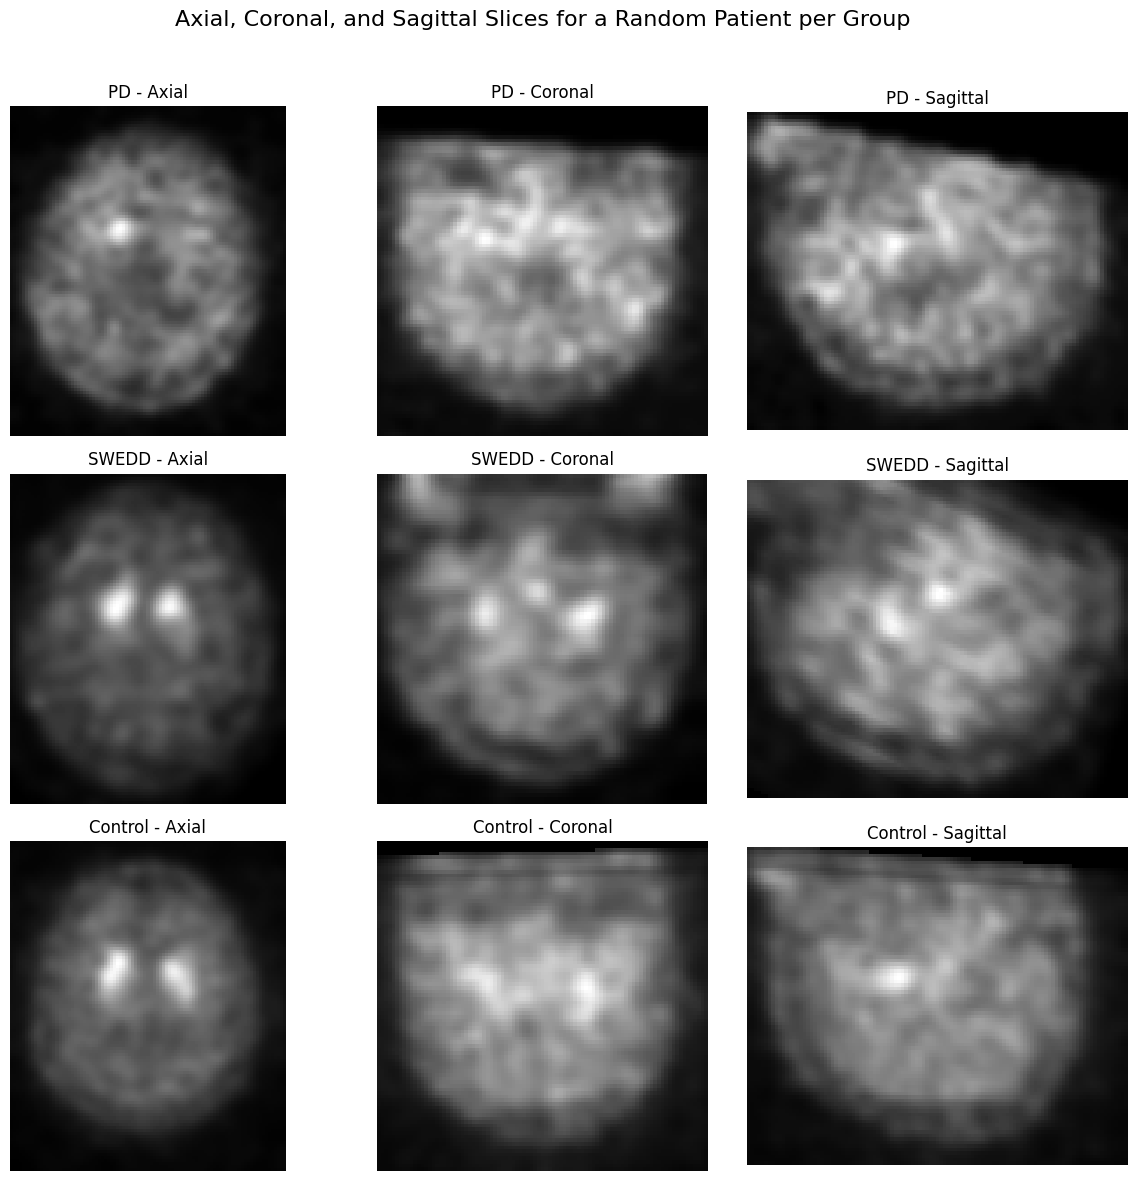

In [7]:
# Cell 6: Visualize One Axial, Coronal, and Sagittal Slice for a Random Patient per Group

import pandas as pd
import random
import matplotlib.pyplot as plt
import numpy as np
import nibabel as nib

# Read the validated file paths CSV generated earlier
df = pd.read_csv("validated_file_paths.csv")

# Function to extract the three orthogonal slices from a 3D volume
def extract_slices(volume):
    """
    Given a 3D volume, returns one axial, one coronal, and one sagittal slice.
    Assumes volume shape is (depth, height, width).
    """
    d, h, w = volume.shape
    axial = volume[d // 2, :, :]         # Axial: slice along depth
    coronal = volume[:, h // 2, :]        # Coronal: slice along height
    sagittal = volume[:, :, w // 2]       # Sagittal: slice along width
    return axial, coronal, sagittal

# List of groups and their expected labels
groups = {"PD": "PD", "SWEDD": "SWEDD", "Control": "Control"}
maskH = nib.load('rmask_ICV.nii')
mask = maskH.get_fdata()>0.5
mask = np.transpose(mask,[2, 1, 0])
mask = np.flip(mask,axis=1)
# Create a figure with one row per group and three columns for the views
fig, axes = plt.subplots(nrows=len(groups), ncols=3, figsize=(12, 4 * len(groups)))
fig.suptitle("Axial, Coronal, and Sagittal Slices for a Random Patient per Group", fontsize=16)

for i, (group_key, group_label) in enumerate(groups.items()):
    # Filter DataFrame for the current group
    group_df = df[df["label"] == group_label]
    if group_df.empty:
        print(f"No data found for group {group_label}")
        continue

    # Select a random file from the group
    random_file = group_df.sample(1)["file_path"].values[0]
    print(f"Loading file for group {group_label}: {random_file}")

    # Load the DICOM volume using the previously defined load_dicom() function
    volume, _ = load_dicom(random_file)

    # Verify the volume is 3D (if not, skip or raise an error)
    if volume.ndim != 3:
        raise ValueError(f"Expected 3D volume, got shape {volume.shape} for file: {random_file}")

    axial, coronal, sagittal = extract_slices(volume)

    # Plot Axial slice
    ax = axes[i, 0]
    ax.imshow(axial, cmap="gray")
    ax.set_title(f"{group_label} - Axial")
    ax.axis("off")

    # Plot Coronal slice
    ax = axes[i, 1]
    ax.imshow(coronal, cmap="gray")
    ax.set_title(f"{group_label} - Coronal")
    ax.axis("off")

    # Plot Sagittal slice
    ax = axes[i, 2]
    ax.imshow(sagittal, cmap="gray")
    ax.set_title(f"{group_label} - Sagittal")
    ax.axis("off")

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


## Data Preprocessing

### Intensity Normalization and Volume Preprocessing

### Brain Masking

In [8]:
#!pip install scikit-image

(64, 109, 91)
(64, 128, 128)


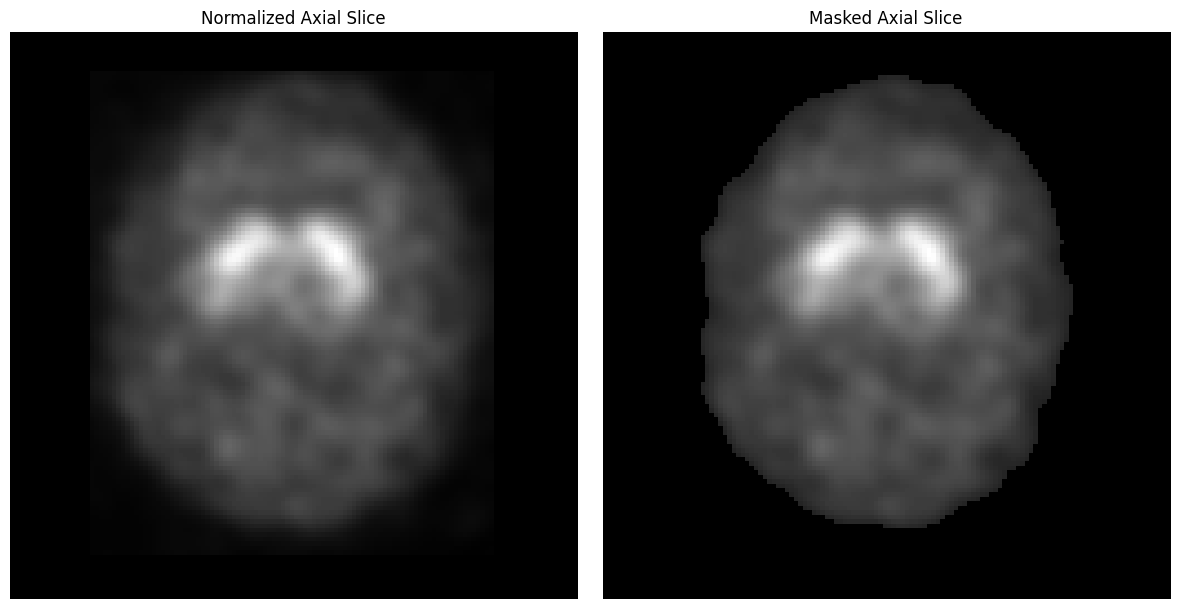

In [9]:
# Cell 7: Data Preprocessing – Brain Masking

import numpy as np
import matplotlib.pyplot as plt
from skimage.filters import threshold_otsu
from skimage.morphology import binary_closing, ball

def resize_volume(volume, target_shape=(64, 128, 128)):
    """
    Resizes the volume to the target shape using zero-padding or center cropping.

    Args:
        volume: Input 3D volume as numpy array with shape (d, h, w)
        target_shape: Desired output shape as tuple (d_new, h_new, w_new)

    Returns:
        Resized volume with shape target_shape
    """
    def get_pad_amounts(current_size, target_size):
        """Helper to calculate padding amounts"""
        if current_size >= target_size:
            return 0, 0
        diff = target_size - current_size
        pad_before = diff // 2
        pad_after = diff - pad_before
        return pad_before, pad_after

    current_shape = volume.shape
    resized = volume.copy()

    # Calculate padding/cropping for each dimension
    pads = [get_pad_amounts(current_shape[i], target_shape[i]) for i in range(3)]

    # Apply padding if needed
    if any(sum(p) > 0 for p in pads):
        resized = np.pad(
            resized,
            pad_width=pads,
            mode="constant",
            constant_values=0
        )

    # Apply cropping if needed
    for i in range(3):
        if current_shape[i] > target_shape[i]:
            # Calculate slicing indices
            start = (current_shape[i] - target_shape[i]) // 2
            end = start + target_shape[i]
            # Apply slice
            if i == 0:
                resized = resized[start:end, :, :]
            elif i == 1:
                resized = resized[:, start:end, :]
            else:
                resized = resized[:, :, start:end]

    return resized

def process_volume(volume, target_shape=(64, 128, 128)):
    """
    Process a 3D volume by:
    1. Normalizing intensity (truncating negatives and min-max scaling)
    2. Resizing to target_shape
    3. Generating a brain mask via Otsu thresholding and morphological closing

    Args:
        volume: Input 3D volume
        target_shape: Desired output shape (depth, height, width)

    Returns:
        norm_vol: Normalized and resized volume
        mask: Brain mask
        masked_vol: Masked volume
    """
    # 1. Intensity normalization
    # volume = np.clip(volume, a_min=0, a_max=None)
    # vmin, vmax = volume.min(), volume.max()
    # if vmax > vmin:
    #     norm_vol = (volume - vmin) / (vmax - vmin)
    # else:
    #     norm_vol = volume - vmin
    

    # 2. Resize the normalized volume
    norm_vol = resize_volume(volume-volume.min(), target_shape=target_shape)
    mask = np.zeros((64,128,128),dtype=bool)
    mask[20:40,82:103,43:82]=1    
    norm_vol /= np.mean(norm_vol[mask])    

    # 3. Compute brain mask
    thresh = threshold_otsu(norm_vol)
    mask = norm_vol > thresh
    mask = binary_closing(mask, footprint=ball(2))
    masked_vol = norm_vol * mask

    return norm_vol, mask, masked_vol

# Demonstration: Load one sample DICOM file (using the first file in your validated DataFrame)
sample_file = df.iloc[0]["file_path"]
original_volume, _ = load_dicom(sample_file)
original_volume = original_volume[9:73,:,:]

# Process the volume with our new function
norm_vol, mask, masked_vol = process_volume(original_volume, target_shape=(64,128,128))

print(original_volume.shape)
print(norm_vol.shape)

# Extract an axial (middle) slice from both the normalized volume and the masked volume
axial_norm = norm_vol[norm_vol.shape[0]//2, :, :]
axial_masked = masked_vol[masked_vol.shape[0]//2, :, :]

# Plot side-by-side for comparison
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(axial_norm, cmap="gray")
axes[0].set_title("Normalized Axial Slice")
axes[0].axis("off")

axes[1].imshow(axial_masked, cmap="gray")
axes[1].set_title("Masked Axial Slice")
axes[1].axis("off")

plt.tight_layout()
plt.show()


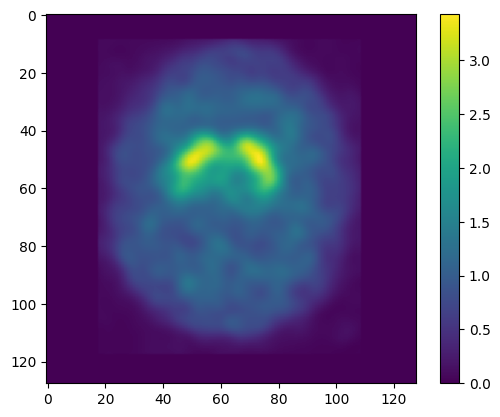

In [10]:
# Cell 8: Data Preprocessing – Visualization (heatmap)
plt.imshow(norm_vol[32,:,:])
plt.colorbar()



## Dataloader Creation (with Shape Validation)

In [11]:
# !pip install ipywidgets

In [12]:
# Cell 9: Dataset Implementation with GPU Memory Management
import torch
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import gc
import numpy as np
import os
import psutil
import time
from sklearn.model_selection import train_test_split

def print_memory_stats():
    """Print memory usage statistics"""
    if torch.cuda.is_available():
        print("\nGPU Memory Usage:")
        print(f"Allocated: {torch.cuda.memory_allocated() / 1024**2:.2f} MB")
        print(f"Cached: {torch.cuda.memory_reserved() / 1024**2:.2f} MB")
    print(f"CPU Memory Usage: {psutil.Process().memory_info().rss / 1024**2:.2f} MB")

class OnDemandDataset(Dataset):
    """
    Memory-efficient dataset that loads volumes on demand rather than all at once
    """
    def __init__(self, dataframe, transform=None):
        self.df = dataframe
        self.transform = transform
        
        # Load mask once
        try:
            maskH = nib.load('rmask_ICV.nii')
            self.mask = maskH.get_fdata() > 0.5
            self.mask = np.transpose(self.mask, [2, 1, 0])
            self.mask = np.flip(self.mask, axis=1)
            print("✅ Brain mask loaded successfully")
        except Exception as e:
            print(f"⚠️ Warning: Could not load brain mask: {e}")
            print("⚠️ Creating a dummy mask instead")
            self.mask = np.ones((128, 128, 128), dtype=bool)
        
        # Verify all paths exist
        missing_files = []
        for idx, row in dataframe.iterrows():
            if not os.path.exists(row["file_path"]):
                missing_files.append(row["file_path"])
        
        if missing_files:
            print(f"⚠️ Warning: {len(missing_files)} files not found!")
            print(f"First few missing files: {missing_files[:3]}")
        else:
            print(f"✅ All {len(dataframe)} file paths are valid")

    def __len__(self):
        """Return the total number of samples in the dataset"""
        return len(self.df)

    def __getitem__(self, idx):
        """Load a single volume on demand"""
        try:
            # Get file path
            file_path = self.df.iloc[idx]["file_path"]
            
            # Load and process volume
            volume, _ = load_dicom(file_path)
            
            # Apply mask
            volume -= volume.min()
            volume = volume * self.mask
            
            # Apply processing
            norm_vol, _, _ = process_volume(volume[9:73, :, :], target_shape=(64, 128, 128))
            
            # Convert to tensor
            volume_tensor = torch.from_numpy(np.expand_dims(norm_vol, axis=0)).float()
            
            return {
                "volume": volume_tensor,
                "label": self.df.iloc[idx]["label"],
                "path": self.df.iloc[idx]["file_path"]
            }
        except Exception as e:
            print(f"Error processing file {self.df.iloc[idx]['file_path']}: {e}")
            # Return a zero tensor as fallback
            return {
                "volume": torch.zeros((1, 64, 128, 128), dtype=torch.float32),
                "label": self.df.iloc[idx]["label"],
                "path": self.df.iloc[idx]["file_path"]
            }

class BatchLoadDataset(Dataset):
    """
    Memory-efficient dataset that processes data in small batches 
    and caches the processed results
    """
    def __init__(self, dataframe, batch_size=32, transform=None):
        self.df = dataframe
        self.transform = transform
        self.data_cache = {}  # Cache for processed data
        
        # Load mask once
        try:
            maskH = nib.load('rmask_ICV.nii')
            self.mask = maskH.get_fdata() > 0.5
            self.mask = np.transpose(self.mask, [2, 1, 0])
            self.mask = np.flip(self.mask, axis=1)
            print("✅ Brain mask loaded successfully")
        except Exception as e:
            print(f"⚠️ Warning: Could not load brain mask: {e}")
            print("⚠️ Creating a dummy mask instead")
            self.mask = np.ones((128, 128, 128), dtype=bool)
        
        # Pre-process data in batches to avoid memory issues
        total_batches = (len(dataframe) + batch_size - 1) // batch_size
        print(f"Pre-processing {len(dataframe)} samples in {total_batches} batches...")
        
        for batch_idx in tqdm(range(total_batches)):
            start_idx = batch_idx * batch_size
            end_idx = min(start_idx + batch_size, len(dataframe))
            
            for idx in range(start_idx, end_idx):
                try:
                    file_path = dataframe.iloc[idx]["file_path"]
                    
                    # Load DICOM
                    volume, _ = load_dicom(file_path)
                    volume -= volume.min()
                    volume = volume * self.mask
                    
                    # Process volume
                    norm_vol, _, _ = process_volume(volume[9:73, :, :], target_shape=(64, 128, 128))
                    
                    # Store in cache (using index as key)
                    self.data_cache[idx] = norm_vol
                    
                except Exception as e:
                    print(f"Error processing file {dataframe.iloc[idx]['file_path']}: {e}")
                    self.data_cache[idx] = np.zeros((64, 128, 128), dtype=np.float32)
            
            # Force garbage collection after each batch
            gc.collect()
            if torch.cuda.is_available():
                torch.cuda.empty_cache()
            
            # Print memory stats every few batches
            if batch_idx % 5 == 0:
                print_memory_stats()
        
        print("✅ Data pre-processing complete")

    def __len__(self):
        """Return the total number of samples in the dataset"""
        return len(self.df)

    def __getitem__(self, idx):
        """Get a cached pre-processed volume"""
        try:
            # Get the pre-processed volume from cache
            norm_vol = self.data_cache[idx]
            
            # Convert to tensor
            volume_tensor = torch.from_numpy(np.expand_dims(norm_vol, axis=0)).float()
            
            return {
                "volume": volume_tensor,
                "label": self.df.iloc[idx]["label"],
                "path": self.df.iloc[idx]["file_path"]
            }
        except Exception as e:
            print(f"Error retrieving item {idx}: {e}")
            # Return a zero tensor as fallback
            return {
                "volume": torch.zeros((1, 64, 128, 128), dtype=torch.float32),
                "label": self.df.iloc[idx]["label"],
                "path": self.df.iloc[idx]["file_path"]
            }

def create_dataloaders(df, batch_size=4, train_split=0.8, on_demand=True):
    """Create train and validation dataloaders with stratified split"""
    # Stratified split to maintain group distributions
    train_df, val_df = train_test_split(
        df,
        test_size=1-train_split,
        stratify=df['label'],
        random_state=42
    )

    print("\nTraining set distribution:")
    print(train_df['label'].value_counts())
    print("\nValidation set distribution:")
    print(val_df['label'].value_counts())

    # Create datasets with appropriate strategy
    if on_demand:
        print("Using on-demand data loading strategy (lighter on memory but slower)")
        train_dataset = OnDemandDataset(train_df)
        val_dataset = OnDemandDataset(val_df)
    else:
        print("Using batch pre-processing strategy (faster but more memory intensive)")
        train_dataset = BatchLoadDataset(train_df)
        val_dataset = BatchLoadDataset(val_df)

    # Create dataloaders with optimized settings
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=2,  # Reduced from 6 to prevent hanging
        pin_memory=True,
        persistent_workers=False  # Changed from True to avoid memory issues
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=2,  # Reduced from 6 to prevent hanging
        pin_memory=True,
        persistent_workers=False  # Changed from True to avoid memory issues
    )

    return train_loader, val_loader

# Test the dataloader with a small batch
if __name__ == "__main__":
    print("Testing dataloader with small batch...")
    start_time = time.time()
    
    # Create dataloaders with a smaller batch size for testing
    train_loader, val_loader = create_dataloaders(df, batch_size=2, on_demand=True)
    
    # Try to load a single batch
    print("Fetching a single batch...")
    for batch in train_loader:
        print(f"Batch loaded successfully!")
        print(f"Batch shape: {batch['volume'].shape}")
        print(f"Labels: {batch['label']}")
        break
    
    print(f"Dataloader test completed in {time.time() - start_time:.2f} seconds")
    print_memory_stats()

Testing dataloader with small batch...

Training set distribution:
label
PD         2043
Control     235
SWEDD       110
Name: count, dtype: int64

Validation set distribution:
label
PD         512
Control     59
SWEDD       27
Name: count, dtype: int64
Using on-demand data loading strategy (lighter on memory but slower)
✅ Brain mask loaded successfully
✅ All 2388 file paths are valid
✅ Brain mask loaded successfully
✅ All 598 file paths are valid
Fetching a single batch...
Batch loaded successfully!
Batch shape: torch.Size([2, 1, 64, 128, 128])
Labels: ['PD', 'PD']
Dataloader test completed in 11.54 seconds

GPU Memory Usage:
Allocated: 0.00 MB
Cached: 0.00 MB
CPU Memory Usage: 832.41 MB


### LP Ram Loader

In [13]:
# class LPRamDataset(Dataset):
#     def __init__(self, dataframe, transform=None):
#         self.df = dataframe
#         self.transform = transform
#         maskH = nib.load('rmask_ICV.nii')
#         mask = maskH.get_fdata()>0.5
#         mask = np.transpose(mask,[2, 1, 0])
#         mask = np.flip(mask,axis=1)        
#         self.npArr = np.zeros((len(dataframe),1,64,128,128),dtype=np.float32)

#         counter=0
#         for _, row in dataframe.iterrows():
#             try:
#                 file_path = row["file_path"]

#             # Load DICOM
#                 volume, _ = load_dicom(file_path) 
#                 volume -= volume.min()
#          #       print(counter)
#          #       print(volume.shape)
#         #        print(mask.shape)
#                 volume *= mask
#                 norm_vol, _, masked_vol = process_volume(volume[9:73,:,:], target_shape=(64, 128, 128))
#                 self.npArr[counter,0,:,:,:]=norm_vol
#                 counter +=1
#            #     delete volume, norm_vol, masked_vol
#             except Exception as e:
#                 print(f"Error processing file {row['file_path']}: {e}") 
#         self.npArr = self.npArr[:counter,:,:,:,:]
#  #       self.immArr = torch.from_numpy(self.npArr).float().to("cuda")        
#   #      delete volume, masked_vol, mask
#         gc.collect()

#     def __len__(self):
#         """Return the total number of samples in the dataset"""
#         return len(self.df)

#     def __getitem__(self, idx):
#       #      print(self.immArr.shape)
#  #           print(idx)
#             volume_tensor = torch.from_numpy(self.npArr[idx, :, :, :, :])
#             return {
#                 "volume": volume_tensor,
#                 "label": self.df.iloc[idx]["label"],
#                 "path":self.df.iloc[idx]["file_path"]
#             }


# def create_dataloaders(df, batch_size=4, train_split=0.8):
#     """Create train and validation dataloaders with stratified split"""
#     # Stratified split to maintain group distributions
#     train_df, val_df = train_test_split(
#         df,
#         test_size=1-train_split,
#         stratify=df['label'],
#         random_state=42
#     )

#     print("\nTraining set distribution:")
#     print(train_df['label'].value_counts())
#     print("\nValidation set distribution:")
#     print(val_df['label'].value_counts())

#     # Create datasets

#     # Create dataloaders
#     train_loader = DataLoader(
#         train_dataset,
#         batch_size=batch_size,
#         shuffle=True,
#         num_workers=0,  # No multiprocessing for debugging
#         pin_memory=True
#     )

#     val_loader = DataLoader(
#         val_dataset,
#         batch_size=batch_size,
#         shuffle=False,
#         num_workers=0,  # No multiprocessing for debugging
#         pin_memory=True
#     )

#     return train_loader, val_loader


# Exploratory Data Analysis (EDA)

In [14]:
# !pip install seaborn

Starting Memory-Efficient EDA with Stratified Sampling...

Creating memory-efficient dataloaders...

Training set distribution:
label
PD         2043
Control     235
SWEDD       110
Name: count, dtype: int64

Validation set distribution:
label
PD         512
Control     59
SWEDD       27
Name: count, dtype: int64
Using on-demand data loading strategy (lighter on memory but slower)
✅ Brain mask loaded successfully
✅ All 2388 file paths are valid
✅ Brain mask loaded successfully
✅ All 598 file paths are valid

Analyzing training dataset (with stratification)...
Analyzing dataset statistics (stratified, memory-efficient version)...
Scanning dataset to count groups...


Counting groups:   9%|▉         | 113/1194 [00:09<01:32, 11.70it/s]

Error processing file Images/PPMI_Images_PD/3078/Reconstructed_DaTSCAN/2016-04-26_15_13_55.0/I1317553/PPMI_3078_NM_Reconstructed_DaTSCAN_Br_20200616094336526_1_S550149_I1317553.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Counting groups:  27%|██▋       | 323/1194 [00:26<01:05, 13.38it/s]

Error processing file Images/PPMI_Images_PD/3372/Reconstructed_DaTSCAN/2016-04-27_14_22_11.0/I1317554/PPMI_3372_NM_Reconstructed_DaTSCAN_Br_20200616094430112_56911_S910440_I1317554.dcm: operands could not be broadcast together with shapes (256,128,128) (91,109,91) 


Counting groups:  63%|██████▎   | 755/1194 [01:06<00:38, 11.32it/s]

Error processing file Images/PPMI_Images_PD/3372/Reconstructed_DaTSCAN/2016-04-27_14_22_11.0/I1317554/PPMI_3372_NM_Reconstructed_DaTSCAN_Br_20200616094419794_56912_S910440_I1317554.dcm: operands could not be broadcast together with shapes (256,128,128) (91,109,91) 
Error processing file Images/PPMI_Images_PD/3500/Reconstructed_DaTSCAN/2015-12-02_09_47_00.0/I770244/PPMI_3500_NM_Reconstructed_DaTSCAN_Br_20160829161451092__S494455_I770244.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Counting groups:  99%|█████████▊| 1177/1194 [01:45<00:01, 12.05it/s]

Error processing file Images/PPMI_Images_PD/3078/Reconstructed_DaTSCAN/2016-04-26_15_13_55.0/I1317553/PPMI_3078_NM_Reconstructed_DaTSCAN_Br_20200616094331434_1_S550149_I1317553.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Counting groups:  99%|█████████▉| 1187/1194 [01:46<00:00, 11.19it/s]

Error processing file Images/PPMI_Images_PD/3107/Reconstructed_DaTSCAN/2016-04-05_13_38_35.0/I770243/PPMI_3107_NM_Reconstructed_DaTSCAN_Br_20160829161427801_1_S494457_I770243.dcm: operands could not be broadcast together with shapes (360,128,128) (91,109,91) 


Counting groups: 100%|██████████| 1194/1194 [01:47<00:00, 11.15it/s]


Found groups: {'Control': 235, 'PD': 2043, 'SWEDD': 110}


Error processing file Images/PPMI_Images_PD/3500/Reconstructed_DaTSCAN/2015-12-02_09_47_00.0/I770244/PPMI_3500_NM_Reconstructed_DaTSCAN_Br_20160829161451092__S494455_I770244.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Error processing file Images/PPMI_Images_PD/3372/Reconstructed_DaTSCAN/2016-04-27_14_22_11.0/I1317554/PPMI_3372_NM_Reconstructed_DaTSCAN_Br_20200616094430112_56911_S910440_I1317554.dcm: operands could not be broadcast together with shapes (256,128,128) (91,109,91) 


Collected sufficient samples from all groups
Processing 118 collected samples...
Samples per group: {'PD': 88, 'Control': 15, 'SWEDD': 15}


Successfully analyzed 118 samples
Group distribution in analyzed samples:
label
PD         88
SWEDD      15
Control    15
Name: count, dtype: int64

Plotting intensity distributions...


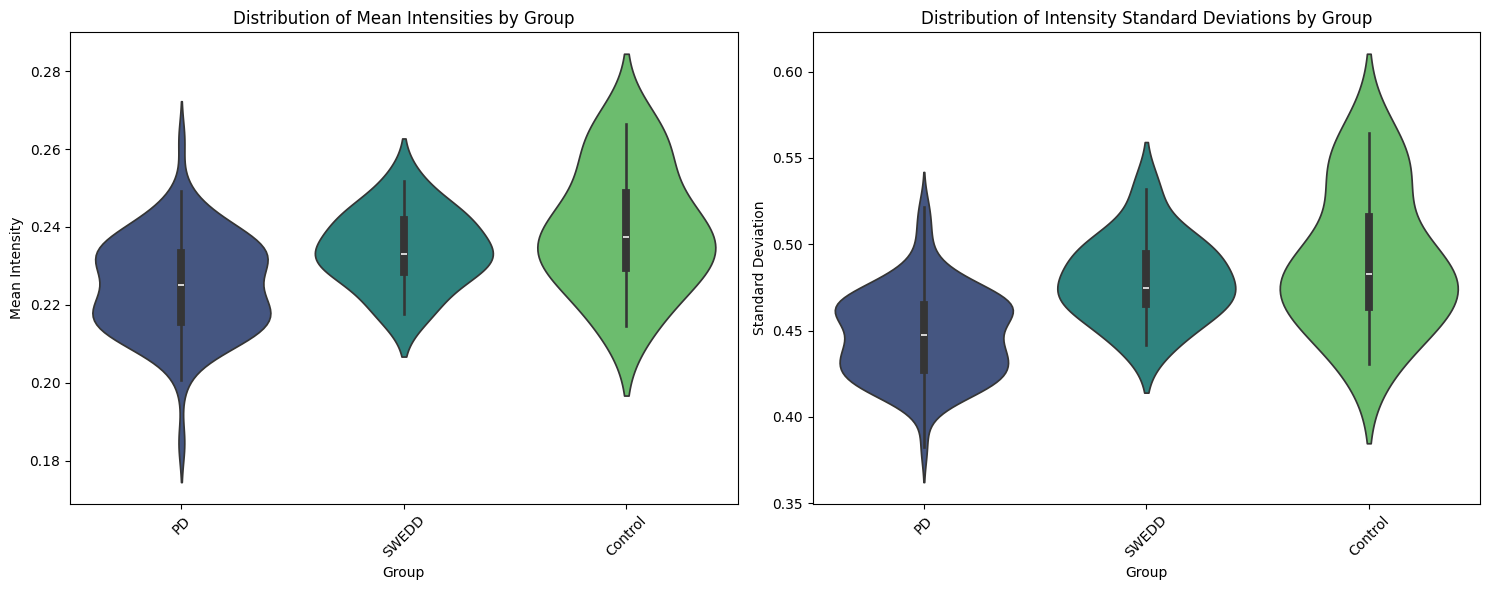


Plotting group statistics...


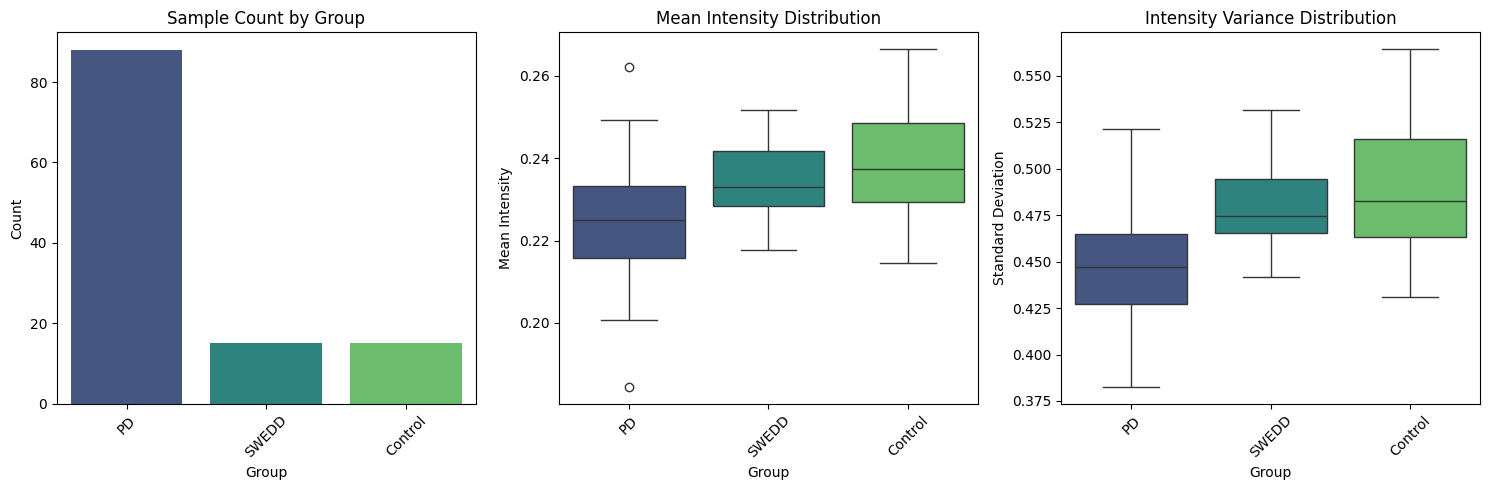


Visualizing example slices...
Error processing file Images/PPMI_Images_PD/3078/Reconstructed_DaTSCAN/2016-04-26_15_13_55.0/I1317553/PPMI_3078_NM_Reconstructed_DaTSCAN_Br_20200616094336526_1_S550149_I1317553.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 
Error processing file Images/PPMI_Images_PD/3107/Reconstructed_DaTSCAN/2016-04-05_13_38_35.0/I770243/PPMI_3107_NM_Reconstructed_DaTSCAN_Br_20160829161427801_1_S494457_I770243.dcm: operands could not be broadcast together with shapes (360,128,128) (91,109,91) 


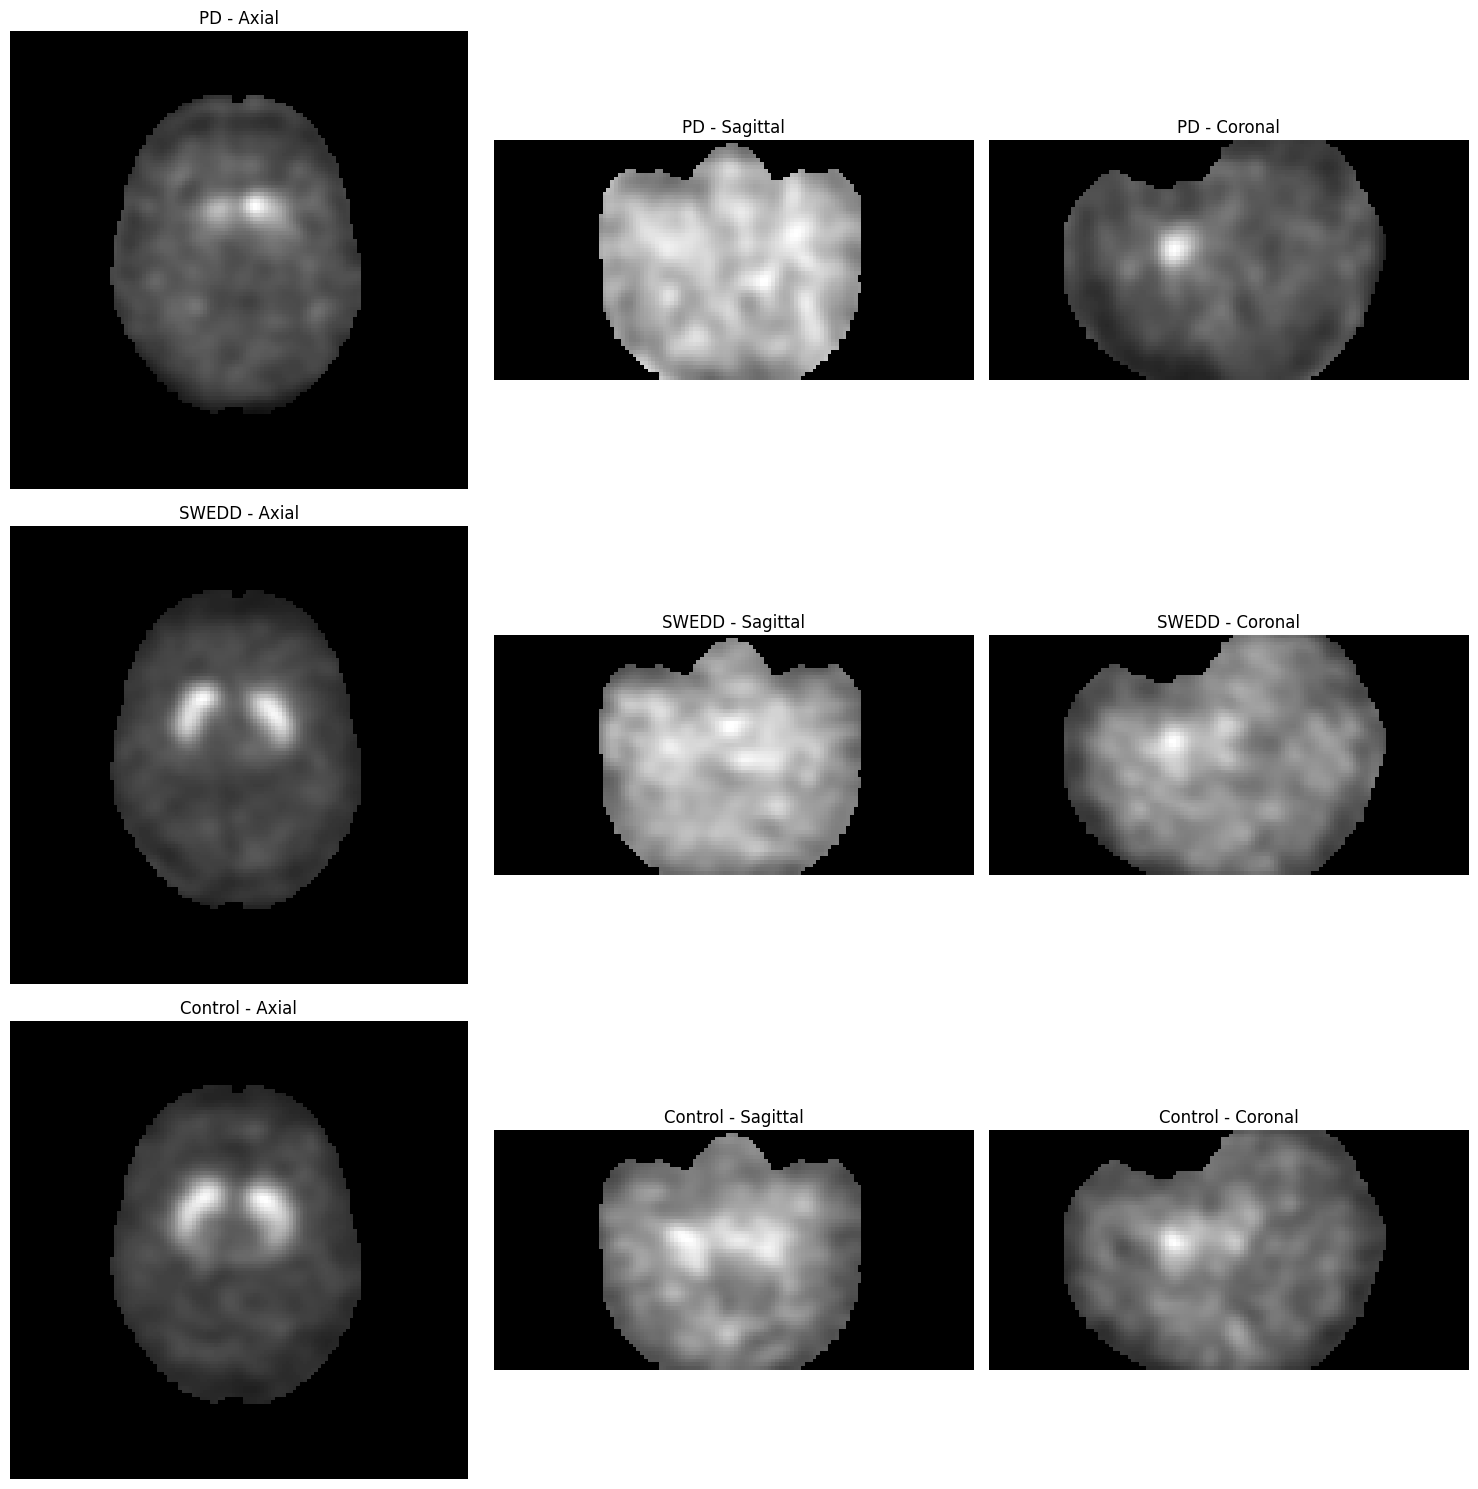


Summary Statistics by Group:
          mean           std         min         max       
          mean    std   mean    std mean  std   mean    std
label                                                      
Control  0.239  0.015  0.491  0.040  0.0  0.0  5.281  1.058
PD       0.225  0.012  0.448  0.025  0.0  0.0  3.694  0.845
SWEDD    0.234  0.009  0.480  0.024  0.0  0.0  5.158  0.788

EDA completed in 156.82 seconds!

GPU Memory Usage:
Allocated: 0.00 MB
Cached: 0.00 MB
CPU Memory Usage: 1423.66 MB


In [15]:
# Cell 10: Optimized EDA Implementation with Stratified Sampling
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm
from collections import defaultdict
import torch
import time
import gc
import random

def create_memory_efficient_dataloaders(df, batch_size=2, train_split=0.8):
    """
    Create train and validation dataloaders with optimized memory usage
    """
    # Reuse the create_dataloaders function from Cell 9
    return create_dataloaders(df, batch_size=batch_size, train_split=train_split, on_demand=True)

def analyze_dataset_statistics_efficiently(dataloader, max_samples=100, min_samples_per_group=15):
    """
    Analyzes dataset statistics with improved memory efficiency and ensures
    stratified sampling across all patient groups.
    
    Args:
        dataloader: The dataloader to sample from
        max_samples: Maximum total samples to process
        min_samples_per_group: Minimum samples to collect per group
    
    Returns: 
        Dictionary of statistical measures with proper group representation
    """
    print("Analyzing dataset statistics (stratified, memory-efficient version)...")
    stats = defaultdict(list)
    samples_by_group = defaultdict(int)
    
    # First pass: Count occurrences of each group
    group_counts = {}
    print("Scanning dataset to count groups...")
    for batch in tqdm(dataloader, desc="Counting groups"):
        labels = batch['label']
        for label in labels:
            if label not in group_counts:
                group_counts[label] = 0
            group_counts[label] += 1
    
    print(f"Found groups: {group_counts}")
    
    # Second pass: Collect samples with stratification
    all_samples = []
    all_labels = []
    all_paths = []
    
    try:
        print("Collecting stratified samples...")
        for batch in tqdm(dataloader, desc="Collecting samples"):
            volumes = batch['volume']
            labels = batch['label']
            paths = batch['path']
            
            # Process each volume in the batch
            for vol_idx, (volume, label, path) in enumerate(zip(volumes, labels, paths)):
                # If we have enough samples from this group, skip unless we need more total samples
                if (samples_by_group[label] >= min_samples_per_group and 
                    sum(samples_by_group.values()) >= max_samples):
                    continue
                
                # Add this sample
                all_samples.append(volume)
                all_labels.append(label)
                all_paths.append(path)
                samples_by_group[label] += 1
            
            # Memory cleanup after each batch
            del volumes, labels, paths
            if torch.cuda.is_available():
                torch.cuda.empty_cache()
            
            # Check if we've collected enough samples from each group
            if all(samples_by_group[group] >= min_samples_per_group for group in group_counts):
                if sum(samples_by_group.values()) >= max_samples:
                    print(f"Collected sufficient samples from all groups")
                    break
    
    except Exception as e:
        print(f"Error during sample collection: {str(e)}")
        import traceback
        traceback.print_exc()
    
    # Process collected samples
    print(f"Processing {len(all_samples)} collected samples...")
    print(f"Samples per group: {dict(samples_by_group)}")
    
    for volume, label, path in zip(all_samples, all_labels, all_paths):
        # Extract statistics
        vol_data = volume.numpy().flatten()
        
        # Compute statistics
        stats['mean'].append(float(np.mean(vol_data)))
        stats['std'].append(float(np.std(vol_data)))
        stats['min'].append(float(np.min(vol_data)))
        stats['max'].append(float(np.max(vol_data)))
        stats['label'].append(label)
        stats['path'].append(path)
    
    # Convert to DataFrame for easier analysis
    stats_df = pd.DataFrame(stats)
    print(f"Successfully analyzed {len(stats_df)} samples")
    
    # Verify group representation
    group_dist = stats_df['label'].value_counts()
    print("Group distribution in analyzed samples:")
    print(group_dist)
    
    return stats_df

def plot_intensity_distributions(stats_df):
    """
    Creates violin plots of intensity distributions by group
    """
    plt.figure(figsize=(15, 6))

    # Plot intensity distributions
    plt.subplot(1, 2, 1)
    sns.violinplot(data=stats_df, x='label', y='mean', palette='viridis')
    plt.title('Distribution of Mean Intensities by Group')
    plt.xlabel('Group')
    plt.ylabel('Mean Intensity')
    plt.xticks(rotation=45)

    plt.subplot(1, 2, 2)
    sns.violinplot(data=stats_df, x='label', y='std', palette='viridis')
    plt.title('Distribution of Intensity Standard Deviations by Group')
    plt.xlabel('Group')
    plt.ylabel('Standard Deviation')
    plt.xticks(rotation=45)

    plt.tight_layout()
    plt.show()

def plot_group_statistics(stats_df):
    """
    Plots statistical summaries by group using lightweight operations
    """
    plt.figure(figsize=(15, 5))

    # Group counts
    plt.subplot(1, 3, 1)
    group_counts = stats_df['label'].value_counts()
    sns.barplot(x=group_counts.index, y=group_counts.values, palette='viridis')
    plt.title('Sample Count by Group')
    plt.xlabel('Group')
    plt.ylabel('Count')
    plt.xticks(rotation=45)

    # Box plots - more memory efficient than complex plots
    plt.subplot(1, 3, 2)
    sns.boxplot(data=stats_df, x='label', y='mean', palette='viridis')
    plt.title('Mean Intensity Distribution')
    plt.xlabel('Group')
    plt.ylabel('Mean Intensity')
    plt.xticks(rotation=45)

    # Simple boxplot instead of violin plot
    plt.subplot(1, 3, 3)
    sns.boxplot(data=stats_df, x='label', y='std', palette='viridis')
    plt.title('Intensity Variance Distribution')
    plt.xlabel('Group')
    plt.ylabel('Standard Deviation')
    plt.xticks(rotation=45)

    plt.tight_layout()
    plt.show()

def visualize_sample_slices(stats_df, dataloader, samples_per_group=1):
    """
    Visualizes a limited number of samples from each group
    with efficient memory handling, selecting from the pre-processed samples
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # Get unique groups
    groups = stats_df['label'].unique()
    
    # Dictionary to hold samples for each group
    samples_data = {}
    
    # Select paths from stats_df, stratified by group
    selected_paths = {}
    for group in groups:
        group_paths = stats_df[stats_df['label'] == group]['path'].values
        if len(group_paths) > 0:
            selected_paths[group] = random.sample(list(group_paths), 
                                                min(samples_per_group, len(group_paths)))
    
    # Find these samples in the dataloader
    for batch in dataloader:
        volumes = batch['volume']
        paths = batch['path']
        labels = batch['label']
        
        for i, (vol, path, label) in enumerate(zip(volumes, paths, labels)):
            # Check if this path is in our selected paths
            for group, group_paths in selected_paths.items():
                if path in group_paths:
                    # Store the sample
                    key = f"{group}_{len(samples_data)}"
                    samples_data[key] = vol.cpu().numpy()
                    # Remove from selected_paths to avoid duplicates
                    selected_paths[group].remove(path)
            
        # Check if we have all samples
        if all(len(paths) == 0 for paths in selected_paths.values()):
            break
    
    # Visualize the samples
    num_groups = len(groups)
    plt.figure(figsize=(15, 5 * num_groups))
    
    for i, (key, vol) in enumerate(samples_data.items()):
        # Extract label
        label = key.split('_')[0]
        
        # Get middle slices
        vol = vol.squeeze()  # Remove channel dimension
        axial_slice = vol[vol.shape[0]//2, :, :]
        sagittal_slice = vol[:, vol.shape[1]//2, :]
        coronal_slice = vol[:, :, vol.shape[2]//2]
        
        # Plot slices
        plt.subplot(len(samples_data), 3, i*3 + 1)
        plt.imshow(axial_slice, cmap='gray')
        plt.title(f'{label} - Axial')
        plt.axis('off')
        
        plt.subplot(len(samples_data), 3, i*3 + 2)
        plt.imshow(sagittal_slice, cmap='gray')
        plt.title(f'{label} - Sagittal')
        plt.axis('off')
        
        plt.subplot(len(samples_data), 3, i*3 + 3)
        plt.imshow(coronal_slice, cmap='gray')
        plt.title(f'{label} - Coronal')
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Run optimized EDA
if __name__ == "__main__":
    start_time = time.time()
    print("Starting Memory-Efficient EDA with Stratified Sampling...")

    # Create dataloaders with small batch size
    print("\nCreating memory-efficient dataloaders...")
    train_loader, val_loader = create_memory_efficient_dataloaders(df, batch_size=2)

    # Analyze with stratified sampling and more samples
    print("\nAnalyzing training dataset (with stratification)...")
    train_stats = analyze_dataset_statistics_efficiently(
        train_loader, 
        max_samples=100,  # Increased from 50 to 100
        min_samples_per_group=15  # Ensure at least 15 samples per group
    )

    # Plot distributions and statistics
    print("\nPlotting intensity distributions...")
    plot_intensity_distributions(train_stats)

    print("\nPlotting group statistics...")
    plot_group_statistics(train_stats)

    # Visualize a few examples
    print("\nVisualizing example slices...")
    visualize_sample_slices(train_stats, train_loader, samples_per_group=1)

    # Print summary statistics by group
    print("\nSummary Statistics by Group:")
    summary_stats = train_stats.groupby('label').agg({
        'mean': ['mean', 'std'],
        'std': ['mean', 'std'],
        'min': ['mean', 'std'],
        'max': ['mean', 'std']
    }).round(3)
    print(summary_stats)

    # Memory cleanup
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

    print(f"\nEDA completed in {time.time() - start_time:.2f} seconds!")
    print_memory_stats()

### Slice Intensity Variance Analysis

In [16]:
def analyze_slice_variance(dataloader, num_samples_per_group=5):
    """
    Analyzes slice-wise variance across different views for each patient group
    """
    print("Analyzing slice-wise variance patterns...")

    # Initialize storage for variances
    group_variances = {
        'PD': {'axial': [], 'coronal': [], 'sagittal': []},
        'Control': {'axial': [], 'coronal': [], 'sagittal': []},
        'SWEDD': {'axial': [], 'coronal': [], 'sagittal': []}
    }
    sample_counts = {'PD': 0, 'Control': 0, 'SWEDD': 0}

    try:
        for batch in tqdm(dataloader, desc="Computing slice variances"):
            volumes = batch['volume']
            labels = batch['label']

            for volume, label in zip(volumes, labels):
                label = label if isinstance(label, str) else label.item()

                if sample_counts[label] >= num_samples_per_group:
                    continue

                # Get volume data
                vol_data = volume.squeeze().numpy()
                d, h, w = vol_data.shape

                # Compute variance for each slice in each view
                axial_var = [np.var(vol_data[i, :, :]) for i in range(d)]
                coronal_var = [np.var(vol_data[:, i, :]) for i in range(h)]
                sagittal_var = [np.var(vol_data[:, :, i]) for i in range(w)]

                # Store variances
                group_variances[label]['axial'].append(axial_var)
                group_variances[label]['coronal'].append(coronal_var)
                group_variances[label]['sagittal'].append(sagittal_var)

                sample_counts[label] += 1

            # Check if we have enough samples from each group
            if all(count >= num_samples_per_group for count in sample_counts.values()):
                break

            # Memory cleanup
            del volumes, labels
            gc.collect()
            torch.cuda.empty_cache()

    except Exception as e:
        print(f"Error during variance analysis: {str(e)}")
        import traceback
        traceback.print_exc()
        return None

    # Compute average variances across samples for each group
    avg_variances = {}
    for group in group_variances:
        avg_variances[group] = {
            view: np.mean(variances, axis=0)
            for view, variances in group_variances[group].items()
        }

    return avg_variances

# Plot the slice variance results
def plot_slice_variances(avg_variances):
    """
    Creates line plots for slice-wise variance analysis
    """
    views = ['axial', 'coronal', 'sagittal']
    fig, axes = plt.subplots(1, 3, figsize=(20, 6))

    for idx, view in enumerate(views):
        ax = axes[idx]

        for group in avg_variances:
            variances = avg_variances[group][view]
            ax.plot(range(len(variances)), variances, label=group)

        ax.set_title(f'{view.capitalize()} View - Slice-wise Variance')
        ax.set_xlabel('Slice Index')
        ax.set_ylabel('Average Variance')
        ax.legend()
        ax.grid(True)

    plt.tight_layout()
    plt.show()



Analyzing slice-wise variance patterns...
Analyzing slice-wise variance patterns...


Computing slice variances:   5%|▍         | 54/1194 [00:07<02:41,  7.06it/s]



Plotting slice-wise variance analysis...


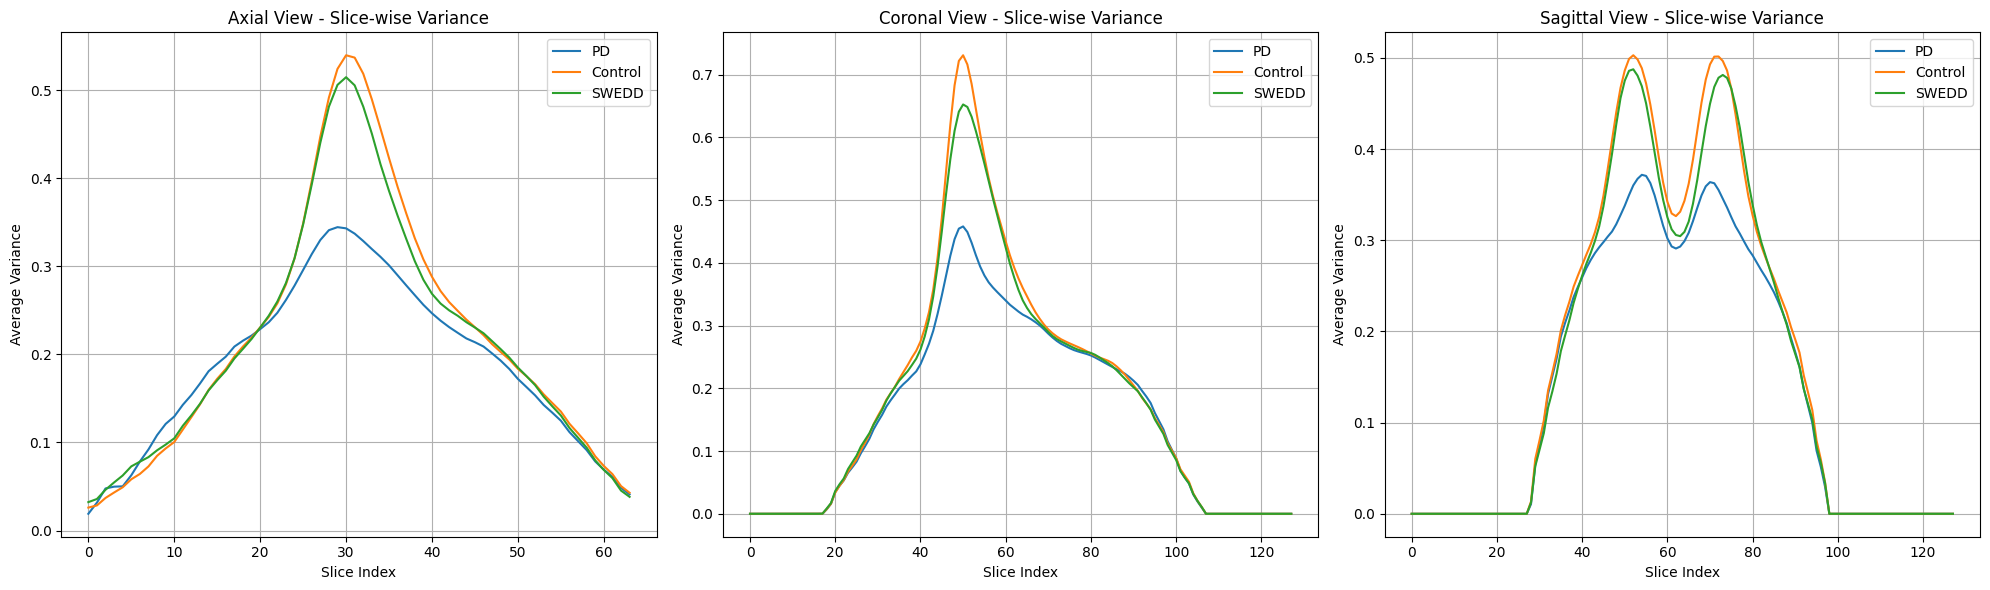

In [17]:
# Analyze slice-wise variance
print("\nAnalyzing slice-wise variance patterns...")
avg_variances = analyze_slice_variance(train_loader, num_samples_per_group=5)

if avg_variances is not None:
    print("\nPlotting slice-wise variance analysis...")
    plot_slice_variances(avg_variances)

# Model Phase

## 1. Autoencoder

### Model Setup

In [24]:
# Cell 11: Optimized Autoencoder with Memory Management
import torch
import torch.nn as nn
import torch.nn.functional as F
from collections import OrderedDict

class ConvBlock(nn.Module):
    """Memory-efficient convolutional block with batch normalization and ReLU activation."""
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1):
        super().__init__()
        self.block = nn.Sequential(OrderedDict([
            ('conv', nn.Conv3d(in_channels, out_channels, kernel_size, stride, padding)),
            ('bn', nn.BatchNorm3d(out_channels)),
            ('relu', nn.ReLU(inplace=True))  # inplace ReLU for memory efficiency
        ]))

    def forward(self, x):
        return self.block(x)

class Encoder(nn.Module):
    """3D Encoder network optimized for 64×128×128 input volumes."""
    def __init__(self, latent_dim=256):
        super().__init__()

        # Initial feature extraction
        self.init_conv = ConvBlock(1, 16)  # (1, 64, 128, 128) -> (16, 64, 128, 128)

        # Downsampling path with progressive channel increase
        self.down1 = nn.Sequential(
            ConvBlock(16, 32, stride=2),    # -> (32, 32, 64, 64)
            ConvBlock(32, 32)               # -> (32, 32, 64, 64)
        )

        self.down2 = nn.Sequential(
            ConvBlock(32, 64, stride=2),    # -> (64, 16, 32, 32)
            ConvBlock(64, 64)               # -> (64, 16, 32, 32)
        )

        self.down3 = nn.Sequential(
            ConvBlock(64, 128, stride=2),   # -> (128, 8, 16, 16)
            ConvBlock(128, 128)             # -> (128, 8, 16, 16)
        )

        self.down4 = nn.Sequential(
            ConvBlock(128, 256, stride=2),  # -> (256, 4, 8, 8)
            ConvBlock(256, 256)             # -> (256, 4, 8, 8)
        )

        # Project to latent space
        self.flatten_size = 256 * 4 * 8 * 8
        self.fc = nn.Linear(self.flatten_size, latent_dim)

    def forward(self, x):
        x = self.init_conv(x)
        d1 = self.down1(x)
        d2 = self.down2(d1)
        d3 = self.down3(d2)
        d4 = self.down4(d3)

        # Flatten and project to latent space
        flat = torch.flatten(d4, start_dim=1)
        z = self.fc(flat)

        return z

class Decoder(nn.Module):
    """3D Decoder network optimized for 64×128×128 output volumes."""
    def __init__(self, latent_dim=256):
        super().__init__()

        self.flatten_size = 256 * 4 * 8 * 8
        self.fc = nn.Linear(latent_dim, self.flatten_size)

        # Upsampling path
        self.up1 = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='trilinear', align_corners=False),
            ConvBlock(256, 128),
            ConvBlock(128, 128)
        )

        self.up2 = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='trilinear', align_corners=False),
            ConvBlock(128, 64),
            ConvBlock(64, 64)
        )

        self.up3 = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='trilinear', align_corners=False),
            ConvBlock(64, 32),
            ConvBlock(32, 32)
        )

        self.up4 = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='trilinear', align_corners=False),
            ConvBlock(32, 16),
            ConvBlock(16, 16)
        )

        # Final convolution
        self.final_conv = nn.Conv3d(16, 1, kernel_size=1)

    def forward(self, z):
        # Reshape from latent space
        x = self.fc(z)
        x = x.view(-1, 256, 4, 8, 8)

        # Upsampling
        x = self.up1(x)
        x = self.up2(x)
        x = self.up3(x)
        x = self.up4(x)

        # Final convolution
        x = self.final_conv(x)

        return x

class BaseAutoencoder(nn.Module):
    """Memory-optimized 3D Autoencoder for 64×128×128 medical volumes."""
    def __init__(self, latent_dim=256):
        super().__init__()
        self.encoder = Encoder(latent_dim)
        self.decoder = Decoder(latent_dim)

    def forward(self, x):
        z = self.encoder(x)
        reconstruction = self.decoder(z)
        return reconstruction

    def encode(self, x):
        """Encode input to latent space"""
        z = self.encoder(x)
        return z

    def decode(self, z):
        """Decode from latent space (for generation)"""
        return self.decoder(z)

# Memory and GPU test function
def test_autoencoder(batch_size=2):
    """Test the autoencoder with dummy data and verify memory usage."""
    print("\nTesting Autoencoder Architecture...")

    try:
        # Create model and move to GPU
        model = BaseAutoencoder(latent_dim=256)
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        model = model.to(device)

        # Print model summary
        num_params = sum(p.numel() for p in model.parameters())
        print(f"\nModel Parameters: {num_params:,}")

        # Create dummy input (64x128x128 volume)
        dummy_input = torch.randn(batch_size, 1, 64, 128, 128, device=device)

        # Print initial memory usage
        print("\nInitial GPU Memory Usage:")
        print_memory_stats()

        # Test encoding
        print("\nTesting encoder...")
        with torch.no_grad():
            latent = model.encode(dummy_input)
        print(f"Input shape: {dummy_input.shape}")
        print(f"Latent shape: {latent.shape}")

        # Test full forward pass
        print("\nTesting forward pass...")
        with torch.no_grad():
            output = model(dummy_input)

        # Print output shape and final memory usage
        print(f"Output shape: {output.shape}")
        print("\nFinal GPU Memory Usage:")
        print_memory_stats()

        # Verify shapes
        assert output.shape == dummy_input.shape, f"Shape mismatch: {output.shape} vs {dummy_input.shape}"

        # Clean up
        del model, dummy_input, output, latent
        torch.cuda.empty_cache()

        print("\nAutoencoder test completed successfully!")
        return True

    except Exception as e:
        print(f"Error testing autoencoder: {str(e)}")
        import traceback
        traceback.print_exc()
        return False

# Run test if this cell is executed
if __name__ == "__main__":
    test_autoencoder(batch_size=2)


Testing Autoencoder Architecture...

Model Parameters: 38,912,721

Initial GPU Memory Usage:

GPU Memory Usage:
Allocated: 165.10 MB
Cached: 216.00 MB
CPU Memory Usage: 1318.54 MB

Testing encoder...
Input shape: torch.Size([2, 1, 64, 128, 128])
Latent shape: torch.Size([2, 256])

Testing forward pass...
Output shape: torch.Size([2, 1, 64, 128, 128])

Final GPU Memory Usage:

GPU Memory Usage:
Allocated: 173.11 MB
Cached: 1116.00 MB
CPU Memory Usage: 1318.54 MB

Autoencoder test completed successfully!


In [25]:
# Cell 12: Training Configuration and Utilities
import os
import json
import time
from pathlib import Path
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.cuda.amp as amp
import math

class TrainingConfig:
    """Training configuration optimized for NVIDIA 4070Ti"""
    def __init__(self, **kwargs):
        # Model parameters
        self.latent_dim = kwargs.get('latent_dim', 256)
        
        # Training parameters
        self.learning_rate = kwargs.get('learning_rate', 1e-4)
        self.batch_size = kwargs.get('batch_size', 4)
        self.accumulation_steps = kwargs.get('accumulation_steps', 4)
        self.epochs = kwargs.get('epochs', 100)
        self.early_stopping_patience = kwargs.get('early_stopping_patience', 10)
        
        # Optimization
        self.use_mixed_precision = kwargs.get('use_mixed_precision', True)
        self.weight_decay = kwargs.get('weight_decay', 1e-5)
        self.gradient_clip = kwargs.get('gradient_clip', 1.0)
        
        # Dataloader parameters
        self.num_workers = kwargs.get('num_workers', 2)
        self.pin_memory = kwargs.get('pin_memory', True)
        
        # Checkpoint parameters
        self.checkpoint_dir = kwargs.get('checkpoint_dir', 'checkpoints')
        self.model_name = kwargs.get('model_name', 'autoencoder')
        self.save_interval = kwargs.get('save_interval', 5)
        
        # Create checkpoint directory
        Path(self.checkpoint_dir).mkdir(parents=True, exist_ok=True)
        
        # Print configuration summary
        print(f"\n{'='*50}")
        print(f"TRAINING CONFIGURATION")
        print(f"{'='*50}")
        print(f"Model: {self.model_name} with latent dim {self.latent_dim}")
        print(f"Batch size: {self.batch_size} × {self.accumulation_steps} steps = {self.batch_size * self.accumulation_steps} effective")
        print(f"Learning rate: {self.learning_rate}")
        print(f"Mixed precision: {'Enabled' if self.use_mixed_precision else 'Disabled'}")
        print(f"Epochs: {self.epochs} with patience {self.early_stopping_patience}")
        print(f"Dataloader workers: {self.num_workers}")
        print(f"Checkpoints saved to: {self.checkpoint_dir}")
        print(f"{'='*50}\n")

class EarlyStopping:
    """Early stopping handler with patience"""
    def __init__(self, patience=10, min_delta=0, verbose=True):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = float('inf')
        self.early_stop = False
        self.verbose = verbose
        self.best_epoch = 0
        
    def __call__(self, val_loss, epoch):
        if val_loss < self.best_loss - self.min_delta:
            if self.verbose:
                improvement = self.best_loss - val_loss
                print(f"Validation loss improved by {improvement:.6f}")
            self.best_loss = val_loss
            self.counter = 0
            self.best_epoch = epoch
            return True  # Model improved
        else:
            self.counter += 1
            if self.verbose:
                print(f"Early stopping counter: {self.counter}/{self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True
                if self.verbose:
                    print(f"Early stopping triggered. Best epoch was {self.best_epoch}.")
            return False  # Model didn't improve

class CheckpointHandler:
    """Handles saving and loading of model checkpoints"""
    def __init__(self, checkpoint_dir, model_name):
        self.checkpoint_dir = Path(checkpoint_dir)
        self.model_name = model_name
        self.checkpoint_path = self.checkpoint_dir / f"{model_name}_checkpoint.pth"
        self.best_model_path = self.checkpoint_dir / f"{model_name}_best.pth"
        self.metadata_path = self.checkpoint_dir / f"{model_name}_metadata.json"
        
        # Ensure directory exists
        self.checkpoint_dir.mkdir(parents=True, exist_ok=True)

    def save(self, model, optimizer, scheduler, epoch, train_losses, val_losses, is_best=False):
        """Save model checkpoint and training metadata"""
        # Save model checkpoint
        checkpoint = {
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict() if scheduler else None,
            'train_losses': train_losses,
            'val_losses': val_losses
        }
        
        # Always save latest checkpoint
        torch.save(checkpoint, self.checkpoint_path)
        
        # Save best model separately if this is the best model
        if is_best:
            torch.save(model.state_dict(), self.best_model_path)
            print(f"Saved best model to {self.best_model_path}")

        # Save metadata
        metadata = {
            'last_epoch': epoch,
            'train_losses': train_losses,
            'val_losses': val_losses,
            'timestamp': time.strftime("%Y-%m-%d %H:%M:%S")
        }
        with open(self.metadata_path, 'w') as f:
            json.dump(metadata, f, indent=4)

    def load(self, model, optimizer=None, scheduler=None, device=None):
        """Load model checkpoint and return training metadata"""
        if not self.checkpoint_path.exists():
            print(f"No checkpoint found at {self.checkpoint_path}")
            return None

        if device is None:
            device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
            
        # Load checkpoint
        checkpoint = torch.load(self.checkpoint_path, map_location=device)
        
        # Load model state
        model.load_state_dict(checkpoint['model_state_dict'])
        
        # Optionally load optimizer and scheduler states
        if optimizer is not None and 'optimizer_state_dict' in checkpoint:
            optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
            
        if scheduler is not None and checkpoint['scheduler_state_dict'] is not None:
            scheduler.load_state_dict(checkpoint['scheduler_state_dict'])

        print(f"Loaded checkpoint from epoch {checkpoint['epoch']}")
        
        return {
            'epoch': checkpoint['epoch'],
            'train_losses': checkpoint['train_losses'],
            'val_losses': checkpoint['val_losses']
        }

def create_optimizer(model, config):
    """Create optimizer with weight decay and parameter grouping"""
    # Separate parameters that should have weight decay from those that shouldn't
    decay_params = []
    no_decay_params = []
    
    for name, param in model.named_parameters():
        if 'bias' in name or 'bn' in name:
            no_decay_params.append(param)
        else:
            decay_params.append(param)
    
    # Create parameter groups
    param_groups = [
        {'params': decay_params, 'weight_decay': config.weight_decay},
        {'params': no_decay_params, 'weight_decay': 0.0}
    ]
    
    # Create optimizer
    optimizer = optim.AdamW(param_groups, lr=config.learning_rate)
    
    return optimizer

def create_scheduler(optimizer, config):
    """Create learning rate scheduler"""
    return ReduceLROnPlateau(
        optimizer, 
        mode='min',
        factor=0.5,
        patience=5,
        verbose=True,
        min_lr=1e-6
    )

def get_cosine_schedule_with_warmup(optimizer, num_warmup_steps, num_training_steps, min_lr=0.0, last_epoch=-1):
    """Create a cosine learning rate schedule with warmup"""
    def lr_lambda(current_step):
        # Warmup
        if current_step < num_warmup_steps:
            return float(current_step) / float(max(1, num_warmup_steps))
        
        # Cosine decay
        progress = float(current_step - num_warmup_steps) / float(max(1, num_training_steps - num_warmup_steps))
        factor = 0.5 * (1.0 + math.cos(math.pi * progress))
        return max(min_lr, factor)
    
    return torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda, last_epoch)

# Test configuration if this cell is executed
if __name__ == "__main__":
    config = TrainingConfig(
        latent_dim=256,
        batch_size=2,
        accumulation_steps=8,
        learning_rate=1e-4,
        epochs=100,
        model_name="autoencoder_test"
    )
    
    model = BaseAutoencoder(config.latent_dim)
    optimizer = create_optimizer(model, config)
    scheduler = create_scheduler(optimizer, config)
    
    print("Configuration and utilities loaded successfully!")


TRAINING CONFIGURATION
Model: autoencoder_test with latent dim 256
Batch size: 2 × 8 steps = 16 effective
Learning rate: 0.0001
Mixed precision: Enabled
Epochs: 100 with patience 10
Dataloader workers: 2
Checkpoints saved to: checkpoints

Configuration and utilities loaded successfully!


In [26]:
# Cell 13: Training Loop Implementation
import torch
import torch.nn as nn
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import gc
import time

def train_autoencoder(model, train_loader, val_loader, config=None):
    """Optimized training loop with GPU memory management and progress tracking"""
    if config is None:
        config = TrainingConfig()

    # Set up device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    # Initialize components
    criterion = nn.MSELoss()
    optimizer = create_optimizer(model, config)
    scheduler = create_scheduler(optimizer, config)
    early_stopping = EarlyStopping(patience=config.early_stopping_patience)
    checkpoint_handler = CheckpointHandler(config.checkpoint_dir, config.model_name)

    # Mixed precision setup
    scaler = amp.GradScaler(enabled=config.use_mixed_precision)

    # Training tracking variables
    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    start_time = time.time()

    # Load checkpoint if available
    start_epoch = 0
    checkpoint_data = checkpoint_handler.load(model, optimizer, scheduler, device)
    if checkpoint_data:
        start_epoch = checkpoint_data['epoch'] + 1
        train_losses = checkpoint_data['train_losses']
        val_losses = checkpoint_data['val_losses']
        print(f"Resuming training from epoch {start_epoch}")

    # Calculate total steps for progress tracking
    total_steps = len(train_loader) * config.epochs

    # Training loop
    try:
        # Create progress bar for total training
        total_pbar = tqdm(total=total_steps, desc="Total Progress", position=0)
        total_pbar.update(start_epoch * len(train_loader))
        
        for epoch in range(start_epoch, config.epochs):
            # Training phase
            model.train()
            epoch_loss = 0
            optimizer.zero_grad()  # Zero gradients at epoch start

            train_pbar = tqdm(train_loader, 
                            desc=f'Epoch {epoch+1}/{config.epochs} [Train]',
                            leave=False, 
                            position=1)

            for batch_idx, batch in enumerate(train_pbar):
                try:
                    # Move data to device
                    volumes = batch['volume'].to(device, non_blocking=True)
                    
                    # Mixed precision forward pass
                    with amp.autocast(enabled=config.use_mixed_precision):
                        reconstructed = model(volumes)
                        loss = criterion(reconstructed, volumes)
                        # Scale loss by accumulation steps
                        loss = loss / config.accumulation_steps

                    # Mixed precision backward pass
                    scaler.scale(loss).backward()

                    # Gradient accumulation
                    if (batch_idx + 1) % config.accumulation_steps == 0 or (batch_idx + 1 == len(train_loader)):
                        # Clip gradients to prevent exploding gradients
                        if config.gradient_clip > 0:
                            scaler.unscale_(optimizer)
                            torch.nn.utils.clip_grad_norm_(model.parameters(), config.gradient_clip)
                        
                        # Update weights
                        scaler.step(optimizer)
                        scaler.update()
                        optimizer.zero_grad()

                    # Track loss (using the non-scaled loss for reporting)
                    batch_loss = loss.item() * config.accumulation_steps
                    epoch_loss += batch_loss
                    
                    # Update progress bars
                    train_pbar.set_postfix({'loss': f"{batch_loss:.6f}"})
                    total_pbar.update(1)

                    # Memory cleanup
                    del volumes, reconstructed, loss
                    torch.cuda.empty_cache()

                except RuntimeError as e:
                    if "out of memory" in str(e):
                        print(f"\nOOM in batch {batch_idx}. Cleaning up...")
                        torch.cuda.empty_cache()
                        gc.collect()
                        # Skip this batch and continue
                        continue
                    raise e

            # Calculate average training loss
            avg_train_loss = epoch_loss / len(train_loader)
            train_losses.append(avg_train_loss)

            # Validation phase
            model.eval()
            val_loss = 0
            
            val_pbar = tqdm(val_loader, 
                          desc=f'Epoch {epoch+1}/{config.epochs} [Val]',
                          leave=False,
                          position=1)

            with torch.no_grad():
                for batch in val_pbar:
                    try:
                        volumes = batch['volume'].to(device)
                        reconstructed = model(volumes)
                        loss = criterion(reconstructed, volumes)
                        val_loss += loss.item()
                        
                        val_pbar.set_postfix({'loss': f"{loss.item():.6f}"})

                        # Memory cleanup
                        del volumes, reconstructed, loss
                        torch.cuda.empty_cache()

                    except RuntimeError as e:
                        if "out of memory" in str(e):
                            print("\nOOM during validation. Cleaning up...")
                            torch.cuda.empty_cache()
                            gc.collect()
                            continue
                        raise e

            # Calculate average validation loss
            avg_val_loss = val_loss / len(val_loader)
            val_losses.append(avg_val_loss)

            # Update learning rate
            scheduler.step(avg_val_loss)

            # Check if this is the best model
            is_best = avg_val_loss < best_val_loss
            if is_best:
                best_val_loss = avg_val_loss

            # Save checkpoint
            if (epoch + 1) % config.save_interval == 0 or is_best or (epoch + 1 == config.epochs):
                checkpoint_handler.save(
                    model, optimizer, scheduler,
                    epoch, train_losses, val_losses,
                    is_best=is_best
                )

            # Print epoch summary
            elapsed_time = time.time() - start_time
            time_per_epoch = elapsed_time / (epoch - start_epoch + 1) if epoch >= start_epoch else 0
            est_time_left = time_per_epoch * (config.epochs - epoch - 1)
            
            print(f"\nEpoch {epoch+1}/{config.epochs} completed in {time_per_epoch:.2f}s")
            print(f"Train Loss: {avg_train_loss:.6f} | Val Loss: {avg_val_loss:.6f}")
            print(f"Learning rate: {optimizer.param_groups[0]['lr']:.8f}")
            print(f"Est. time remaining: {est_time_left/60:.2f} minutes")
            print_memory_stats()
            
            # Early stopping check
            if early_stopping(avg_val_loss, epoch):
                if early_stopping.early_stop:
                    print("\nEarly stopping triggered!")
                    break

    except KeyboardInterrupt:
        print("\nTraining interrupted by user!")
        # Still save the model
        checkpoint_handler.save(
            model, optimizer, scheduler,
            epoch, train_losses, val_losses,
            is_best=False
        )

    finally:
        # Close progress bars
        if 'total_pbar' in locals():
            total_pbar.close()
        
        # Plot training history
        plt.figure(figsize=(12, 5))
        
        # Plot full history
        plt.subplot(1, 2, 1)
        plt.plot(train_losses, label='Train Loss')
        plt.plot(val_losses, label='Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Full Training History')
        plt.legend()
        plt.grid(True)
        
        # Plot recent history (last 30 epochs or full history if < 30 epochs)
        plt.subplot(1, 2, 2)
        recent = min(30, len(train_losses))
        if recent > 5:  # Only plot recent if we have enough epochs
            plt.plot(train_losses[-recent:], label='Train Loss')
            plt.plot(val_losses[-recent:], label='Validation Loss')
            plt.xlabel('Epoch')
            plt.ylabel('Loss')
            plt.title(f'Last {recent} Epochs')
            plt.legend()
            plt.grid(True)
        
        plt.tight_layout()
        plt.savefig(os.path.join(config.checkpoint_dir, f"{config.model_name}_training_history.png"))
        plt.show()

        # Print final training summary
        total_time = time.time() - start_time
        print(f"\nTraining completed in {total_time/60:.2f} minutes")
        print(f"Best validation loss: {best_val_loss:.6f}")
        
        return train_losses, val_losses, model

### Training


TRAINING CONFIGURATION
Model: autoencoder_v1 with latent dim 256
Batch size: 8 × 8 steps = 64 effective
Learning rate: 0.0001
Mixed precision: Enabled
Epochs: 200 with patience 10
Dataloader workers: 4
Checkpoints saved to: checkpoints


Starting training...
Loaded checkpoint from epoch 99
Resuming training from epoch 100


Total Progress:  50%|█████     | 119401/238800 [00:04<00:04, 25950.72it/s]

Error processing file Images/PPMI_Images_PD/3078/Reconstructed_DaTSCAN/2016-04-26_15_13_55.0/I1317553/PPMI_3078_NM_Reconstructed_DaTSCAN_Br_20200616094331434_1_S550149_I1317553.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  50%|█████     | 119570/238800 [00:16<00:21, 5509.90it/s] 

Error processing file Images/PPMI_Images_PD/3500/Reconstructed_DaTSCAN/2015-12-02_09_47_00.0/I770244/PPMI_3500_NM_Reconstructed_DaTSCAN_Br_20160829161451092__S494455_I770244.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Error processing file Images/PPMI_Images_PD/3078/Reconstructed_DaTSCAN/2016-04-26_15_13_55.0/I1317553/PPMI_3078_NM_Reconstructed_DaTSCAN_Br_20200616094336526_1_S550149_I1317553.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Error processing file Images/PPMI_Images_PD/3372/Reconstructed_DaTSCAN/2016-04-27_14_22_11.0/I1317554/PPMI_3372_NM_Reconstructed_DaTSCAN_Br_20200616094430112_56911_S910440_I1317554.dcm: operands could not be broadcast together with shapes (256,128,128) (91,109,91) 


Total Progress:  50%|█████     | 119851/238800 [00:39<01:27, 1366.91it/s]

Error processing file Images/PPMI_Images_PD/3107/Reconstructed_DaTSCAN/2016-04-05_13_38_35.0/I770243/PPMI_3107_NM_Reconstructed_DaTSCAN_Br_20160829161427801_1_S494457_I770243.dcm: operands could not be broadcast together with shapes (360,128,128) (91,109,91) 


Total Progress:  50%|█████     | 120275/238800 [01:11<05:47, 341.51it/s] 

Error processing file Images/PPMI_Images_PD/3372/Reconstructed_DaTSCAN/2016-04-27_14_22_11.0/I1317554/PPMI_3372_NM_Reconstructed_DaTSCAN_Br_20200616094419794_56912_S910440_I1317554.dcm: operands could not be broadcast together with shapes (256,128,128) (91,109,91) 


Total Progress:  50%|█████     | 120504/238800 [01:28<11:35, 170.21it/s]

Error processing file Images/PPMI_Images_PD/3863/Reconstructed_DaTSCAN/2013-03-13_13_29_21.0/I449248/PPMI_3863_NM_Reconstructed_DaTSCAN_Br_20141022165646607_1_S202944_I449248.dcm: operands could not be broadcast together with shapes (60,128,128) (91,109,91) 


Error processing file Images/PPMI_Images_PD/3179/Reconstructed_DaTSCAN/2016-08-18_13_51_47.0/I1317564/PPMI_3179_NM_Reconstructed_DaTSCAN_Br_20200616100643787_1_S550153_I1317564.dcm: operands could not be broadcast together with shapes (480,128,128) (91,109,91) 


Total Progress:  50%|█████     | 120594/238800 [01:44<11:34, 170.21it/s]

Error processing file Images/PPMI_Images_PD/101281/Reconstructed_DaTSCAN/2021-04-13_13_45_25.0/I1474392/PPMI_101281_NM_Reconstructed_DaTSCAN_Br_20210727201856600_1_S1046857_I1474392.dcm: operands could not be broadcast together with shapes (48,128,128) (91,109,91) 


Saved best model to checkpoints/autoencoder_v1_best.pth

Epoch 101/200 completed in 122.27s
Train Loss: 0.001916 | Val Loss: 0.002533
Learning rate: 0.00000625
Est. time remaining: 201.75 minutes

GPU Memory Usage:
Allocated: 462.17 MB
Cached: 582.00 MB
CPU Memory Usage: 2108.61 MB
Validation loss improved by inf


Total Progress:  51%|█████     | 120698/238800 [02:05<41:14, 47.73it/s] 

Error processing file Images/PPMI_Images_PD/3078/Reconstructed_DaTSCAN/2016-04-26_15_13_55.0/I1317553/PPMI_3078_NM_Reconstructed_DaTSCAN_Br_20200616094331434_1_S550149_I1317553.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  51%|█████     | 121105/238800 [02:36<2:15:36, 14.47it/s]

Error processing file Images/PPMI_Images_PD/3372/Reconstructed_DaTSCAN/2016-04-27_14_22_11.0/I1317554/PPMI_3372_NM_Reconstructed_DaTSCAN_Br_20200616094430112_56911_S910440_I1317554.dcm: operands could not be broadcast together with shapes (256,128,128) (91,109,91) 


Total Progress:  51%|█████     | 121293/238800 [02:52<2:16:11, 14.38it/s] 

Error processing file Images/PPMI_Images_PD/3078/Reconstructed_DaTSCAN/2016-04-26_15_13_55.0/I1317553/PPMI_3078_NM_Reconstructed_DaTSCAN_Br_20200616094336526_1_S550149_I1317553.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  51%|█████     | 121331/238800 [02:55<2:21:39, 13.82it/s]

Error processing file Images/PPMI_Images_PD/3372/Reconstructed_DaTSCAN/2016-04-27_14_22_11.0/I1317554/PPMI_3372_NM_Reconstructed_DaTSCAN_Br_20200616094419794_56912_S910440_I1317554.dcm: operands could not be broadcast together with shapes (256,128,128) (91,109,91) 


Total Progress:  51%|█████     | 121481/238800 [03:06<2:18:52, 14.08it/s]

Error processing file Images/PPMI_Images_PD/3500/Reconstructed_DaTSCAN/2015-12-02_09_47_00.0/I770244/PPMI_3500_NM_Reconstructed_DaTSCAN_Br_20160829161451092__S494455_I770244.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  51%|█████     | 121493/238800 [03:06<2:18:29, 14.12it/s]

Error processing file Images/PPMI_Images_PD/3107/Reconstructed_DaTSCAN/2016-04-05_13_38_35.0/I770243/PPMI_3107_NM_Reconstructed_DaTSCAN_Br_20160829161427801_1_S494457_I770243.dcm: operands could not be broadcast together with shapes (360,128,128) (91,109,91) 


Total Progress:  51%|█████     | 121787/238800 [03:30<2:20:10, 13.91it/s] 

Error processing file Images/PPMI_Images_PD/3863/Reconstructed_DaTSCAN/2013-03-13_13_29_21.0/I449248/PPMI_3863_NM_Reconstructed_DaTSCAN_Br_20141022165646607_1_S202944_I449248.dcm: operands could not be broadcast together with shapes (60,128,128) (91,109,91) 


Error processing file Images/PPMI_Images_PD/3179/Reconstructed_DaTSCAN/2016-08-18_13_51_47.0/I1317564/PPMI_3179_NM_Reconstructed_DaTSCAN_Br_20200616100643787_1_S550153_I1317564.dcm: operands could not be broadcast together with shapes (480,128,128) (91,109,91) 


Error processing file Images/PPMI_Images_PD/101281/Reconstructed_DaTSCAN/2021-04-13_13_45_25.0/I1474392/PPMI_101281_NM_Reconstructed_DaTSCAN_Br_20210727201856600_1_S1046857_I1474392.dcm: operands could not be broadcast together with shapes (48,128,128) (91,109,91) 


Total Progress:  51%|█████     | 121788/238800 [03:42<2:20:10, 13.91it/s]


Epoch 102/200 completed in 115.58s
Train Loss: 0.001911 | Val Loss: 0.002546
Learning rate: 0.00000625
Est. time remaining: 188.78 minutes

GPU Memory Usage:
Allocated: 462.17 MB
Cached: 582.00 MB
CPU Memory Usage: 2108.92 MB
Early stopping counter: 1/10


Total Progress:  51%|█████     | 121801/238800 [03:47<11:38:22,  2.79it/s]

Error processing file Images/PPMI_Images_PD/3372/Reconstructed_DaTSCAN/2016-04-27_14_22_11.0/I1317554/PPMI_3372_NM_Reconstructed_DaTSCAN_Br_20200616094419794_56912_S910440_I1317554.dcm: operands could not be broadcast together with shapes (256,128,128) (91,109,91) 


Total Progress:  51%|█████     | 122115/238800 [04:12<2:20:46, 13.81it/s] 

Error processing file Images/PPMI_Images_PD/3372/Reconstructed_DaTSCAN/2016-04-27_14_22_11.0/I1317554/PPMI_3372_NM_Reconstructed_DaTSCAN_Br_20200616094430112_56911_S910440_I1317554.dcm: operands could not be broadcast together with shapes (256,128,128) (91,109,91) 


Total Progress:  51%|█████     | 122289/238800 [04:28<2:29:37, 12.98it/s] 

Error processing file Images/PPMI_Images_PD/3078/Reconstructed_DaTSCAN/2016-04-26_15_13_55.0/I1317553/PPMI_3078_NM_Reconstructed_DaTSCAN_Br_20200616094336526_1_S550149_I1317553.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  51%|█████▏    | 122409/238800 [04:37<2:27:43, 13.13it/s]

Error processing file Images/PPMI_Images_PD/3500/Reconstructed_DaTSCAN/2015-12-02_09_47_00.0/I770244/PPMI_3500_NM_Reconstructed_DaTSCAN_Br_20160829161451092__S494455_I770244.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  51%|█████▏    | 122495/238800 [04:43<2:24:34, 13.41it/s]

Error processing file Images/PPMI_Images_PD/3078/Reconstructed_DaTSCAN/2016-04-26_15_13_55.0/I1317553/PPMI_3078_NM_Reconstructed_DaTSCAN_Br_20200616094331434_1_S550149_I1317553.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  51%|█████▏    | 122655/238800 [04:56<2:23:32, 13.49it/s]

Error processing file Images/PPMI_Images_PD/3107/Reconstructed_DaTSCAN/2016-04-05_13_38_35.0/I770243/PPMI_3107_NM_Reconstructed_DaTSCAN_Br_20160829161427801_1_S494457_I770243.dcm: operands could not be broadcast together with shapes (360,128,128) (91,109,91) 


Total Progress:  51%|█████▏    | 122981/238800 [05:22<2:21:52, 13.61it/s] 

Error processing file Images/PPMI_Images_PD/3863/Reconstructed_DaTSCAN/2013-03-13_13_29_21.0/I449248/PPMI_3863_NM_Reconstructed_DaTSCAN_Br_20141022165646607_1_S202944_I449248.dcm: operands could not be broadcast together with shapes (60,128,128) (91,109,91) 


Error processing file Images/PPMI_Images_PD/3179/Reconstructed_DaTSCAN/2016-08-18_13_51_47.0/I1317564/PPMI_3179_NM_Reconstructed_DaTSCAN_Br_20200616100643787_1_S550153_I1317564.dcm: operands could not be broadcast together with shapes (480,128,128) (91,109,91) 


Total Progress:  52%|█████▏    | 122982/238800 [05:33<2:21:52, 13.61it/s]

Error processing file Images/PPMI_Images_PD/101281/Reconstructed_DaTSCAN/2021-04-13_13_45_25.0/I1474392/PPMI_101281_NM_Reconstructed_DaTSCAN_Br_20210727201856600_1_S1046857_I1474392.dcm: operands could not be broadcast together with shapes (48,128,128) (91,109,91) 



Epoch 103/200 completed in 115.94s
Train Loss: 0.001907 | Val Loss: 0.002566
Learning rate: 0.00000625
Est. time remaining: 187.43 minutes

GPU Memory Usage:
Allocated: 462.17 MB
Cached: 582.00 MB
CPU Memory Usage: 2108.93 MB
Early stopping counter: 2/10


Total Progress:  52%|█████▏    | 123183/238800 [05:57<2:19:10, 13.85it/s]  

Error processing file Images/PPMI_Images_PD/3500/Reconstructed_DaTSCAN/2015-12-02_09_47_00.0/I770244/PPMI_3500_NM_Reconstructed_DaTSCAN_Br_20160829161451092__S494455_I770244.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  52%|█████▏    | 123517/238800 [06:24<2:15:29, 14.18it/s] 

Error processing file Images/PPMI_Images_PD/3078/Reconstructed_DaTSCAN/2016-04-26_15_13_55.0/I1317553/PPMI_3078_NM_Reconstructed_DaTSCAN_Br_20200616094336526_1_S550149_I1317553.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  52%|█████▏    | 123541/238800 [06:26<2:20:21, 13.69it/s]

Error processing file Images/PPMI_Images_PD/3372/Reconstructed_DaTSCAN/2016-04-27_14_22_11.0/I1317554/PPMI_3372_NM_Reconstructed_DaTSCAN_Br_20200616094419794_56912_S910440_I1317554.dcm: operands could not be broadcast together with shapes (256,128,128) (91,109,91) 


Total Progress:  52%|█████▏    | 123715/238800 [06:42<2:14:56, 14.21it/s] 

Error processing file Images/PPMI_Images_PD/3078/Reconstructed_DaTSCAN/2016-04-26_15_13_55.0/I1317553/PPMI_3078_NM_Reconstructed_DaTSCAN_Br_20200616094331434_1_S550149_I1317553.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  52%|█████▏    | 123793/238800 [06:47<2:18:18, 13.86it/s]

Error processing file Images/PPMI_Images_PD/3107/Reconstructed_DaTSCAN/2016-04-05_13_38_35.0/I770243/PPMI_3107_NM_Reconstructed_DaTSCAN_Br_20160829161427801_1_S494457_I770243.dcm: operands could not be broadcast together with shapes (360,128,128) (91,109,91) 


Total Progress:  52%|█████▏    | 124089/238800 [07:11<2:25:12, 13.17it/s] 

Error processing file Images/PPMI_Images_PD/3372/Reconstructed_DaTSCAN/2016-04-27_14_22_11.0/I1317554/PPMI_3372_NM_Reconstructed_DaTSCAN_Br_20200616094430112_56911_S910440_I1317554.dcm: operands could not be broadcast together with shapes (256,128,128) (91,109,91) 


Total Progress:  52%|█████▏    | 124175/238800 [07:17<2:15:11, 14.13it/s]

Error processing file Images/PPMI_Images_PD/3863/Reconstructed_DaTSCAN/2013-03-13_13_29_21.0/I449248/PPMI_3863_NM_Reconstructed_DaTSCAN_Br_20141022165646607_1_S202944_I449248.dcm: operands could not be broadcast together with shapes (60,128,128) (91,109,91) 


Error processing file Images/PPMI_Images_PD/3179/Reconstructed_DaTSCAN/2016-08-18_13_51_47.0/I1317564/PPMI_3179_NM_Reconstructed_DaTSCAN_Br_20200616100643787_1_S550153_I1317564.dcm: operands could not be broadcast together with shapes (480,128,128) (91,109,91) 


Error processing file Images/PPMI_Images_PD/101281/Reconstructed_DaTSCAN/2021-04-13_13_45_25.0/I1474392/PPMI_101281_NM_Reconstructed_DaTSCAN_Br_20210727201856600_1_S1046857_I1474392.dcm: operands could not be broadcast together with shapes (48,128,128) (91,109,91) 


Total Progress:  52%|█████▏    | 124176/238800 [07:31<2:15:11, 14.13it/s]


Epoch 104/200 completed in 114.64s
Train Loss: 0.001905 | Val Loss: 0.002542
Learning rate: 0.00000625
Est. time remaining: 183.42 minutes

GPU Memory Usage:
Allocated: 462.17 MB
Cached: 582.00 MB
CPU Memory Usage: 2108.93 MB
Early stopping counter: 3/10


Total Progress:  52%|█████▏    | 124282/238800 [07:44<2:29:27, 12.77it/s] 

Error processing file Images/PPMI_Images_PD/3372/Reconstructed_DaTSCAN/2016-04-27_14_22_11.0/I1317554/PPMI_3372_NM_Reconstructed_DaTSCAN_Br_20200616094419794_56912_S910440_I1317554.dcm: operands could not be broadcast together with shapes (256,128,128) (91,109,91) 


Total Progress:  52%|█████▏    | 124782/238800 [08:23<2:14:01, 14.18it/s] 

Error processing file Images/PPMI_Images_PD/3078/Reconstructed_DaTSCAN/2016-04-26_15_13_55.0/I1317553/PPMI_3078_NM_Reconstructed_DaTSCAN_Br_20200616094331434_1_S550149_I1317553.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  52%|█████▏    | 125090/238800 [08:45<2:14:35, 14.08it/s]

Error processing file Images/PPMI_Images_PD/3500/Reconstructed_DaTSCAN/2015-12-02_09_47_00.0/I770244/PPMI_3500_NM_Reconstructed_DaTSCAN_Br_20160829161451092__S494455_I770244.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  52%|█████▏    | 125224/238800 [08:57<2:12:37, 14.27it/s] 

Error processing file Images/PPMI_Images_PD/3372/Reconstructed_DaTSCAN/2016-04-27_14_22_11.0/I1317554/PPMI_3372_NM_Reconstructed_DaTSCAN_Br_20200616094430112_56911_S910440_I1317554.dcm: operands could not be broadcast together with shapes (256,128,128) (91,109,91) 


Total Progress:  52%|█████▏    | 125238/238800 [08:58<2:10:35, 14.49it/s]

Error processing file Images/PPMI_Images_PD/3107/Reconstructed_DaTSCAN/2016-04-05_13_38_35.0/I770243/PPMI_3107_NM_Reconstructed_DaTSCAN_Br_20160829161427801_1_S494457_I770243.dcm: operands could not be broadcast together with shapes (360,128,128) (91,109,91) 


Total Progress:  52%|█████▏    | 125324/238800 [09:04<2:16:54, 13.81it/s]

Error processing file Images/PPMI_Images_PD/3078/Reconstructed_DaTSCAN/2016-04-26_15_13_55.0/I1317553/PPMI_3078_NM_Reconstructed_DaTSCAN_Br_20200616094336526_1_S550149_I1317553.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  52%|█████▎    | 125370/238800 [09:07<2:19:30, 13.55it/s]

Error processing file Images/PPMI_Images_PD/3863/Reconstructed_DaTSCAN/2013-03-13_13_29_21.0/I449248/PPMI_3863_NM_Reconstructed_DaTSCAN_Br_20141022165646607_1_S202944_I449248.dcm: operands could not be broadcast together with shapes (60,128,128) (91,109,91) 


Error processing file Images/PPMI_Images_PD/3179/Reconstructed_DaTSCAN/2016-08-18_13_51_47.0/I1317564/PPMI_3179_NM_Reconstructed_DaTSCAN_Br_20200616100643787_1_S550153_I1317564.dcm: operands could not be broadcast together with shapes (480,128,128) (91,109,91) 


Error processing file Images/PPMI_Images_PD/101281/Reconstructed_DaTSCAN/2021-04-13_13_45_25.0/I1474392/PPMI_101281_NM_Reconstructed_DaTSCAN_Br_20210727201856600_1_S1046857_I1474392.dcm: operands could not be broadcast together with shapes (48,128,128) (91,109,91) 


Total Progress:  52%|█████▎    | 125370/238800 [09:22<2:19:30, 13.55it/s]


Epoch 105/200 completed in 114.77s
Train Loss: 0.001902 | Val Loss: 0.002548
Learning rate: 0.00000625
Est. time remaining: 181.72 minutes

GPU Memory Usage:
Allocated: 462.17 MB
Cached: 582.00 MB
CPU Memory Usage: 2109.06 MB
Early stopping counter: 4/10


Total Progress:  53%|█████▎    | 125661/238800 [09:50<2:14:04, 14.06it/s]  

Error processing file Images/PPMI_Images_PD/3107/Reconstructed_DaTSCAN/2016-04-05_13_38_35.0/I770243/PPMI_3107_NM_Reconstructed_DaTSCAN_Br_20160829161427801_1_S494457_I770243.dcm: operands could not be broadcast together with shapes (360,128,128) (91,109,91) 


Total Progress:  53%|█████▎    | 125744/238800 [09:58<2:10:52, 14.40it/s] 

Error processing file Images/PPMI_Images_PD/3078/Reconstructed_DaTSCAN/2016-04-26_15_13_55.0/I1317553/PPMI_3078_NM_Reconstructed_DaTSCAN_Br_20200616094336526_1_S550149_I1317553.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  53%|█████▎    | 125924/238800 [10:11<2:11:36, 14.29it/s]

Error processing file Images/PPMI_Images_PD/3372/Reconstructed_DaTSCAN/2016-04-27_14_22_11.0/I1317554/PPMI_3372_NM_Reconstructed_DaTSCAN_Br_20200616094430112_56911_S910440_I1317554.dcm: operands could not be broadcast together with shapes (256,128,128) (91,109,91) 


Total Progress:  53%|█████▎    | 126056/238800 [10:20<2:11:49, 14.25it/s]

Error processing file Images/PPMI_Images_PD/3078/Reconstructed_DaTSCAN/2016-04-26_15_13_55.0/I1317553/PPMI_3078_NM_Reconstructed_DaTSCAN_Br_20200616094331434_1_S550149_I1317553.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  53%|█████▎    | 126152/238800 [10:30<2:11:46, 14.25it/s] 

Error processing file Images/PPMI_Images_PD/3372/Reconstructed_DaTSCAN/2016-04-27_14_22_11.0/I1317554/PPMI_3372_NM_Reconstructed_DaTSCAN_Br_20200616094419794_56912_S910440_I1317554.dcm: operands could not be broadcast together with shapes (256,128,128) (91,109,91) 


Total Progress:  53%|█████▎    | 126554/238800 [11:01<2:12:30, 14.12it/s] 

Error processing file Images/PPMI_Images_PD/3500/Reconstructed_DaTSCAN/2015-12-02_09_47_00.0/I770244/PPMI_3500_NM_Reconstructed_DaTSCAN_Br_20160829161451092__S494455_I770244.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  53%|█████▎    | 126564/238800 [11:02<2:16:31, 13.70it/s]

Error processing file Images/PPMI_Images_PD/3863/Reconstructed_DaTSCAN/2013-03-13_13_29_21.0/I449248/PPMI_3863_NM_Reconstructed_DaTSCAN_Br_20141022165646607_1_S202944_I449248.dcm: operands could not be broadcast together with shapes (60,128,128) (91,109,91) 


Error processing file Images/PPMI_Images_PD/3179/Reconstructed_DaTSCAN/2016-08-18_13_51_47.0/I1317564/PPMI_3179_NM_Reconstructed_DaTSCAN_Br_20200616100643787_1_S550153_I1317564.dcm: operands could not be broadcast together with shapes (480,128,128) (91,109,91) 


Error processing file Images/PPMI_Images_PD/101281/Reconstructed_DaTSCAN/2021-04-13_13_45_25.0/I1474392/PPMI_101281_NM_Reconstructed_DaTSCAN_Br_20210727201856600_1_S1046857_I1474392.dcm: operands could not be broadcast together with shapes (48,128,128) (91,109,91) 



Epoch 106/200 completed in 113.90s
Train Loss: 0.001901 | Val Loss: 0.002621
Learning rate: 0.00000313
Est. time remaining: 178.45 minutes

GPU Memory Usage:
Allocated: 462.17 MB
Cached: 582.00 MB
CPU Memory Usage: 2109.09 MB
Early stopping counter: 5/10


Total Progress:  53%|█████▎    | 127330/238800 [12:18<2:11:09, 14.16it/s] 

Error processing file Images/PPMI_Images_PD/3500/Reconstructed_DaTSCAN/2015-12-02_09_47_00.0/I770244/PPMI_3500_NM_Reconstructed_DaTSCAN_Br_20160829161451092__S494455_I770244.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  53%|█████▎    | 127452/238800 [12:27<2:17:01, 13.54it/s]

Error processing file Images/PPMI_Images_PD/3372/Reconstructed_DaTSCAN/2016-04-27_14_22_11.0/I1317554/PPMI_3372_NM_Reconstructed_DaTSCAN_Br_20200616094430112_56911_S910440_I1317554.dcm: operands could not be broadcast together with shapes (256,128,128) (91,109,91) 


Total Progress:  53%|█████▎    | 127546/238800 [12:34<2:10:43, 14.19it/s]

Error processing file Images/PPMI_Images_PD/3078/Reconstructed_DaTSCAN/2016-04-26_15_13_55.0/I1317553/PPMI_3078_NM_Reconstructed_DaTSCAN_Br_20200616094331434_1_S550149_I1317553.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  53%|█████▎    | 127607/238800 [12:41<2:18:11, 13.41it/s] 

Error processing file Images/PPMI_Images_PD/3372/Reconstructed_DaTSCAN/2016-04-27_14_22_11.0/I1317554/PPMI_3372_NM_Reconstructed_DaTSCAN_Br_20200616094419794_56912_S910440_I1317554.dcm: operands could not be broadcast together with shapes (256,128,128) (91,109,91) 


Total Progress:  53%|█████▎    | 127669/238800 [12:45<2:15:46, 13.64it/s]

Error processing file Images/PPMI_Images_PD/3107/Reconstructed_DaTSCAN/2016-04-05_13_38_35.0/I770243/PPMI_3107_NM_Reconstructed_DaTSCAN_Br_20160829161427801_1_S494457_I770243.dcm: operands could not be broadcast together with shapes (360,128,128) (91,109,91) 


Total Progress:  53%|█████▎    | 127703/238800 [12:48<2:10:37, 14.17it/s]

Error processing file Images/PPMI_Images_PD/3078/Reconstructed_DaTSCAN/2016-04-26_15_13_55.0/I1317553/PPMI_3078_NM_Reconstructed_DaTSCAN_Br_20200616094336526_1_S550149_I1317553.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  53%|█████▎    | 127757/238800 [12:51<2:09:13, 14.32it/s]

Error processing file Images/PPMI_Images_PD/3863/Reconstructed_DaTSCAN/2013-03-13_13_29_21.0/I449248/PPMI_3863_NM_Reconstructed_DaTSCAN_Br_20141022165646607_1_S202944_I449248.dcm: operands could not be broadcast together with shapes (60,128,128) (91,109,91) 


Error processing file Images/PPMI_Images_PD/3179/Reconstructed_DaTSCAN/2016-08-18_13_51_47.0/I1317564/PPMI_3179_NM_Reconstructed_DaTSCAN_Br_20200616100643787_1_S550153_I1317564.dcm: operands could not be broadcast together with shapes (480,128,128) (91,109,91) 


Error processing file Images/PPMI_Images_PD/101281/Reconstructed_DaTSCAN/2021-04-13_13_45_25.0/I1474392/PPMI_101281_NM_Reconstructed_DaTSCAN_Br_20210727201856600_1_S1046857_I1474392.dcm: operands could not be broadcast together with shapes (48,128,128) (91,109,91) 


Total Progress:  54%|█████▎    | 127758/238800 [13:12<2:09:12, 14.32it/s]

Saved best model to checkpoints/autoencoder_v1_best.pth

Epoch 107/200 completed in 113.93s
Train Loss: 0.001888 | Val Loss: 0.002529
Learning rate: 0.00000313
Est. time remaining: 176.59 minutes

GPU Memory Usage:
Allocated: 462.17 MB
Cached: 582.00 MB
CPU Memory Usage: 2109.17 MB
Validation loss improved by 0.000004


Total Progress:  54%|█████▎    | 127880/238800 [13:21<2:09:22, 14.29it/s]  

Error processing file Images/PPMI_Images_PD/3372/Reconstructed_DaTSCAN/2016-04-27_14_22_11.0/I1317554/PPMI_3372_NM_Reconstructed_DaTSCAN_Br_20200616094430112_56911_S910440_I1317554.dcm: operands could not be broadcast together with shapes (256,128,128) (91,109,91) 


Total Progress:  54%|█████▎    | 127964/238800 [13:27<2:08:53, 14.33it/s]

Error processing file Images/PPMI_Images_PD/3372/Reconstructed_DaTSCAN/2016-04-27_14_22_11.0/I1317554/PPMI_3372_NM_Reconstructed_DaTSCAN_Br_20200616094419794_56912_S910440_I1317554.dcm: operands could not be broadcast together with shapes (256,128,128) (91,109,91) 


Total Progress:  54%|█████▍    | 128496/238800 [14:07<2:13:44, 13.75it/s] 

Error processing file Images/PPMI_Images_PD/3500/Reconstructed_DaTSCAN/2015-12-02_09_47_00.0/I770244/PPMI_3500_NM_Reconstructed_DaTSCAN_Br_20160829161451092__S494455_I770244.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  54%|█████▍    | 128794/238800 [14:31<2:08:37, 14.25it/s] 

Error processing file Images/PPMI_Images_PD/3078/Reconstructed_DaTSCAN/2016-04-26_15_13_55.0/I1317553/PPMI_3078_NM_Reconstructed_DaTSCAN_Br_20200616094336526_1_S550149_I1317553.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  54%|█████▍    | 128846/238800 [14:35<2:12:07, 13.87it/s]

Error processing file Images/PPMI_Images_PD/3107/Reconstructed_DaTSCAN/2016-04-05_13_38_35.0/I770243/PPMI_3107_NM_Reconstructed_DaTSCAN_Br_20160829161427801_1_S494457_I770243.dcm: operands could not be broadcast together with shapes (360,128,128) (91,109,91) 


Total Progress:  54%|█████▍    | 128920/238800 [14:40<2:09:16, 14.17it/s]

Error processing file Images/PPMI_Images_PD/3078/Reconstructed_DaTSCAN/2016-04-26_15_13_55.0/I1317553/PPMI_3078_NM_Reconstructed_DaTSCAN_Br_20200616094331434_1_S550149_I1317553.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  54%|█████▍    | 128952/238800 [14:43<2:13:17, 13.73it/s]

Error processing file Images/PPMI_Images_PD/3863/Reconstructed_DaTSCAN/2013-03-13_13_29_21.0/I449248/PPMI_3863_NM_Reconstructed_DaTSCAN_Br_20141022165646607_1_S202944_I449248.dcm: operands could not be broadcast together with shapes (60,128,128) (91,109,91) 


Error processing file Images/PPMI_Images_PD/3179/Reconstructed_DaTSCAN/2016-08-18_13_51_47.0/I1317564/PPMI_3179_NM_Reconstructed_DaTSCAN_Br_20200616100643787_1_S550153_I1317564.dcm: operands could not be broadcast together with shapes (480,128,128) (91,109,91) 


Error processing file Images/PPMI_Images_PD/101281/Reconstructed_DaTSCAN/2021-04-13_13_45_25.0/I1474392/PPMI_101281_NM_Reconstructed_DaTSCAN_Br_20210727201856600_1_S1046857_I1474392.dcm: operands could not be broadcast together with shapes (48,128,128) (91,109,91) 


Total Progress:  54%|█████▍    | 128952/238800 [15:00<2:13:17, 13.73it/s]


Epoch 108/200 completed in 113.33s
Train Loss: 0.001886 | Val Loss: 0.002551
Learning rate: 0.00000313
Est. time remaining: 173.77 minutes

GPU Memory Usage:
Allocated: 462.17 MB
Cached: 582.00 MB
CPU Memory Usage: 2109.22 MB
Early stopping counter: 1/10


Total Progress:  54%|█████▍    | 129153/238800 [15:16<2:13:07, 13.73it/s]  

Error processing file Images/PPMI_Images_PD/3372/Reconstructed_DaTSCAN/2016-04-27_14_22_11.0/I1317554/PPMI_3372_NM_Reconstructed_DaTSCAN_Br_20200616094419794_56912_S910440_I1317554.dcm: operands could not be broadcast together with shapes (256,128,128) (91,109,91) 


Total Progress:  54%|█████▍    | 129243/238800 [15:26<2:13:07, 13.72it/s] 

Error processing file Images/PPMI_Images_PD/3078/Reconstructed_DaTSCAN/2016-04-26_15_13_55.0/I1317553/PPMI_3078_NM_Reconstructed_DaTSCAN_Br_20200616094336526_1_S550149_I1317553.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  54%|█████▍    | 129289/238800 [15:29<2:19:02, 13.13it/s]

Error processing file Images/PPMI_Images_PD/3107/Reconstructed_DaTSCAN/2016-04-05_13_38_35.0/I770243/PPMI_3107_NM_Reconstructed_DaTSCAN_Br_20160829161427801_1_S494457_I770243.dcm: operands could not be broadcast together with shapes (360,128,128) (91,109,91) 


Total Progress:  54%|█████▍    | 129331/238800 [15:32<2:20:13, 13.01it/s]

Error processing file Images/PPMI_Images_PD/3372/Reconstructed_DaTSCAN/2016-04-27_14_22_11.0/I1317554/PPMI_3372_NM_Reconstructed_DaTSCAN_Br_20200616094430112_56911_S910440_I1317554.dcm: operands could not be broadcast together with shapes (256,128,128) (91,109,91) 


Total Progress:  54%|█████▍    | 129625/238800 [15:57<2:18:11, 13.17it/s] 

Error processing file Images/PPMI_Images_PD/3500/Reconstructed_DaTSCAN/2015-12-02_09_47_00.0/I770244/PPMI_3500_NM_Reconstructed_DaTSCAN_Br_20160829161451092__S494455_I770244.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  54%|█████▍    | 129855/238800 [16:14<2:09:28, 14.02it/s]

Error processing file Images/PPMI_Images_PD/3078/Reconstructed_DaTSCAN/2016-04-26_15_13_55.0/I1317553/PPMI_3078_NM_Reconstructed_DaTSCAN_Br_20200616094331434_1_S550149_I1317553.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  54%|█████▍    | 130145/238800 [16:38<2:10:20, 13.89it/s] 

Error processing file Images/PPMI_Images_PD/3863/Reconstructed_DaTSCAN/2013-03-13_13_29_21.0/I449248/PPMI_3863_NM_Reconstructed_DaTSCAN_Br_20141022165646607_1_S202944_I449248.dcm: operands could not be broadcast together with shapes (60,128,128) (91,109,91) 


Error processing file Images/PPMI_Images_PD/3179/Reconstructed_DaTSCAN/2016-08-18_13_51_47.0/I1317564/PPMI_3179_NM_Reconstructed_DaTSCAN_Br_20200616100643787_1_S550153_I1317564.dcm: operands could not be broadcast together with shapes (480,128,128) (91,109,91) 


Error processing file Images/PPMI_Images_PD/101281/Reconstructed_DaTSCAN/2021-04-13_13_45_25.0/I1474392/PPMI_101281_NM_Reconstructed_DaTSCAN_Br_20210727201856600_1_S1046857_I1474392.dcm: operands could not be broadcast together with shapes (48,128,128) (91,109,91) 


Total Progress:  55%|█████▍    | 130146/238800 [16:48<2:10:20, 13.89it/s]


Epoch 109/200 completed in 113.38s
Train Loss: 0.001886 | Val Loss: 0.002546
Learning rate: 0.00000313
Est. time remaining: 171.97 minutes

GPU Memory Usage:
Allocated: 462.17 MB
Cached: 582.00 MB
CPU Memory Usage: 2109.24 MB
Early stopping counter: 2/10


Total Progress:  55%|█████▍    | 130347/238800 [17:13<2:10:19, 13.87it/s] 

Error processing file Images/PPMI_Images_PD/3078/Reconstructed_DaTSCAN/2016-04-26_15_13_55.0/I1317553/PPMI_3078_NM_Reconstructed_DaTSCAN_Br_20200616094331434_1_S550149_I1317553.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  55%|█████▍    | 130697/238800 [17:40<2:05:31, 14.35it/s] 

Error processing file Images/PPMI_Images_PD/3078/Reconstructed_DaTSCAN/2016-04-26_15_13_55.0/I1317553/PPMI_3078_NM_Reconstructed_DaTSCAN_Br_20200616094336526_1_S550149_I1317553.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  55%|█████▍    | 130891/238800 [17:54<2:09:02, 13.94it/s]

Error processing file Images/PPMI_Images_PD/3500/Reconstructed_DaTSCAN/2015-12-02_09_47_00.0/I770244/PPMI_3500_NM_Reconstructed_DaTSCAN_Br_20160829161451092__S494455_I770244.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  55%|█████▍    | 131029/238800 [18:07<2:09:39, 13.85it/s] 

Error processing file Images/PPMI_Images_PD/3372/Reconstructed_DaTSCAN/2016-04-27_14_22_11.0/I1317554/PPMI_3372_NM_Reconstructed_DaTSCAN_Br_20200616094430112_56911_S910440_I1317554.dcm: operands could not be broadcast together with shapes (256,128,128) (91,109,91) 


Total Progress:  55%|█████▍    | 131189/238800 [18:18<2:08:39, 13.94it/s]

Error processing file Images/PPMI_Images_PD/3107/Reconstructed_DaTSCAN/2016-04-05_13_38_35.0/I770243/PPMI_3107_NM_Reconstructed_DaTSCAN_Br_20160829161427801_1_S494457_I770243.dcm: operands could not be broadcast together with shapes (360,128,128) (91,109,91) 


Total Progress:  55%|█████▍    | 131333/238800 [18:28<2:08:05, 13.98it/s]

Error processing file Images/PPMI_Images_PD/3372/Reconstructed_DaTSCAN/2016-04-27_14_22_11.0/I1317554/PPMI_3372_NM_Reconstructed_DaTSCAN_Br_20200616094419794_56912_S910440_I1317554.dcm: operands could not be broadcast together with shapes (256,128,128) (91,109,91) 


Total Progress:  55%|█████▍    | 131339/238800 [18:29<2:08:31, 13.94it/s]

Error processing file Images/PPMI_Images_PD/3863/Reconstructed_DaTSCAN/2013-03-13_13_29_21.0/I449248/PPMI_3863_NM_Reconstructed_DaTSCAN_Br_20141022165646607_1_S202944_I449248.dcm: operands could not be broadcast together with shapes (60,128,128) (91,109,91) 


Error processing file Images/PPMI_Images_PD/3179/Reconstructed_DaTSCAN/2016-08-18_13_51_47.0/I1317564/PPMI_3179_NM_Reconstructed_DaTSCAN_Br_20200616100643787_1_S550153_I1317564.dcm: operands could not be broadcast together with shapes (480,128,128) (91,109,91) 


Total Progress:  55%|█████▌    | 131340/238800 [18:39<2:08:31, 13.94it/s]

Error processing file Images/PPMI_Images_PD/101281/Reconstructed_DaTSCAN/2021-04-13_13_45_25.0/I1474392/PPMI_101281_NM_Reconstructed_DaTSCAN_Br_20210727201856600_1_S1046857_I1474392.dcm: operands could not be broadcast together with shapes (48,128,128) (91,109,91) 



Epoch 110/200 completed in 113.44s
Train Loss: 0.001883 | Val Loss: 0.002604
Learning rate: 0.00000313
Est. time remaining: 170.16 minutes

GPU Memory Usage:
Allocated: 462.17 MB
Cached: 582.00 MB
CPU Memory Usage: 2109.39 MB
Early stopping counter: 3/10


Total Progress:  55%|█████▌    | 131405/238800 [18:54<2:08:00, 13.98it/s] 

Error processing file Images/PPMI_Images_PD/3372/Reconstructed_DaTSCAN/2016-04-27_14_22_11.0/I1317554/PPMI_3372_NM_Reconstructed_DaTSCAN_Br_20200616094430112_56911_S910440_I1317554.dcm: operands could not be broadcast together with shapes (256,128,128) (91,109,91) 


Total Progress:  55%|█████▌    | 131537/238800 [19:04<2:06:05, 14.18it/s]

Error processing file Images/PPMI_Images_PD/3078/Reconstructed_DaTSCAN/2016-04-26_15_13_55.0/I1317553/PPMI_3078_NM_Reconstructed_DaTSCAN_Br_20200616094336526_1_S550149_I1317553.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  55%|█████▌    | 131625/238800 [19:13<2:07:03, 14.06it/s] 

Error processing file Images/PPMI_Images_PD/3500/Reconstructed_DaTSCAN/2015-12-02_09_47_00.0/I770244/PPMI_3500_NM_Reconstructed_DaTSCAN_Br_20160829161451092__S494455_I770244.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  55%|█████▌    | 132203/238800 [19:57<2:09:58, 13.67it/s] 

Error processing file Images/PPMI_Images_PD/3078/Reconstructed_DaTSCAN/2016-04-26_15_13_55.0/I1317553/PPMI_3078_NM_Reconstructed_DaTSCAN_Br_20200616094331434_1_S550149_I1317553.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  55%|█████▌    | 132229/238800 [19:59<2:12:34, 13.40it/s]

Error processing file Images/PPMI_Images_PD/3107/Reconstructed_DaTSCAN/2016-04-05_13_38_35.0/I770243/PPMI_3107_NM_Reconstructed_DaTSCAN_Br_20160829161427801_1_S494457_I770243.dcm: operands could not be broadcast together with shapes (360,128,128) (91,109,91) 


Total Progress:  55%|█████▌    | 132444/238800 [20:17<2:18:23, 12.81it/s] 

Error processing file Images/PPMI_Images_PD/3372/Reconstructed_DaTSCAN/2016-04-27_14_22_11.0/I1317554/PPMI_3372_NM_Reconstructed_DaTSCAN_Br_20200616094419794_56912_S910440_I1317554.dcm: operands could not be broadcast together with shapes (256,128,128) (91,109,91) 


Total Progress:  56%|█████▌    | 132534/238800 [20:24<2:13:35, 13.26it/s]

Error processing file Images/PPMI_Images_PD/3863/Reconstructed_DaTSCAN/2013-03-13_13_29_21.0/I449248/PPMI_3863_NM_Reconstructed_DaTSCAN_Br_20141022165646607_1_S202944_I449248.dcm: operands could not be broadcast together with shapes (60,128,128) (91,109,91) 


Error processing file Images/PPMI_Images_PD/3179/Reconstructed_DaTSCAN/2016-08-18_13_51_47.0/I1317564/PPMI_3179_NM_Reconstructed_DaTSCAN_Br_20200616100643787_1_S550153_I1317564.dcm: operands could not be broadcast together with shapes (480,128,128) (91,109,91) 


Error processing file Images/PPMI_Images_PD/101281/Reconstructed_DaTSCAN/2021-04-13_13_45_25.0/I1474392/PPMI_101281_NM_Reconstructed_DaTSCAN_Br_20210727201856600_1_S1046857_I1474392.dcm: operands could not be broadcast together with shapes (48,128,128) (91,109,91) 


Total Progress:  56%|█████▌    | 132534/238800 [20:37<2:13:35, 13.26it/s]


Epoch 111/200 completed in 113.33s
Train Loss: 0.001882 | Val Loss: 0.002541
Learning rate: 0.00000313
Est. time remaining: 168.11 minutes

GPU Memory Usage:
Allocated: 462.17 MB
Cached: 582.00 MB
CPU Memory Usage: 2109.43 MB
Early stopping counter: 4/10


Total Progress:  56%|█████▌    | 132619/238800 [20:51<2:12:30, 13.36it/s] 

Error processing file Images/PPMI_Images_PD/3500/Reconstructed_DaTSCAN/2015-12-02_09_47_00.0/I770244/PPMI_3500_NM_Reconstructed_DaTSCAN_Br_20160829161451092__S494455_I770244.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  56%|█████▌    | 132739/238800 [21:00<2:10:27, 13.55it/s]

Error processing file Images/PPMI_Images_PD/3078/Reconstructed_DaTSCAN/2016-04-26_15_13_55.0/I1317553/PPMI_3078_NM_Reconstructed_DaTSCAN_Br_20200616094336526_1_S550149_I1317553.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  56%|█████▌    | 132953/238800 [21:15<2:06:36, 13.93it/s]

Error processing file Images/PPMI_Images_PD/3078/Reconstructed_DaTSCAN/2016-04-26_15_13_55.0/I1317553/PPMI_3078_NM_Reconstructed_DaTSCAN_Br_20200616094331434_1_S550149_I1317553.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  56%|█████▌    | 133025/238800 [21:23<2:09:41, 13.59it/s] 

Error processing file Images/PPMI_Images_PD/3372/Reconstructed_DaTSCAN/2016-04-27_14_22_11.0/I1317554/PPMI_3372_NM_Reconstructed_DaTSCAN_Br_20200616094419794_56912_S910440_I1317554.dcm: operands could not be broadcast together with shapes (256,128,128) (91,109,91) 


Total Progress:  56%|█████▌    | 133097/238800 [21:29<2:04:01, 14.20it/s]

Error processing file Images/PPMI_Images_PD/3372/Reconstructed_DaTSCAN/2016-04-27_14_22_11.0/I1317554/PPMI_3372_NM_Reconstructed_DaTSCAN_Br_20200616094430112_56911_S910440_I1317554.dcm: operands could not be broadcast together with shapes (256,128,128) (91,109,91) 


Total Progress:  56%|█████▌    | 133571/238800 [22:05<2:03:59, 14.14it/s] 

Error processing file Images/PPMI_Images_PD/3107/Reconstructed_DaTSCAN/2016-04-05_13_38_35.0/I770243/PPMI_3107_NM_Reconstructed_DaTSCAN_Br_20160829161427801_1_S494457_I770243.dcm: operands could not be broadcast together with shapes (360,128,128) (91,109,91) 


Total Progress:  56%|█████▌    | 133727/238800 [22:16<2:07:11, 13.77it/s]

Error processing file Images/PPMI_Images_PD/3863/Reconstructed_DaTSCAN/2013-03-13_13_29_21.0/I449248/PPMI_3863_NM_Reconstructed_DaTSCAN_Br_20141022165646607_1_S202944_I449248.dcm: operands could not be broadcast together with shapes (60,128,128) (91,109,91) 


Error processing file Images/PPMI_Images_PD/3179/Reconstructed_DaTSCAN/2016-08-18_13_51_47.0/I1317564/PPMI_3179_NM_Reconstructed_DaTSCAN_Br_20200616100643787_1_S550153_I1317564.dcm: operands could not be broadcast together with shapes (480,128,128) (91,109,91) 


Error processing file Images/PPMI_Images_PD/101281/Reconstructed_DaTSCAN/2021-04-13_13_45_25.0/I1474392/PPMI_101281_NM_Reconstructed_DaTSCAN_Br_20210727201856600_1_S1046857_I1474392.dcm: operands could not be broadcast together with shapes (48,128,128) (91,109,91) 


Total Progress:  56%|█████▌    | 133728/238800 [22:28<2:07:11, 13.77it/s]


Epoch 112/200 completed in 113.36s
Train Loss: 0.001879 | Val Loss: 0.002533
Learning rate: 0.00000313
Est. time remaining: 166.26 minutes

GPU Memory Usage:
Allocated: 462.17 MB
Cached: 582.00 MB
CPU Memory Usage: 2109.46 MB
Early stopping counter: 5/10


Total Progress:  56%|█████▌    | 133807/238800 [22:41<2:06:14, 13.86it/s] 

Error processing file Images/PPMI_Images_PD/3078/Reconstructed_DaTSCAN/2016-04-26_15_13_55.0/I1317553/PPMI_3078_NM_Reconstructed_DaTSCAN_Br_20200616094331434_1_S550149_I1317553.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  56%|█████▌    | 134037/238800 [23:01<2:18:15, 12.63it/s] 

Error processing file Images/PPMI_Images_PD/3372/Reconstructed_DaTSCAN/2016-04-27_14_22_11.0/I1317554/PPMI_3372_NM_Reconstructed_DaTSCAN_Br_20200616094419794_56912_S910440_I1317554.dcm: operands could not be broadcast together with shapes (256,128,128) (91,109,91) 


Total Progress:  56%|█████▋    | 134541/238800 [23:40<2:07:14, 13.66it/s] 

Error processing file Images/PPMI_Images_PD/3078/Reconstructed_DaTSCAN/2016-04-26_15_13_55.0/I1317553/PPMI_3078_NM_Reconstructed_DaTSCAN_Br_20200616094336526_1_S550149_I1317553.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  56%|█████▋    | 134571/238800 [23:42<2:05:34, 13.83it/s]

Error processing file Images/PPMI_Images_PD/3372/Reconstructed_DaTSCAN/2016-04-27_14_22_11.0/I1317554/PPMI_3372_NM_Reconstructed_DaTSCAN_Br_20200616094430112_56911_S910440_I1317554.dcm: operands could not be broadcast together with shapes (256,128,128) (91,109,91) 


Total Progress:  56%|█████▋    | 134647/238800 [23:47<2:02:25, 14.18it/s]

Error processing file Images/PPMI_Images_PD/3500/Reconstructed_DaTSCAN/2015-12-02_09_47_00.0/I770244/PPMI_3500_NM_Reconstructed_DaTSCAN_Br_20160829161451092__S494455_I770244.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 

Total Progress:  56%|█████▋    | 134753/238800 [23:55<2:07:52, 13.56it/s] loss=0.001396]

Error processing file Images/PPMI_Images_PD/3107/Reconstructed_DaTSCAN/2016-04-05_13_38_35.0/I770243/PPMI_3107_NM_Reconstructed_DaTSCAN_Br_20160829161427801_1_S494457_I770243.dcm: operands could not be broadcast together with shapes (360,128,128) (91,109,91) 


Total Progress:  56%|█████▋    | 134921/238800 [24:10<2:07:07, 13.62it/s] 

Error processing file Images/PPMI_Images_PD/3863/Reconstructed_DaTSCAN/2013-03-13_13_29_21.0/I449248/PPMI_3863_NM_Reconstructed_DaTSCAN_Br_20141022165646607_1_S202944_I449248.dcm: operands could not be broadcast together with shapes (60,128,128) (91,109,91) 


Error processing file Images/PPMI_Images_PD/3179/Reconstructed_DaTSCAN/2016-08-18_13_51_47.0/I1317564/PPMI_3179_NM_Reconstructed_DaTSCAN_Br_20200616100643787_1_S550153_I1317564.dcm: operands could not be broadcast together with shapes (480,128,128) (91,109,91) 


Error processing file Images/PPMI_Images_PD/101281/Reconstructed_DaTSCAN/2021-04-13_13_45_25.0/I1474392/PPMI_101281_NM_Reconstructed_DaTSCAN_Br_20210727201856600_1_S1046857_I1474392.dcm: operands could not be broadcast together with shapes (48,128,128) (91,109,91) 


Total Progress:  56%|█████▋    | 134922/238800 [24:26<2:07:06, 13.62it/s]


Epoch 113/200 completed in 113.20s
Train Loss: 0.001877 | Val Loss: 0.002534
Learning rate: 0.00000156
Est. time remaining: 164.14 minutes

GPU Memory Usage:
Allocated: 462.17 MB
Cached: 582.00 MB
CPU Memory Usage: 2109.49 MB
Early stopping counter: 6/10


Total Progress:  57%|█████▋    | 135033/238800 [24:37<7:49:31,  3.68it/s] 

Error processing file Images/PPMI_Images_PD/3078/Reconstructed_DaTSCAN/2016-04-26_15_13_55.0/I1317553/PPMI_3078_NM_Reconstructed_DaTSCAN_Br_20200616094336526_1_S550149_I1317553.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  57%|█████▋    | 135451/238800 [25:10<7:51:52,  3.65it/s] 

Error processing file Images/PPMI_Images_PD/3372/Reconstructed_DaTSCAN/2016-04-27_14_22_11.0/I1317554/PPMI_3372_NM_Reconstructed_DaTSCAN_Br_20200616094430112_56911_S910440_I1317554.dcm: operands could not be broadcast together with shapes (256,128,128) (91,109,91) 


Total Progress:  57%|█████▋    | 135455/238800 [25:10<4:52:28,  5.89it/s]

Error processing file Images/PPMI_Images_PD/3078/Reconstructed_DaTSCAN/2016-04-26_15_13_55.0/I1317553/PPMI_3078_NM_Reconstructed_DaTSCAN_Br_20200616094331434_1_S550149_I1317553.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  57%|█████▋    | 135565/238800 [25:18<2:02:56, 14.00it/s]

Error processing file Images/PPMI_Images_PD/3372/Reconstructed_DaTSCAN/2016-04-27_14_22_11.0/I1317554/PPMI_3372_NM_Reconstructed_DaTSCAN_Br_20200616094419794_56912_S910440_I1317554.dcm: operands could not be broadcast together with shapes (256,128,128) (91,109,91) 


Total Progress:  57%|█████▋    | 135771/238800 [25:33<2:10:20, 13.17it/s]

Error processing file Images/PPMI_Images_PD/3107/Reconstructed_DaTSCAN/2016-04-05_13_38_35.0/I770243/PPMI_3107_NM_Reconstructed_DaTSCAN_Br_20160829161427801_1_S494457_I770243.dcm: operands could not be broadcast together with shapes (360,128,128) (91,109,91) 


Total Progress:  57%|█████▋    | 136057/238800 [25:57<2:03:04, 13.91it/s] 

Error processing file Images/PPMI_Images_PD/3500/Reconstructed_DaTSCAN/2015-12-02_09_47_00.0/I770244/PPMI_3500_NM_Reconstructed_DaTSCAN_Br_20160829161451092__S494455_I770244.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  57%|█████▋    | 136115/238800 [26:01<2:06:59, 13.48it/s]

Error processing file Images/PPMI_Images_PD/3863/Reconstructed_DaTSCAN/2013-03-13_13_29_21.0/I449248/PPMI_3863_NM_Reconstructed_DaTSCAN_Br_20141022165646607_1_S202944_I449248.dcm: operands could not be broadcast together with shapes (60,128,128) (91,109,91) 


Error processing file Images/PPMI_Images_PD/3179/Reconstructed_DaTSCAN/2016-08-18_13_51_47.0/I1317564/PPMI_3179_NM_Reconstructed_DaTSCAN_Br_20200616100643787_1_S550153_I1317564.dcm: operands could not be broadcast together with shapes (480,128,128) (91,109,91) 


Error processing file Images/PPMI_Images_PD/101281/Reconstructed_DaTSCAN/2021-04-13_13_45_25.0/I1474392/PPMI_101281_NM_Reconstructed_DaTSCAN_Br_20210727201856600_1_S1046857_I1474392.dcm: operands could not be broadcast together with shapes (48,128,128) (91,109,91) 


Total Progress:  57%|█████▋    | 136116/238800 [26:17<2:06:59, 13.48it/s]


Epoch 114/200 completed in 113.38s
Train Loss: 0.001872 | Val Loss: 0.002529
Learning rate: 0.00000156
Est. time remaining: 162.51 minutes

GPU Memory Usage:
Allocated: 462.17 MB
Cached: 582.00 MB
CPU Memory Usage: 2109.55 MB
Early stopping counter: 7/10


Total Progress:  57%|█████▋    | 136159/238800 [26:26<2:12:16, 12.93it/s] 

Error processing file Images/PPMI_Images_PD/3107/Reconstructed_DaTSCAN/2016-04-05_13_38_35.0/I770243/PPMI_3107_NM_Reconstructed_DaTSCAN_Br_20160829161427801_1_S494457_I770243.dcm: operands could not be broadcast together with shapes (360,128,128) (91,109,91) 


Total Progress:  57%|█████▋    | 136175/238800 [26:27<2:09:13, 13.24it/s]

Error processing file Images/PPMI_Images_PD/3372/Reconstructed_DaTSCAN/2016-04-27_14_22_11.0/I1317554/PPMI_3372_NM_Reconstructed_DaTSCAN_Br_20200616094419794_56912_S910440_I1317554.dcm: operands could not be broadcast together with shapes (256,128,128) (91,109,91) 


Total Progress:  57%|█████▋    | 136831/238800 [27:23<2:11:03, 12.97it/s] 

Error processing file Images/PPMI_Images_PD/3372/Reconstructed_DaTSCAN/2016-04-27_14_22_11.0/I1317554/PPMI_3372_NM_Reconstructed_DaTSCAN_Br_20200616094430112_56911_S910440_I1317554.dcm: operands could not be broadcast together with shapes (256,128,128) (91,109,91) 


Total Progress:  57%|█████▋    | 136889/238800 [27:27<2:04:07, 13.68it/s]

Error processing file Images/PPMI_Images_PD/3078/Reconstructed_DaTSCAN/2016-04-26_15_13_55.0/I1317553/PPMI_3078_NM_Reconstructed_DaTSCAN_Br_20200616094336526_1_S550149_I1317553.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  57%|█████▋    | 137009/238800 [27:36<2:05:10, 13.55it/s]

Error processing file Images/PPMI_Images_PD/3500/Reconstructed_DaTSCAN/2015-12-02_09_47_00.0/I770244/PPMI_3500_NM_Reconstructed_DaTSCAN_Br_20160829161451092__S494455_I770244.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  57%|█████▋    | 137291/238800 [27:59<1:58:48, 14.24it/s] 

Error processing file Images/PPMI_Images_PD/3078/Reconstructed_DaTSCAN/2016-04-26_15_13_55.0/I1317553/PPMI_3078_NM_Reconstructed_DaTSCAN_Br_20200616094331434_1_S550149_I1317553.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  57%|█████▋    | 137309/238800 [28:00<2:09:08, 13.10it/s]

Error processing file Images/PPMI_Images_PD/3863/Reconstructed_DaTSCAN/2013-03-13_13_29_21.0/I449248/PPMI_3863_NM_Reconstructed_DaTSCAN_Br_20141022165646607_1_S202944_I449248.dcm: operands could not be broadcast together with shapes (60,128,128) (91,109,91) 


Error processing file Images/PPMI_Images_PD/3179/Reconstructed_DaTSCAN/2016-08-18_13_51_47.0/I1317564/PPMI_3179_NM_Reconstructed_DaTSCAN_Br_20200616100643787_1_S550153_I1317564.dcm: operands could not be broadcast together with shapes (480,128,128) (91,109,91) 


Error processing file Images/PPMI_Images_PD/101281/Reconstructed_DaTSCAN/2021-04-13_13_45_25.0/I1474392/PPMI_101281_NM_Reconstructed_DaTSCAN_Br_20210727201856600_1_S1046857_I1474392.dcm: operands could not be broadcast together with shapes (48,128,128) (91,109,91) 


Total Progress:  57%|█████▊    | 137310/238800 [28:16<2:09:08, 13.10it/s]


Epoch 115/200 completed in 113.64s
Train Loss: 0.001871 | Val Loss: 0.002550
Learning rate: 0.00000156
Est. time remaining: 160.99 minutes

GPU Memory Usage:
Allocated: 462.17 MB
Cached: 582.00 MB
CPU Memory Usage: 2109.64 MB
Early stopping counter: 8/10


Total Progress:  58%|█████▊    | 137441/238800 [28:32<2:04:12, 13.60it/s] 

Error processing file Images/PPMI_Images_PD/3372/Reconstructed_DaTSCAN/2016-04-27_14_22_11.0/I1317554/PPMI_3372_NM_Reconstructed_DaTSCAN_Br_20200616094430112_56911_S910440_I1317554.dcm: operands could not be broadcast together with shapes (256,128,128) (91,109,91) 


Total Progress:  58%|█████▊    | 138218/238800 [29:34<2:11:06, 12.79it/s] 

Error processing file Images/PPMI_Images_PD/3078/Reconstructed_DaTSCAN/2016-04-26_15_13_55.0/I1317553/PPMI_3078_NM_Reconstructed_DaTSCAN_Br_20200616094336526_1_S550149_I1317553.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  58%|█████▊    | 138228/238800 [29:34<2:00:57, 13.86it/s]

Error processing file Images/PPMI_Images_PD/3372/Reconstructed_DaTSCAN/2016-04-27_14_22_11.0/I1317554/PPMI_3372_NM_Reconstructed_DaTSCAN_Br_20200616094419794_56912_S910440_I1317554.dcm: operands could not be broadcast together with shapes (256,128,128) (91,109,91) 


Total Progress:  58%|█████▊    | 138246/238800 [29:36<2:01:39, 13.78it/s]

Error processing file Images/PPMI_Images_PD/3078/Reconstructed_DaTSCAN/2016-04-26_15_13_55.0/I1317553/PPMI_3078_NM_Reconstructed_DaTSCAN_Br_20200616094331434_1_S550149_I1317553.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  58%|█████▊    | 138248/238800 [29:36<2:00:30, 13.91it/s]

Error processing file Images/PPMI_Images_PD/3107/Reconstructed_DaTSCAN/2016-04-05_13_38_35.0/I770243/PPMI_3107_NM_Reconstructed_DaTSCAN_Br_20160829161427801_1_S494457_I770243.dcm: operands could not be broadcast together with shapes (360,128,128) (91,109,91) 


Total Progress:  58%|█████▊    | 138266/238800 [29:37<1:58:51, 14.10it/s]

Error processing file Images/PPMI_Images_PD/3500/Reconstructed_DaTSCAN/2015-12-02_09_47_00.0/I770244/PPMI_3500_NM_Reconstructed_DaTSCAN_Br_20160829161451092__S494455_I770244.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  58%|█████▊    | 138504/238800 [29:54<2:02:33, 13.64it/s]

Error processing file Images/PPMI_Images_PD/3863/Reconstructed_DaTSCAN/2013-03-13_13_29_21.0/I449248/PPMI_3863_NM_Reconstructed_DaTSCAN_Br_20141022165646607_1_S202944_I449248.dcm: operands could not be broadcast together with shapes (60,128,128) (91,109,91) 


Error processing file Images/PPMI_Images_PD/3179/Reconstructed_DaTSCAN/2016-08-18_13_51_47.0/I1317564/PPMI_3179_NM_Reconstructed_DaTSCAN_Br_20200616100643787_1_S550153_I1317564.dcm: operands could not be broadcast together with shapes (480,128,128) (91,109,91) 


Error processing file Images/PPMI_Images_PD/101281/Reconstructed_DaTSCAN/2021-04-13_13_45_25.0/I1474392/PPMI_101281_NM_Reconstructed_DaTSCAN_Br_20210727201856600_1_S1046857_I1474392.dcm: operands could not be broadcast together with shapes (48,128,128) (91,109,91) 


Total Progress:  58%|█████▊    | 138504/238800 [30:06<2:02:33, 13.64it/s]


Epoch 116/200 completed in 113.66s
Train Loss: 0.001869 | Val Loss: 0.002537
Learning rate: 0.00000156
Est. time remaining: 159.12 minutes

GPU Memory Usage:
Allocated: 462.17 MB
Cached: 582.00 MB
CPU Memory Usage: 2109.65 MB
Early stopping counter: 9/10


Total Progress:  58%|█████▊    | 138817/238800 [30:39<2:09:40, 12.85it/s] 

Error processing file Images/PPMI_Images_PD/3078/Reconstructed_DaTSCAN/2016-04-26_15_13_55.0/I1317553/PPMI_3078_NM_Reconstructed_DaTSCAN_Br_20200616094336526_1_S550149_I1317553.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  58%|█████▊    | 139081/238800 [30:58<2:01:57, 13.63it/s]

Error processing file Images/PPMI_Images_PD/3078/Reconstructed_DaTSCAN/2016-04-26_15_13_55.0/I1317553/PPMI_3078_NM_Reconstructed_DaTSCAN_Br_20200616094331434_1_S550149_I1317553.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  58%|█████▊    | 139325/238800 [31:18<1:57:20, 14.13it/s] 

Error processing file Images/PPMI_Images_PD/3107/Reconstructed_DaTSCAN/2016-04-05_13_38_35.0/I770243/PPMI_3107_NM_Reconstructed_DaTSCAN_Br_20160829161427801_1_S494457_I770243.dcm: operands could not be broadcast together with shapes (360,128,128) (91,109,91) 


Total Progress:  58%|█████▊    | 139477/238800 [31:29<1:59:36, 13.84it/s]

Error processing file Images/PPMI_Images_PD/3372/Reconstructed_DaTSCAN/2016-04-27_14_22_11.0/I1317554/PPMI_3372_NM_Reconstructed_DaTSCAN_Br_20200616094419794_56912_S910440_I1317554.dcm: operands could not be broadcast together with shapes (256,128,128) (91,109,91) 


Total Progress:  58%|█████▊    | 139647/238800 [31:45<2:03:42, 13.36it/s] 

Error processing file Images/PPMI_Images_PD/3500/Reconstructed_DaTSCAN/2015-12-02_09_47_00.0/I770244/PPMI_3500_NM_Reconstructed_DaTSCAN_Br_20160829161451092__S494455_I770244.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  58%|█████▊    | 139657/238800 [31:45<2:03:29, 13.38it/s]

Error processing file Images/PPMI_Images_PD/3372/Reconstructed_DaTSCAN/2016-04-27_14_22_11.0/I1317554/PPMI_3372_NM_Reconstructed_DaTSCAN_Br_20200616094430112_56911_S910440_I1317554.dcm: operands could not be broadcast together with shapes (256,128,128) (91,109,91) 


Total Progress:  58%|█████▊    | 139697/238800 [31:48<2:03:22, 13.39it/s]

Error processing file Images/PPMI_Images_PD/3863/Reconstructed_DaTSCAN/2013-03-13_13_29_21.0/I449248/PPMI_3863_NM_Reconstructed_DaTSCAN_Br_20141022165646607_1_S202944_I449248.dcm: operands could not be broadcast together with shapes (60,128,128) (91,109,91) 


Error processing file Images/PPMI_Images_PD/3179/Reconstructed_DaTSCAN/2016-08-18_13_51_47.0/I1317564/PPMI_3179_NM_Reconstructed_DaTSCAN_Br_20200616100643787_1_S550153_I1317564.dcm: operands could not be broadcast together with shapes (480,128,128) (91,109,91) 


Error processing file Images/PPMI_Images_PD/101281/Reconstructed_DaTSCAN/2021-04-13_13_45_25.0/I1474392/PPMI_101281_NM_Reconstructed_DaTSCAN_Br_20210727201856600_1_S1046857_I1474392.dcm: operands could not be broadcast together with shapes (48,128,128) (91,109,91) 


Total Progress:  58%|█████▊    | 139698/238800 [32:05<2:03:22, 13.39it/s]


Epoch 117/200 completed in 113.54s
Train Loss: 0.001869 | Val Loss: 0.002549
Learning rate: 0.00000156
Est. time remaining: 157.07 minutes

GPU Memory Usage:
Allocated: 462.17 MB
Cached: 582.00 MB
CPU Memory Usage: 2109.68 MB
Early stopping counter: 10/10
Early stopping triggered. Best epoch was 106.


Total Progress:  59%|█████▊    | 139753/238800 [32:09<1:57:19, 14.07it/s] 

Error processing file Images/PPMI_Images_PD/3372/Reconstructed_DaTSCAN/2016-04-27_14_22_11.0/I1317554/PPMI_3372_NM_Reconstructed_DaTSCAN_Br_20200616094419794_56912_S910440_I1317554.dcm: operands could not be broadcast together with shapes (256,128,128) (91,109,91) 


Total Progress:  59%|█████▊    | 139854/238800 [32:19<1:57:35, 14.02it/s] 

Error processing file Images/PPMI_Images_PD/3078/Reconstructed_DaTSCAN/2016-04-26_15_13_55.0/I1317553/PPMI_3078_NM_Reconstructed_DaTSCAN_Br_20200616094331434_1_S550149_I1317553.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  59%|█████▉    | 140314/238800 [32:55<2:02:44, 13.37it/s] 

Error processing file Images/PPMI_Images_PD/3107/Reconstructed_DaTSCAN/2016-04-05_13_38_35.0/I770243/PPMI_3107_NM_Reconstructed_DaTSCAN_Br_20160829161427801_1_S494457_I770243.dcm: operands could not be broadcast together with shapes (360,128,128) (91,109,91) 


Total Progress:  59%|█████▉    | 140444/238800 [33:05<1:57:33, 13.94it/s]

Error processing file Images/PPMI_Images_PD/3372/Reconstructed_DaTSCAN/2016-04-27_14_22_11.0/I1317554/PPMI_3372_NM_Reconstructed_DaTSCAN_Br_20200616094430112_56911_S910440_I1317554.dcm: operands could not be broadcast together with shapes (256,128,128) (91,109,91) 


Total Progress:  59%|█████▉    | 140494/238800 [33:08<1:56:01, 14.12it/s]

Error processing file Images/PPMI_Images_PD/3500/Reconstructed_DaTSCAN/2015-12-02_09_47_00.0/I770244/PPMI_3500_NM_Reconstructed_DaTSCAN_Br_20160829161451092__S494455_I770244.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  59%|█████▉    | 140780/238800 [33:31<1:55:28, 14.15it/s] 

Error processing file Images/PPMI_Images_PD/3078/Reconstructed_DaTSCAN/2016-04-26_15_13_55.0/I1317553/PPMI_3078_NM_Reconstructed_DaTSCAN_Br_20200616094336526_1_S550149_I1317553.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  59%|█████▉    | 140892/238800 [33:39<2:01:00, 13.48it/s]

Error processing file Images/PPMI_Images_PD/3863/Reconstructed_DaTSCAN/2013-03-13_13_29_21.0/I449248/PPMI_3863_NM_Reconstructed_DaTSCAN_Br_20141022165646607_1_S202944_I449248.dcm: operands could not be broadcast together with shapes (60,128,128) (91,109,91) 


Error processing file Images/PPMI_Images_PD/3179/Reconstructed_DaTSCAN/2016-08-18_13_51_47.0/I1317564/PPMI_3179_NM_Reconstructed_DaTSCAN_Br_20200616100643787_1_S550153_I1317564.dcm: operands could not be broadcast together with shapes (480,128,128) (91,109,91) 


Error processing file Images/PPMI_Images_PD/101281/Reconstructed_DaTSCAN/2021-04-13_13_45_25.0/I1474392/PPMI_101281_NM_Reconstructed_DaTSCAN_Br_20210727201856600_1_S1046857_I1474392.dcm: operands could not be broadcast together with shapes (48,128,128) (91,109,91) 


Total Progress:  59%|█████▉    | 140892/238800 [34:01<23:38, 69.00it/s]  

Saved best model to checkpoints/autoencoder_v1_best.pth

Epoch 118/200 completed in 113.69s
Train Loss: 0.001867 | Val Loss: 0.002529
Learning rate: 0.00000156
Est. time remaining: 155.38 minutes

GPU Memory Usage:
Allocated: 462.17 MB
Cached: 582.00 MB
CPU Memory Usage: 2109.70 MB
Validation loss improved by 0.000000

Early stopping triggered!


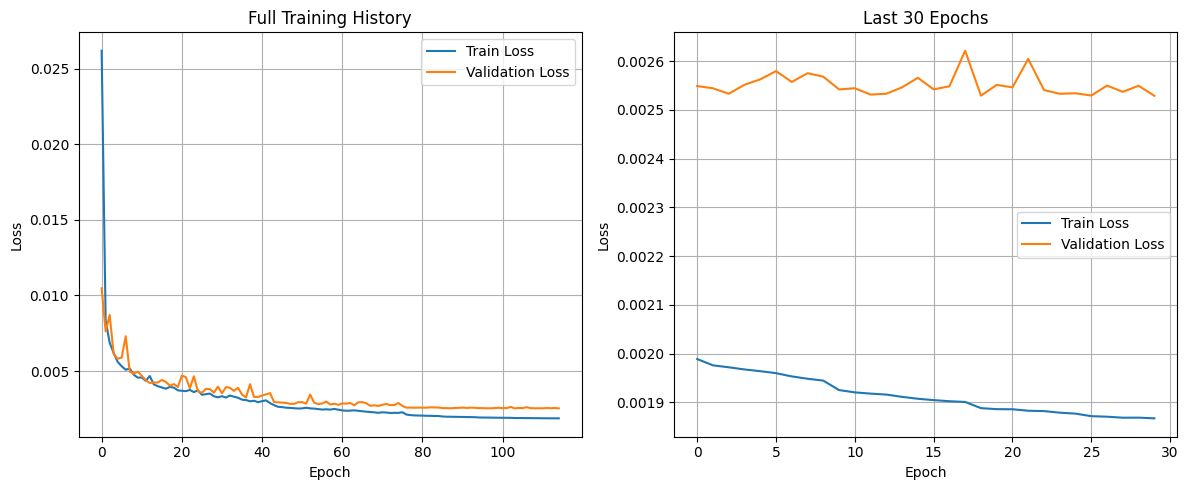


Training completed in 34.12 minutes
Best validation loss: 0.002529


In [23]:
# Run training if this cell is executed
if __name__ == "__main__":
   
    # Initialize model
    model = BaseAutoencoder(latent_dim=256)
    
    # Create configuration
    config = TrainingConfig(
    latent_dim=256,
    batch_size=8,              # Increased from 2 to 8
    accumulation_steps=8,      # Increased from 4 to 8 (effective batch size = 64)
    learning_rate=1e-4,
    epochs=200,
    early_stopping_patience=10,
    use_mixed_precision=True,
    num_workers=4,             # Increased from 2 to 4
    model_name="autoencoder_v1"
)
    
    # Train model
    print("\nStarting training...")
    train_losses, val_losses, trained_model = train_autoencoder(
        model, train_loader, val_loader, config
    )


### Evaluation and Result Visualization

In [27]:
# Cell 14: Model Evaluation and Visualization
import torch
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import json
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import seaborn as sns
from tqdm import tqdm

def load_trained_model(checkpoint_dir, model_name, latent_dim=256):
    """Load best trained model for evaluation"""
    model_path = Path(checkpoint_dir) / f"{model_name}_best.pth"
    metadata_path = Path(checkpoint_dir) / f"{model_name}_metadata.json"
    
    if not model_path.exists():
        # Try loading checkpoint if best model doesn't exist
        model_path = Path(checkpoint_dir) / f"{model_name}_checkpoint.pth"
        if not model_path.exists():
            raise FileNotFoundError(f"No model found at {model_path}")
        
        # Load from checkpoint
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        model = BaseAutoencoder(latent_dim=latent_dim)
        checkpoint = torch.load(model_path, map_location=device)
        model.load_state_dict(checkpoint['model_state_dict'])
    else:
        # Load best model
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        model = BaseAutoencoder(latent_dim=latent_dim)
        model.load_state_dict(torch.load(model_path, map_location=device))
    
    # Load training history
    if metadata_path.exists():
        with open(metadata_path, 'r') as f:
            metadata = json.load(f)
    else:
        metadata = {"train_losses": [], "val_losses": []}
    
    model.eval()
    model.to(device)
    
    return model, metadata

def plot_training_history(metadata):
    """Plot training and validation loss history"""
    plt.figure(figsize=(12, 5))
    
    train_losses = metadata["train_losses"]
    val_losses = metadata["val_losses"]
    
    # Plot full history
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Full Training History')
    plt.legend()
    plt.grid(True)
    
    # Plot recent history (last 30 epochs or all if < 30)
    plt.subplot(1, 2, 2)
    recent = min(30, len(train_losses))
    if recent > 5:  # Only plot recent history if we have enough epochs
        plt.plot(train_losses[-recent:], label='Train Loss')
        plt.plot(val_losses[-recent:], label='Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title(f'Last {recent} Epochs')
        plt.legend()
        plt.grid(True)
    
    plt.tight_layout()
    plt.show()

def visualize_reconstruction_samples(model, dataloader, num_samples=3):
    """Visualize original vs reconstructed volumes for samples from the dataset"""
    device = next(model.parameters()).device
    
    # Get samples from dataloader
    samples = []
    labels = []
    
    for batch in dataloader:
        volumes = batch['volume']
        batch_labels = batch['label']
        
        for i in range(min(len(volumes), num_samples - len(samples))):
            samples.append(volumes[i:i+1])
            labels.append(batch_labels[i])
            
        if len(samples) >= num_samples:
            break
    
    # Visualize each sample
    with torch.no_grad():
        for idx, (sample, label) in enumerate(zip(samples, labels)):
            # Get original volume
            orig_vol = sample.to(device)
            
            # Generate reconstruction
            reconstructed = model(orig_vol)
            
            # Move to CPU for visualization
            orig_vol = orig_vol.cpu().squeeze().numpy()
            recon_vol = reconstructed.cpu().squeeze().numpy()
            
            # Create figure for this sample
            fig = plt.figure(figsize=(15, 10))
            plt.suptitle(f"Sample {idx+1} - Group: {label}", fontsize=16)
            
            # Define slice indices (midpoint by default)
            z_slice = orig_vol.shape[0] // 2
            y_slice = orig_vol.shape[1] // 2
            x_slice = orig_vol.shape[2] // 2
            
            # Plot original slices
            plt.subplot(2, 3, 1)
            plt.imshow(orig_vol[z_slice], cmap='gray', vmin=0, vmax=3)
            plt.title("Original - Axial")
            plt.axis('off')
            
            plt.subplot(2, 3, 2)
            plt.imshow(orig_vol[:, y_slice, :], cmap='gray', vmin=0, vmax=3)
            plt.title("Original - Coronal")
            plt.axis('off')
            
            plt.subplot(2, 3, 3)
            plt.imshow(orig_vol[:, :, x_slice], cmap='gray', vmin=0, vmax=3)
            plt.title("Original - Sagittal")
            plt.axis('off')
            
            # Plot reconstructed slices
            plt.subplot(2, 3, 4)
            plt.imshow(recon_vol[z_slice], cmap='gray', vmin=0, vmax=3)
            plt.title("Reconstructed - Axial")
            plt.axis('off')
            
            plt.subplot(2, 3, 5)
            plt.imshow(recon_vol[:, y_slice, :], cmap='gray', vmin=0, vmax=3)
            plt.title("Reconstructed - Coronal")
            plt.axis('off')
            
            plt.subplot(2, 3, 6)
            plt.imshow(recon_vol[:, :, x_slice], cmap='gray', vmin=0, vmax=3)
            plt.title("Reconstructed - Sagittal")
            plt.axis('off')
            
            plt.tight_layout()
            plt.show()

def compute_reconstruction_error(model, dataloader):
    """Compute detailed reconstruction error metrics on validation set"""
    device = next(model.parameters()).device
    criterion = nn.MSELoss(reduction='none')
    
    total_mse = 0
    total_samples = 0
    error_by_label = {}
    
    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Computing metrics"):
            volumes = batch['volume'].to(device)
            labels = batch['label']
            
            # Get reconstructions
            reconstructed = model(volumes)
            
            # Compute MSE loss per sample
            mse = criterion(reconstructed, volumes)
            
            # Average over dimensions
            mse = mse.mean(dim=(1, 2, 3, 4)).cpu().numpy()
            
            # Track overall error
            total_mse += mse.sum()
            total_samples += volumes.shape[0]
            
            # Track error by label
            for i, label in enumerate(labels):
                if label not in error_by_label:
                    error_by_label[label] = []
                error_by_label[label].append(mse[i])
    
    # Calculate overall metrics
    avg_mse = total_mse / total_samples
    rmse = np.sqrt(avg_mse)
    
    print("\nReconstruction Error Metrics:")
    print(f"Overall MSE: {avg_mse:.6f}")
    print(f"Overall RMSE: {rmse:.6f}")
    
    # Calculate metrics by group
    print("\nReconstruction Error by Group:")
    for label, errors in error_by_label.items():
        group_mse = np.mean(errors)
        group_rmse = np.sqrt(group_mse)
        group_std = np.std(errors)
        print(f"{label}:")
        print(f"  MSE: {group_mse:.6f} ± {group_std:.6f}")
        print(f"  RMSE: {group_rmse:.6f}")
    
    # Plot error distribution by group
    plt.figure(figsize=(10, 6))
    for label, errors in error_by_label.items():
        plt.hist(errors, alpha=0.5, label=label, bins=20)
    
    plt.title("Reconstruction Error Distribution by Group")
    plt.xlabel("Mean Squared Error")
    plt.ylabel("Count")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
    
    return avg_mse, error_by_label

def extract_latent_vectors(model, dataloader, max_samples=None):
    """Extract latent vectors from all samples in the dataloader"""
    device = next(model.parameters()).device
    
    latent_vectors = []
    labels = []
    paths = []
    
    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Extracting latent vectors"):
            volumes = batch['volume'].to(device)
            batch_labels = batch['label']
            batch_paths = batch['path']
            
            # Extract latent vectors
            z = model.encode(volumes)
            
            # Store results
            latent_vectors.append(z.cpu().numpy())
            labels.extend(batch_labels)
            paths.extend(batch_paths)
            
            # Check if we have enough samples
            if max_samples and len(labels) >= max_samples:
                latent_vectors = np.vstack(latent_vectors)
                latent_vectors = latent_vectors[:max_samples]
                labels = labels[:max_samples]
                paths = paths[:max_samples]
                break
    
    # Stack all latent vectors if we didn't break early
    if isinstance(latent_vectors[0], np.ndarray):
        latent_vectors = np.vstack(latent_vectors)
    
    return latent_vectors, labels, paths

def visualize_latent_space(latent_vectors, labels, method='tsne'):
    """Visualize latent space using t-SNE or PCA"""
    plt.figure(figsize=(10, 8))
    
    # Create label-to-color mapping for consistent colors
    unique_labels = list(set(labels))
    colors = plt.cm.tab10(np.linspace(0, 1, len(unique_labels)))
    label_to_color = {label: colors[i] for i, label in enumerate(unique_labels)}
    
    # Apply dimensionality reduction
    if method.lower() == 'tsne':
        print("Computing t-SNE projection...")
        reducer = TSNE(n_components=2, random_state=42, perplexity=min(30, len(latent_vectors) - 1))
        title = 't-SNE Visualization of Latent Space'
    else:
        print("Computing PCA projection...")
        reducer = PCA(n_components=2, random_state=42)
        title = 'PCA Visualization of Latent Space'
    
    # Apply reduction
    reduced_vecs = reducer.fit_transform(latent_vectors)
    
    # Create scatter plot
    for label in unique_labels:
        # Get indices where this label appears
        indices = [i for i, l in enumerate(labels) if l == label]
        
        # Plot these points
        plt.scatter(
            reduced_vecs[indices, 0], 
            reduced_vecs[indices, 1],
            label=label, 
            color=label_to_color[label], 
            alpha=0.7,
            edgecolor='w',
            s=100
        )
    
    plt.title(title, fontsize=14)
    plt.xlabel("Dimension 1", fontsize=12)
    plt.ylabel("Dimension 2", fontsize=12)
    plt.legend(title="Group", fontsize=10)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    return reduced_vecs

def plot_latent_dimension_activation(latent_vectors, labels):
    """Analyze activation patterns of latent dimensions"""
    # Create a DataFrame with latent dimensions and labels
    import pandas as pd
    
    # First, convert labels to categorical for better plotting
    unique_labels = list(set(labels))
    label_map = {label: i for i, label in enumerate(unique_labels)}
    label_indices = [label_map[label] for label in labels]
    
    # Create DataFrames
    latent_df = pd.DataFrame(latent_vectors)
    latent_df['label'] = labels
    
    # Compute mean activation by group
    mean_activations = {}
    for label in unique_labels:
        group_vectors = latent_vectors[np.array(labels) == label]
        mean_activations[label] = np.mean(group_vectors, axis=0)
    
    # Identify top discriminative dimensions
    activation_matrix = np.vstack([mean_activations[label] for label in unique_labels])
    variance = np.var(activation_matrix, axis=0)
    top_dims = np.argsort(variance)[-10:]  # Top 10 dimensions
    
    # Plot mean activation for top dimensions
    plt.figure(figsize=(14, 6))
    
    # Plot heatmap
    plt.subplot(1, 2, 1)
    heatmap_data = pd.DataFrame({
        f"Dim {i}": [mean_activations[label][i] for label in unique_labels]
        for i in top_dims
    })
    heatmap_data.index = unique_labels
    
    sns.heatmap(heatmap_data, cmap='coolwarm', center=0, 
               annot=True, fmt=".2f", cbar_kws={'label': 'Mean Activation'})
    plt.title("Mean Activation of Top Discriminative Dimensions")
    
    # Plot box plots for top 5 dimensions
    plt.subplot(1, 2, 2)
    
    # Create data for boxplot
    plot_data = []
    labels_for_plot = []
    positions = []
    
    for i, dim in enumerate(top_dims[:5]):  # Top 5 for clarity
        for j, label in enumerate(unique_labels):
            group_values = latent_vectors[np.array(labels) == label, dim]
            plot_data.append(group_values)
            labels_for_plot.append(f"{label}")
            positions.append(i + j * 0.25)
    
    # Create boxplot
    boxplot = plt.boxplot(plot_data, positions=positions, patch_artist=True, widths=0.15)
    
    # Customize boxplot colors
    colors = plt.cm.tab10(np.linspace(0, 1, len(unique_labels)))
    for i, label in enumerate(unique_labels):
        indices = [j for j, l in enumerate(labels_for_plot) if l == label]
        for idx in indices:
            boxplot['boxes'][idx].set_facecolor(colors[i])
    
    # Add labels and ticks
    plt.xticks([i + (len(unique_labels) - 1) * 0.125 for i in range(5)], 
              [f"Dim {d}" for d in top_dims[:5]])
    plt.title("Distribution of Top 5 Discriminative Dimensions")
    plt.ylabel("Activation Value")
    
    # Add legend
    for i, label in enumerate(unique_labels):
        plt.plot([], [], 'o', color=colors[i], label=label)
    plt.legend(title="Group")
    
    plt.tight_layout()
    plt.show()
    
    return top_dims

def find_outliers(model, dataloader, threshold_std=2.5):
    """Identify outliers based on reconstruction error"""
    device = next(model.parameters()).device
    criterion = nn.MSELoss(reduction='none')
    
    all_errors = []
    all_paths = []
    all_labels = []
    
    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Finding outliers"):
            volumes = batch['volume'].to(device)
            paths = batch['path']
            labels = batch['label']
            
            # Get reconstructions
            reconstructed = model(volumes)
            
            # Compute MSE loss per sample
            mse = criterion(reconstructed, volumes)
            
            # Average over dimensions
            mse = mse.mean(dim=(1, 2, 3, 4)).cpu().numpy()
            
            # Store results
            all_errors.extend(mse)
            all_paths.extend(paths)
            all_labels.extend(labels)
    
    # Convert to numpy arrays
    all_errors = np.array(all_errors)
    
    # Compute statistics
    mean_error = np.mean(all_errors)
    std_error = np.std(all_errors)
    
    # Find outliers (samples with error > mean + threshold_std * std)
    threshold = mean_error + threshold_std * std_error
    outlier_indices = np.where(all_errors > threshold)[0]
    
    print(f"\nOutlier Analysis:")
    print(f"Mean error: {mean_error:.6f}")
    print(f"Error standard deviation: {std_error:.6f}")
    print(f"Outlier threshold: {threshold:.6f}")
    print(f"Found {len(outlier_indices)} outliers out of {len(all_errors)} samples ({len(outlier_indices)/len(all_errors)*100:.2f}%)")
    
    # Create dictionary of outliers
    outliers = {
        all_paths[i]: {
            'error': all_errors[i],
            'label': all_labels[i],
            'z_score': (all_errors[i] - mean_error) / std_error
        }
        for i in outlier_indices
    }
    
    # Plot error distribution with outlier threshold
    plt.figure(figsize=(10, 6))
    plt.hist(all_errors, bins=30, alpha=0.7)
    plt.axvline(threshold, color='r', linestyle='--', label=f'Threshold ({threshold_std} std)')
    plt.title("Reconstruction Error Distribution")
    plt.xlabel("Mean Squared Error")
    plt.ylabel("Count")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
    
    return outliers, all_errors, all_paths, all_labels

def visualize_outliers(model, outliers, threshold=0.01):
    """Visualize the top outliers with highest reconstruction error"""
    device = next(model.parameters()).device
    
    # Sort outliers by error (descending)
    sorted_outliers = sorted(outliers.items(), key=lambda x: x[1]['error'], reverse=True)
    
    # Visualize top outliers
    num_outliers = min(5, len(sorted_outliers))
    
    for i in range(num_outliers):
        path, info = sorted_outliers[i]
        error = info['error']
        label = info['label']
        z_score = info['z_score']
        
        try:
            # Load the original volume
            with torch.no_grad():
                # Load DICOM file
                original_volume, _ = load_dicom(path)
                original_volume = original_volume[9:73, :, :]
                
                # Process volume
                norm_vol, _, _ = process_volume(original_volume, target_shape=(64, 128, 128))
                
                # Convert to tensor and add batch dimension
                vol_tensor = torch.from_numpy(np.expand_dims(norm_vol, axis=(0, 1))).float().to(device)
                
                # Get reconstruction
                reconstructed = model(vol_tensor)
                
                # Move tensors to CPU and remove batch and channel dimensions
                vol_np = vol_tensor.cpu().squeeze().numpy()
                recon_np = reconstructed.cpu().squeeze().numpy()
                
                # Create figure
                fig = plt.figure(figsize=(15, 10))
                plt.suptitle(f"Outlier {i+1}: {path.split('/')[-1]}\nGroup: {label}, Error: {error:.6f}, Z-score: {z_score:.2f}", fontsize=14)
                
                # Define slice indices
                z_slice = vol_np.shape[0] // 2
                y_slice = vol_np.shape[1] // 2
                x_slice = vol_np.shape[2] // 2
                
                # Plot original axial slice
                plt.subplot(2, 3, 1)
                plt.imshow(vol_np[z_slice], cmap='gray', vmin=0, vmax=3)
                plt.title("Original - Axial")
                plt.axis('off')
                
                # Plot original coronal slice
                plt.subplot(2, 3, 2)
                plt.imshow(vol_np[:, y_slice, :], cmap='gray', vmin=0, vmax=3)
                plt.title("Original - Coronal")
                plt.axis('off')
                
                # Plot original sagittal slice
                plt.subplot(2, 3, 3)
                plt.imshow(vol_np[:, :, x_slice], cmap='gray', vmin=0, vmax=3)
                plt.title("Original - Sagittal")
                plt.axis('off')
                
                # Plot reconstructed axial slice
                plt.subplot(2, 3, 4)
                plt.imshow(recon_np[z_slice], cmap='gray', vmin=0, vmax=3)
                plt.title("Reconstructed - Axial")
                plt.axis('off')
                
                # Plot reconstructed coronal slice
                plt.subplot(2, 3, 5)
                plt.imshow(recon_np[:, y_slice, :], cmap='gray', vmin=0, vmax=3)
                plt.title("Reconstructed - Coronal")
                plt.axis('off')
                
                # Plot reconstructed sagittal slice
                plt.subplot(2, 3, 6)
                plt.imshow(recon_np[:, :, x_slice], cmap='gray', vmin=0, vmax=3)
                plt.title("Reconstructed - Sagittal")
                plt.axis('off')
                
                plt.tight_layout()
                plt.show()
                
        except Exception as e:
            print(f"Error visualizing outlier {path}: {e}")

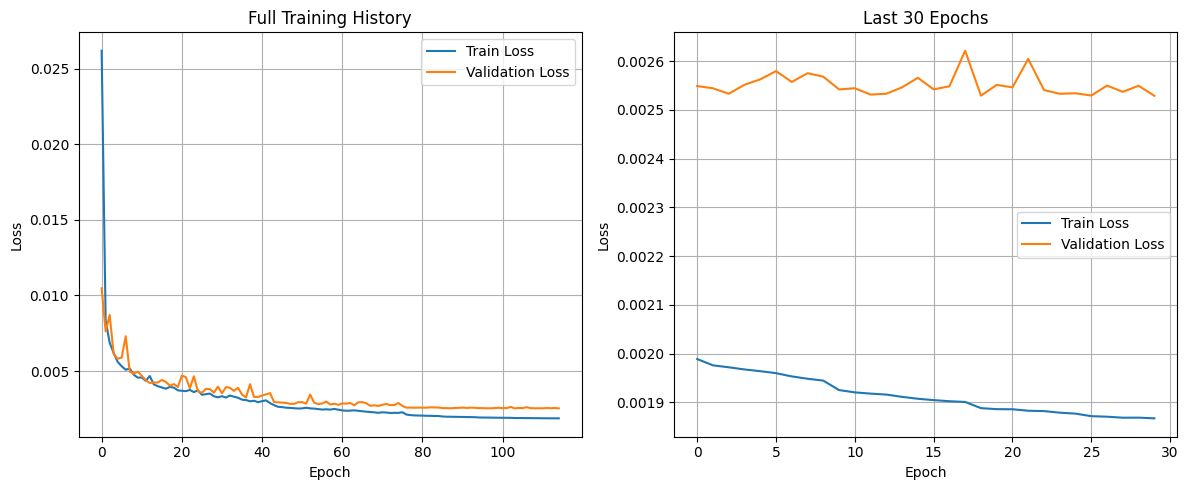

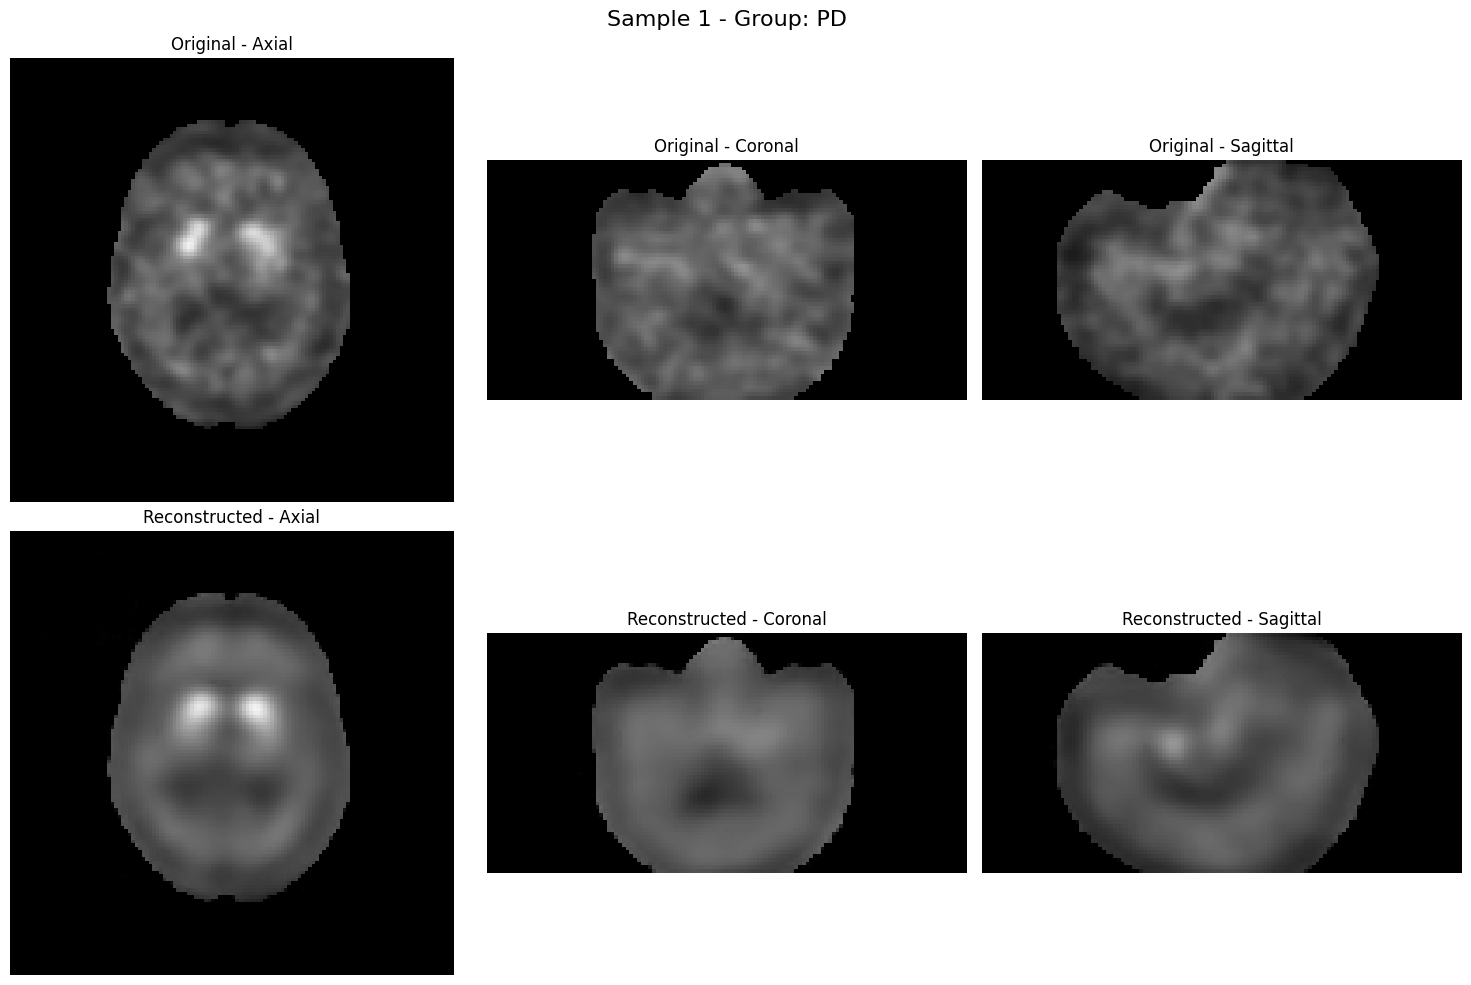

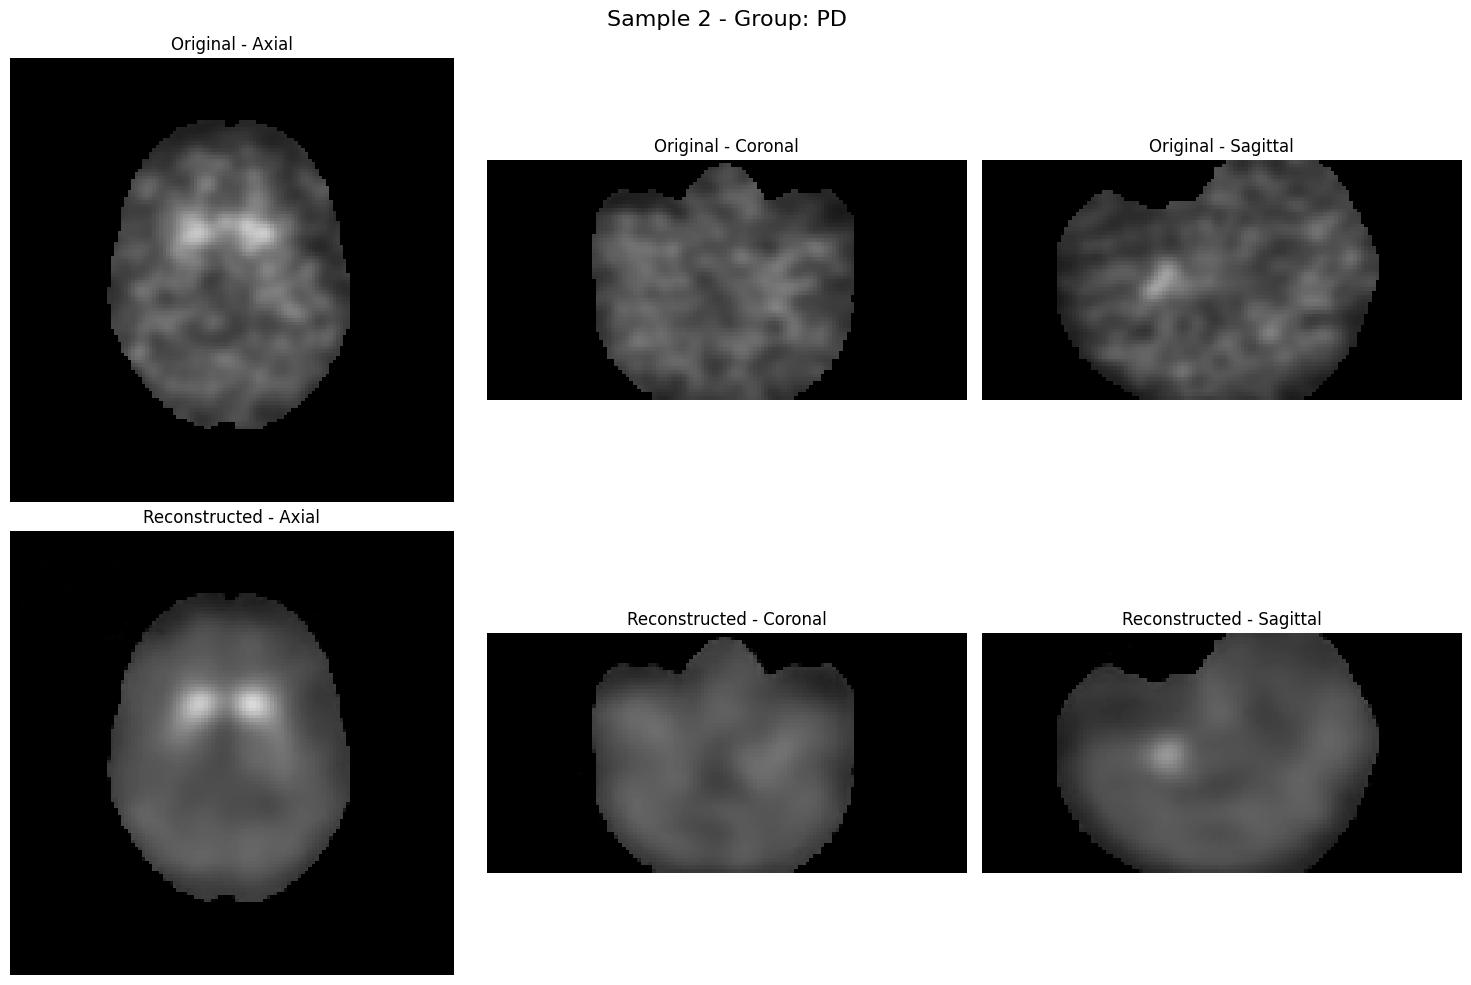

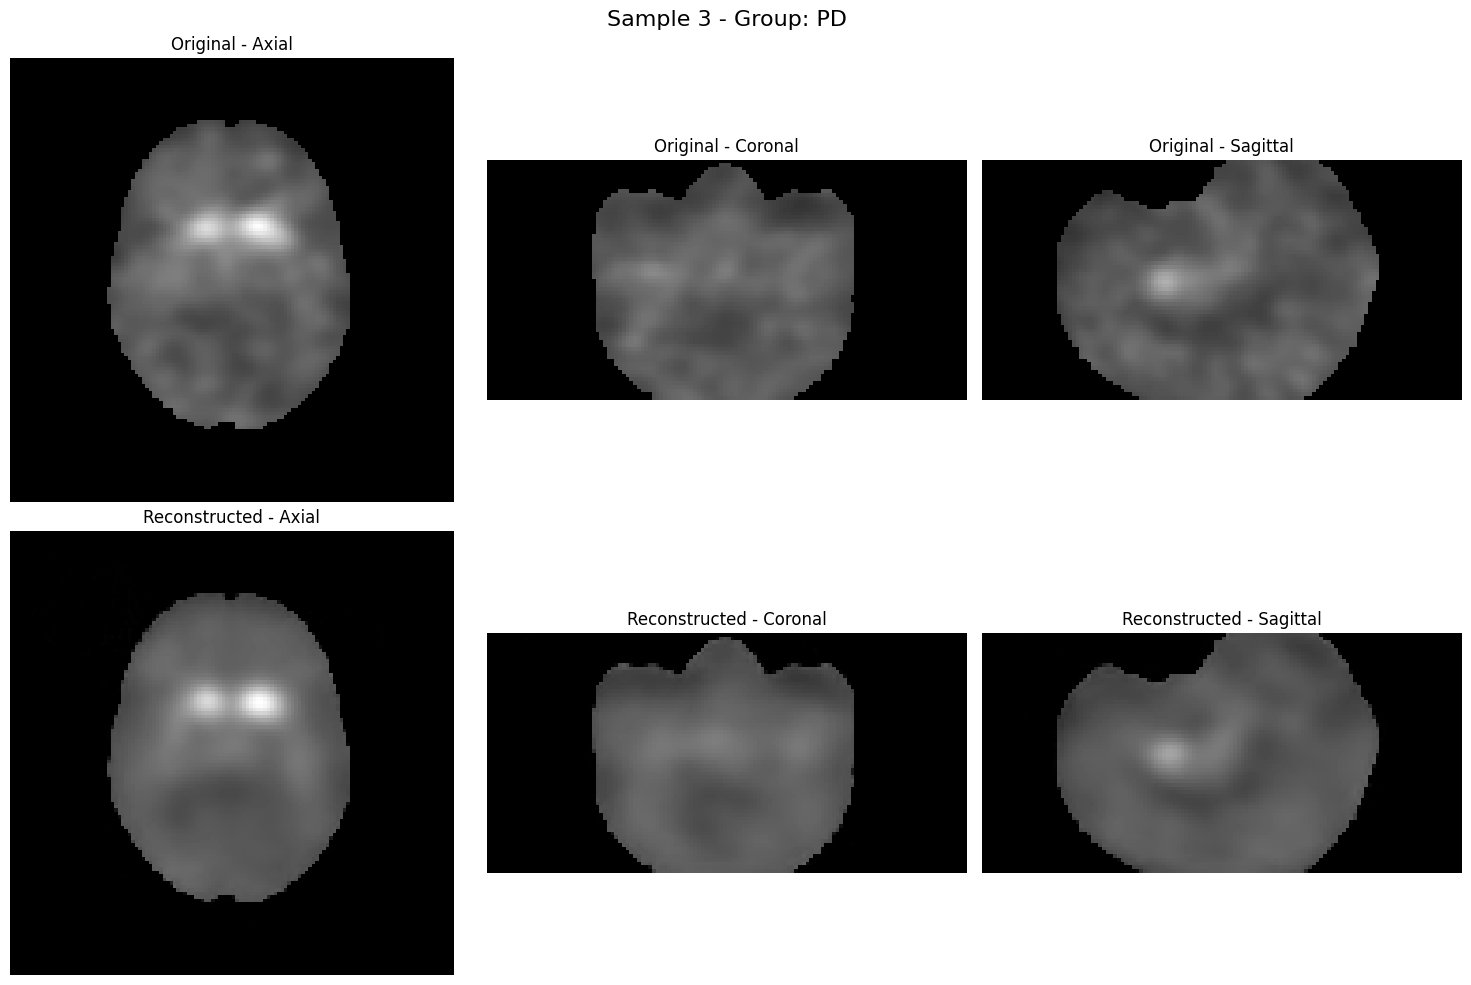

Computing metrics:   4%|▍         | 12/299 [00:00<00:14, 19.33it/s]

Error processing file Images/PPMI_Images_PD/3863/Reconstructed_DaTSCAN/2013-03-13_13_29_21.0/I449248/PPMI_3863_NM_Reconstructed_DaTSCAN_Br_20141022165646607_1_S202944_I449248.dcm: operands could not be broadcast together with shapes (60,128,128) (91,109,91) 


Computing metrics:  21%|██        | 62/299 [00:03<00:12, 19.12it/s]

Error processing file Images/PPMI_Images_PD/3179/Reconstructed_DaTSCAN/2016-08-18_13_51_47.0/I1317564/PPMI_3179_NM_Reconstructed_DaTSCAN_Br_20200616100643787_1_S550153_I1317564.dcm: operands could not be broadcast together with shapes (480,128,128) (91,109,91) 


Computing metrics:  48%|████▊     | 145/299 [00:07<00:07, 21.00it/s]

Error processing file Images/PPMI_Images_PD/101281/Reconstructed_DaTSCAN/2021-04-13_13_45_25.0/I1474392/PPMI_101281_NM_Reconstructed_DaTSCAN_Br_20210727201856600_1_S1046857_I1474392.dcm: operands could not be broadcast together with shapes (48,128,128) (91,109,91) 


Computing metrics: 100%|██████████| 299/299 [00:18<00:00, 16.44it/s]



Reconstruction Error Metrics:
Overall MSE: 0.002529
Overall RMSE: 0.050288

Reconstruction Error by Group:
PD:
  MSE: 0.002478 ± 0.001453
  RMSE: 0.049777
Control:
  MSE: 0.002993 ± 0.001062
  RMSE: 0.054708
SWEDD:
  MSE: 0.002484 ± 0.001289
  RMSE: 0.049837


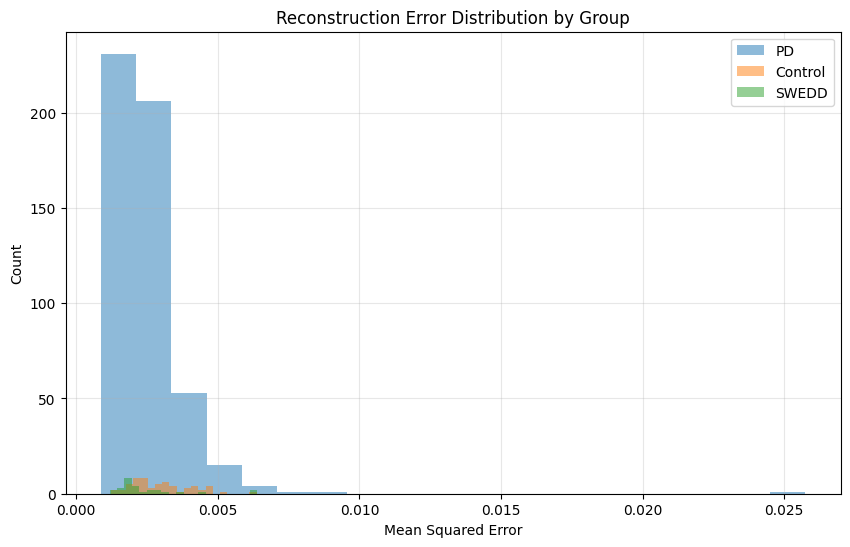

Extracting latent vectors:   4%|▍         | 13/299 [00:00<00:15, 18.11it/s]

Error processing file Images/PPMI_Images_PD/3863/Reconstructed_DaTSCAN/2013-03-13_13_29_21.0/I449248/PPMI_3863_NM_Reconstructed_DaTSCAN_Br_20141022165646607_1_S202944_I449248.dcm: operands could not be broadcast together with shapes (60,128,128) (91,109,91) 


Extracting latent vectors:  21%|██        | 63/299 [00:03<00:12, 19.22it/s]

Error processing file Images/PPMI_Images_PD/3179/Reconstructed_DaTSCAN/2016-08-18_13_51_47.0/I1317564/PPMI_3179_NM_Reconstructed_DaTSCAN_Br_20200616100643787_1_S550153_I1317564.dcm: operands could not be broadcast together with shapes (480,128,128) (91,109,91) 


Extracting latent vectors:  33%|███▎      | 99/299 [00:05<00:10, 18.80it/s]


Computing t-SNE projection...


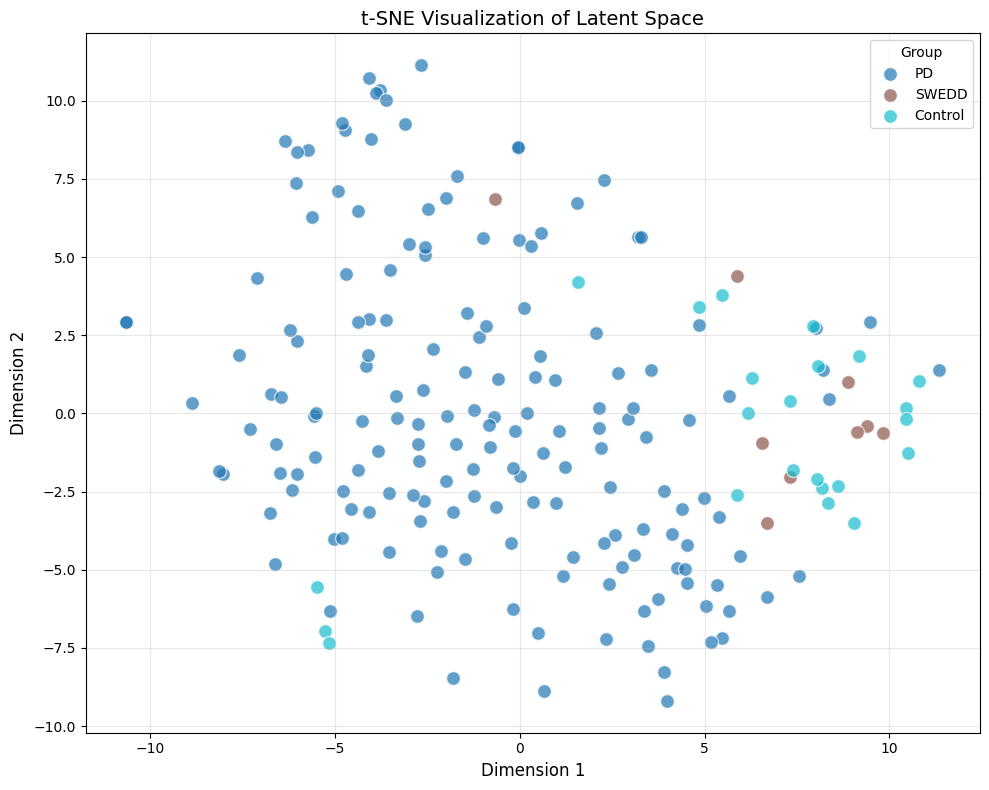

Computing PCA projection...


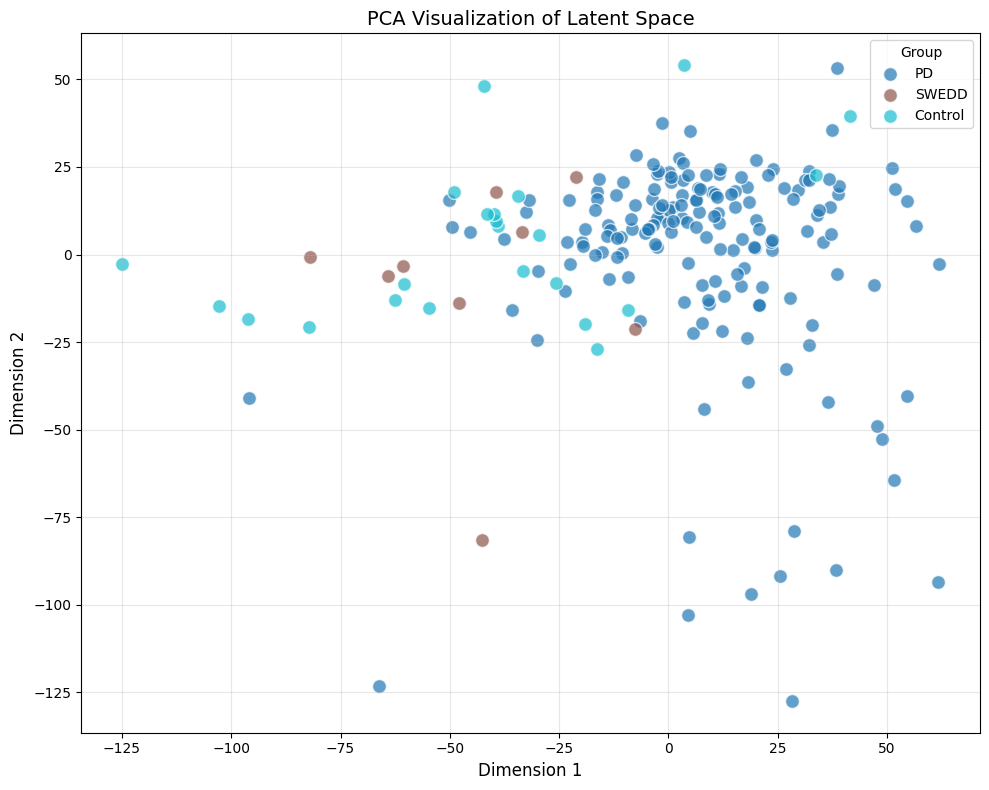

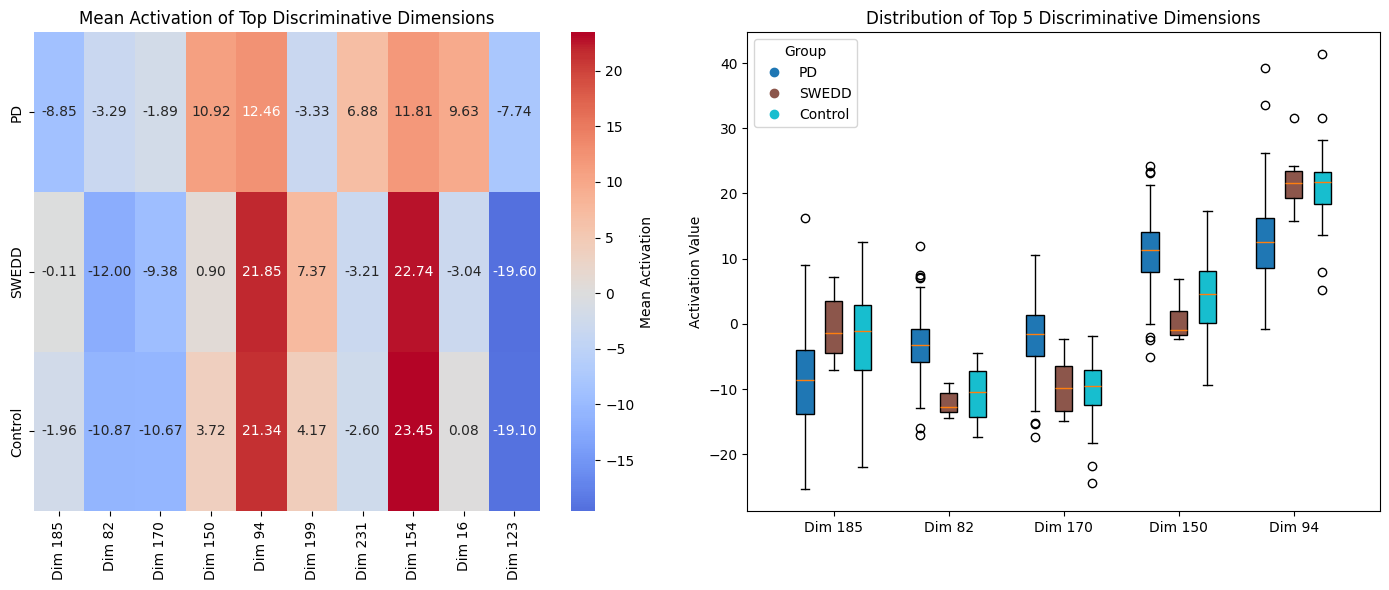

Finding outliers:   4%|▎         | 11/299 [00:00<00:14, 20.23it/s]

Error processing file Images/PPMI_Images_PD/3863/Reconstructed_DaTSCAN/2013-03-13_13_29_21.0/I449248/PPMI_3863_NM_Reconstructed_DaTSCAN_Br_20141022165646607_1_S202944_I449248.dcm: operands could not be broadcast together with shapes (60,128,128) (91,109,91) 


Finding outliers:  21%|██        | 63/299 [00:03<00:11, 20.80it/s]

Error processing file Images/PPMI_Images_PD/3179/Reconstructed_DaTSCAN/2016-08-18_13_51_47.0/I1317564/PPMI_3179_NM_Reconstructed_DaTSCAN_Br_20200616100643787_1_S550153_I1317564.dcm: operands could not be broadcast together with shapes (480,128,128) (91,109,91) 


Finding outliers:  49%|████▉     | 147/299 [00:07<00:08, 18.93it/s]

Error processing file Images/PPMI_Images_PD/101281/Reconstructed_DaTSCAN/2021-04-13_13_45_25.0/I1474392/PPMI_101281_NM_Reconstructed_DaTSCAN_Br_20210727201856600_1_S1046857_I1474392.dcm: operands could not be broadcast together with shapes (48,128,128) (91,109,91) 


Finding outliers: 100%|██████████| 299/299 [00:15<00:00, 19.76it/s]



Outlier Analysis:
Mean error: 0.002529
Error standard deviation: 0.001420
Outlier threshold: 0.006079
Found 10 outliers out of 598 samples (1.67%)


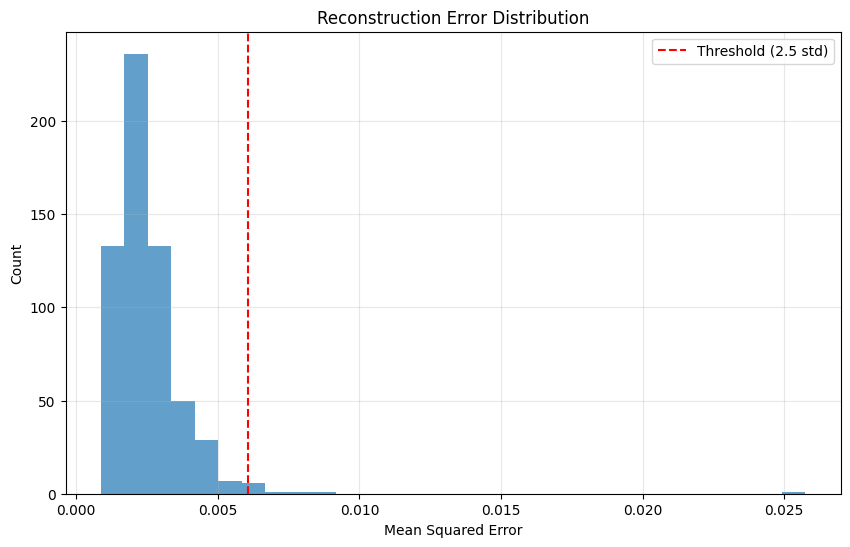

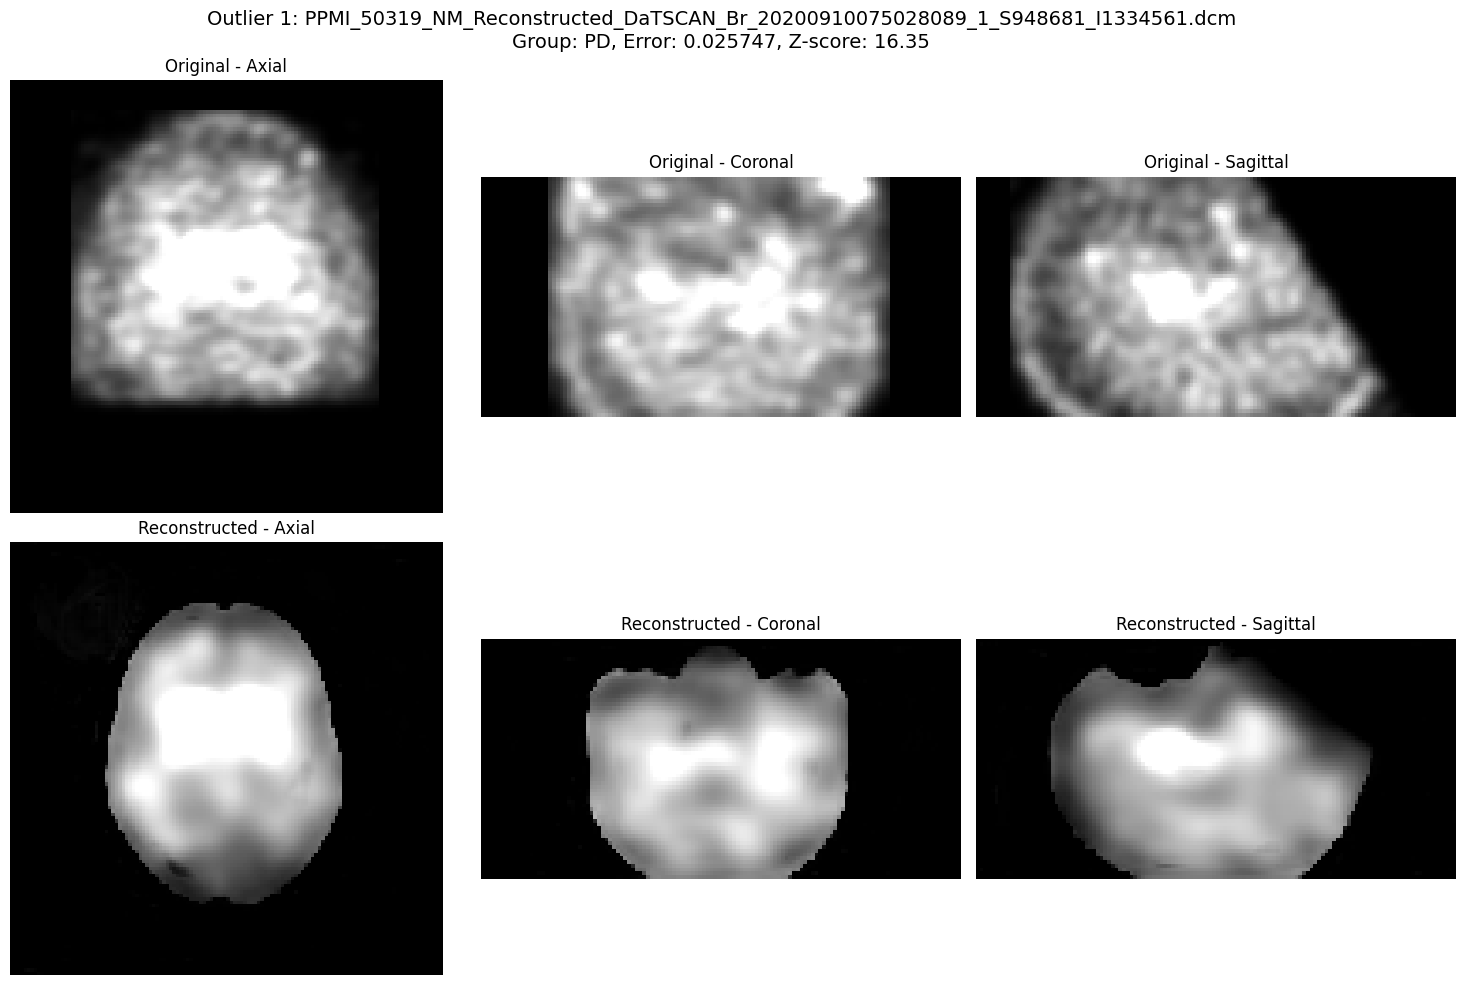

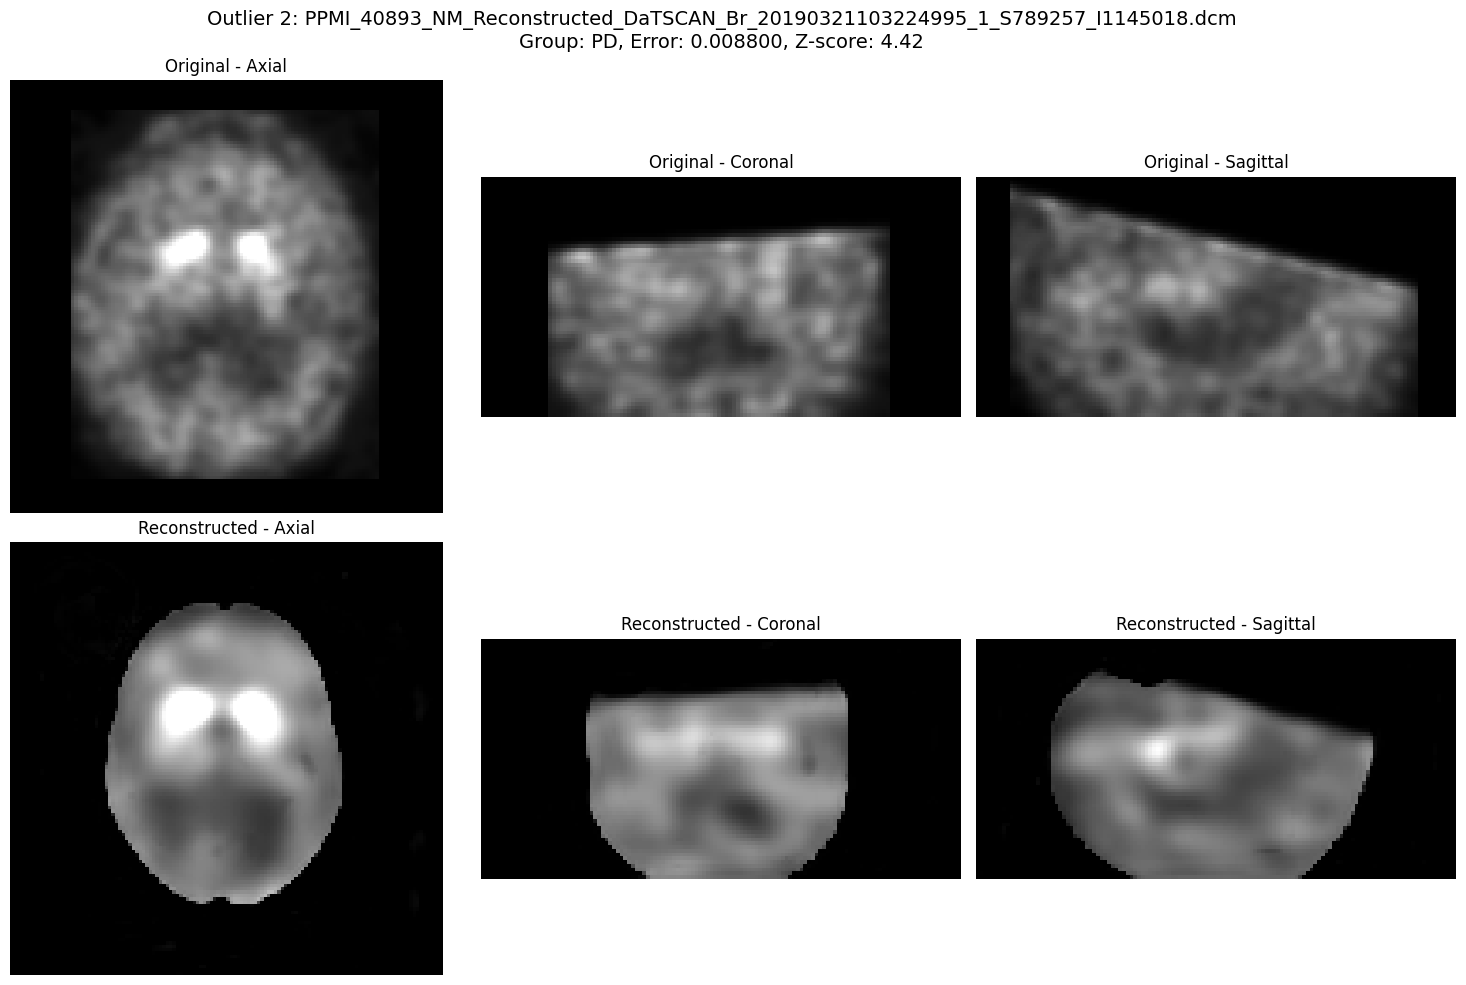

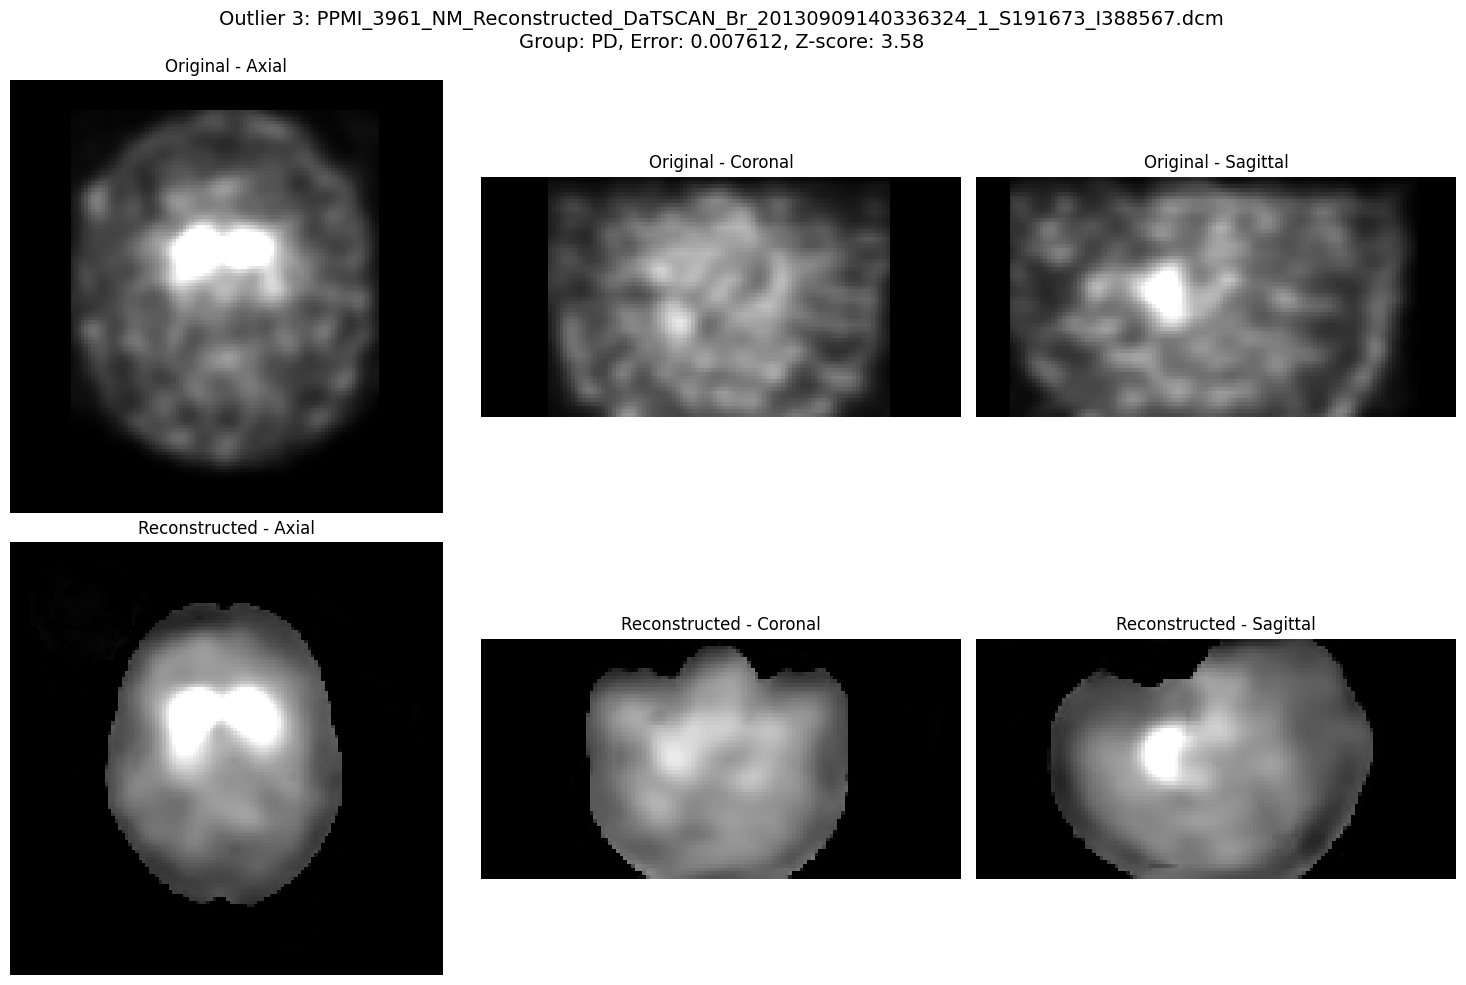

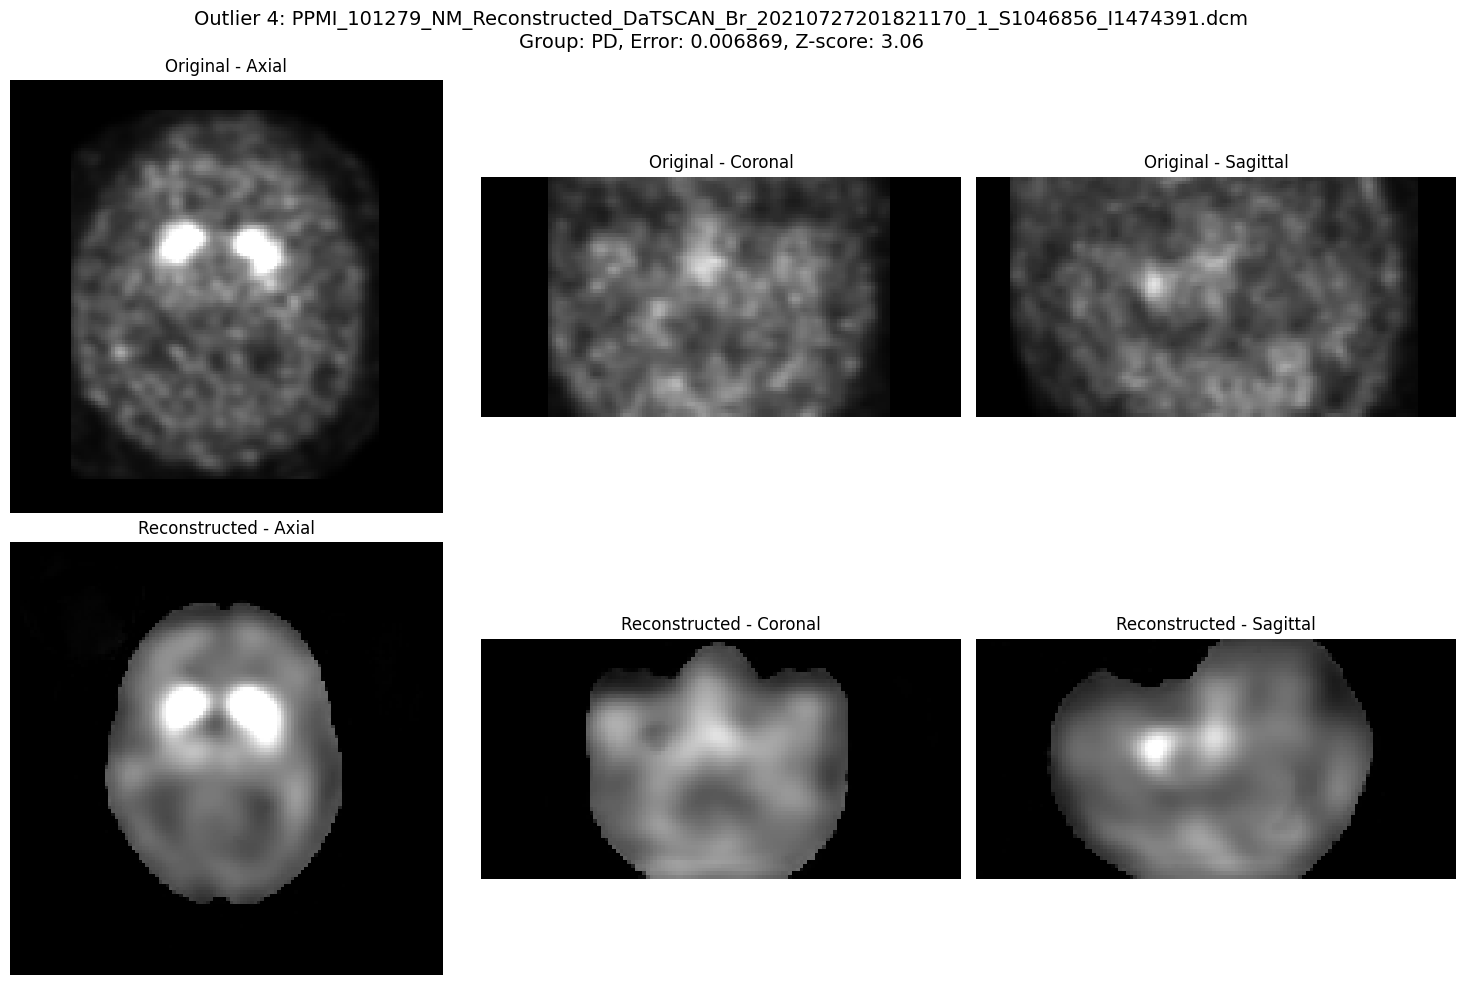

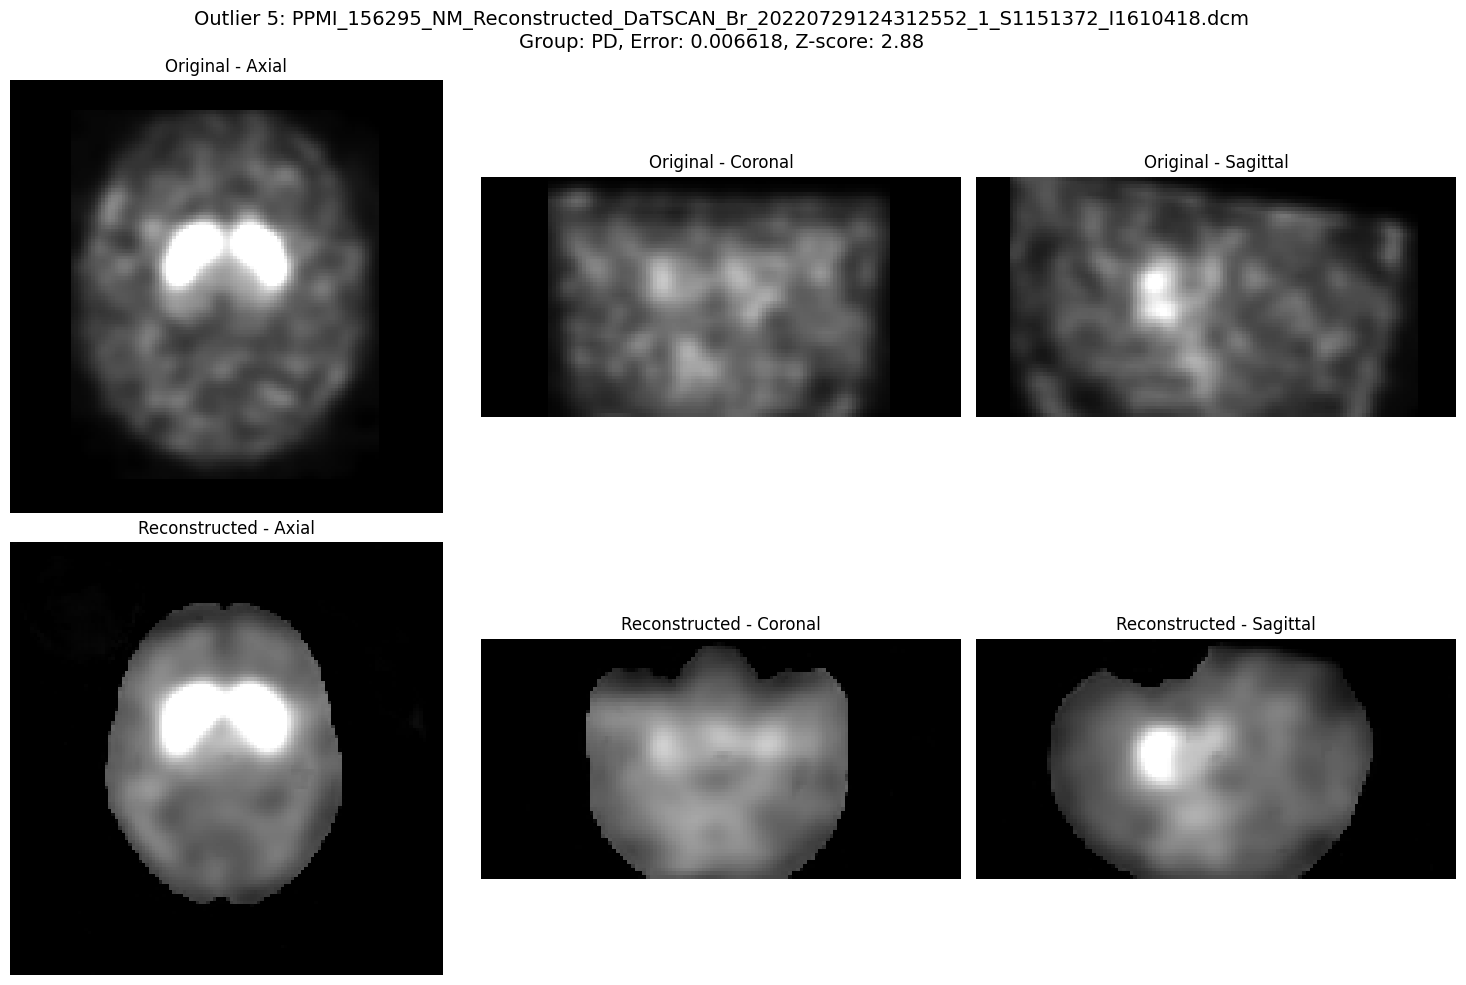

In [25]:
# Run evaluation if this cell is executed
if __name__ == "__main__":
    # Uncomment the following to run evaluation

    # Load model and metadata
    model, metadata = load_trained_model('checkpoints', 'autoencoder_v1', latent_dim=256)
    
    # Plot training history
    plot_training_history(metadata)
    
    # Visualize reconstructions
    visualize_reconstruction_samples(model, val_loader, num_samples=3)
    
    # Compute reconstruction error
    avg_mse, error_by_label = compute_reconstruction_error(model, val_loader)
    
    # Extract and visualize latent space
    latent_vectors, labels, paths = extract_latent_vectors(model, val_loader, max_samples=200)
    reduced_vecs = visualize_latent_space(latent_vectors, labels, method='tsne')
    reduced_vecs = visualize_latent_space(latent_vectors, labels, method='pca')
    
    # Analyze latent dimensions
    top_dims = plot_latent_dimension_activation(latent_vectors, labels)
    
    # Find and visualize outliers
    outliers, all_errors, all_paths, all_labels = find_outliers(model, val_loader, threshold_std=2.5)
    visualize_outliers(model, outliers)

In [28]:
# Cell 15: Visualizing Latent Dimensions in Brain Space
import torch
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LinearSegmentedColormap
import torch.nn.functional as F

def visualize_latent_dimension(model, dataloader, dimension_idx, alpha=5.0, group=None):
    """
    Visualize what a specific latent dimension represents by modifying it
    and observing the effect on brain reconstruction.
    
    Parameters:
        model: Trained autoencoder model
        dataloader: DataLoader containing samples
        dimension_idx: The latent dimension to manipulate (e.g., 231)
        alpha: Strength of the dimension manipulation
        group: Optional filter for specific patient group (e.g., 'PD', 'Control')
    """
    device = next(model.parameters()).device
    model.eval()
    
    # Find a suitable sample (optionally from specific group)
    for batch in dataloader:
        volumes = batch['volume']
        labels = batch['label']
        paths = batch['path']
        
        if group is not None:
            # Find samples from the specified group
            group_indices = [i for i, label in enumerate(labels) if label == group]
            if not group_indices:
                continue
            # Use the first matching sample
            idx = group_indices[0]
            sample = volumes[idx:idx+1].to(device)
            sample_label = labels[idx]
            sample_path = paths[idx]
        else:
            # Just use the first sample
            sample = volumes[0:1].to(device)
            sample_label = labels[0]
            sample_path = paths[0]
        
        break  # Exit after finding a sample
    
    with torch.no_grad():
        # Encode the sample to get its latent representation
        z = model.encode(sample)
        
        # Create modified latent vectors
        z_plus = z.clone()
        z_minus = z.clone()
        
        # Modify the specific dimension
        z_plus[0, dimension_idx] += alpha
        z_minus[0, dimension_idx] -= alpha
        
        # Decode the original and modified latent vectors
        original_reconstruction = model.decode(z)
        plus_reconstruction = model.decode(z_plus)
        minus_reconstruction = model.decode(z_minus)
        
        # Move tensors to CPU and convert to numpy for visualization
        original_vol = original_reconstruction.cpu().squeeze().numpy()
        plus_vol = plus_reconstruction.cpu().squeeze().numpy()
        minus_vol = minus_reconstruction.cpu().squeeze().numpy()
        
        # Calculate the difference maps
        plus_diff = plus_vol - original_vol
        minus_diff = minus_vol - original_vol
        
        # Set up the figure
        fig = plt.figure(figsize=(18, 15))
        plt.suptitle(f"Visualization of Dimension {dimension_idx} in Brain Space\nPatient Group: {sample_label}", fontsize=16)
        
        # Define slice indices for visualization
        z_indices = [original_vol.shape[0]//4, original_vol.shape[0]//2, 3*original_vol.shape[0]//4]
        y_indices = [original_vol.shape[1]//2]
        x_indices = [original_vol.shape[2]//2]
        
        # Create a custom colormap for difference maps
        diff_cmap = LinearSegmentedColormap.from_list('diff_cmap', ['blue', 'lightgray', 'red'], N=256)
        
        # Plot the axial slices
        for i, z_idx in enumerate(z_indices):
            # Original reconstruction
            ax = plt.subplot(5, 3, i+1)
            plt.imshow(original_vol[z_idx], cmap='gray')
            plt.title(f"Original (Axial z={z_idx})" if i == 0 else f"Axial z={z_idx}")
            plt.axis('off')
            
            # Increased dimension
            ax = plt.subplot(5, 3, i+4)
            plt.imshow(plus_vol[z_idx], cmap='gray')
            plt.title(f"Dim {dimension_idx} + {alpha}" if i == 0 else "")
            plt.axis('off')
            
            # Decreased dimension
            ax = plt.subplot(5, 3, i+7)
            plt.imshow(minus_vol[z_idx], cmap='gray')
            plt.title(f"Dim {dimension_idx} - {alpha}" if i == 0 else "")
            plt.axis('off')
            
            # Difference map (increased - original)
            ax = plt.subplot(5, 3, i+10)
            im = plt.imshow(plus_diff[z_idx], cmap=diff_cmap, vmin=-0.5, vmax=0.5)
            plt.title(f"Difference (+)" if i == 0 else "")
            plt.axis('off')
            
            # Difference map (decreased - original)
            ax = plt.subplot(5, 3, i+13)
            plt.imshow(minus_diff[z_idx], cmap=diff_cmap, vmin=-0.5, vmax=0.5)
            plt.title(f"Difference (-)" if i == 0 else "")
            plt.axis('off')
        
        # Add colorbar for difference maps
        cbar_ax = fig.add_axes([0.93, 0.15, 0.02, 0.3])
        cbar = plt.colorbar(im, cax=cbar_ax)
        cbar.set_label('Difference Intensity')
        
        plt.tight_layout()
        plt.subplots_adjust(top=0.92, right=0.9)
        plt.show()
        
        # Return both the sample info and reconstructions for further analysis
        return {
            'label': sample_label,
            'path': sample_path,
            'original': original_vol,
            'plus': plus_vol,
            'minus': minus_vol,
            'plus_diff': plus_diff,
            'minus_diff': minus_diff
        }

def explore_top_dimensions(model, dataloader, dimensions, groups=None):
    """
    Explore the top discriminative dimensions across different patient groups.
    
    Parameters:
        model: Trained autoencoder model
        dataloader: DataLoader containing samples
        dimensions: List of dimension indices to explore
        groups: List of groups to include (default is all groups)
    """
    if groups is None:
        # Get all unique groups from the first batch
        for batch in dataloader:
            groups = list(set(batch['label']))
            break
    
    for dimension in dimensions:
        print(f"\n{'='*80}")
        print(f"Exploring Dimension {dimension}")
        print(f"{'='*80}")
        
        for group in groups:
            print(f"\nVisualizing for group: {group}")
            results = visualize_latent_dimension(model, dataloader, dimension, alpha=8.0, group=group)
            
            # Optional: compute statistics about the affected regions
            plus_diff = results['plus_diff']
            minus_diff = results['minus_diff']
            
            # Calculate the average absolute effect size
            mean_effect = (np.mean(np.abs(plus_diff)) + np.mean(np.abs(minus_diff))) / 2
            
            # Find the regions most affected (top 5% of voxels)
            top_voxels_plus = np.percentile(np.abs(plus_diff), 95)
            top_voxels_minus = np.percentile(np.abs(minus_diff), 95)
            
            print(f"  Mean effect size: {mean_effect:.5f}")
            print(f"  Top 5% threshold: +{top_voxels_plus:.5f}, -{top_voxels_minus:.5f}")
            
            # Optional: Add a small delay for better visualization
            import time
            time.sleep(1)

def generate_feature_importance_map(model, dataloader, dimension_idx, group=None, num_samples=5):
    """
    Generate a more robust feature importance map for a specific dimension
    by aggregating effects across multiple samples.
    
    Parameters:
        model: Trained autoencoder model
        dataloader: DataLoader containing samples
        dimension_idx: The latent dimension to analyze
        group: Optional filter for specific patient group
        num_samples: Number of samples to aggregate
    """
    device = next(model.parameters()).device
    model.eval()
    
    # Storage for aggregated results
    aggregated_plus_diff = None
    aggregated_minus_diff = None
    sample_count = 0
    
    # Find samples (optionally from specific group)
    for batch in dataloader:
        volumes = batch['volume']
        labels = batch['label']
        
        if group is not None:
            # Find samples from the specified group
            group_indices = [i for i, label in enumerate(labels) if label == group]
            indices = group_indices
        else:
            # Use all samples in batch
            indices = range(len(volumes))
        
        for idx in indices:
            if sample_count >= num_samples:
                break
                
            sample = volumes[idx:idx+1].to(device)
            
            with torch.no_grad():
                # Encode the sample
                z = model.encode(sample)
                
                # Create modified latent vectors
                z_plus = z.clone()
                z_minus = z.clone()
                
                # Modify the specific dimension
                z_plus[0, dimension_idx] += 5.0
                z_minus[0, dimension_idx] -= 5.0
                
                # Decode the vectors
                original_reconstruction = model.decode(z)
                plus_reconstruction = model.decode(z_plus)
                minus_reconstruction = model.decode(z_minus)
                
                # Calculate the difference maps
                plus_diff = (plus_reconstruction - original_reconstruction).cpu().squeeze().numpy()
                minus_diff = (minus_reconstruction - original_reconstruction).cpu().squeeze().numpy()
                
                # Aggregate the difference maps
                if aggregated_plus_diff is None:
                    aggregated_plus_diff = plus_diff
                    aggregated_minus_diff = minus_diff
                else:
                    aggregated_plus_diff += plus_diff
                    aggregated_minus_diff += minus_diff
                
                sample_count += 1
        
        if sample_count >= num_samples:
            break
    
    # Average the difference maps
    aggregated_plus_diff /= sample_count
    aggregated_minus_diff /= sample_count
    
    # Compute absolute importance map (average of plus and minus effects)
    importance_map = (np.abs(aggregated_plus_diff) + np.abs(aggregated_minus_diff)) / 2
    
    # Visualize the importance map
    fig = plt.figure(figsize=(15, 5))
    plt.suptitle(f"Feature Importance Map for Dimension {dimension_idx}" + 
                (f" (Group: {group})" if group else ""), fontsize=16)
    
    # Plot axial, coronal, and sagittal views
    z_slice = importance_map.shape[0] // 2
    y_slice = importance_map.shape[1] // 2
    x_slice = importance_map.shape[2] // 2
    
    plt.subplot(1, 3, 1)
    plt.imshow(importance_map[z_slice], cmap='hot')
    plt.title(f"Axial (z={z_slice})")
    plt.colorbar(fraction=0.046, pad=0.04)
    plt.axis('off')
    
    plt.subplot(1, 3, 2)
    plt.imshow(importance_map[:, y_slice, :], cmap='hot')
    plt.title(f"Coronal (y={y_slice})")
    plt.colorbar(fraction=0.046, pad=0.04)
    plt.axis('off')
    
    plt.subplot(1, 3, 3)
    plt.imshow(importance_map[:, :, x_slice], cmap='hot')
    plt.title(f"Sagittal (x={x_slice})")
    plt.colorbar(fraction=0.046, pad=0.04)
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    return importance_map

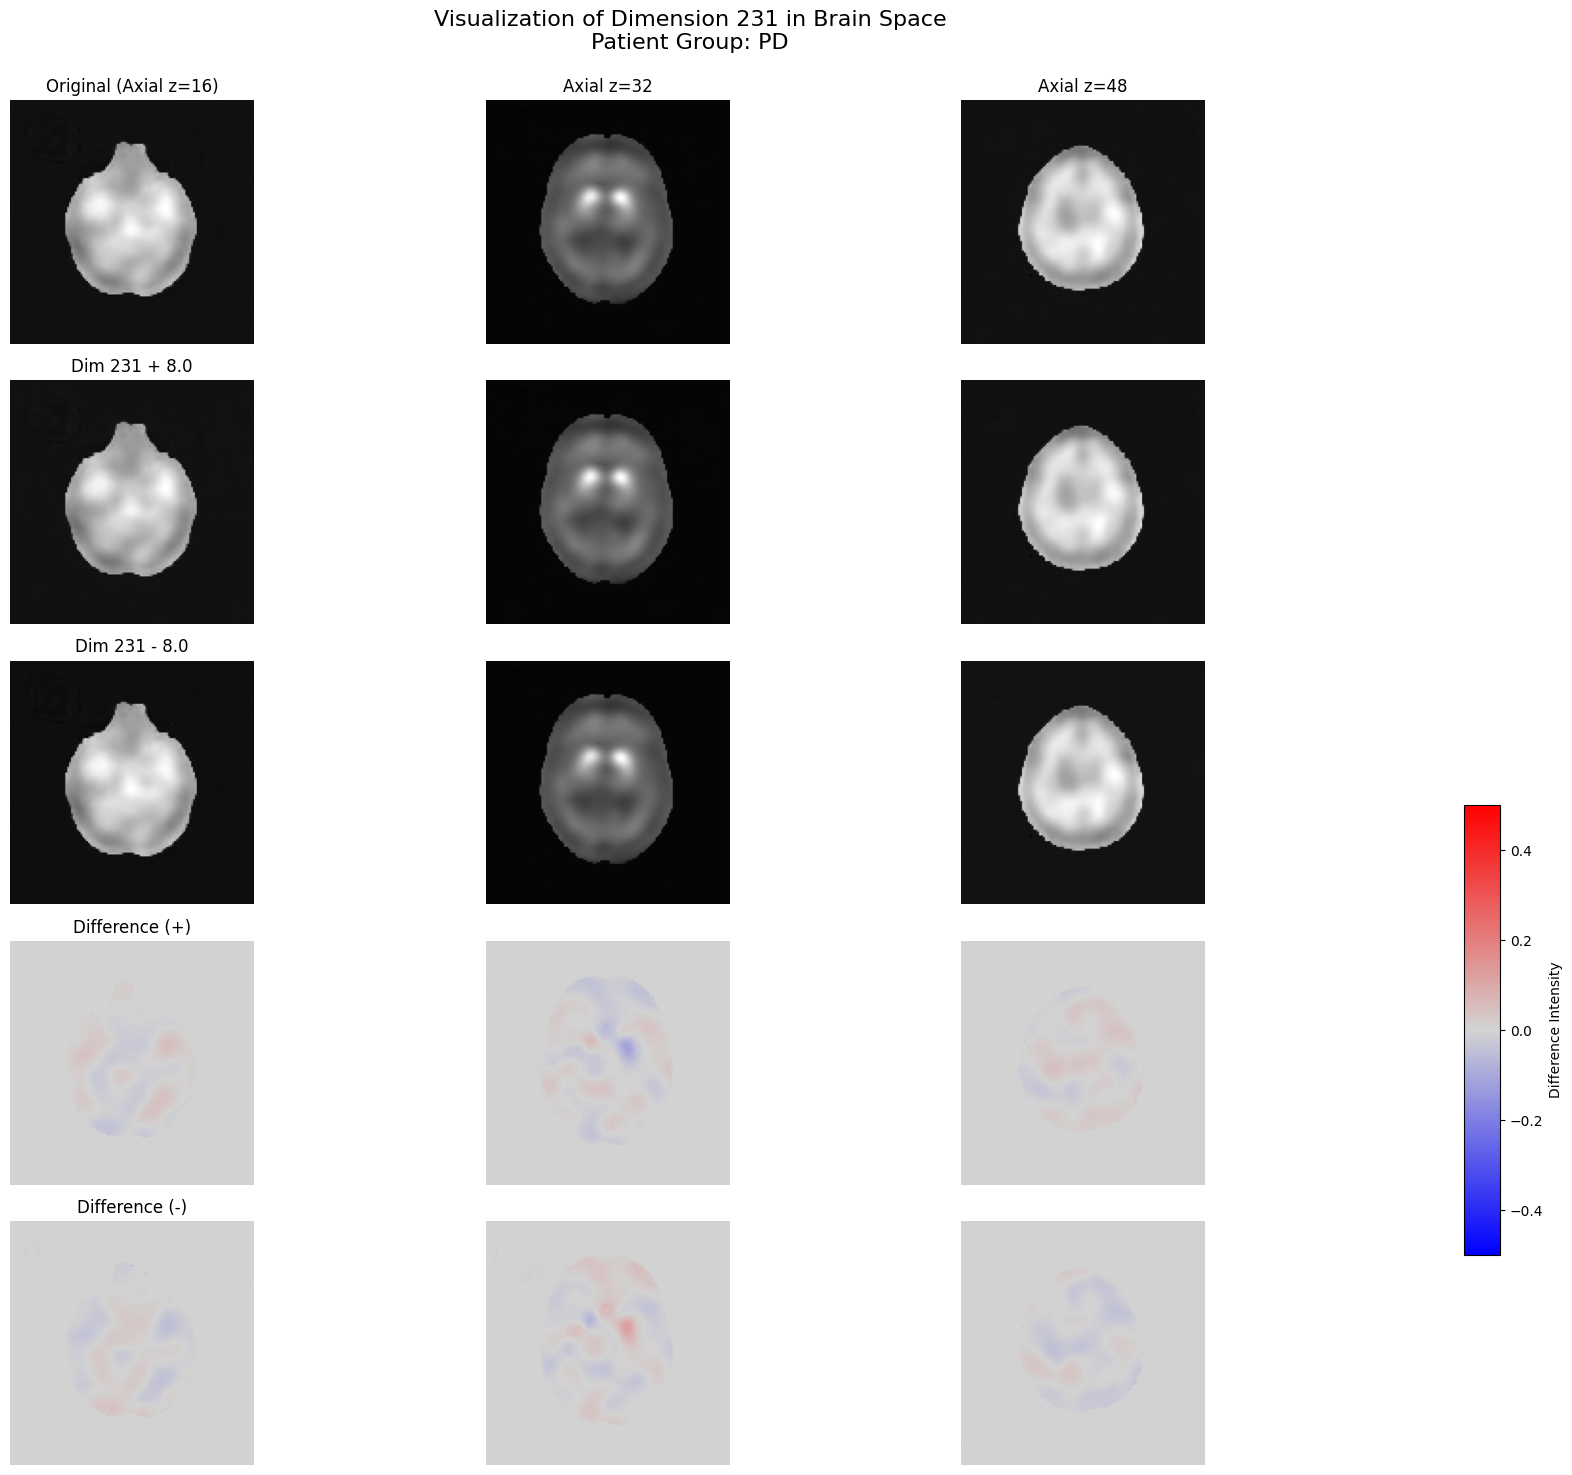


Exploring Dimension 231

Visualizing for group: PD


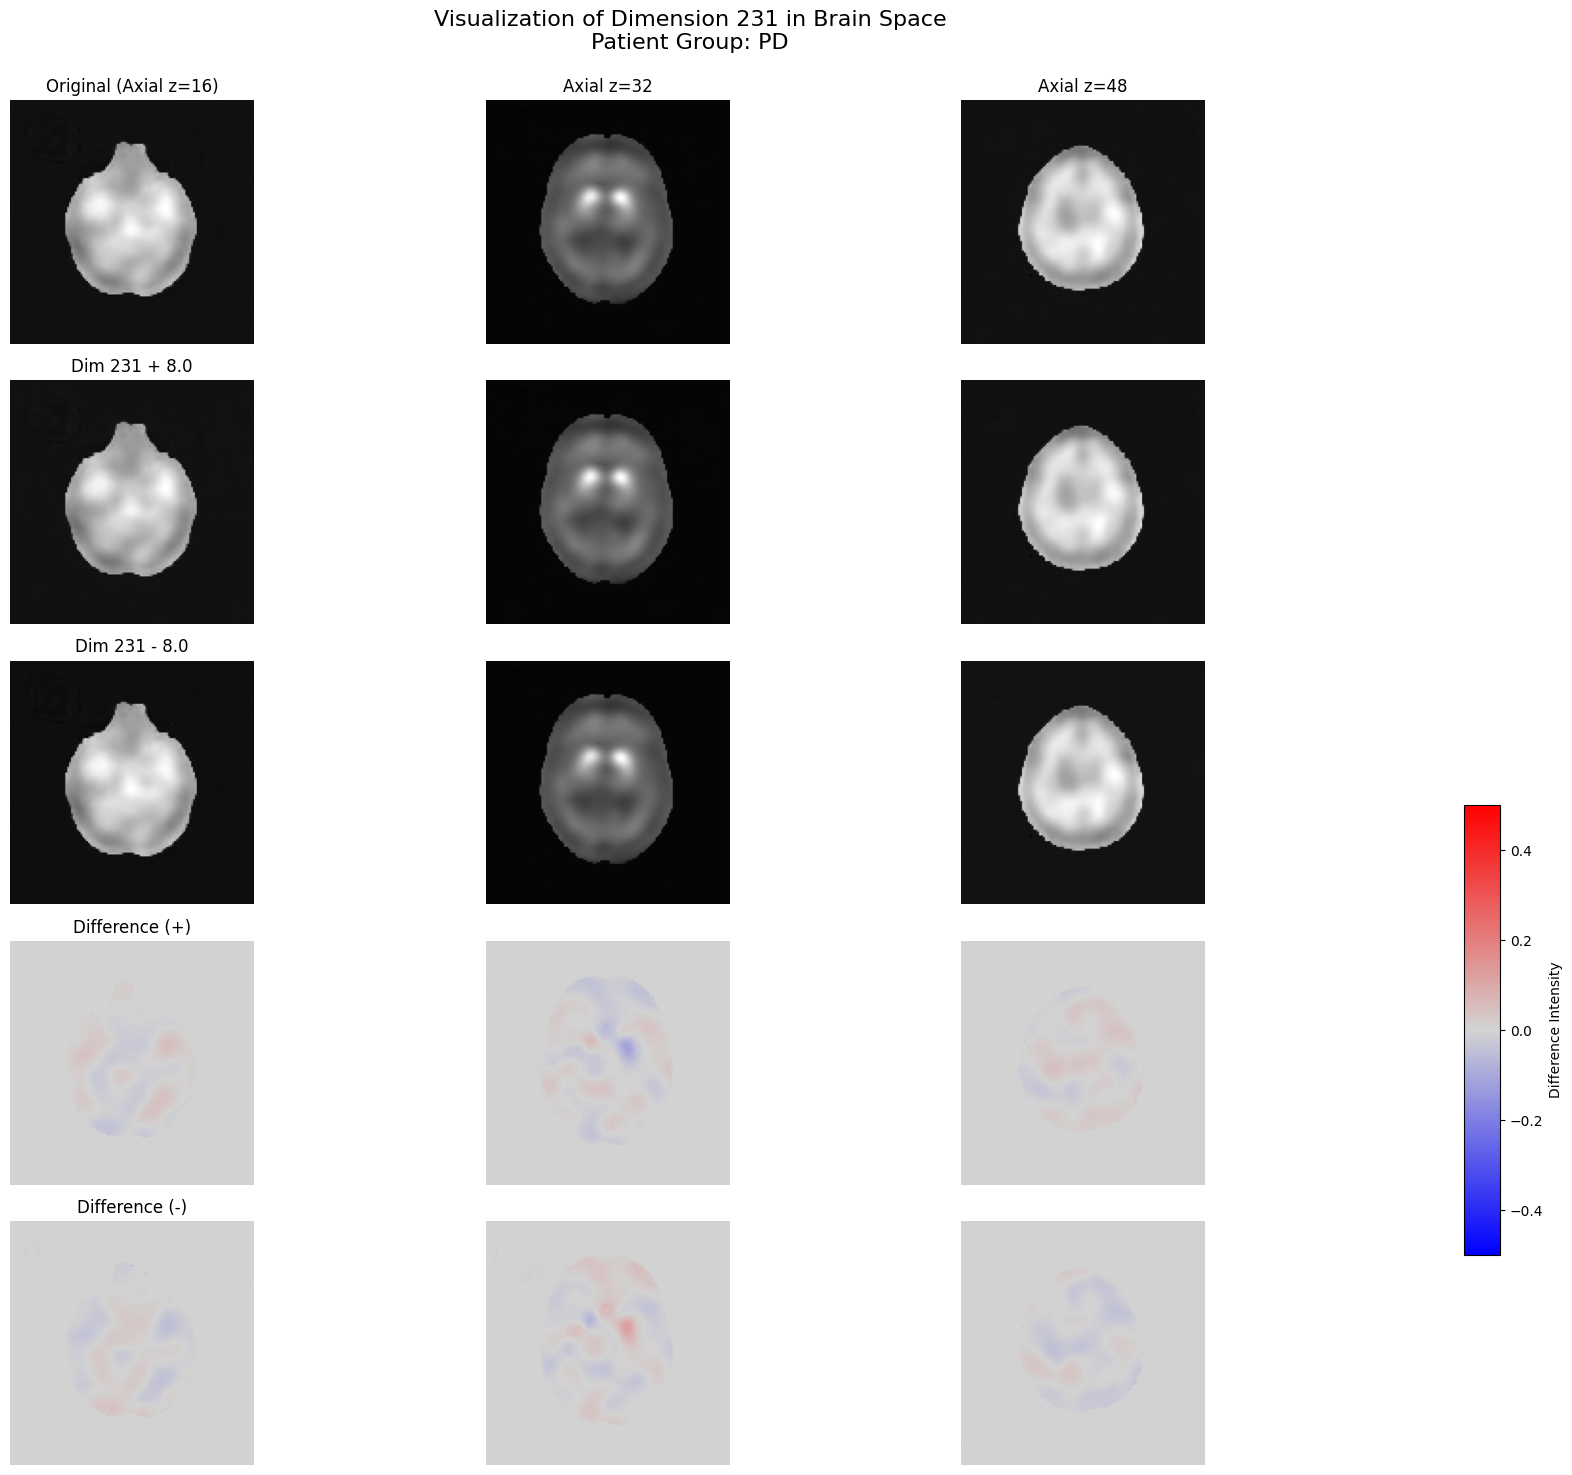

  Mean effect size: 0.00343
  Top 5% threshold: +0.02149, -0.02160

Visualizing for group: Control


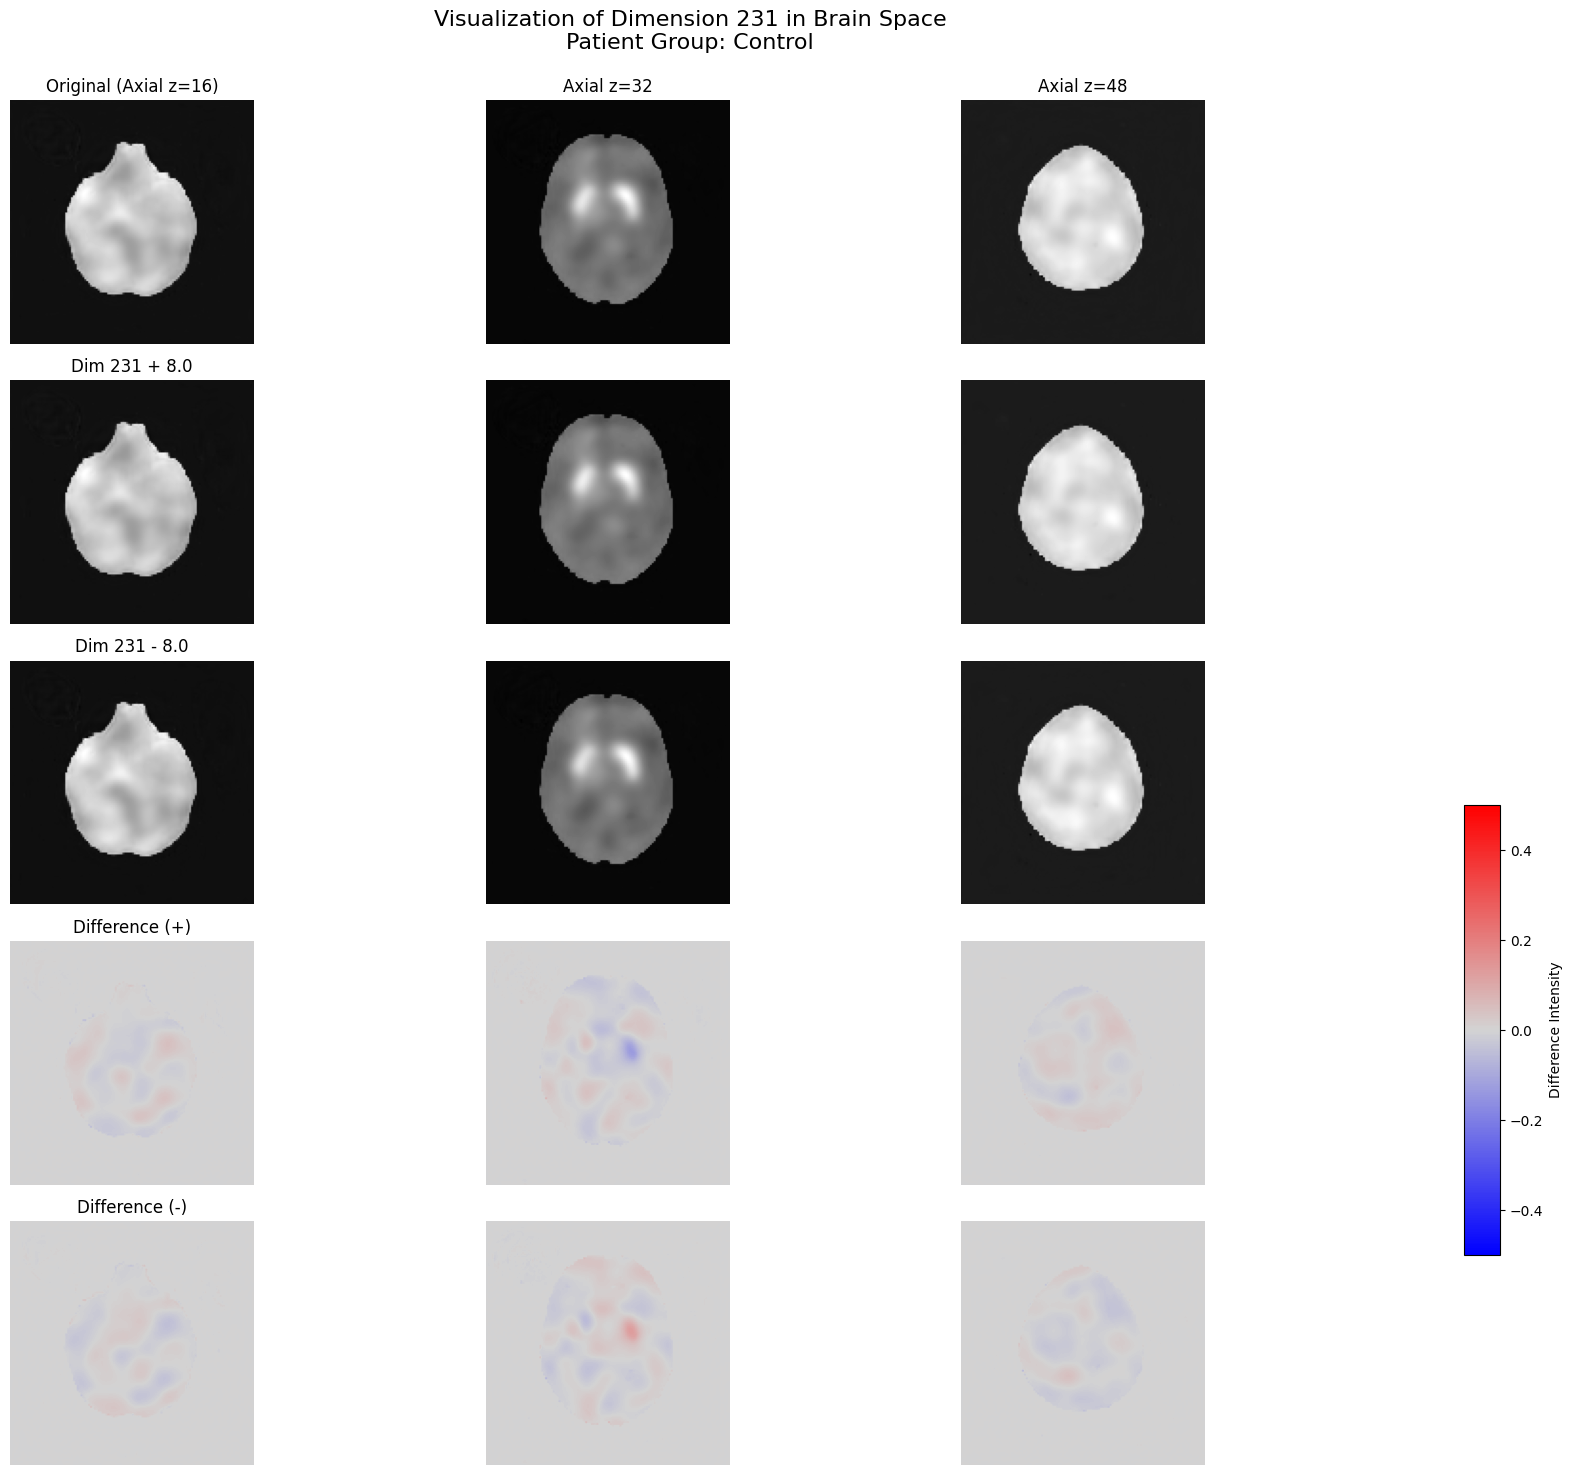

  Mean effect size: 0.00338
  Top 5% threshold: +0.02086, -0.02101

Visualizing for group: SWEDD


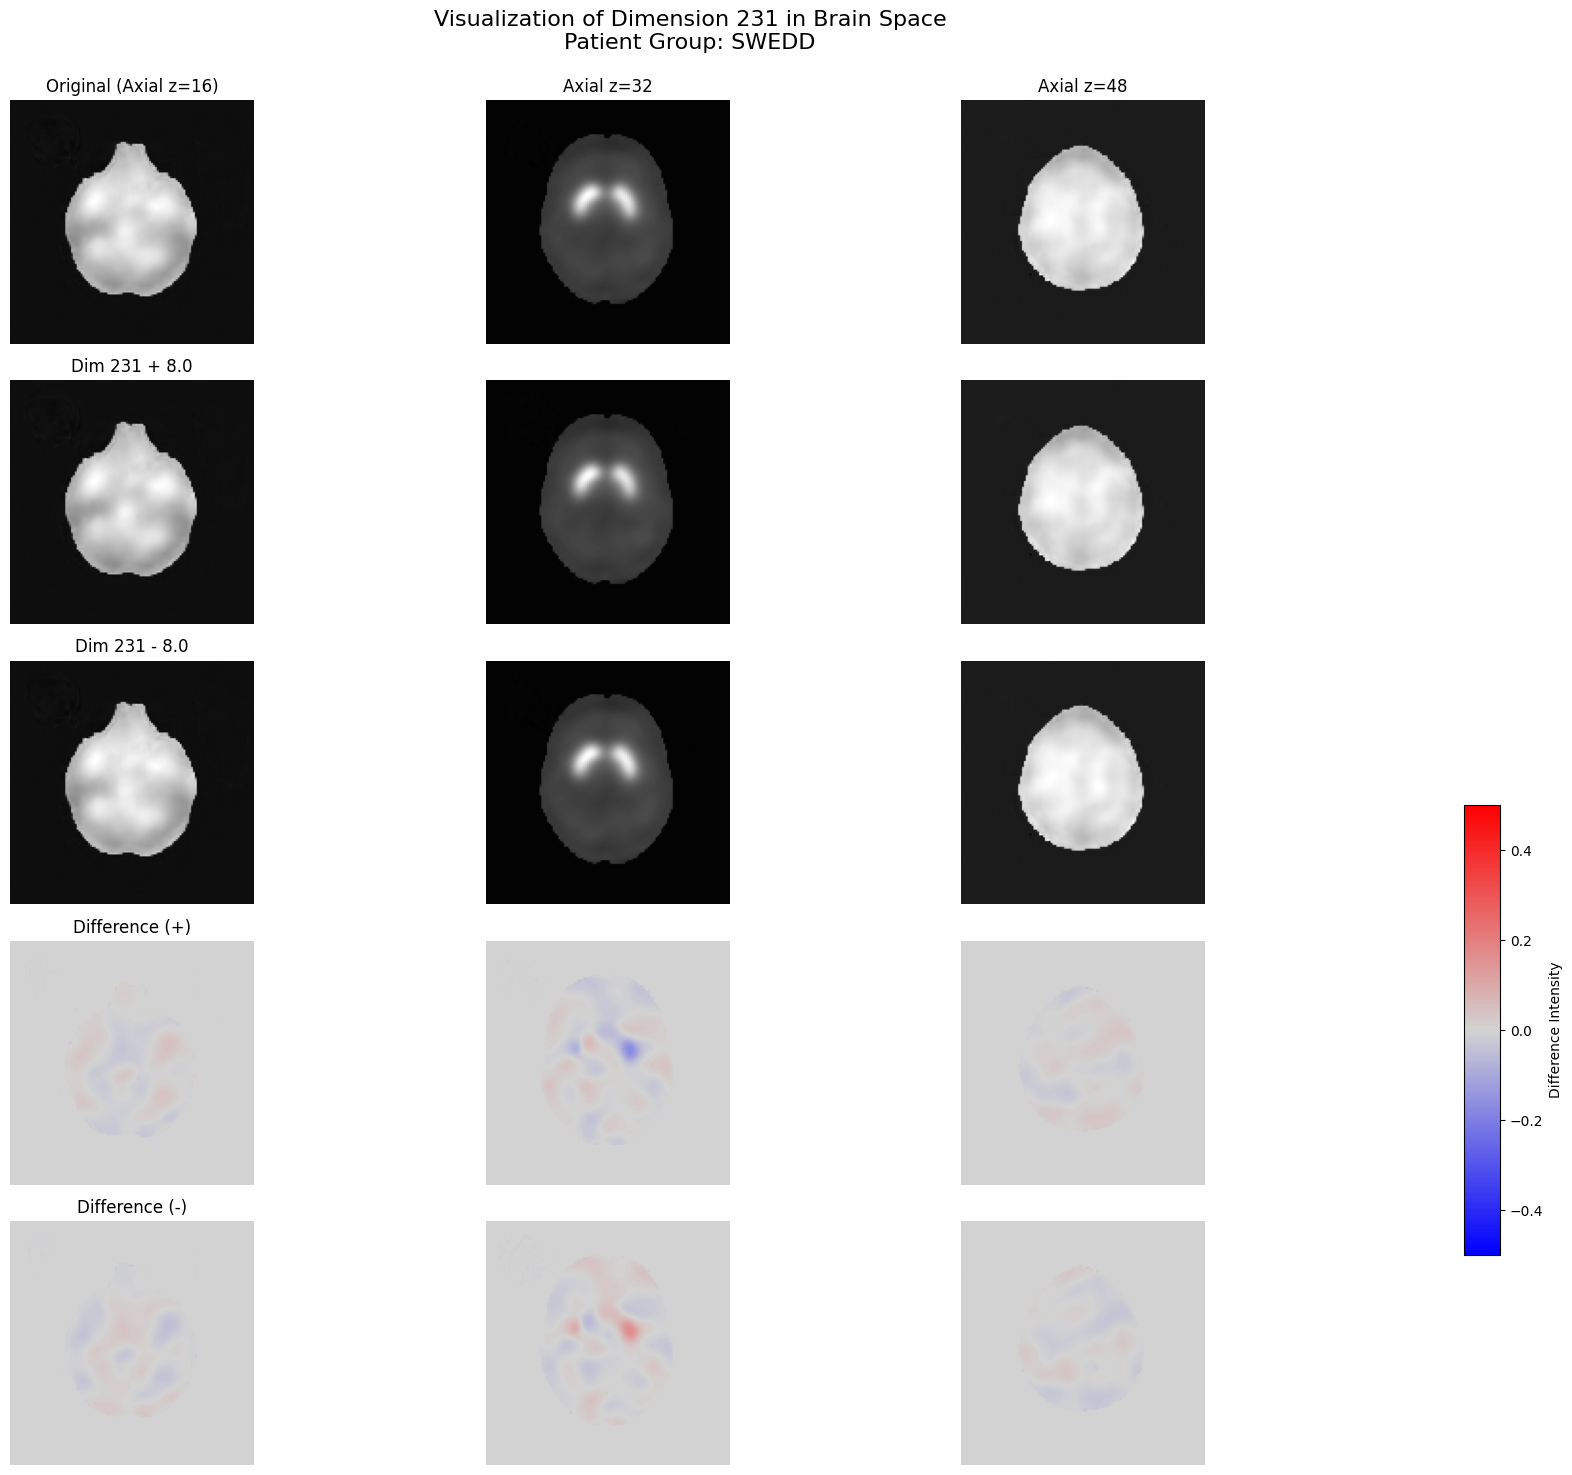

  Mean effect size: 0.00339
  Top 5% threshold: +0.02108, -0.02113

Exploring Dimension 94

Visualizing for group: PD


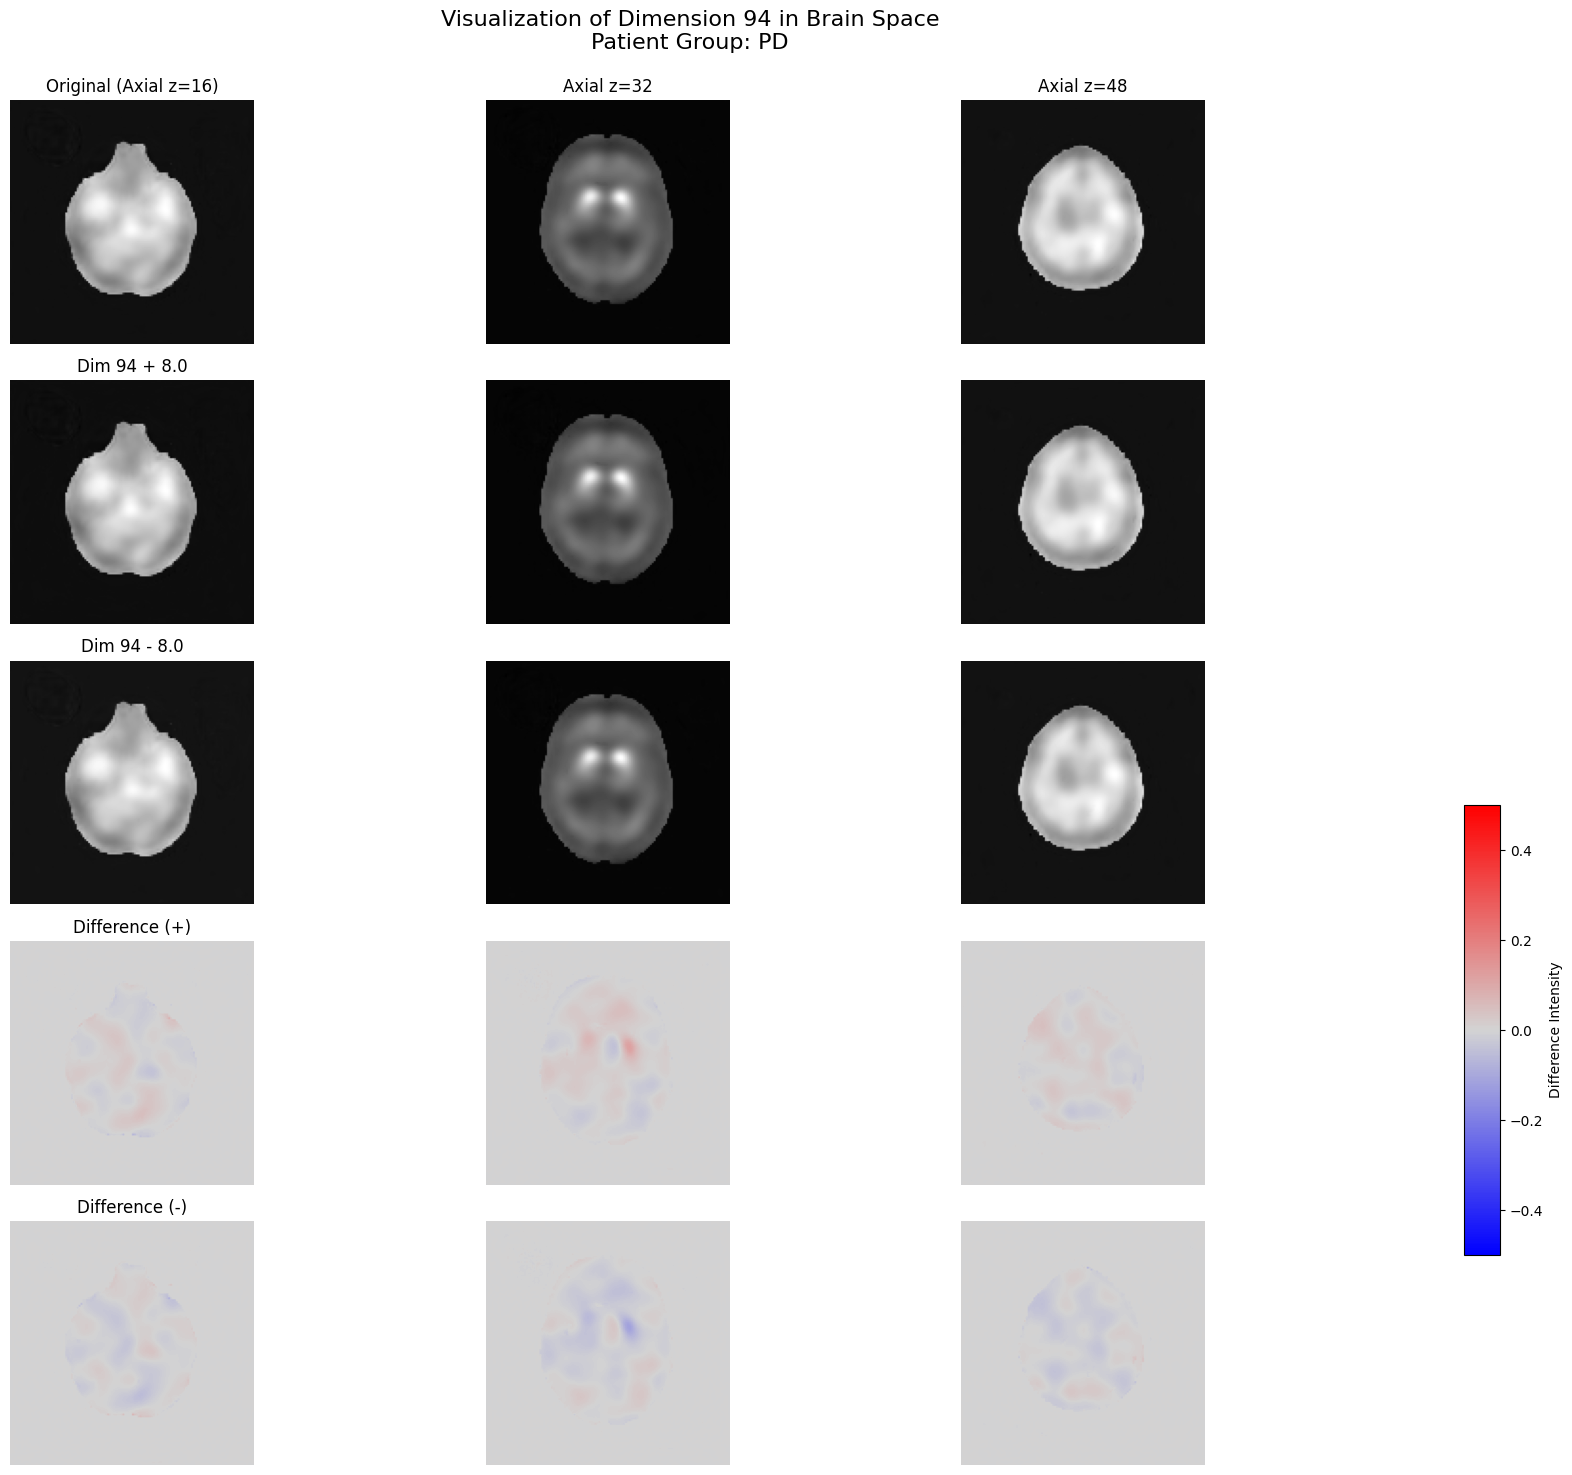

  Mean effect size: 0.00303
  Top 5% threshold: +0.01903, -0.01937

Visualizing for group: Control


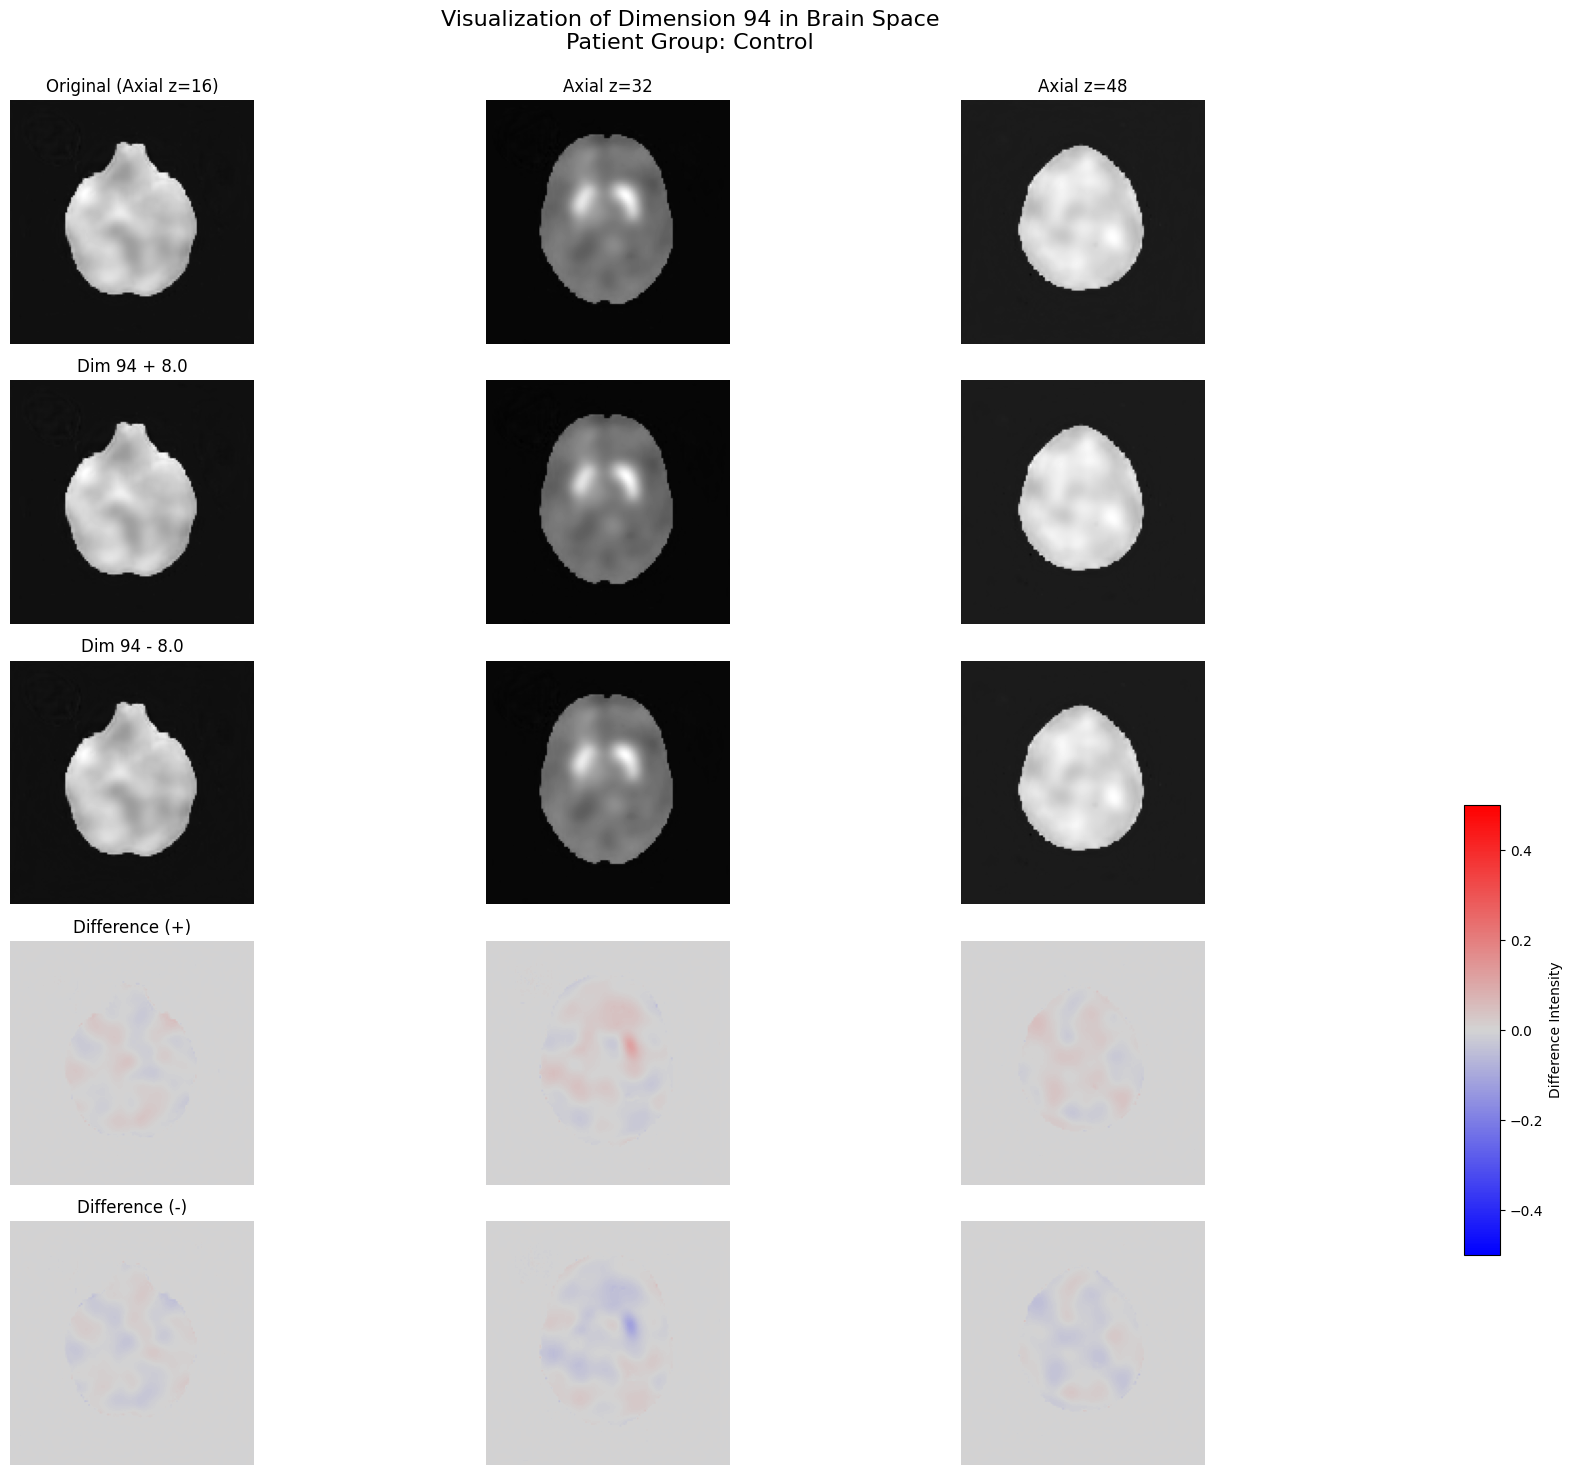

  Mean effect size: 0.00297
  Top 5% threshold: +0.01860, -0.01878

Visualizing for group: SWEDD


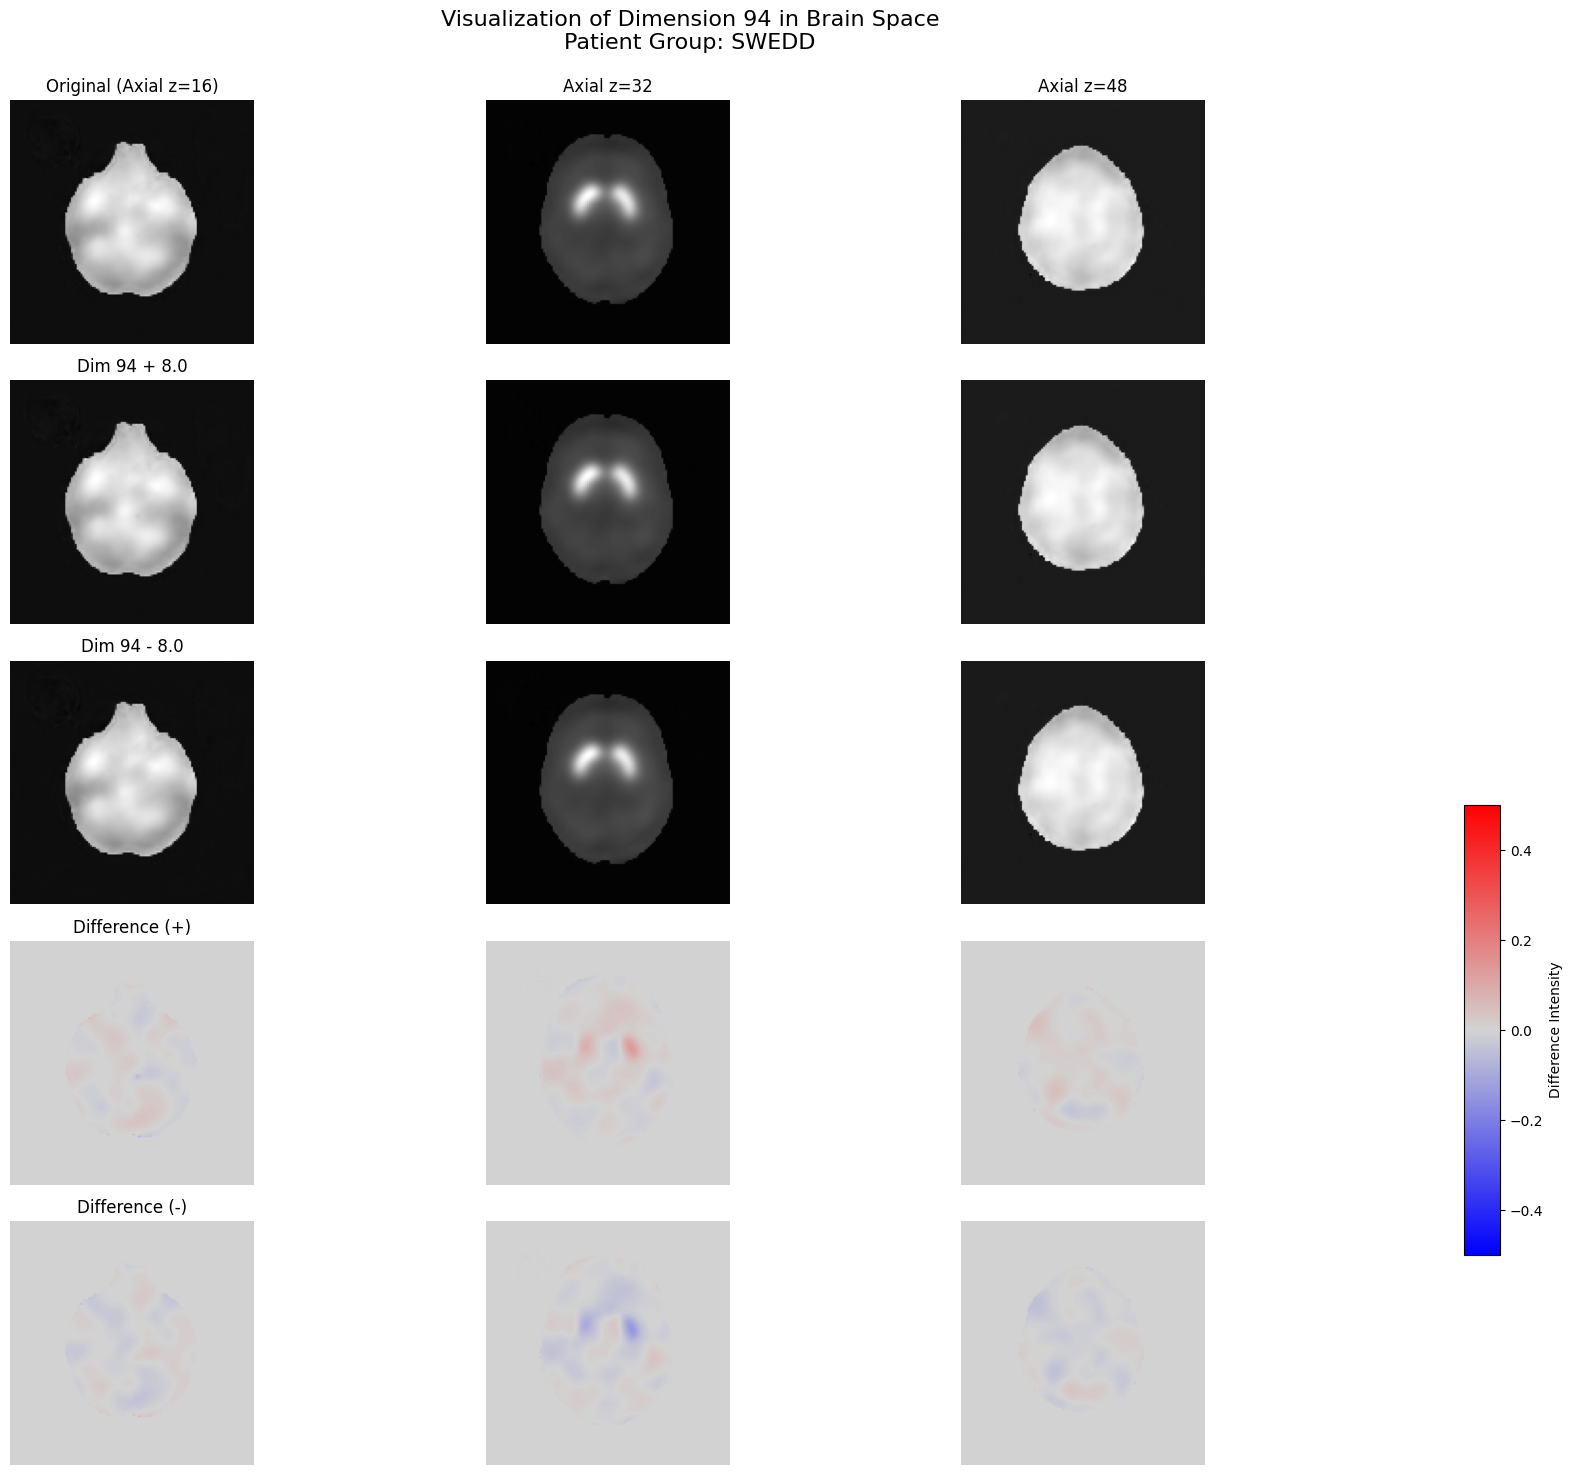

  Mean effect size: 0.00288
  Top 5% threshold: +0.01782, -0.01803

Exploring Dimension 154

Visualizing for group: PD


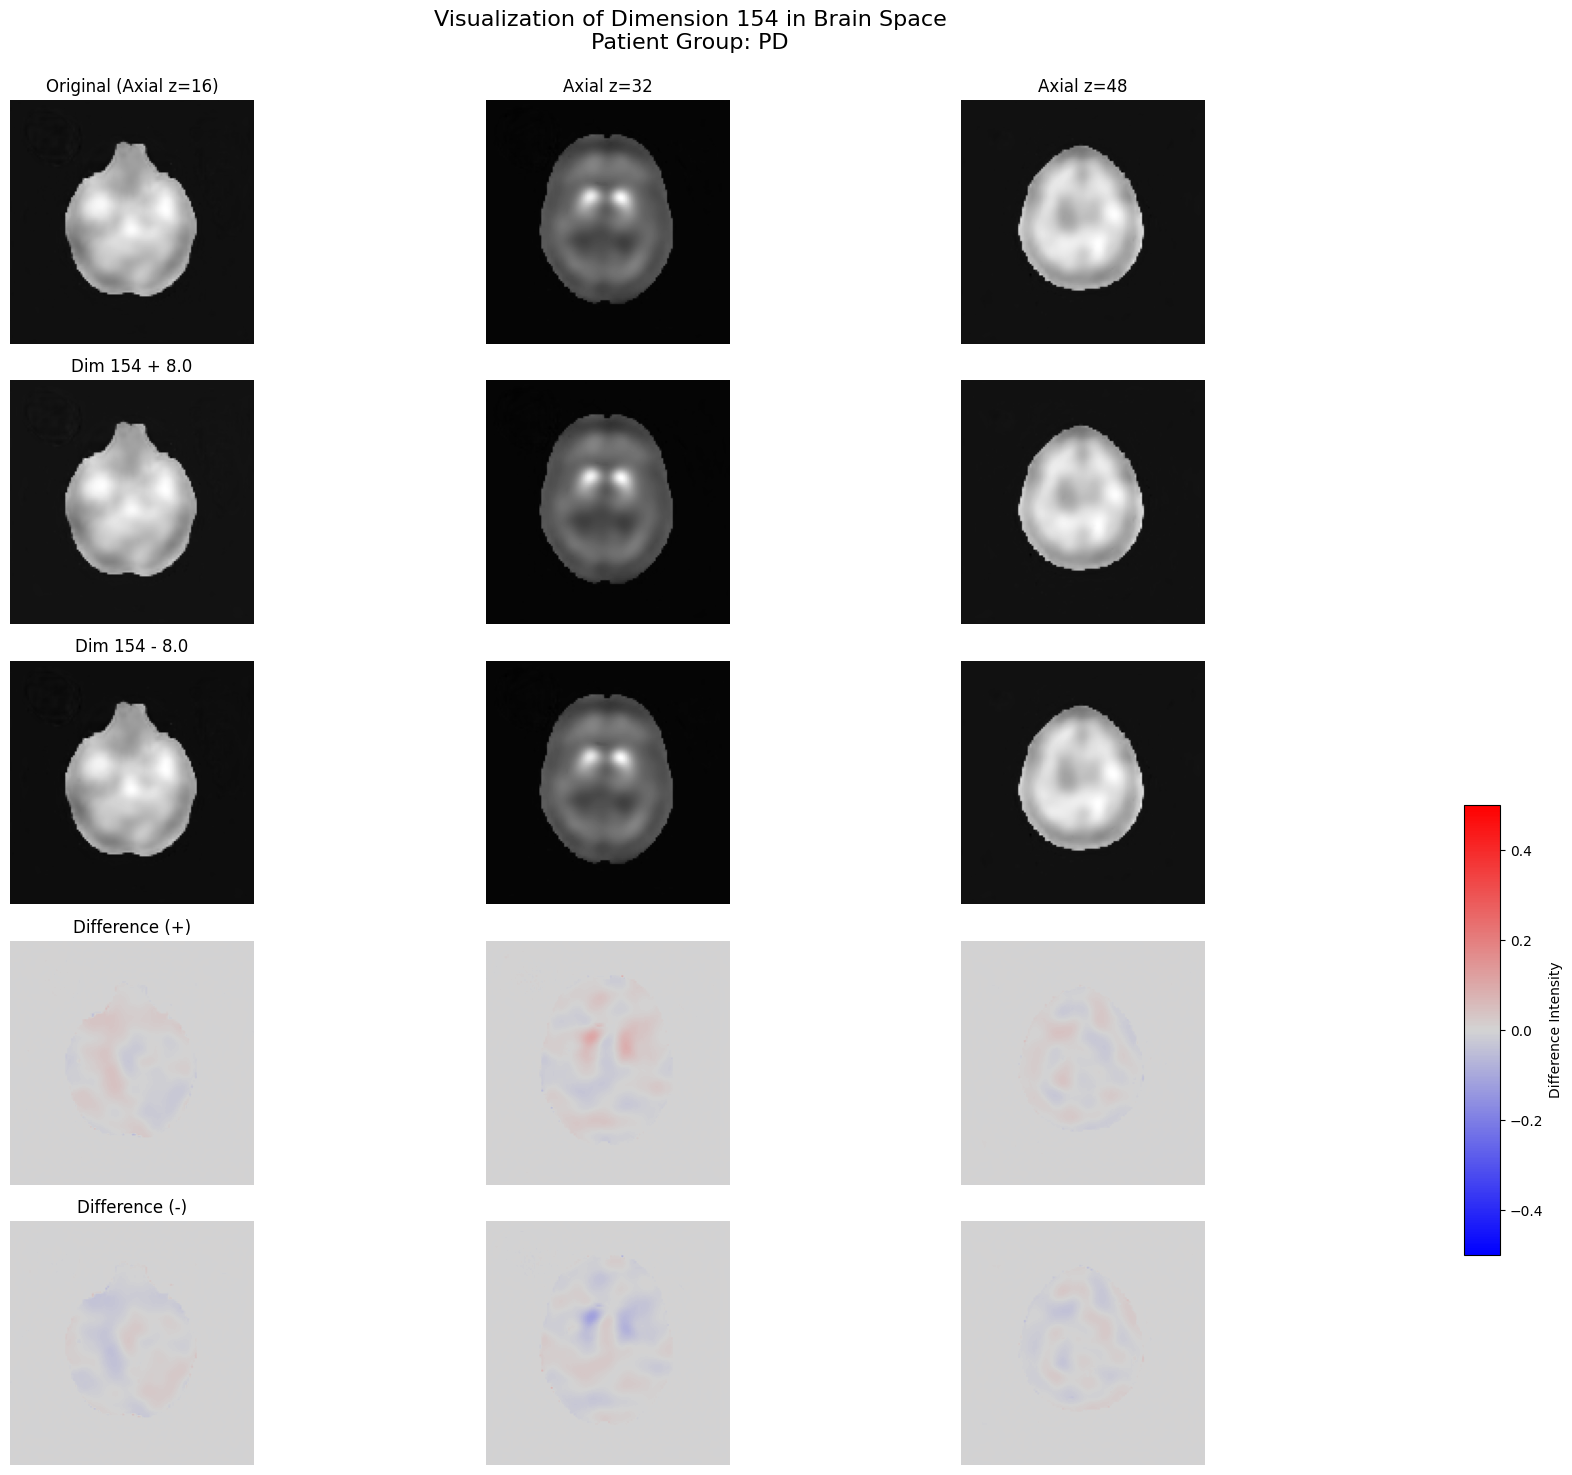

  Mean effect size: 0.00298
  Top 5% threshold: +0.01859, -0.01851

Visualizing for group: Control


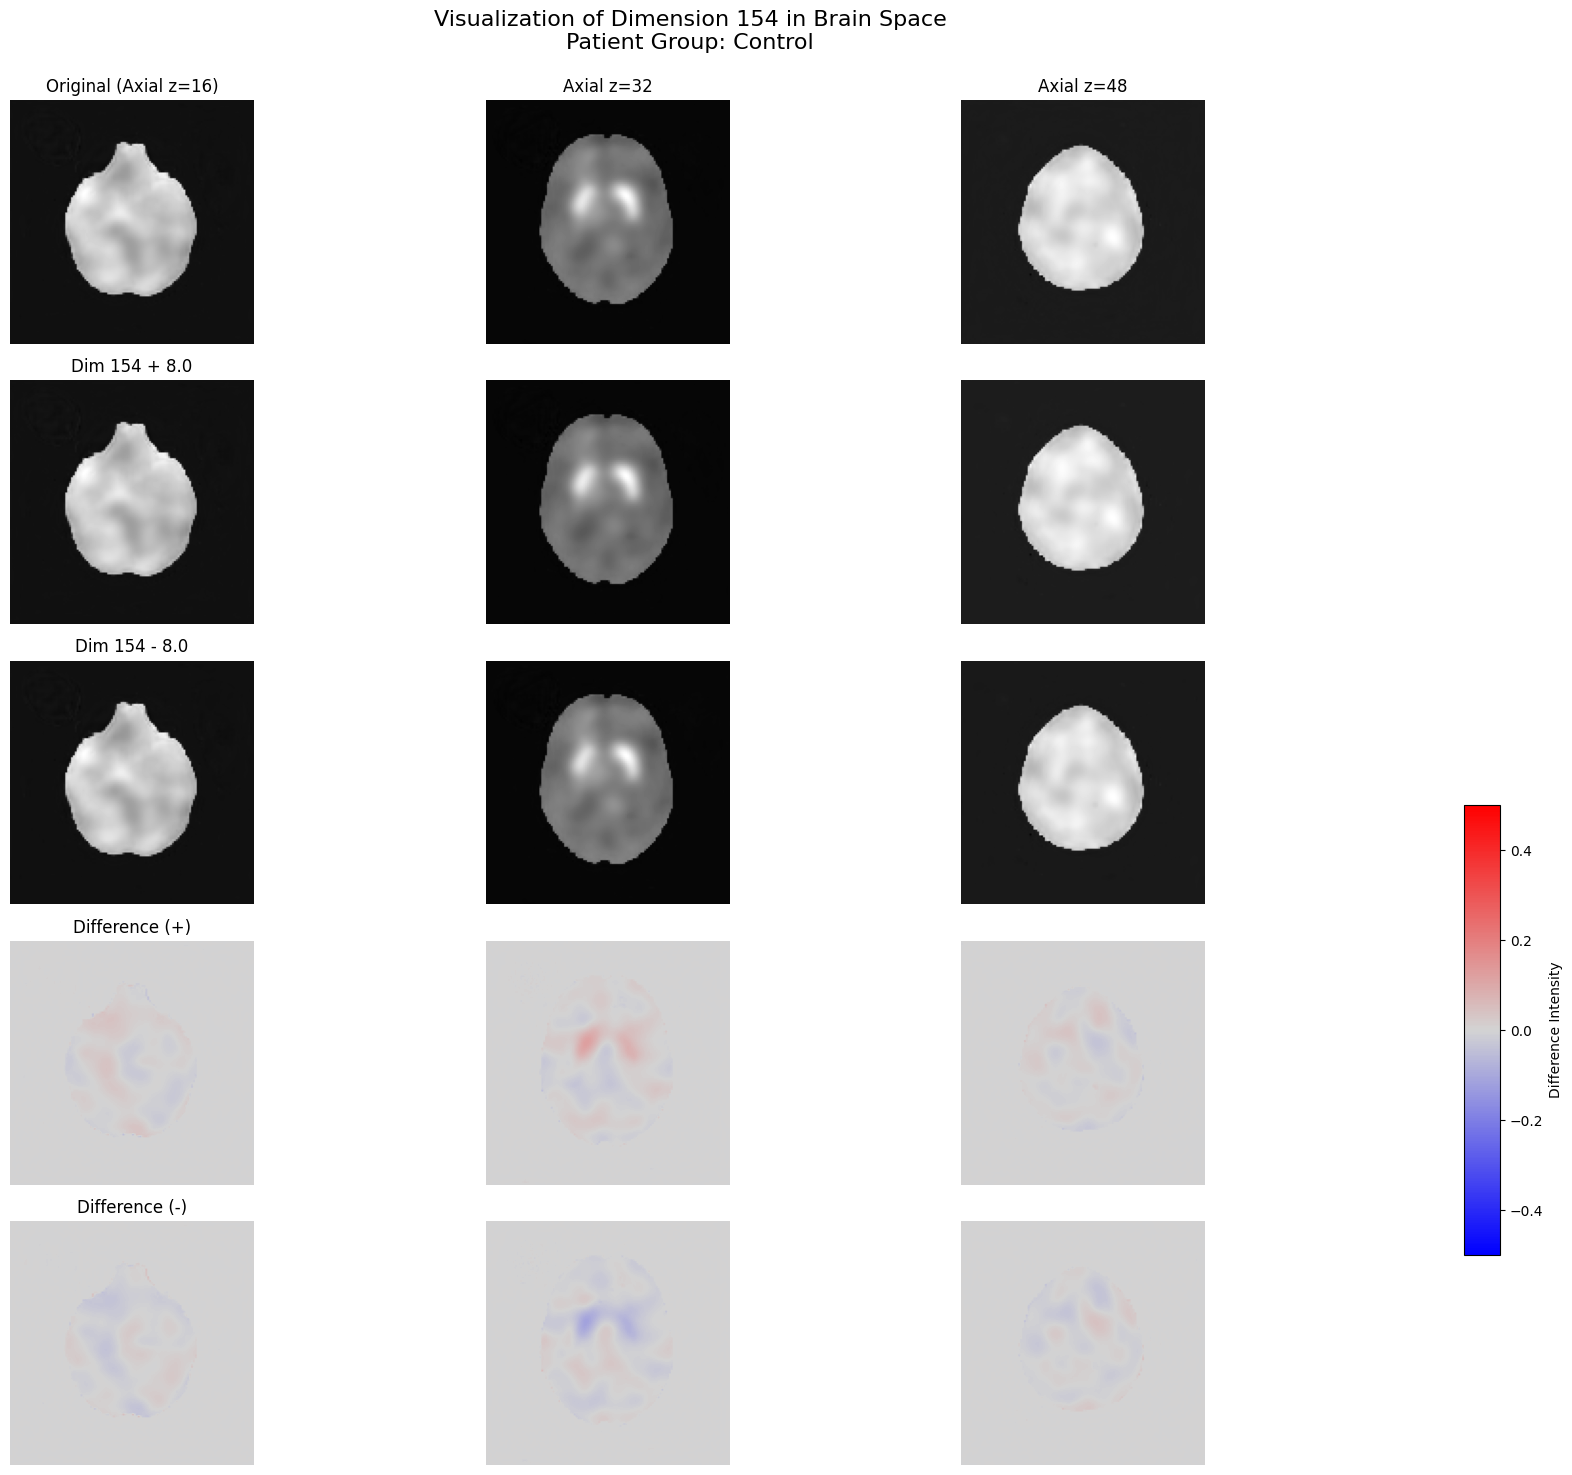

  Mean effect size: 0.00309
  Top 5% threshold: +0.01911, -0.01924

Visualizing for group: SWEDD


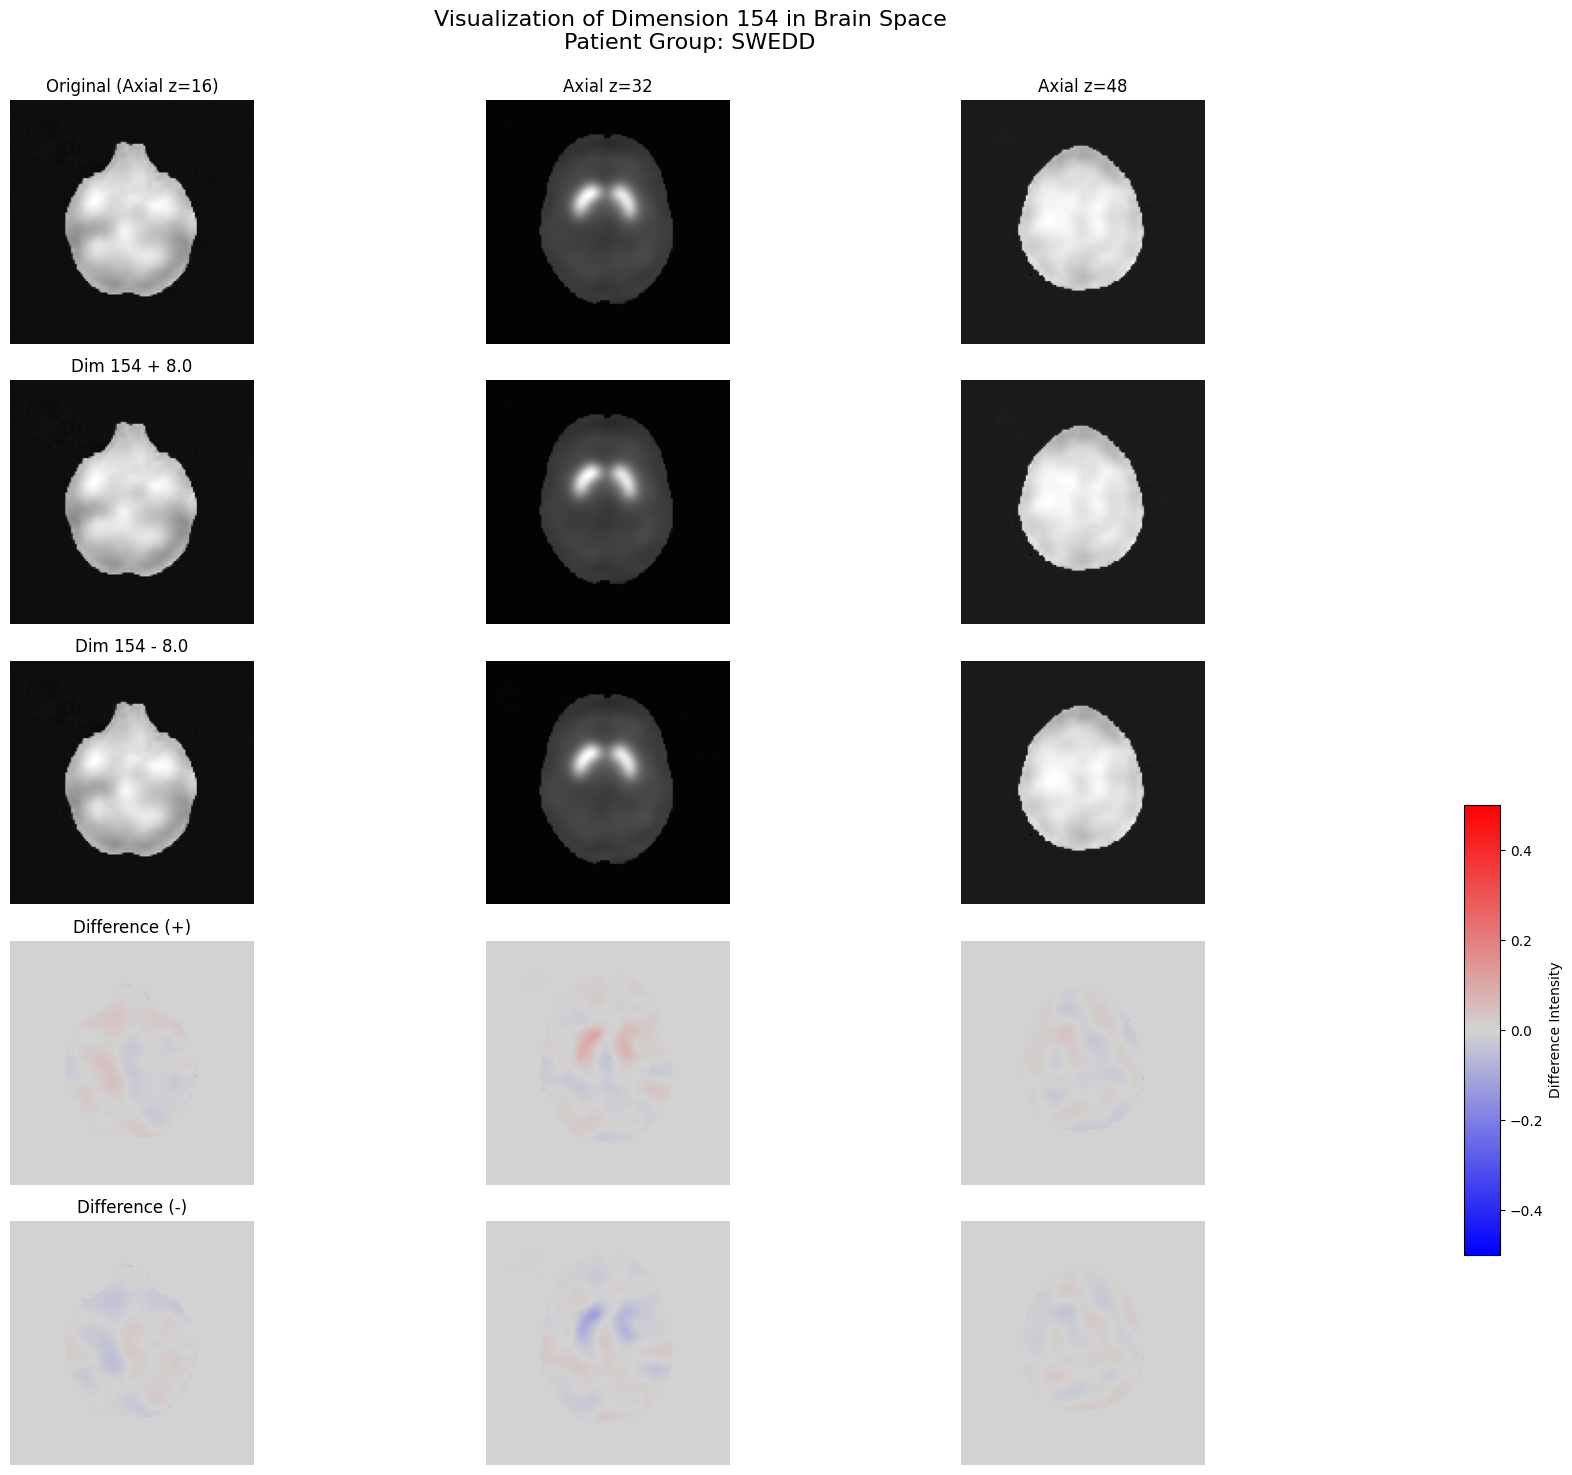

  Mean effect size: 0.00298
  Top 5% threshold: +0.01847, -0.01841


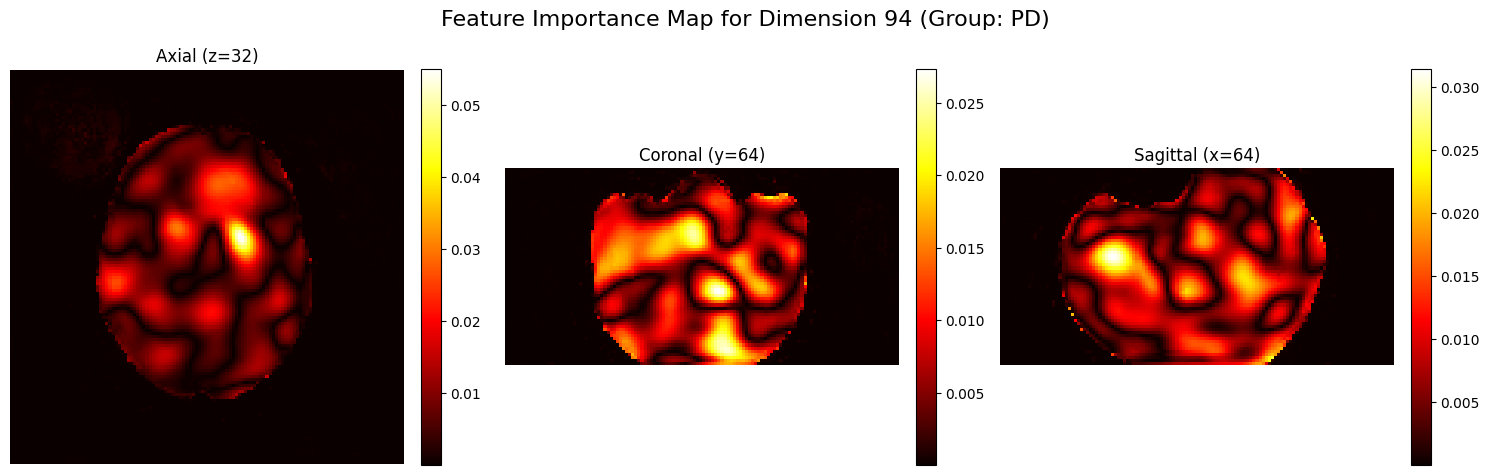

Error processing file Images/PPMI_Images_PD/3863/Reconstructed_DaTSCAN/2013-03-13_13_29_21.0/I449248/PPMI_3863_NM_Reconstructed_DaTSCAN_Br_20141022165646607_1_S202944_I449248.dcm: operands could not be broadcast together with shapes (60,128,128) (91,109,91) 


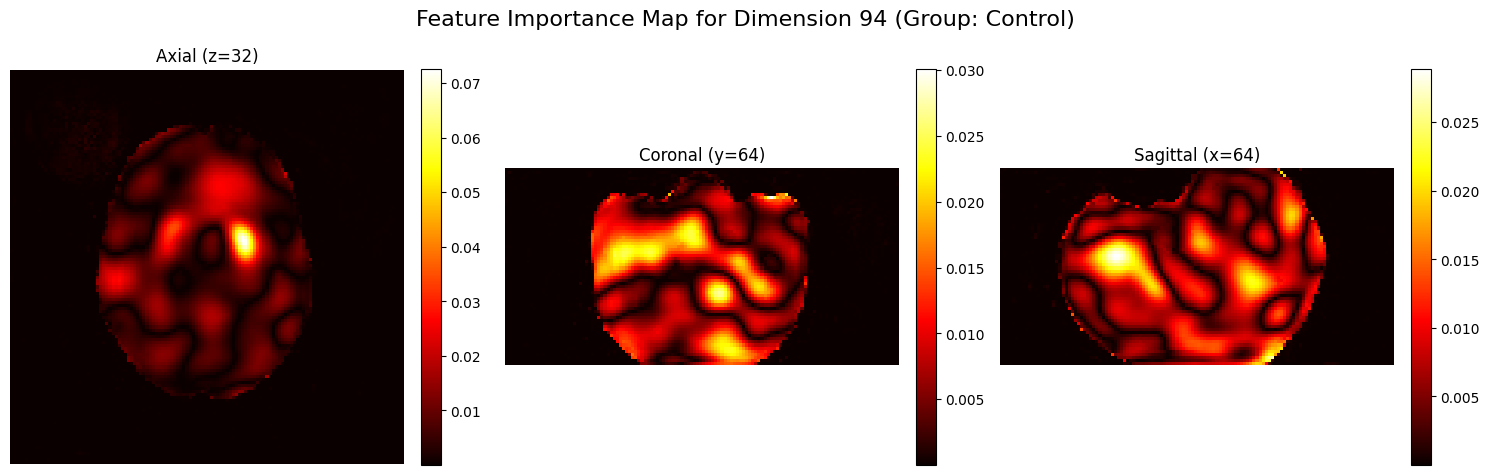

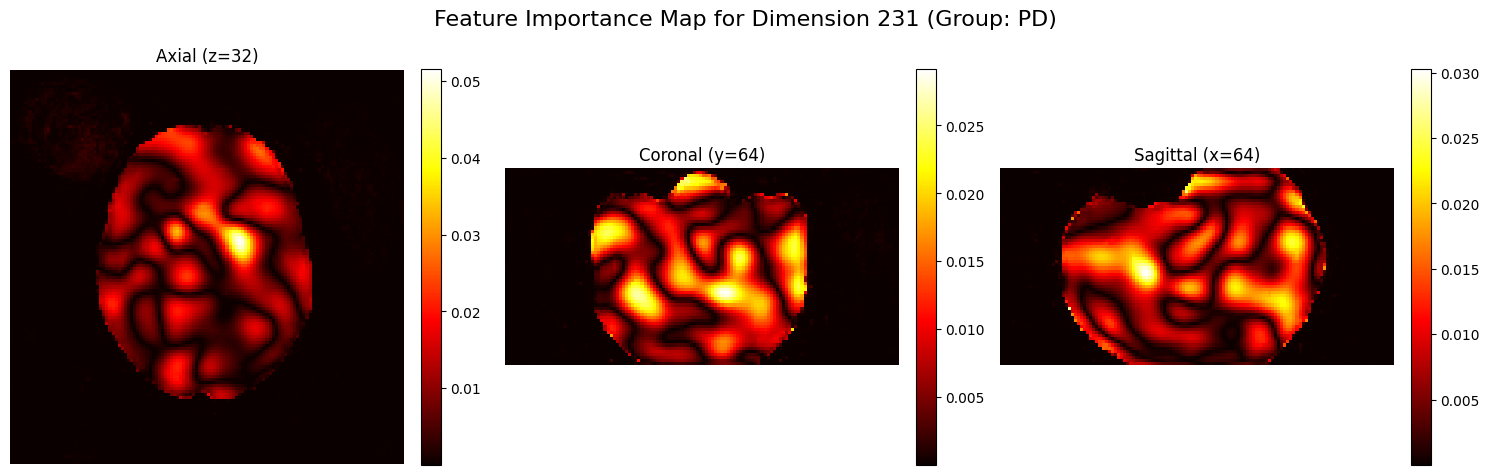

Error processing file Images/PPMI_Images_PD/3863/Reconstructed_DaTSCAN/2013-03-13_13_29_21.0/I449248/PPMI_3863_NM_Reconstructed_DaTSCAN_Br_20141022165646607_1_S202944_I449248.dcm: operands could not be broadcast together with shapes (60,128,128) (91,109,91) 


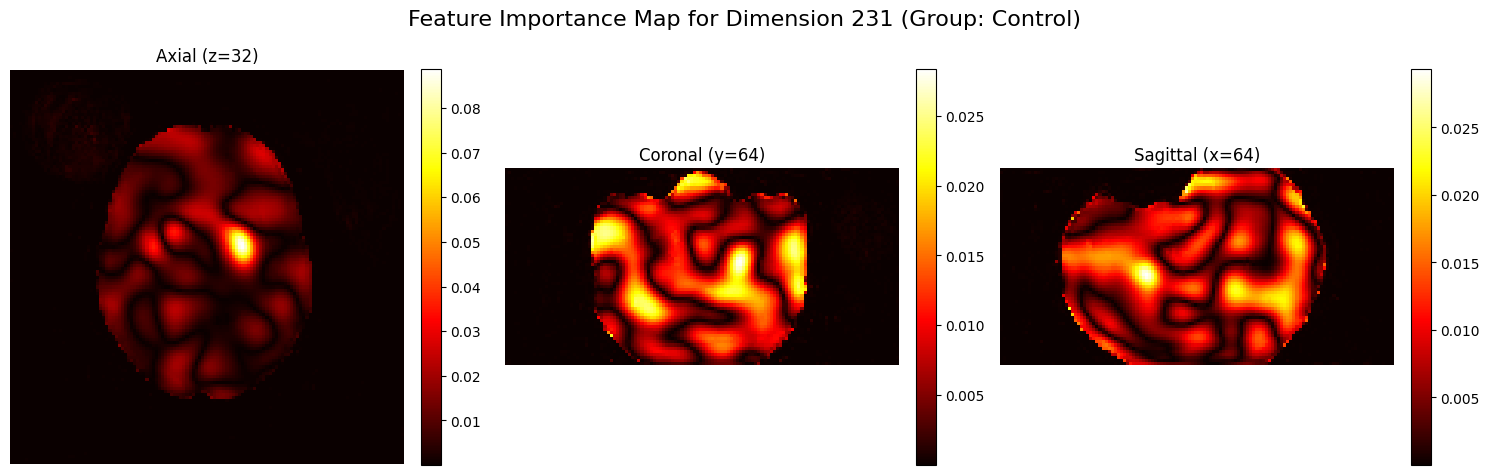

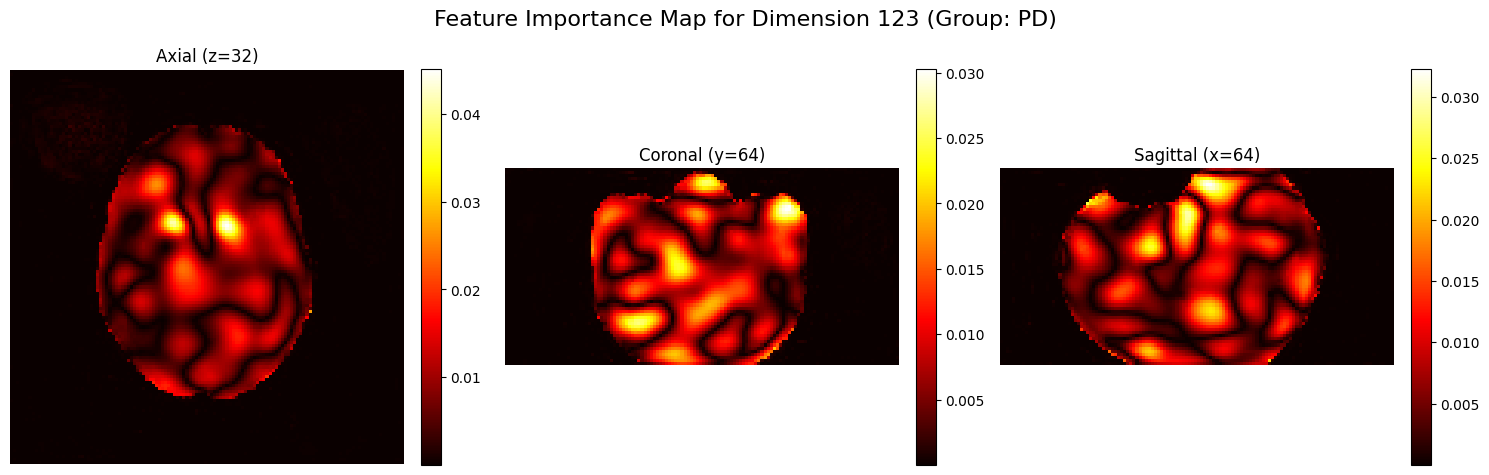

Error processing file Images/PPMI_Images_PD/3863/Reconstructed_DaTSCAN/2013-03-13_13_29_21.0/I449248/PPMI_3863_NM_Reconstructed_DaTSCAN_Br_20141022165646607_1_S202944_I449248.dcm: operands could not be broadcast together with shapes (60,128,128) (91,109,91) 


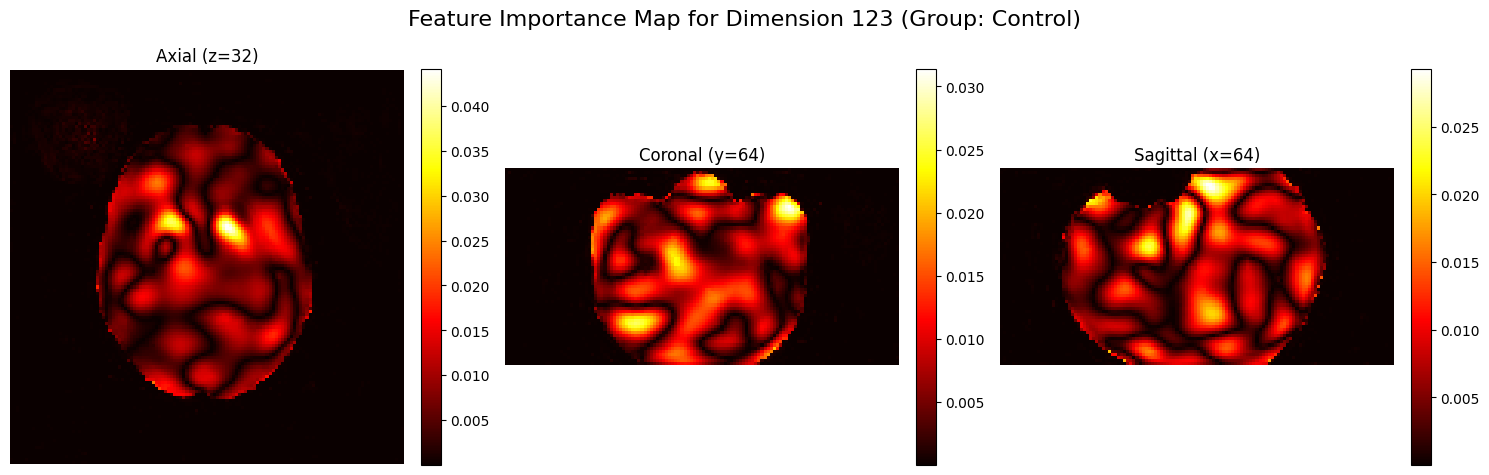

In [29]:
# Example usage
if __name__ == "__main__":
    # Load your trained model first
    model, metadata = load_trained_model('checkpoints', 'autoencoder_v1', latent_dim=256)
    
    # Example 1: Visualize one specific important dimension for a specific group
    # This shows what happens when you increase or decrease this dimension
    visualize_latent_dimension(model, val_loader, dimension_idx=231, alpha=8.0, group='PD')
    
    # Example 2: Compare the same dimension across different patient groups
    # Uncomment to see how the same dimension affects different groups
    explore_top_dimensions(model, val_loader, dimensions=[231, 94, 154], groups=['PD', 'Control', 'SWEDD'])
    
    # Example 3: Generate a feature importance map by aggregating across multiple samples
    # This shows which brain regions are most affected by this dimension
    generate_feature_importance_map(model, val_loader, dimension_idx=94, group='PD', num_samples=10)
    generate_feature_importance_map(model, val_loader, dimension_idx=94, group='Control', num_samples=10)
    generate_feature_importance_map(model, val_loader, dimension_idx=231, group='PD', num_samples=10)
    generate_feature_importance_map(model, val_loader, dimension_idx=231, group='Control', num_samples=10)
    generate_feature_importance_map(model, val_loader, dimension_idx=123, group='PD', num_samples=10)
    generate_feature_importance_map(model, val_loader, dimension_idx=123, group='Control', num_samples=10)

1. latent 512: MSE val 0.006006; RMSE: 0.0775
2. latent 256: MSE val 0.0067
3. latent 128: MSE val 0.0087

1. masked latent 128: 0.004508
2. masked latent 256: 0.004092

## 2. Variational Autoencoder (VAE)

### Model Setup

In [ ]:
# Cell 16: Optimized VAE Implementation
import torch
import torch.nn as nn
import torch.nn.functional as F
from collections import OrderedDict

class VAE(nn.Module):
    """
    3D Variational Autoencoder optimized for 64×128×128 medical volumes with
    memory-efficient implementation for NVIDIA 4070Ti.
    """
    def __init__(self, latent_dim=256):
        super().__init__()
        self.encoder = VAEEncoder(latent_dim)
        self.decoder = VAEDecoder(latent_dim)
        # Enable CUDNN benchmarking for optimal performance
        torch.backends.cudnn.benchmark = True
        self.latent_dim = latent_dim

    def reparameterize(self, mu, log_var):
        """
        Reparameterization trick to enable backpropagation through sampling.
        """
        if self.training:
            std = torch.exp(0.5 * log_var)
            eps = torch.randn_like(std)
            return mu + eps * std
        return mu

    def forward(self, x):
        # Encode input to get mean and variance of latent distribution
        mu, log_var = self.encoder(x)

        # Sample from latent distribution
        z = self.reparameterize(mu, log_var)

        # Decode sampled latent vector
        reconstruction = self.decoder(z)

        return reconstruction, mu, log_var
    
    def encode(self, x):
        """Encode input to latent parameters without sampling"""
        mu, log_var = self.encoder(x)
        return mu, log_var
    
    def generate(self, z=None, num_samples=1):
        """Generate samples from latent space or random samples"""
        device = next(self.parameters()).device
        
        if z is None:
            # Generate random latent vectors
            z = torch.randn(num_samples, self.latent_dim, device=device)
        
        # Decode latent vectors to generate samples
        with torch.no_grad():
            samples = self.decoder(z)
        
        return samples

class ConvBlock(nn.Module):
    """Memory-efficient convolutional block with batch normalization and ReLU."""
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1):
        super().__init__()
        self.block = nn.Sequential(OrderedDict([
            ('conv', nn.Conv3d(in_channels, out_channels, kernel_size, stride, padding)),
            ('bn', nn.BatchNorm3d(out_channels)),
            ('relu', nn.ReLU(inplace=True))  # inplace ReLU for memory efficiency
        ]))

    def forward(self, x):
        return self.block(x)

class VAEEncoder(nn.Module):
    """3D Encoder network with probabilistic latent space."""
    def __init__(self, latent_dim=256):
        super().__init__()

        # Initial feature extraction
        self.init_conv = ConvBlock(1, 16)  # 64×128×128 -> same size

        # Downsampling path with progressive channel increase
        self.down1 = nn.Sequential(
            ConvBlock(16, 32, stride=2),    # -> 32×64×64
            ConvBlock(32, 32)
        )

        self.down2 = nn.Sequential(
            ConvBlock(32, 64, stride=2),    # -> 16×32×32
            ConvBlock(64, 64)
        )

        self.down3 = nn.Sequential(
            ConvBlock(64, 128, stride=2),   # -> 8×16×16
            ConvBlock(128, 128)
        )

        self.down4 = nn.Sequential(
            ConvBlock(128, 256, stride=2),  # -> 4×8×8
            ConvBlock(256, 256)
        )

        # Project to latent parameters
        self.flatten_size = 256 * 4 * 8 * 8
        self.fc_mu = nn.Linear(self.flatten_size, latent_dim)
        self.fc_var = nn.Linear(self.flatten_size, latent_dim)

    def forward(self, x):
        # Initial convolution
        x = self.init_conv(x)

        # Downsampling
        x = self.down1(x)
        x = self.down2(x)
        x = self.down3(x)
        x = self.down4(x)

        # Flatten and project to latent parameters
        flat = torch.flatten(x, start_dim=1)
        mu = self.fc_mu(flat)
        log_var = self.fc_var(flat)

        return mu, log_var

class VAEDecoder(nn.Module):
    """3D Decoder network with enhanced capacity for better reconstructions."""
    def __init__(self, latent_dim=256):
        super().__init__()

        self.flatten_size = 256 * 4 * 8 * 8
        self.fc = nn.Linear(latent_dim, self.flatten_size)

        # Upsampling path with enhanced capacity
        self.up1 = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='trilinear', align_corners=False),
            ConvBlock(256, 192),  # Increased intermediate channels
            ConvBlock(192, 128)
        )

        self.up2 = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='trilinear', align_corners=False),
            ConvBlock(128, 96),   # Increased intermediate channels
            ConvBlock(96, 64)
        )

        self.up3 = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='trilinear', align_corners=False),
            ConvBlock(64, 48),    # Increased intermediate channels
            ConvBlock(48, 32)
        )

        self.up4 = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='trilinear', align_corners=False),
            ConvBlock(32, 24),    # Increased intermediate channels
            ConvBlock(24, 16)
        )

        # Add a refinement layer before final output
        self.refine = ConvBlock(16, 16)
        
        # Final convolution
        self.final_conv = nn.Conv3d(16, 1, kernel_size=1)

    def forward(self, z):
        # Reshape from latent space
        x = self.fc(z)
        x = x.view(-1, 256, 4, 8, 8)

        # Upsampling
        x = self.up1(x)
        x = self.up2(x)
        x = self.up3(x)
        x = self.up4(x)
        
        # Refinement for better details
        x = self.refine(x)

        # Final convolution (no activation to allow for negative values if needed)
        x = self.final_conv(x)

        return x

# Custom loss function for VAE
class VAELoss(nn.Module):
    """
    VAE loss combining reconstruction loss and KL divergence
    with beta parameter to control the trade-off and free bits approach.
    """
    def __init__(self, beta=0.0005, beta_warmup_steps=5000, free_bits=3.0):
        super().__init__()
        self.beta_base = beta
        self.beta_warmup_steps = beta_warmup_steps
        self.current_step = 0
        self.free_bits = free_bits  # Free bits parameter to prevent posterior collapse

    def forward(self, recon_x, x, mu, log_var):
        """
        Calculate VAE loss with enhanced beta annealing and free bits.
        """
        # Reconstruction loss (mean squared error)
        recon_loss = F.mse_loss(recon_x, x, reduction='mean')

        # KL divergence with free bits
        # Instead of penalizing all KL divergence, allow some "free bits"
        kl_raw = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp(), dim=1)
        
        # Apply free bits: only penalize when KL is above threshold
        kl_free = torch.maximum(kl_raw - self.free_bits, torch.zeros_like(kl_raw))
        kl_loss = torch.mean(kl_free)

        # Calculate beta with cyclical warmup
        # Cyclical annealing gives the model periods to focus on reconstruction
        if self.beta_warmup_steps > 0:
            # Implement cyclical annealing
            cycle_length = self.beta_warmup_steps // 2
            cycle_position = (self.current_step % cycle_length) / cycle_length
            if self.current_step // cycle_length % 2 == 0:  # Even cycles: warmup
                beta = self.beta_base * cycle_position
            else:  # Odd cycles: constant
                beta = self.beta_base
        else:
            beta = self.beta_base

        # Increment step counter
        self.current_step += 1

        # Total loss
        total_loss = recon_loss + beta * kl_loss

        return total_loss, recon_loss, kl_loss, beta

# Test VAE with dummy data
def test_vae(batch_size=2, latent_dim=256):
    """Test the VAE architecture and memory usage with dummy data."""
    print("\nTesting VAE Architecture...")

    try:
        # Create model and move to GPU
        model = VAE(latent_dim=latent_dim)
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        model = model.to(device)
        
        # Create loss function
        vae_loss = VAELoss(beta=0.005)

        # Print model summary
        num_params = sum(p.numel() for p in model.parameters())
        print(f"\nVAE Model Parameters: {num_params:,}")

        # Create dummy input
        dummy_input = torch.randn(batch_size, 1, 64, 128, 128, device=device)

        # Test forward pass
        print("\nTesting forward pass...")
        print_memory_stats()
        with torch.no_grad():
            recon, mu, log_var = model(dummy_input)
        
        # Test loss calculation
        loss, recon_loss, kl_loss, beta = vae_loss(recon, dummy_input, mu, log_var)
        
        print(f"\nInput shape: {dummy_input.shape}")
        print(f"Latent mu shape: {mu.shape}")
        print(f"Output shape: {recon.shape}")
        print(f"\nLoss values:")
        print(f"Total loss: {loss.item():.6f}")
        print(f"Reconstruction loss: {recon_loss.item():.6f}")
        print(f"KL loss: {kl_loss.item():.6f}")
        print(f"Beta value: {beta:.6f}")
        
        # Check memory usage
        print("\nGPU Memory After Forward Pass:")
        print_memory_stats()

        # Clean up
        del model, dummy_input, recon, mu, log_var
        torch.cuda.empty_cache()

        print("\nVAE test completed successfully!")
        return True

    except Exception as e:
        print(f"Error testing VAE: {str(e)}")
        import traceback
        traceback.print_exc()
        return False

In [31]:
# Run test if this cell is executed
if __name__ == "__main__":
    test_vae(batch_size=2, latent_dim=256)


Testing VAE Architecture...

VAE Model Parameters: 55,690,193

Testing forward pass...

GPU Memory Usage:
Allocated: 377.58 MB
Cached: 628.00 MB
CPU Memory Usage: 1700.92 MB

Input shape: torch.Size([2, 1, 64, 128, 128])
Latent mu shape: torch.Size([2, 256])
Output shape: torch.Size([2, 1, 64, 128, 128])

Loss values:
Total loss: 1.149447
Reconstruction loss: 1.149447
KL loss: 0.134533
Beta value: 0.000000

GPU Memory After Forward Pass:

GPU Memory Usage:
Allocated: 393.59 MB
Cached: 1400.00 MB
CPU Memory Usage: 1700.92 MB

VAE test completed successfully!


In [32]:
# Cell 17: VAE Training Configuration and Training Loop
import os
import json
import time
from pathlib import Path
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.cuda.amp as amp
import gc
import torch

class VAEConfig:
    """Configuration for VAE training optimized for NVIDIA 4070Ti"""
    def __init__(self, **kwargs):
        # Model parameters
        self.latent_dim = kwargs.get('latent_dim', 256)
        
        # Training parameters
        self.learning_rate = kwargs.get('learning_rate', 5e-5)
        self.batch_size = kwargs.get('batch_size', 8)
        self.accumulation_steps = kwargs.get('accumulation_steps', 8)  # Effective batch size of 64
        self.epochs = kwargs.get('epochs', 100)
        self.early_stopping_patience = kwargs.get('early_stopping_patience', 15)
        
        # Loss parameters
        self.beta = kwargs.get('beta', 0.005)  # KL divergence weight
        self.beta_warmup_steps = kwargs.get('beta_warmup_steps', 2000)
        
        # Optimization
        self.use_mixed_precision = kwargs.get('use_mixed_precision', True)
        self.weight_decay = kwargs.get('weight_decay', 1e-6)
        self.gradient_clip = kwargs.get('gradient_clip', 1.0)
        
        # Dataloader parameters
        self.num_workers = kwargs.get('num_workers', 4)
        self.pin_memory = kwargs.get('pin_memory', True)
        
        # Checkpoint parameters
        self.checkpoint_dir = kwargs.get('checkpoint_dir', 'checkpoints')
        self.model_name = kwargs.get('model_name', 'vae_model')
        self.save_interval = kwargs.get('save_interval', 5)
        
        # Create checkpoint directory
        Path(self.checkpoint_dir).mkdir(parents=True, exist_ok=True)
        
        # Print configuration summary
        print(f"\n{'='*50}")
        print(f"VAE TRAINING CONFIGURATION")
        print(f"{'='*50}")
        print(f"Model: {self.model_name} with latent dim {self.latent_dim}")
        print(f"Batch size: {self.batch_size} × {self.accumulation_steps} steps = {self.batch_size * self.accumulation_steps} effective")
        print(f"Learning rate: {self.learning_rate}")
        print(f"Beta (KL weight): {self.beta} with {self.beta_warmup_steps} warmup steps")
        print(f"Mixed precision: {'Enabled' if self.use_mixed_precision else 'Disabled'}")
        print(f"Epochs: {self.epochs} with patience {self.early_stopping_patience}")
        print(f"Dataloader workers: {self.num_workers}")
        print(f"Checkpoints saved to: {self.checkpoint_dir}")
        print(f"{'='*50}\n")

class VAECheckpointHandler:
    """Handles saving and loading of VAE model checkpoints"""
    def __init__(self, checkpoint_dir, model_name):
        self.checkpoint_dir = Path(checkpoint_dir)
        self.model_name = model_name
        self.checkpoint_path = self.checkpoint_dir / f"{model_name}_checkpoint.pth"
        self.best_model_path = self.checkpoint_dir / f"{model_name}_best.pth"
        self.metadata_path = self.checkpoint_dir / f"{model_name}_metadata.json"
        
        # Ensure directory exists
        self.checkpoint_dir.mkdir(parents=True, exist_ok=True)

    def save(self, model, optimizer, scheduler, epoch, train_losses, val_losses, 
           train_recon_losses, train_kl_losses, val_recon_losses, val_kl_losses,
           is_best=False):
        """Save VAE checkpoint with additional VAE-specific metrics"""
        # Save model checkpoint
        checkpoint = {
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict() if scheduler else None,
            'train_losses': train_losses,
            'val_losses': val_losses,
            'train_recon_losses': train_recon_losses,
            'train_kl_losses': train_kl_losses,
            'val_recon_losses': val_recon_losses,
            'val_kl_losses': val_kl_losses
        }
        
        # Save checkpoint
        torch.save(checkpoint, self.checkpoint_path)
        
        # Save best model separately if this is the best model
        if is_best:
            torch.save(model.state_dict(), self.best_model_path)
            print(f"Saved best model to {self.best_model_path}")

        # Save metadata
        metadata = {
            'last_epoch': epoch,
            'train_losses': train_losses,
            'val_losses': val_losses,
            'train_recon_losses': train_recon_losses,
            'train_kl_losses': train_kl_losses,
            'val_recon_losses': val_recon_losses,
            'val_kl_losses': val_kl_losses,
            'timestamp': time.strftime("%Y-%m-%d %H:%M:%S")
        }
        with open(self.metadata_path, 'w') as f:
            json.dump(metadata, f, indent=4)

    def load(self, model, optimizer=None, scheduler=None, device=None):
        """Load model checkpoint and return training metadata"""
        if not self.checkpoint_path.exists():
            print(f"No checkpoint found at {self.checkpoint_path}")
            return None

        if device is None:
            device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
            
        # Load checkpoint
        checkpoint = torch.load(self.checkpoint_path, map_location=device)
        
        # Load model state
        model.load_state_dict(checkpoint['model_state_dict'])
        
        # Optionally load optimizer and scheduler states
        if optimizer is not None and 'optimizer_state_dict' in checkpoint:
            optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
            
        if scheduler is not None and checkpoint.get('scheduler_state_dict') is not None:
            scheduler.load_state_dict(checkpoint['scheduler_state_dict'])

        print(f"Loaded checkpoint from epoch {checkpoint['epoch']}")
        
        return {
            'epoch': checkpoint['epoch'],
            'train_losses': checkpoint.get('train_losses', []),
            'val_losses': checkpoint.get('val_losses', []),
            'train_recon_losses': checkpoint.get('train_recon_losses', []),
            'train_kl_losses': checkpoint.get('train_kl_losses', []),
            'val_recon_losses': checkpoint.get('val_recon_losses', []),
            'val_kl_losses': checkpoint.get('val_kl_losses', [])
        }

def create_vae_optimizer(model, config):
    """Create optimizer with parameter groups for VAE"""
    # Separate parameters that should have weight decay from those that shouldn't
    decay_params = []
    no_decay_params = []
    
    for name, param in model.named_parameters():
        if 'bias' in name or 'bn' in name:
            no_decay_params.append(param)
        else:
            decay_params.append(param)
    
    # Create parameter groups
    param_groups = [
        {'params': decay_params, 'weight_decay': config.weight_decay},
        {'params': no_decay_params, 'weight_decay': 0.0}
    ]
    
    # Create optimizer
    optimizer = optim.AdamW(param_groups, lr=config.learning_rate)
    
    return optimizer

def create_vae_scheduler(optimizer, config):
    """Create learning rate scheduler"""
    return ReduceLROnPlateau(
        optimizer, 
        mode='min',
        factor=0.5,
        patience=5,
        verbose=True,
        min_lr=1e-6
    )

class VAEEarlyStopping:
    """Early stopping handler with patience for VAE"""
    def __init__(self, patience=10, min_delta=0, verbose=True):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = float('inf')
        self.early_stop = False
        self.verbose = verbose
        self.best_epoch = 0
        
    def __call__(self, val_loss, epoch):
        if val_loss < self.best_loss - self.min_delta:
            if self.verbose:
                improvement = self.best_loss - val_loss
                print(f"Validation loss improved by {improvement:.6f}")
            self.best_loss = val_loss
            self.counter = 0
            self.best_epoch = epoch
            return True  # Model improved
        else:
            self.counter += 1
            if self.verbose:
                print(f"Early stopping counter: {self.counter}/{self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True
                if self.verbose:
                    print(f"Early stopping triggered. Best epoch was {self.best_epoch}.")
            return False  # Model didn't improve

def train_vae(model, train_loader, val_loader, config=None):
    """Memory-optimized VAE training loop with mixed precision and gradient accumulation"""
    if config is None:
        config = VAEConfig()

    # Set up device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    # Initialize components
    criterion = VAELoss(beta=config.beta, beta_warmup_steps=config.beta_warmup_steps)
    optimizer = create_vae_optimizer(model, config)
    scheduler = create_vae_scheduler(optimizer, config)
    early_stopping = VAEEarlyStopping(patience=config.early_stopping_patience)
    checkpoint_handler = VAECheckpointHandler(config.checkpoint_dir, config.model_name)

    # Mixed precision setup
    scaler = amp.GradScaler(enabled=config.use_mixed_precision)

    # Training tracking variables
    train_losses = []
    val_losses = []
    train_recon_losses = []
    train_kl_losses = []
    val_recon_losses = []
    val_kl_losses = []
    best_val_loss = float('inf')
    start_time = time.time()

    # Load checkpoint if available
    start_epoch = 0
    checkpoint_data = checkpoint_handler.load(model, optimizer, scheduler, device)
    if checkpoint_data:
        start_epoch = checkpoint_data['epoch'] + 1
        train_losses = checkpoint_data.get('train_losses', [])
        val_losses = checkpoint_data.get('val_losses', [])
        train_recon_losses = checkpoint_data.get('train_recon_losses', [])
        train_kl_losses = checkpoint_data.get('train_kl_losses', [])
        val_recon_losses = checkpoint_data.get('val_recon_losses', [])
        val_kl_losses = checkpoint_data.get('val_kl_losses', [])
        print(f"Resuming training from epoch {start_epoch}")

    # Calculate total steps for progress tracking
    total_steps = len(train_loader) * config.epochs

    # Training loop
    try:
        # Create progress bar for total training
        total_pbar = tqdm(total=total_steps, desc="Total Progress", position=0)
        total_pbar.update(start_epoch * len(train_loader))
        
        for epoch in range(start_epoch, config.epochs):
            # Training phase
            model.train()
            epoch_loss = 0
            epoch_recon_loss = 0
            epoch_kl_loss = 0
            current_beta = 0
            optimizer.zero_grad()  # Zero gradients at epoch start

            train_pbar = tqdm(train_loader, 
                            desc=f'Epoch {epoch+1}/{config.epochs} [Train]',
                            leave=False, 
                            position=1)

            for batch_idx, batch in enumerate(train_pbar):
                try:
                    # Move data to device
                    volumes = batch['volume'].to(device, non_blocking=True)
                    
                    # Mixed precision forward pass
                    with amp.autocast(enabled=config.use_mixed_precision):
                        reconstructed, mu, log_var = model(volumes)
                        loss, recon_loss, kl_loss, beta = criterion(reconstructed, volumes, mu, log_var)
                        current_beta = beta
                        # Scale loss by accumulation steps
                        loss = loss / config.accumulation_steps

                    # Mixed precision backward pass
                    scaler.scale(loss).backward()

                    # Gradient accumulation
                    if (batch_idx + 1) % config.accumulation_steps == 0 or (batch_idx + 1 == len(train_loader)):
                        # Clip gradients to prevent exploding gradients
                        if config.gradient_clip > 0:
                            scaler.unscale_(optimizer)
                            torch.nn.utils.clip_grad_norm_(model.parameters(), config.gradient_clip)
                        
                        # Update weights
                        scaler.step(optimizer)
                        scaler.update()
                        optimizer.zero_grad()

                    # Track loss (using the non-scaled loss for reporting)
                    batch_loss = loss.item() * config.accumulation_steps
                    epoch_loss += batch_loss
                    epoch_recon_loss += recon_loss.item()
                    epoch_kl_loss += kl_loss.item()
                    
                    # Update progress bars
                    train_pbar.set_postfix({
                        'loss': f"{batch_loss:.6f}",
                        'recon': f"{recon_loss.item():.6f}",
                        'kl': f"{kl_loss.item():.6f}",
                        'beta': f"{beta:.6f}"
                    })
                    total_pbar.update(1)

                    # Memory cleanup
                    del volumes, reconstructed, mu, log_var, loss, recon_loss, kl_loss
                    torch.cuda.empty_cache()

                except RuntimeError as e:
                    if "out of memory" in str(e):
                        print(f"\nOOM in batch {batch_idx}. Cleaning up...")
                        torch.cuda.empty_cache()
                        gc.collect()
                        # Skip this batch and continue
                        continue
                    else:
                        print(f"RuntimeError: {str(e)}")
                        raise e
                except Exception as e:
                    print(f"Unexpected error: {str(e)}")
                    import traceback
                    traceback.print_exc()
                    raise e

            # Calculate average training losses
            avg_train_loss = epoch_loss / len(train_loader)
            avg_train_recon_loss = epoch_recon_loss / len(train_loader)
            avg_train_kl_loss = epoch_kl_loss / len(train_loader)
            
            train_losses.append(avg_train_loss)
            train_recon_losses.append(avg_train_recon_loss)
            train_kl_losses.append(avg_train_kl_loss)

            # Validation phase
            model.eval()
            val_loss = 0
            val_recon_loss_sum = 0
            val_kl_loss_sum = 0
            
            val_pbar = tqdm(val_loader, 
                          desc=f'Epoch {epoch+1}/{config.epochs} [Val]',
                          leave=False,
                          position=1)

            with torch.no_grad():
                for batch in val_pbar:
                    try:
                        volumes = batch['volume'].to(device)
                        reconstructed, mu, log_var = model(volumes)
                        loss, recon_loss, kl_loss, _ = criterion(reconstructed, volumes, mu, log_var)
                        
                        val_loss += loss.item()
                        val_recon_loss_sum += recon_loss.item()
                        val_kl_loss_sum += kl_loss.item()
                        
                        val_pbar.set_postfix({
                            'loss': f"{loss.item():.6f}",
                            'recon': f"{recon_loss.item():.6f}",
                            'kl': f"{kl_loss.item():.6f}"
                        })

                        # Memory cleanup
                        del volumes, reconstructed, mu, log_var, loss, recon_loss, kl_loss
                        torch.cuda.empty_cache()

                    except RuntimeError as e:
                        if "out of memory" in str(e):
                            print("\nOOM during validation. Cleaning up...")
                            torch.cuda.empty_cache()
                            gc.collect()
                            continue
                        else:
                            print(f"RuntimeError during validation: {str(e)}")
                            raise e
                    except Exception as e:
                        print(f"Unexpected error during validation: {str(e)}")
                        import traceback
                        traceback.print_exc()
                        raise e

            # Calculate average validation losses
            avg_val_loss = val_loss / len(val_loader)
            avg_val_recon_loss = val_recon_loss_sum / len(val_loader)
            avg_val_kl_loss = val_kl_loss_sum / len(val_loader)
            
            val_losses.append(avg_val_loss)
            val_recon_losses.append(avg_val_recon_loss)
            val_kl_losses.append(avg_val_kl_loss)

            # Update learning rate
            scheduler.step(avg_val_loss)

            # Check if this is the best model
            is_best = avg_val_loss < best_val_loss
            if is_best:
                best_val_loss = avg_val_loss

            # Save checkpoint
            if (epoch + 1) % config.save_interval == 0 or is_best or (epoch + 1 == config.epochs):
                # Save additional loss components
                checkpoint_handler.save(
                    model, optimizer, scheduler,
                    epoch, train_losses, val_losses, 
                    train_recon_losses, train_kl_losses,
                    val_recon_losses, val_kl_losses,
                    is_best=is_best
                )

            # Print epoch summary
            elapsed_time = time.time() - start_time
            time_per_epoch = elapsed_time / (epoch - start_epoch + 1) if epoch >= start_epoch else 0
            est_time_left = time_per_epoch * (config.epochs - epoch - 1)
            
            print(f"\nEpoch {epoch+1}/{config.epochs} completed in {time_per_epoch:.2f}s")
            print(f"Train Loss: {avg_train_loss:.6f} (Recon: {avg_train_recon_loss:.6f}, KL: {avg_train_kl_loss:.6f})")
            print(f"Val Loss: {avg_val_loss:.6f} (Recon: {avg_val_recon_loss:.6f}, KL: {avg_val_kl_loss:.6f})")
            print(f"Learning rate: {optimizer.param_groups[0]['lr']:.8f}")
            print(f"Beta value: {current_beta:.6f}")
            print(f"Est. time remaining: {est_time_left/60:.2f} minutes")
            print_memory_stats()
            
            # Early stopping check
            if early_stopping(avg_val_loss, epoch):
                if early_stopping.early_stop:
                    print("\nEarly stopping triggered!")
                    break

    except KeyboardInterrupt:
        print("\nTraining interrupted by user!")
        # Still save the model
        checkpoint_handler.save(
            model, optimizer, scheduler,
            epoch, train_losses, val_losses,
            train_recon_losses, train_kl_losses,
            val_recon_losses, val_kl_losses,
            is_best=False
        )

    finally:
        # Close progress bars
        if 'total_pbar' in locals():
            total_pbar.close()
        
        # Plot training history
        plt.figure(figsize=(15, 10))
        
        # Plot total loss
        plt.subplot(2, 2, 1)
        plt.plot(train_losses, label='Train Loss')
        plt.plot(val_losses, label='Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Total Loss')
        plt.title('Total Loss History')
        plt.legend()
        plt.grid(True)
        
        # Plot reconstruction loss
        plt.subplot(2, 2, 2)
        plt.plot(train_recon_losses, label='Train Recon Loss')
        plt.plot(val_recon_losses, label='Val Recon Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Reconstruction Loss')
        plt.title('Reconstruction Loss History')
        plt.legend()
        plt.grid(True)
        
        # Plot KL loss
        plt.subplot(2, 2, 3)
        plt.plot(train_kl_losses, label='Train KL Loss')
        plt.plot(val_kl_losses, label='Val KL Loss')
        plt.xlabel('Epoch')
        plt.ylabel('KL Divergence Loss')
        plt.title('KL Divergence Loss History')
        plt.legend()
        plt.grid(True)
        
        # Plot recent total loss (last 30 epochs or all if < 30)
        plt.subplot(2, 2, 4)
        recent = min(30, len(train_losses))
        if recent > 5:  # Only plot recent history if we have enough epochs
            plt.plot(train_losses[-recent:], label='Train Loss')
            plt.plot(val_losses[-recent:], label='Validation Loss')
            plt.xlabel('Epoch')
            plt.ylabel('Total Loss')
            plt.title(f'Last {recent} Epochs')
            plt.legend()
            plt.grid(True)
        
        plt.tight_layout()
        plt.savefig(os.path.join(config.checkpoint_dir, f"{config.model_name}_training_history.png"))
        plt.show()

        # Print final training summary
        total_time = time.time() - start_time
        print(f"\nTraining completed in {total_time/60:.2f} minutes")
        print(f"Best validation loss: {best_val_loss:.6f}")
        
        return {
            'train_losses': train_losses,
            'val_losses': val_losses,
            'train_recon_losses': train_recon_losses,
            'train_kl_losses': train_kl_losses,
            'val_recon_losses': val_recon_losses,
            'val_kl_losses': val_kl_losses,
            'best_val_loss': best_val_loss,
            'model': model
        }

### Training


VAE TRAINING CONFIGURATION
Model: vae_model_v2 with latent dim 256
Batch size: 8 × 8 steps = 64 effective
Learning rate: 2e-05
Beta (KL weight): 0.0005 with 10000 warmup steps
Mixed precision: Enabled
Epochs: 200 with patience 20
Dataloader workers: 4
Checkpoints saved to: checkpoints

Loaded checkpoint from epoch 78
Resuming training from epoch 79


Total Progress:  40%|███▉      | 94807/238800 [00:30<01:35, 1512.97it/s]  

Error processing file Images/PPMI_Images_PD/3500/Reconstructed_DaTSCAN/2015-12-02_09_47_00.0/I770244/PPMI_3500_NM_Reconstructed_DaTSCAN_Br_20160829161451092__S494455_I770244.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Error processing file Images/PPMI_Images_PD/3372/Reconstructed_DaTSCAN/2016-04-27_14_22_11.0/I1317554/PPMI_3372_NM_Reconstructed_DaTSCAN_Br_20200616094430112_56911_S910440_I1317554.dcm: operands could not be broadcast together with shapes (256,128,128) (91,109,91) 


Total Progress:  40%|███▉      | 95157/238800 [00:50<04:28, 535.19it/s] 

Error processing file Images/PPMI_Images_PD/3372/Reconstructed_DaTSCAN/2016-04-27_14_22_11.0/I1317554/PPMI_3372_NM_Reconstructed_DaTSCAN_Br_20200616094419794_56912_S910440_I1317554.dcm: operands could not be broadcast together with shapes (256,128,128) (91,109,91) 


Error processing file Images/PPMI_Images_PD/3078/Reconstructed_DaTSCAN/2016-04-26_15_13_55.0/I1317553/PPMI_3078_NM_Reconstructed_DaTSCAN_Br_20200616094331434_1_S550149_I1317553.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  40%|███▉      | 95333/238800 [01:03<08:05, 295.24it/s]

Error processing file Images/PPMI_Images_PD/3078/Reconstructed_DaTSCAN/2016-04-26_15_13_55.0/I1317553/PPMI_3078_NM_Reconstructed_DaTSCAN_Br_20200616094336526_1_S550149_I1317553.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Error processing file Images/PPMI_Images_PD/3107/Reconstructed_DaTSCAN/2016-04-05_13_38_35.0/I770243/PPMI_3107_NM_Reconstructed_DaTSCAN_Br_20160829161427801_1_S494457_I770243.dcm: operands could not be broadcast together with shapes (360,128,128) (91,109,91) 


Error processing file Images/PPMI_Images_PD/3863/Reconstructed_DaTSCAN/2013-03-13_13_29_21.0/I449248/PPMI_3863_NM_Reconstructed_DaTSCAN_Br_20141022165646607_1_S202944_I449248.dcm: operands could not be broadcast together with shapes (60,128,128) (91,109,91) 


Error processing file Images/PPMI_Images_PD/3179/Reconstructed_DaTSCAN/2016-08-18_13_51_47.0/I1317564/PPMI_3179_NM_Reconstructed_DaTSCAN_Br_20200616100643787_1_S550153_I1317564.dcm: operands could not be broadcast together with shapes (480,128,128) (91,109,91) 


Error processing file Images/PPMI_Images_PD/101281/Reconstructed_DaTSCAN/2021-04-13_13_45_25.0/I1474392/PPMI_101281_NM_Reconstructed_DaTSCAN_Br_20210727201856600_1_S1046857_I1474392.dcm: operands could not be broadcast together with shapes (48,128,128) (91,109,91) 


Total Progress:  40%|████      | 95520/238800 [01:23<08:05, 295.24it/s]

Saved best model to checkpoints/vae_model_v2_best.pth

Epoch 80/200 completed in 97.86s
Train Loss: 0.003871 (Recon: 0.003808, KL: 1.977850)
Val Loss: 0.004173 (Recon: 0.004025, KL: 2.196672)
Learning rate: 0.00000100
Beta value: 0.000060
Est. time remaining: 195.71 minutes

GPU Memory Usage:
Allocated: 1464.26 MB
Cached: 2868.00 MB
CPU Memory Usage: 2455.18 MB
Validation loss improved by inf


Total Progress:  40%|████      | 95523/238800 [01:34<25:28, 93.71it/s] 

Error processing file Images/PPMI_Images_PD/3078/Reconstructed_DaTSCAN/2016-04-26_15_13_55.0/I1317553/PPMI_3078_NM_Reconstructed_DaTSCAN_Br_20200616094331434_1_S550149_I1317553.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Error processing file Images/PPMI_Images_PD/3500/Reconstructed_DaTSCAN/2015-12-02_09_47_00.0/I770244/PPMI_3500_NM_Reconstructed_DaTSCAN_Br_20160829161451092__S494455_I770244.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  40%|████      | 95727/238800 [01:46<35:17, 67.58it/s]

Error processing file Images/PPMI_Images_PD/3078/Reconstructed_DaTSCAN/2016-04-26_15_13_55.0/I1317553/PPMI_3078_NM_Reconstructed_DaTSCAN_Br_20200616094336526_1_S550149_I1317553.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  40%|████      | 96081/238800 [02:08<1:03:41, 37.34it/s]

Error processing file Images/PPMI_Images_PD/3372/Reconstructed_DaTSCAN/2016-04-27_14_22_11.0/I1317554/PPMI_3372_NM_Reconstructed_DaTSCAN_Br_20200616094419794_56912_S910440_I1317554.dcm: operands could not be broadcast together with shapes (256,128,128) (91,109,91) 


Error processing file Images/PPMI_Images_PD/3372/Reconstructed_DaTSCAN/2016-04-27_14_22_11.0/I1317554/PPMI_3372_NM_Reconstructed_DaTSCAN_Br_20200616094430112_56911_S910440_I1317554.dcm: operands could not be broadcast together with shapes (256,128,128) (91,109,91) 


Error processing file Images/PPMI_Images_PD/3107/Reconstructed_DaTSCAN/2016-04-05_13_38_35.0/I770243/PPMI_3107_NM_Reconstructed_DaTSCAN_Br_20160829161427801_1_S494457_I770243.dcm: operands could not be broadcast together with shapes (360,128,128) (91,109,91) 


Total Progress:  40%|████      | 96610/238800 [02:41<1:48:03, 21.93it/s]

Error processing file Images/PPMI_Images_PD/3863/Reconstructed_DaTSCAN/2013-03-13_13_29_21.0/I449248/PPMI_3863_NM_Reconstructed_DaTSCAN_Br_20141022165646607_1_S202944_I449248.dcm: operands could not be broadcast together with shapes (60,128,128) (91,109,91) 


Error processing file Images/PPMI_Images_PD/3179/Reconstructed_DaTSCAN/2016-08-18_13_51_47.0/I1317564/PPMI_3179_NM_Reconstructed_DaTSCAN_Br_20200616100643787_1_S550153_I1317564.dcm: operands could not be broadcast together with shapes (480,128,128) (91,109,91) 


Error processing file Images/PPMI_Images_PD/101281/Reconstructed_DaTSCAN/2021-04-13_13_45_25.0/I1474392/PPMI_101281_NM_Reconstructed_DaTSCAN_Br_20210727201856600_1_S1046857_I1474392.dcm: operands could not be broadcast together with shapes (48,128,128) (91,109,91) 


Total Progress:  40%|████      | 96714/238800 [03:01<1:47:58, 21.93it/s]


Epoch 81/200 completed in 93.13s
Train Loss: 0.003990 (Recon: 0.003764, KL: 2.169246)
Val Loss: 0.004307 (Recon: 0.004016, KL: 2.057018)
Learning rate: 0.00000100
Beta value: 0.000134
Est. time remaining: 184.70 minutes

GPU Memory Usage:
Allocated: 1464.26 MB
Cached: 2868.00 MB
CPU Memory Usage: 2455.18 MB
Early stopping counter: 1/20


Total Progress:  41%|████      | 96717/238800 [03:03<3:14:29, 12.18it/s]

Error processing file Images/PPMI_Images_PD/3107/Reconstructed_DaTSCAN/2016-04-05_13_38_35.0/I770243/PPMI_3107_NM_Reconstructed_DaTSCAN_Br_20160829161427801_1_S494457_I770243.dcm: operands could not be broadcast together with shapes (360,128,128) (91,109,91) 


Error processing file Images/PPMI_Images_PD/3078/Reconstructed_DaTSCAN/2016-04-26_15_13_55.0/I1317553/PPMI_3078_NM_Reconstructed_DaTSCAN_Br_20200616094331434_1_S550149_I1317553.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  41%|████      | 96870/238800 [03:14<3:06:37, 12.67it/s]

Error processing file Images/PPMI_Images_PD/3372/Reconstructed_DaTSCAN/2016-04-27_14_22_11.0/I1317554/PPMI_3372_NM_Reconstructed_DaTSCAN_Br_20200616094419794_56912_S910440_I1317554.dcm: operands could not be broadcast together with shapes (256,128,128) (91,109,91) 


Total Progress:  41%|████      | 96985/238800 [03:20<2:45:50, 14.25it/s]

Error processing file Images/PPMI_Images_PD/3500/Reconstructed_DaTSCAN/2015-12-02_09_47_00.0/I770244/PPMI_3500_NM_Reconstructed_DaTSCAN_Br_20160829161451092__S494455_I770244.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  41%|████      | 97727/238800 [04:05<2:12:50, 17.70it/s]

Error processing file Images/PPMI_Images_PD/3372/Reconstructed_DaTSCAN/2016-04-27_14_22_11.0/I1317554/PPMI_3372_NM_Reconstructed_DaTSCAN_Br_20200616094430112_56911_S910440_I1317554.dcm: operands could not be broadcast together with shapes (256,128,128) (91,109,91) 


Total Progress:  41%|████      | 97880/238800 [04:17<2:16:38, 17.19it/s] 

Error processing file Images/PPMI_Images_PD/3078/Reconstructed_DaTSCAN/2016-04-26_15_13_55.0/I1317553/PPMI_3078_NM_Reconstructed_DaTSCAN_Br_20200616094336526_1_S550149_I1317553.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  41%|████      | 97908/238800 [04:18<2:18:21, 16.97it/s]

Error processing file Images/PPMI_Images_PD/3863/Reconstructed_DaTSCAN/2013-03-13_13_29_21.0/I449248/PPMI_3863_NM_Reconstructed_DaTSCAN_Br_20141022165646607_1_S202944_I449248.dcm: operands could not be broadcast together with shapes (60,128,128) (91,109,91) 


Error processing file Images/PPMI_Images_PD/3179/Reconstructed_DaTSCAN/2016-08-18_13_51_47.0/I1317564/PPMI_3179_NM_Reconstructed_DaTSCAN_Br_20200616100643787_1_S550153_I1317564.dcm: operands could not be broadcast together with shapes (480,128,128) (91,109,91) 


Error processing file Images/PPMI_Images_PD/101281/Reconstructed_DaTSCAN/2021-04-13_13_45_25.0/I1474392/PPMI_101281_NM_Reconstructed_DaTSCAN_Br_20210727201856600_1_S1046857_I1474392.dcm: operands could not be broadcast together with shapes (48,128,128) (91,109,91) 


Total Progress:  41%|████      | 97908/238800 [04:29<2:18:21, 16.97it/s]


Epoch 82/200 completed in 92.57s
Train Loss: 0.004131 (Recon: 0.003783, KL: 1.948330)
Val Loss: 0.004397 (Recon: 0.004008, KL: 1.799985)
Learning rate: 0.00000100
Beta value: 0.000209
Est. time remaining: 182.06 minutes

GPU Memory Usage:
Allocated: 1464.26 MB
Cached: 2868.00 MB
CPU Memory Usage: 2455.19 MB
Early stopping counter: 2/20


Total Progress:  41%|████      | 97933/238800 [04:35<3:34:08, 10.96it/s]  

Error processing file Images/PPMI_Images_PD/3372/Reconstructed_DaTSCAN/2016-04-27_14_22_11.0/I1317554/PPMI_3372_NM_Reconstructed_DaTSCAN_Br_20200616094430112_56911_S910440_I1317554.dcm: operands could not be broadcast together with shapes (256,128,128) (91,109,91) 


Total Progress:  41%|████      | 98273/238800 [04:58<2:11:09, 17.86it/s] 

Error processing file Images/PPMI_Images_PD/3500/Reconstructed_DaTSCAN/2015-12-02_09_47_00.0/I770244/PPMI_3500_NM_Reconstructed_DaTSCAN_Br_20160829161451092__S494455_I770244.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  41%|████      | 98307/238800 [05:00<2:14:11, 17.45it/s]

Error processing file Images/PPMI_Images_PD/3078/Reconstructed_DaTSCAN/2016-04-26_15_13_55.0/I1317553/PPMI_3078_NM_Reconstructed_DaTSCAN_Br_20200616094331434_1_S550149_I1317553.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  41%|████      | 98391/238800 [05:05<2:17:25, 17.03it/s]

Error processing file Images/PPMI_Images_PD/3372/Reconstructed_DaTSCAN/2016-04-27_14_22_11.0/I1317554/PPMI_3372_NM_Reconstructed_DaTSCAN_Br_20200616094419794_56912_S910440_I1317554.dcm: operands could not be broadcast together with shapes (256,128,128) (91,109,91) 


Total Progress:  41%|████▏     | 98543/238800 [05:13<2:16:20, 17.15it/s]


Error processing file Images/PPMI_Images_PD/3107/Reconstructed_DaTSCAN/2016-04-05_13_38_35.0/I770243/PPMI_3107_NM_Reconstructed_DaTSCAN_Br_20160829161427801_1_S494457_I770243.dcm: operands could not be broadcast together with shapes (360,128,128) (91,109,91) 

Epoch 83/200 [Train]:  53%|█████▎    | 635/1194 [00:39<00:32, 17.15it/s, loss=0.005270, recon=0.004817, kl=1.770617, beta=0.000256]

Total Progress:  41%|████▏     | 98545/238800 [05:14<2:14:21, 17.40it/s]

Error processing file Images/PPMI_Images_PD/3078/Reconstructed_DaTSCAN/2016-04-26_15_13_55.0/I1317553/PPMI_3078_NM_Reconstructed_DaTSCAN_Br_20200616094336526_1_S550149_I1317553.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  41%|████▏     | 99101/238800 [05:51<2:30:23, 15.48it/s] 

Error processing file Images/PPMI_Images_PD/3863/Reconstructed_DaTSCAN/2013-03-13_13_29_21.0/I449248/PPMI_3863_NM_Reconstructed_DaTSCAN_Br_20141022165646607_1_S202944_I449248.dcm: operands could not be broadcast together with shapes (60,128,128) (91,109,91) 


Error processing file Images/PPMI_Images_PD/3179/Reconstructed_DaTSCAN/2016-08-18_13_51_47.0/I1317564/PPMI_3179_NM_Reconstructed_DaTSCAN_Br_20200616100643787_1_S550153_I1317564.dcm: operands could not be broadcast together with shapes (480,128,128) (91,109,91) 


Error processing file Images/PPMI_Images_PD/101281/Reconstructed_DaTSCAN/2021-04-13_13_45_25.0/I1474392/PPMI_101281_NM_Reconstructed_DaTSCAN_Br_20210727201856600_1_S1046857_I1474392.dcm: operands could not be broadcast together with shapes (48,128,128) (91,109,91) 



Epoch 83/200 completed in 92.73s
Train Loss: 0.004256 (Recon: 0.003813, KL: 1.749098)
Val Loss: 0.004488 (Recon: 0.004006, KL: 1.653420)
Learning rate: 0.00000100
Beta value: 0.000284
Est. time remaining: 180.82 minutes

GPU Memory Usage:
Allocated: 1464.26 MB
Cached: 2868.00 MB
CPU Memory Usage: 2455.19 MB
Early stopping counter: 3/20


Total Progress:  42%|████▏     | 99135/238800 [06:09<2:41:49, 14.38it/s] 

Error processing file Images/PPMI_Images_PD/3372/Reconstructed_DaTSCAN/2016-04-27_14_22_11.0/I1317554/PPMI_3372_NM_Reconstructed_DaTSCAN_Br_20200616094419794_56912_S910440_I1317554.dcm: operands could not be broadcast together with shapes (256,128,128) (91,109,91) 


Total Progress:  42%|████▏     | 99380/238800 [06:26<2:10:56, 17.75it/s] 

Error processing file Images/PPMI_Images_PD/3107/Reconstructed_DaTSCAN/2016-04-05_13_38_35.0/I770243/PPMI_3107_NM_Reconstructed_DaTSCAN_Br_20160829161427801_1_S494457_I770243.dcm: operands could not be broadcast together with shapes (360,128,128) (91,109,91) 


Total Progress:  42%|████▏     | 99400/238800 [06:27<2:11:53, 17.62it/s]

Error processing file Images/PPMI_Images_PD/3372/Reconstructed_DaTSCAN/2016-04-27_14_22_11.0/I1317554/PPMI_3372_NM_Reconstructed_DaTSCAN_Br_20200616094430112_56911_S910440_I1317554.dcm: operands could not be broadcast together with shapes (256,128,128) (91,109,91) 


Total Progress:  42%|████▏     | 99516/238800 [06:34<2:09:23, 17.94it/s]


Error processing file Images/PPMI_Images_PD/3078/Reconstructed_DaTSCAN/2016-04-26_15_13_55.0/I1317553/PPMI_3078_NM_Reconstructed_DaTSCAN_Br_20200616094336526_1_S550149_I1317553.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 

Epoch 84/200 [Train]:  35%|███▍      | 414/1194 [00:26<00:43, 17.94it/s, loss=0.003977, recon=0.003447, kl=1.660414, beta=0.000319]

Total Progress:  42%|████▏     | 99912/238800 [06:59<2:11:38, 17.58it/s] 

Error processing file Images/PPMI_Images_PD/3078/Reconstructed_DaTSCAN/2016-04-26_15_13_55.0/I1317553/PPMI_3078_NM_Reconstructed_DaTSCAN_Br_20200616094331434_1_S550149_I1317553.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  42%|████▏     | 99936/238800 [07:00<2:11:12, 17.64it/s]

Error processing file Images/PPMI_Images_PD/3500/Reconstructed_DaTSCAN/2015-12-02_09_47_00.0/I770244/PPMI_3500_NM_Reconstructed_DaTSCAN_Br_20160829161451092__S494455_I770244.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  42%|████▏     | 100296/238800 [07:21<2:15:49, 17.00it/s]

Error processing file Images/PPMI_Images_PD/3863/Reconstructed_DaTSCAN/2013-03-13_13_29_21.0/I449248/PPMI_3863_NM_Reconstructed_DaTSCAN_Br_20141022165646607_1_S202944_I449248.dcm: operands could not be broadcast together with shapes (60,128,128) (91,109,91) 


Error processing file Images/PPMI_Images_PD/3179/Reconstructed_DaTSCAN/2016-08-18_13_51_47.0/I1317564/PPMI_3179_NM_Reconstructed_DaTSCAN_Br_20200616100643787_1_S550153_I1317564.dcm: operands could not be broadcast together with shapes (480,128,128) (91,109,91) 


Error processing file Images/PPMI_Images_PD/101281/Reconstructed_DaTSCAN/2021-04-13_13_45_25.0/I1474392/PPMI_101281_NM_Reconstructed_DaTSCAN_Br_20210727201856600_1_S1046857_I1474392.dcm: operands could not be broadcast together with shapes (48,128,128) (91,109,91) 


Total Progress:  42%|████▏     | 100296/238800 [07:36<2:15:49, 17.00it/s]


Epoch 84/200 completed in 92.56s
Train Loss: 0.004377 (Recon: 0.003848, KL: 1.612315)
Val Loss: 0.004580 (Recon: 0.004020, KL: 1.531210)
Learning rate: 0.00000100
Beta value: 0.000358
Est. time remaining: 178.96 minutes

GPU Memory Usage:
Allocated: 1464.26 MB
Cached: 2868.00 MB
CPU Memory Usage: 2455.20 MB
Early stopping counter: 4/20


Total Progress:  42%|████▏     | 100591/238800 [07:56<2:07:40, 18.04it/s]  

Error processing file Images/PPMI_Images_PD/3372/Reconstructed_DaTSCAN/2016-04-27_14_22_11.0/I1317554/PPMI_3372_NM_Reconstructed_DaTSCAN_Br_20200616094419794_56912_S910440_I1317554.dcm: operands could not be broadcast together with shapes (256,128,128) (91,109,91) 


Total Progress:  42%|████▏     | 100707/238800 [08:05<2:17:02, 16.79it/s] 

Error processing file Images/PPMI_Images_PD/3078/Reconstructed_DaTSCAN/2016-04-26_15_13_55.0/I1317553/PPMI_3078_NM_Reconstructed_DaTSCAN_Br_20200616094336526_1_S550149_I1317553.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  42%|████▏     | 100761/238800 [08:08<2:15:11, 17.02it/s]

Error processing file Images/PPMI_Images_PD/3500/Reconstructed_DaTSCAN/2015-12-02_09_47_00.0/I770244/PPMI_3500_NM_Reconstructed_DaTSCAN_Br_20160829161451092__S494455_I770244.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  42%|████▏     | 101001/238800 [08:22<2:13:42, 17.18it/s]

Error processing file Images/PPMI_Images_PD/3372/Reconstructed_DaTSCAN/2016-04-27_14_22_11.0/I1317554/PPMI_3372_NM_Reconstructed_DaTSCAN_Br_20200616094430112_56911_S910440_I1317554.dcm: operands could not be broadcast together with shapes (256,128,128) (91,109,91) 


Total Progress:  42%|████▏     | 101401/238800 [08:47<2:12:51, 17.24it/s] 

Error processing file Images/PPMI_Images_PD/3107/Reconstructed_DaTSCAN/2016-04-05_13_38_35.0/I770243/PPMI_3107_NM_Reconstructed_DaTSCAN_Br_20160829161427801_1_S494457_I770243.dcm: operands could not be broadcast together with shapes (360,128,128) (91,109,91) 


Total Progress:  42%|████▏     | 101403/238800 [08:48<2:11:36, 17.40it/s]

Error processing file Images/PPMI_Images_PD/3078/Reconstructed_DaTSCAN/2016-04-26_15_13_55.0/I1317553/PPMI_3078_NM_Reconstructed_DaTSCAN_Br_20200616094331434_1_S550149_I1317553.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  42%|████▏     | 101489/238800 [08:53<2:15:14, 16.92it/s]

Error processing file Images/PPMI_Images_PD/3863/Reconstructed_DaTSCAN/2013-03-13_13_29_21.0/I449248/PPMI_3863_NM_Reconstructed_DaTSCAN_Br_20141022165646607_1_S202944_I449248.dcm: operands could not be broadcast together with shapes (60,128,128) (91,109,91) 


Error processing file Images/PPMI_Images_PD/3179/Reconstructed_DaTSCAN/2016-08-18_13_51_47.0/I1317564/PPMI_3179_NM_Reconstructed_DaTSCAN_Br_20200616100643787_1_S550153_I1317564.dcm: operands could not be broadcast together with shapes (480,128,128) (91,109,91) 


Error processing file Images/PPMI_Images_PD/101281/Reconstructed_DaTSCAN/2021-04-13_13_45_25.0/I1474392/PPMI_101281_NM_Reconstructed_DaTSCAN_Br_20210727201856600_1_S1046857_I1474392.dcm: operands could not be broadcast together with shapes (48,128,128) (91,109,91) 



Epoch 85/200 completed in 92.81s
Train Loss: 0.004495 (Recon: 0.003888, KL: 1.506396)
Val Loss: 0.004638 (Recon: 0.004002, KL: 1.444806)
Learning rate: 0.00000100
Beta value: 0.000433
Est. time remaining: 177.89 minutes

GPU Memory Usage:
Allocated: 1464.26 MB
Cached: 2868.00 MB
CPU Memory Usage: 2455.20 MB
Early stopping counter: 5/20


Total Progress:  43%|████▎     | 101742/238800 [09:27<2:08:30, 17.78it/s]  

Error processing file Images/PPMI_Images_PD/3078/Reconstructed_DaTSCAN/2016-04-26_15_13_55.0/I1317553/PPMI_3078_NM_Reconstructed_DaTSCAN_Br_20200616094331434_1_S550149_I1317553.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  43%|████▎     | 101862/238800 [09:34<2:10:45, 17.45it/s]

Error processing file Images/PPMI_Images_PD/3372/Reconstructed_DaTSCAN/2016-04-27_14_22_11.0/I1317554/PPMI_3372_NM_Reconstructed_DaTSCAN_Br_20200616094419794_56912_S910440_I1317554.dcm: operands could not be broadcast together with shapes (256,128,128) (91,109,91) 


Total Progress:  43%|████▎     | 101912/238800 [09:40<2:45:54, 13.75it/s] 

Error processing file Images/PPMI_Images_PD/3372/Reconstructed_DaTSCAN/2016-04-27_14_22_11.0/I1317554/PPMI_3372_NM_Reconstructed_DaTSCAN_Br_20200616094430112_56911_S910440_I1317554.dcm: operands could not be broadcast together with shapes (256,128,128) (91,109,91) 


Total Progress:  43%|████▎     | 101960/238800 [09:43<2:08:45, 17.71it/s]

Error processing file Images/PPMI_Images_PD/3078/Reconstructed_DaTSCAN/2016-04-26_15_13_55.0/I1317553/PPMI_3078_NM_Reconstructed_DaTSCAN_Br_20200616094336526_1_S550149_I1317553.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  43%|████▎     | 102006/238800 [09:45<2:09:44, 17.57it/s]

Error processing file Images/PPMI_Images_PD/3107/Reconstructed_DaTSCAN/2016-04-05_13_38_35.0/I770243/PPMI_3107_NM_Reconstructed_DaTSCAN_Br_20160829161427801_1_S494457_I770243.dcm: operands could not be broadcast together with shapes (360,128,128) (91,109,91) 


Total Progress:  43%|████▎     | 102473/238800 [10:15<2:11:27, 17.28it/s] 

Error processing file Images/PPMI_Images_PD/3500/Reconstructed_DaTSCAN/2015-12-02_09_47_00.0/I770244/PPMI_3500_NM_Reconstructed_DaTSCAN_Br_20160829161451092__S494455_I770244.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  43%|████▎     | 102683/238800 [10:27<2:13:31, 16.99it/s]

Error processing file Images/PPMI_Images_PD/3863/Reconstructed_DaTSCAN/2013-03-13_13_29_21.0/I449248/PPMI_3863_NM_Reconstructed_DaTSCAN_Br_20141022165646607_1_S202944_I449248.dcm: operands could not be broadcast together with shapes (60,128,128) (91,109,91) 


Error processing file Images/PPMI_Images_PD/3179/Reconstructed_DaTSCAN/2016-08-18_13_51_47.0/I1317564/PPMI_3179_NM_Reconstructed_DaTSCAN_Br_20200616100643787_1_S550153_I1317564.dcm: operands could not be broadcast together with shapes (480,128,128) (91,109,91) 


Error processing file Images/PPMI_Images_PD/101281/Reconstructed_DaTSCAN/2021-04-13_13_45_25.0/I1474392/PPMI_101281_NM_Reconstructed_DaTSCAN_Br_20210727201856600_1_S1046857_I1474392.dcm: operands could not be broadcast together with shapes (48,128,128) (91,109,91) 


Total Progress:  43%|████▎     | 102684/238800 [10:39<2:13:31, 16.99it/s]


Epoch 86/200 completed in 92.86s
Train Loss: 0.004591 (Recon: 0.003915, KL: 1.417611)
Val Loss: 0.004683 (Recon: 0.004007, KL: 1.352289)
Learning rate: 0.00000100
Beta value: 0.000500
Est. time remaining: 176.44 minutes

GPU Memory Usage:
Allocated: 1464.26 MB
Cached: 2868.00 MB
CPU Memory Usage: 2458.51 MB
Early stopping counter: 6/20


Total Progress:  43%|████▎     | 102839/238800 [10:55<2:10:12, 17.40it/s]  

Error processing file Images/PPMI_Images_PD/3078/Reconstructed_DaTSCAN/2016-04-26_15_13_55.0/I1317553/PPMI_3078_NM_Reconstructed_DaTSCAN_Br_20200616094336526_1_S550149_I1317553.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  43%|████▎     | 103178/238800 [11:17<9:07:37,  4.13it/s] 

Error processing file Images/PPMI_Images_PD/3372/Reconstructed_DaTSCAN/2016-04-27_14_22_11.0/I1317554/PPMI_3372_NM_Reconstructed_DaTSCAN_Br_20200616094430112_56911_S910440_I1317554.dcm: operands could not be broadcast together with shapes (256,128,128) (91,109,91) 


Total Progress:  43%|████▎     | 103210/238800 [11:19<2:07:45, 17.69it/s]

Error processing file Images/PPMI_Images_PD/3107/Reconstructed_DaTSCAN/2016-04-05_13_38_35.0/I770243/PPMI_3107_NM_Reconstructed_DaTSCAN_Br_20160829161427801_1_S494457_I770243.dcm: operands could not be broadcast together with shapes (360,128,128) (91,109,91) 


Total Progress:  43%|████▎     | 103438/238800 [11:32<2:11:52, 17.11it/s]

Error processing file Images/PPMI_Images_PD/3500/Reconstructed_DaTSCAN/2015-12-02_09_47_00.0/I770244/PPMI_3500_NM_Reconstructed_DaTSCAN_Br_20160829161451092__S494455_I770244.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  43%|████▎     | 103791/238800 [11:56<2:10:02, 17.30it/s] 

Error processing file Images/PPMI_Images_PD/3078/Reconstructed_DaTSCAN/2016-04-26_15_13_55.0/I1317553/PPMI_3078_NM_Reconstructed_DaTSCAN_Br_20200616094331434_1_S550149_I1317553.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  43%|████▎     | 103827/238800 [11:58<2:11:51, 17.06it/s]

Error processing file Images/PPMI_Images_PD/3372/Reconstructed_DaTSCAN/2016-04-27_14_22_11.0/I1317554/PPMI_3372_NM_Reconstructed_DaTSCAN_Br_20200616094419794_56912_S910440_I1317554.dcm: operands could not be broadcast together with shapes (256,128,128) (91,109,91) 


Total Progress:  43%|████▎     | 103877/238800 [12:01<2:13:13, 16.88it/s]

Error processing file Images/PPMI_Images_PD/3863/Reconstructed_DaTSCAN/2013-03-13_13_29_21.0/I449248/PPMI_3863_NM_Reconstructed_DaTSCAN_Br_20141022165646607_1_S202944_I449248.dcm: operands could not be broadcast together with shapes (60,128,128) (91,109,91) 


Error processing file Images/PPMI_Images_PD/3179/Reconstructed_DaTSCAN/2016-08-18_13_51_47.0/I1317564/PPMI_3179_NM_Reconstructed_DaTSCAN_Br_20200616100643787_1_S550153_I1317564.dcm: operands could not be broadcast together with shapes (480,128,128) (91,109,91) 


Error processing file Images/PPMI_Images_PD/101281/Reconstructed_DaTSCAN/2021-04-13_13_45_25.0/I1474392/PPMI_101281_NM_Reconstructed_DaTSCAN_Br_20210727201856600_1_S1046857_I1474392.dcm: operands could not be broadcast together with shapes (48,128,128) (91,109,91) 



Epoch 87/200 completed in 92.64s
Train Loss: 0.004621 (Recon: 0.003931, KL: 1.380508)
Val Loss: 0.004702 (Recon: 0.004031, KL: 1.342721)
Learning rate: 0.00000100
Beta value: 0.000500
Est. time remaining: 174.48 minutes

GPU Memory Usage:
Allocated: 1464.26 MB
Cached: 2868.00 MB
CPU Memory Usage: 2458.50 MB
Early stopping counter: 7/20


Total Progress:  44%|████▎     | 103899/238800 [12:18<4:40:31,  8.01it/s] 

Error processing file Images/PPMI_Images_PD/3107/Reconstructed_DaTSCAN/2016-04-05_13_38_35.0/I770243/PPMI_3107_NM_Reconstructed_DaTSCAN_Br_20160829161427801_1_S494457_I770243.dcm: operands could not be broadcast together with shapes (360,128,128) (91,109,91) 


Total Progress:  44%|████▎     | 104056/238800 [12:25<2:09:06, 17.40it/s]

Error processing file Images/PPMI_Images_PD/3372/Reconstructed_DaTSCAN/2016-04-27_14_22_11.0/I1317554/PPMI_3372_NM_Reconstructed_DaTSCAN_Br_20200616094419794_56912_S910440_I1317554.dcm: operands could not be broadcast together with shapes (256,128,128) (91,109,91) 


Total Progress:  44%|████▎     | 104443/238800 [12:55<8:42:55,  4.28it/s] 

Error processing file Images/PPMI_Images_PD/3078/Reconstructed_DaTSCAN/2016-04-26_15_13_55.0/I1317553/PPMI_3078_NM_Reconstructed_DaTSCAN_Br_20200616094331434_1_S550149_I1317553.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  44%|████▎     | 104473/238800 [12:57<2:12:04, 16.95it/s]

Error processing file Images/PPMI_Images_PD/3078/Reconstructed_DaTSCAN/2016-04-26_15_13_55.0/I1317553/PPMI_3078_NM_Reconstructed_DaTSCAN_Br_20200616094336526_1_S550149_I1317553.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  44%|████▍     | 104573/238800 [13:03<2:03:49, 18.07it/s]

Error processing file Images/PPMI_Images_PD/3372/Reconstructed_DaTSCAN/2016-04-27_14_22_11.0/I1317554/PPMI_3372_NM_Reconstructed_DaTSCAN_Br_20200616094430112_56911_S910440_I1317554.dcm: operands could not be broadcast together with shapes (256,128,128) (91,109,91) 


Total Progress:  44%|████▍     | 105047/238800 [13:33<2:09:15, 17.25it/s] 

Error processing file Images/PPMI_Images_PD/3500/Reconstructed_DaTSCAN/2015-12-02_09_47_00.0/I770244/PPMI_3500_NM_Reconstructed_DaTSCAN_Br_20160829161451092__S494455_I770244.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  44%|████▍     | 105071/238800 [13:34<2:12:53, 16.77it/s]

Error processing file Images/PPMI_Images_PD/3863/Reconstructed_DaTSCAN/2013-03-13_13_29_21.0/I449248/PPMI_3863_NM_Reconstructed_DaTSCAN_Br_20141022165646607_1_S202944_I449248.dcm: operands could not be broadcast together with shapes (60,128,128) (91,109,91) 


Error processing file Images/PPMI_Images_PD/3179/Reconstructed_DaTSCAN/2016-08-18_13_51_47.0/I1317564/PPMI_3179_NM_Reconstructed_DaTSCAN_Br_20200616100643787_1_S550153_I1317564.dcm: operands could not be broadcast together with shapes (480,128,128) (91,109,91) 


Error processing file Images/PPMI_Images_PD/101281/Reconstructed_DaTSCAN/2021-04-13_13_45_25.0/I1474392/PPMI_101281_NM_Reconstructed_DaTSCAN_Br_20210727201856600_1_S1046857_I1474392.dcm: operands could not be broadcast together with shapes (48,128,128) (91,109,91) 


Total Progress:  44%|████▍     | 105072/238800 [13:45<2:12:53, 16.77it/s]


Epoch 88/200 completed in 92.61s
Train Loss: 0.004618 (Recon: 0.003930, KL: 1.376463)
Val Loss: 0.004674 (Recon: 0.004006, KL: 1.336738)
Learning rate: 0.00000100
Beta value: 0.000500
Est. time remaining: 172.87 minutes

GPU Memory Usage:
Allocated: 1464.26 MB
Cached: 2868.00 MB
CPU Memory Usage: 2458.50 MB
Early stopping counter: 8/20


Total Progress:  44%|████▍     | 105115/238800 [13:52<2:09:14, 17.24it/s] 

Error processing file Images/PPMI_Images_PD/3372/Reconstructed_DaTSCAN/2016-04-27_14_22_11.0/I1317554/PPMI_3372_NM_Reconstructed_DaTSCAN_Br_20200616094419794_56912_S910440_I1317554.dcm: operands could not be broadcast together with shapes (256,128,128) (91,109,91) 


Total Progress:  44%|████▍     | 105242/238800 [14:02<2:33:21, 14.51it/s] 

Error processing file Images/PPMI_Images_PD/3500/Reconstructed_DaTSCAN/2015-12-02_09_47_00.0/I770244/PPMI_3500_NM_Reconstructed_DaTSCAN_Br_20160829161451092__S494455_I770244.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  44%|████▍     | 105650/238800 [14:25<2:06:53, 17.49it/s]

Error processing file Images/PPMI_Images_PD/3078/Reconstructed_DaTSCAN/2016-04-26_15_13_55.0/I1317553/PPMI_3078_NM_Reconstructed_DaTSCAN_Br_20200616094331434_1_S550149_I1317553.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  44%|████▍     | 105933/238800 [14:44<2:04:05, 17.85it/s] 

Error processing file Images/PPMI_Images_PD/3372/Reconstructed_DaTSCAN/2016-04-27_14_22_11.0/I1317554/PPMI_3372_NM_Reconstructed_DaTSCAN_Br_20200616094430112_56911_S910440_I1317554.dcm: operands could not be broadcast together with shapes (256,128,128) (91,109,91) 


Total Progress:  44%|████▍     | 106027/238800 [14:49<2:04:20, 17.80it/s]

Error processing file Images/PPMI_Images_PD/3078/Reconstructed_DaTSCAN/2016-04-26_15_13_55.0/I1317553/PPMI_3078_NM_Reconstructed_DaTSCAN_Br_20200616094336526_1_S550149_I1317553.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  44%|████▍     | 106149/238800 [14:56<2:02:56, 17.98it/s]

Error processing file Images/PPMI_Images_PD/3107/Reconstructed_DaTSCAN/2016-04-05_13_38_35.0/I770243/PPMI_3107_NM_Reconstructed_DaTSCAN_Br_20160829161427801_1_S494457_I770243.dcm: operands could not be broadcast together with shapes (360,128,128) (91,109,91) 


Total Progress:  44%|████▍     | 106265/238800 [15:03<2:07:45, 17.29it/s]

Error processing file Images/PPMI_Images_PD/3863/Reconstructed_DaTSCAN/2013-03-13_13_29_21.0/I449248/PPMI_3863_NM_Reconstructed_DaTSCAN_Br_20141022165646607_1_S202944_I449248.dcm: operands could not be broadcast together with shapes (60,128,128) (91,109,91) 


Error processing file Images/PPMI_Images_PD/3179/Reconstructed_DaTSCAN/2016-08-18_13_51_47.0/I1317564/PPMI_3179_NM_Reconstructed_DaTSCAN_Br_20200616100643787_1_S550153_I1317564.dcm: operands could not be broadcast together with shapes (480,128,128) (91,109,91) 


Error processing file Images/PPMI_Images_PD/101281/Reconstructed_DaTSCAN/2021-04-13_13_45_25.0/I1474392/PPMI_101281_NM_Reconstructed_DaTSCAN_Br_20210727201856600_1_S1046857_I1474392.dcm: operands could not be broadcast together with shapes (48,128,128) (91,109,91) 


Total Progress:  44%|████▍     | 106266/238800 [15:14<2:07:45, 17.29it/s]


Epoch 89/200 completed in 92.49s
Train Loss: 0.004619 (Recon: 0.003933, KL: 1.371618)
Val Loss: 0.004684 (Recon: 0.004011, KL: 1.344551)
Learning rate: 0.00000100
Beta value: 0.000500
Est. time remaining: 171.10 minutes

GPU Memory Usage:
Allocated: 1464.26 MB
Cached: 2868.00 MB
CPU Memory Usage: 2458.51 MB
Early stopping counter: 9/20


Total Progress:  45%|████▍     | 106421/238800 [15:30<2:06:54, 17.39it/s]  

Error processing file Images/PPMI_Images_PD/3078/Reconstructed_DaTSCAN/2016-04-26_15_13_55.0/I1317553/PPMI_3078_NM_Reconstructed_DaTSCAN_Br_20200616094331434_1_S550149_I1317553.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Epoch 90/200 [Train]:  32%|███▏      | 388/1194 [00:24<00:44, 17.94it/s, loss=0.004150, recon=0.003495, kl=1.310749, beta=0.000500]

Error processing file Images/PPMI_Images_PD/3372/Reconstructed_DaTSCAN/2016-04-27_14_22_11.0/I1317554/PPMI_3372_NM_Reconstructed_DaTSCAN_Br_20200616094430112_56911_S910440_I1317554.dcm: operands could not be broadcast together with shapes (256,128,128) (91,109,91) 

Total Progress:  45%|████▍     | 106662/238800 [15:46<2:03:21, 17.85it/s]

Error processing file Images/PPMI_Images_PD/3500/Reconstructed_DaTSCAN/2015-12-02_09_47_00.0/I770244/PPMI_3500_NM_Reconstructed_DaTSCAN_Br_20160829161451092__S494455_I770244.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  45%|████▍     | 107338/238800 [16:27<2:12:53, 16.49it/s] 

Error processing file Images/PPMI_Images_PD/3078/Reconstructed_DaTSCAN/2016-04-26_15_13_55.0/I1317553/PPMI_3078_NM_Reconstructed_DaTSCAN_Br_20200616094336526_1_S550149_I1317553.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  45%|████▍     | 107412/238800 [16:32<2:03:40, 17.71it/s]

Error processing file Images/PPMI_Images_PD/3107/Reconstructed_DaTSCAN/2016-04-05_13_38_35.0/I770243/PPMI_3107_NM_Reconstructed_DaTSCAN_Br_20160829161427801_1_S494457_I770243.dcm: operands could not be broadcast together with shapes (360,128,128) (91,109,91) 


Total Progress:  45%|████▍     | 107426/238800 [16:33<2:07:16, 17.20it/s]

Error processing file Images/PPMI_Images_PD/3372/Reconstructed_DaTSCAN/2016-04-27_14_22_11.0/I1317554/PPMI_3372_NM_Reconstructed_DaTSCAN_Br_20200616094419794_56912_S910440_I1317554.dcm: operands could not be broadcast together with shapes (256,128,128) (91,109,91) 


Total Progress:  45%|████▌     | 107460/238800 [16:35<2:12:15, 16.55it/s]

Error processing file Images/PPMI_Images_PD/3863/Reconstructed_DaTSCAN/2013-03-13_13_29_21.0/I449248/PPMI_3863_NM_Reconstructed_DaTSCAN_Br_20141022165646607_1_S202944_I449248.dcm: operands could not be broadcast together with shapes (60,128,128) (91,109,91) 


Error processing file Images/PPMI_Images_PD/3179/Reconstructed_DaTSCAN/2016-08-18_13_51_47.0/I1317564/PPMI_3179_NM_Reconstructed_DaTSCAN_Br_20200616100643787_1_S550153_I1317564.dcm: operands could not be broadcast together with shapes (480,128,128) (91,109,91) 


Error processing file Images/PPMI_Images_PD/101281/Reconstructed_DaTSCAN/2021-04-13_13_45_25.0/I1474392/PPMI_101281_NM_Reconstructed_DaTSCAN_Br_20210727201856600_1_S1046857_I1474392.dcm: operands could not be broadcast together with shapes (48,128,128) (91,109,91) 


Total Progress:  45%|████▌     | 107460/238800 [16:52<2:12:15, 16.55it/s]


Epoch 90/200 completed in 92.59s
Train Loss: 0.004611 (Recon: 0.003926, KL: 1.369025)
Val Loss: 0.004674 (Recon: 0.004006, KL: 1.336101)
Learning rate: 0.00000100
Beta value: 0.000500
Est. time remaining: 169.76 minutes

GPU Memory Usage:
Allocated: 1464.26 MB
Cached: 2868.00 MB
CPU Memory Usage: 2458.51 MB
Early stopping counter: 10/20


Epoch 91/200 [Train]:   2%|▏         | 29/1194 [00:01<01:05, 17.85it/s, loss=0.003224, recon=0.002596, kl=1.256115, beta=0.000500]

Error processing file Images/PPMI_Images_PD/3372/Reconstructed_DaTSCAN/2016-04-27_14_22_11.0/I1317554/PPMI_3372_NM_Reconstructed_DaTSCAN_Br_20200616094430112_56911_S910440_I1317554.dcm: operands could not be broadcast together with shapes (256,128,128) (91,109,91) 

Total Progress:  45%|████▌     | 107940/238800 [17:25<2:06:32, 17.24it/s] 

Error processing file Images/PPMI_Images_PD/3500/Reconstructed_DaTSCAN/2015-12-02_09_47_00.0/I770244/PPMI_3500_NM_Reconstructed_DaTSCAN_Br_20160829161451092__S494455_I770244.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  45%|████▌     | 108034/238800 [17:30<2:05:11, 17.41it/s]

Error processing file Images/PPMI_Images_PD/3078/Reconstructed_DaTSCAN/2016-04-26_15_13_55.0/I1317553/PPMI_3078_NM_Reconstructed_DaTSCAN_Br_20200616094336526_1_S550149_I1317553.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  45%|████▌     | 108094/238800 [17:34<2:04:01, 17.56it/s]

Error processing file Images/PPMI_Images_PD/3078/Reconstructed_DaTSCAN/2016-04-26_15_13_55.0/I1317553/PPMI_3078_NM_Reconstructed_DaTSCAN_Br_20200616094331434_1_S550149_I1317553.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  45%|████▌     | 108481/238800 [17:58<2:03:24, 17.60it/s] 

Error processing file Images/PPMI_Images_PD/3372/Reconstructed_DaTSCAN/2016-04-27_14_22_11.0/I1317554/PPMI_3372_NM_Reconstructed_DaTSCAN_Br_20200616094419794_56912_S910440_I1317554.dcm: operands could not be broadcast together with shapes (256,128,128) (91,109,91) 


Epoch 91/200 [Train]:  91%|█████████ | 1087/1194 [01:07<00:06, 17.83it/s, loss=0.004123, recon=0.003490, kl=1.266120, beta=0.000500]

Error processing file Images/PPMI_Images_PD/3107/Reconstructed_DaTSCAN/2016-04-05_13_38_35.0/I770243/PPMI_3107_NM_Reconstructed_DaTSCAN_Br_20160829161427801_1_S494457_I770243.dcm: operands could not be broadcast together with shapes (360,128,128) (91,109,91) 

Total Progress:  45%|████▌     | 108653/238800 [18:08<2:08:35, 16.87it/s]

Error processing file Images/PPMI_Images_PD/3863/Reconstructed_DaTSCAN/2013-03-13_13_29_21.0/I449248/PPMI_3863_NM_Reconstructed_DaTSCAN_Br_20141022165646607_1_S202944_I449248.dcm: operands could not be broadcast together with shapes (60,128,128) (91,109,91) 


Error processing file Images/PPMI_Images_PD/3179/Reconstructed_DaTSCAN/2016-08-18_13_51_47.0/I1317564/PPMI_3179_NM_Reconstructed_DaTSCAN_Br_20200616100643787_1_S550153_I1317564.dcm: operands could not be broadcast together with shapes (480,128,128) (91,109,91) 


Error processing file Images/PPMI_Images_PD/101281/Reconstructed_DaTSCAN/2021-04-13_13_45_25.0/I1474392/PPMI_101281_NM_Reconstructed_DaTSCAN_Br_20210727201856600_1_S1046857_I1474392.dcm: operands could not be broadcast together with shapes (48,128,128) (91,109,91) 



Epoch 91/200 completed in 92.54s
Train Loss: 0.004609 (Recon: 0.003926, KL: 1.366791)
Val Loss: 0.004669 (Recon: 0.004004, KL: 1.330550)
Learning rate: 0.00000100
Beta value: 0.000500
Est. time remaining: 168.11 minutes

GPU Memory Usage:
Allocated: 1464.26 MB
Cached: 2868.00 MB
CPU Memory Usage: 2458.51 MB
Early stopping counter: 11/20


Total Progress:  46%|████▌     | 109061/238800 [18:50<2:02:19, 17.68it/s]  

Error processing file Images/PPMI_Images_PD/3372/Reconstructed_DaTSCAN/2016-04-27_14_22_11.0/I1317554/PPMI_3372_NM_Reconstructed_DaTSCAN_Br_20200616094430112_56911_S910440_I1317554.dcm: operands could not be broadcast together with shapes (256,128,128) (91,109,91) 


Total Progress:  46%|████▌     | 109170/238800 [18:59<2:00:20, 17.95it/s] 

Error processing file Images/PPMI_Images_PD/3107/Reconstructed_DaTSCAN/2016-04-05_13_38_35.0/I770243/PPMI_3107_NM_Reconstructed_DaTSCAN_Br_20160829161427801_1_S494457_I770243.dcm: operands could not be broadcast together with shapes (360,128,128) (91,109,91) 


Total Progress:  46%|████▌     | 109324/238800 [19:07<2:00:27, 17.91it/s]

Error processing file Images/PPMI_Images_PD/3500/Reconstructed_DaTSCAN/2015-12-02_09_47_00.0/I770244/PPMI_3500_NM_Reconstructed_DaTSCAN_Br_20160829161451092__S494455_I770244.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  46%|████▌     | 109388/238800 [19:11<1:59:37, 18.03it/s]

Error processing file Images/PPMI_Images_PD/3372/Reconstructed_DaTSCAN/2016-04-27_14_22_11.0/I1317554/PPMI_3372_NM_Reconstructed_DaTSCAN_Br_20200616094419794_56912_S910440_I1317554.dcm: operands could not be broadcast together with shapes (256,128,128) (91,109,91) 


Total Progress:  46%|████▌     | 109402/238800 [19:12<2:01:43, 17.72it/s]

Error processing file Images/PPMI_Images_PD/3078/Reconstructed_DaTSCAN/2016-04-26_15_13_55.0/I1317553/PPMI_3078_NM_Reconstructed_DaTSCAN_Br_20200616094336526_1_S550149_I1317553.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  46%|████▌     | 109518/238800 [19:19<2:05:23, 17.18it/s]

Error processing file Images/PPMI_Images_PD/3078/Reconstructed_DaTSCAN/2016-04-26_15_13_55.0/I1317553/PPMI_3078_NM_Reconstructed_DaTSCAN_Br_20200616094331434_1_S550149_I1317553.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  46%|████▌     | 109848/238800 [19:40<2:06:49, 16.95it/s] 

Error processing file Images/PPMI_Images_PD/3863/Reconstructed_DaTSCAN/2013-03-13_13_29_21.0/I449248/PPMI_3863_NM_Reconstructed_DaTSCAN_Br_20141022165646607_1_S202944_I449248.dcm: operands could not be broadcast together with shapes (60,128,128) (91,109,91) 


Error processing file Images/PPMI_Images_PD/3179/Reconstructed_DaTSCAN/2016-08-18_13_51_47.0/I1317564/PPMI_3179_NM_Reconstructed_DaTSCAN_Br_20200616100643787_1_S550153_I1317564.dcm: operands could not be broadcast together with shapes (480,128,128) (91,109,91) 


Error processing file Images/PPMI_Images_PD/101281/Reconstructed_DaTSCAN/2021-04-13_13_45_25.0/I1474392/PPMI_101281_NM_Reconstructed_DaTSCAN_Br_20210727201856600_1_S1046857_I1474392.dcm: operands could not be broadcast together with shapes (48,128,128) (91,109,91) 


Total Progress:  46%|████▌     | 109848/238800 [19:55<2:06:49, 16.95it/s]


Epoch 92/200 completed in 92.27s
Train Loss: 0.004605 (Recon: 0.003924, KL: 1.363831)
Val Loss: 0.004676 (Recon: 0.004004, KL: 1.342855)
Learning rate: 0.00000100
Beta value: 0.000500
Est. time remaining: 166.09 minutes

GPU Memory Usage:
Allocated: 1464.26 MB
Cached: 2868.00 MB
CPU Memory Usage: 2458.51 MB
Early stopping counter: 12/20


Total Progress:  46%|████▌     | 110063/238800 [20:11<1:58:40, 18.08it/s]  

Error processing file Images/PPMI_Images_PD/3500/Reconstructed_DaTSCAN/2015-12-02_09_47_00.0/I770244/PPMI_3500_NM_Reconstructed_DaTSCAN_Br_20160829161451092__S494455_I770244.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  46%|████▌     | 110373/238800 [20:28<2:02:48, 17.43it/s]

Error processing file Images/PPMI_Images_PD/3078/Reconstructed_DaTSCAN/2016-04-26_15_13_55.0/I1317553/PPMI_3078_NM_Reconstructed_DaTSCAN_Br_20200616094336526_1_S550149_I1317553.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  46%|████▌     | 110377/238800 [20:29<2:06:59, 16.85it/s]

Error processing file Images/PPMI_Images_PD/3107/Reconstructed_DaTSCAN/2016-04-05_13_38_35.0/I770243/PPMI_3107_NM_Reconstructed_DaTSCAN_Br_20160829161427801_1_S494457_I770243.dcm: operands could not be broadcast together with shapes (360,128,128) (91,109,91) 


Total Progress:  46%|████▋     | 110459/238800 [20:36<2:03:36, 17.30it/s] 

Error processing file Images/PPMI_Images_PD/3078/Reconstructed_DaTSCAN/2016-04-26_15_13_55.0/I1317553/PPMI_3078_NM_Reconstructed_DaTSCAN_Br_20200616094331434_1_S550149_I1317553.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  46%|████▋     | 110567/238800 [20:42<1:59:04, 17.95it/s]

Error processing file Images/PPMI_Images_PD/3372/Reconstructed_DaTSCAN/2016-04-27_14_22_11.0/I1317554/PPMI_3372_NM_Reconstructed_DaTSCAN_Br_20200616094419794_56912_S910440_I1317554.dcm: operands could not be broadcast together with shapes (256,128,128) (91,109,91) 

Total Progress:  46%|████▋     | 110605/238800 [20:44<2:00:45, 17.69it/s]loss=0.004055, recon=0.003403, kl=1.304051, beta=0.000500]

Error processing file Images/PPMI_Images_PD/3372/Reconstructed_DaTSCAN/2016-04-27_14_22_11.0/I1317554/PPMI_3372_NM_Reconstructed_DaTSCAN_Br_20200616094430112_56911_S910440_I1317554.dcm: operands could not be broadcast together with shapes (256,128,128) (91,109,91) 


Total Progress:  46%|████▋     | 111041/238800 [21:12<2:03:03, 17.30it/s] 

Error processing file Images/PPMI_Images_PD/3863/Reconstructed_DaTSCAN/2013-03-13_13_29_21.0/I449248/PPMI_3863_NM_Reconstructed_DaTSCAN_Br_20141022165646607_1_S202944_I449248.dcm: operands could not be broadcast together with shapes (60,128,128) (91,109,91) 


Error processing file Images/PPMI_Images_PD/3179/Reconstructed_DaTSCAN/2016-08-18_13_51_47.0/I1317564/PPMI_3179_NM_Reconstructed_DaTSCAN_Br_20200616100643787_1_S550153_I1317564.dcm: operands could not be broadcast together with shapes (480,128,128) (91,109,91) 


Error processing file Images/PPMI_Images_PD/101281/Reconstructed_DaTSCAN/2021-04-13_13_45_25.0/I1474392/PPMI_101281_NM_Reconstructed_DaTSCAN_Br_20210727201856600_1_S1046857_I1474392.dcm: operands could not be broadcast together with shapes (48,128,128) (91,109,91) 


Total Progress:  46%|████▋     | 111042/238800 [21:24<2:03:03, 17.30it/s]


Epoch 93/200 completed in 92.29s
Train Loss: 0.004601 (Recon: 0.003919, KL: 1.362337)
Val Loss: 0.004675 (Recon: 0.004004, KL: 1.341505)
Learning rate: 0.00000100
Beta value: 0.000500
Est. time remaining: 164.59 minutes

GPU Memory Usage:
Allocated: 1464.26 MB
Cached: 2868.00 MB
CPU Memory Usage: 2458.51 MB
Early stopping counter: 13/20


Total Progress:  47%|████▋     | 111091/238800 [21:31<2:05:48, 16.92it/s] 

Error processing file Images/PPMI_Images_PD/3372/Reconstructed_DaTSCAN/2016-04-27_14_22_11.0/I1317554/PPMI_3372_NM_Reconstructed_DaTSCAN_Br_20200616094419794_56912_S910440_I1317554.dcm: operands could not be broadcast together with shapes (256,128,128) (91,109,91) 


Total Progress:  47%|████▋     | 111307/238800 [21:46<2:03:08, 17.25it/s] 

Error processing file Images/PPMI_Images_PD/3372/Reconstructed_DaTSCAN/2016-04-27_14_22_11.0/I1317554/PPMI_3372_NM_Reconstructed_DaTSCAN_Br_20200616094430112_56911_S910440_I1317554.dcm: operands could not be broadcast together with shapes (256,128,128) (91,109,91) 


Total Progress:  47%|████▋     | 111311/238800 [21:46<1:59:26, 17.79it/s]

Error processing file Images/PPMI_Images_PD/3107/Reconstructed_DaTSCAN/2016-04-05_13_38_35.0/I770243/PPMI_3107_NM_Reconstructed_DaTSCAN_Br_20160829161427801_1_S494457_I770243.dcm: operands could not be broadcast together with shapes (360,128,128) (91,109,91) 


Total Progress:  47%|████▋     | 111629/238800 [22:04<1:59:41, 17.71it/s]

Error processing file Images/PPMI_Images_PD/3500/Reconstructed_DaTSCAN/2015-12-02_09_47_00.0/I770244/PPMI_3500_NM_Reconstructed_DaTSCAN_Br_20160829161451092__S494455_I770244.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  47%|████▋     | 111645/238800 [22:05<1:58:50, 17.83it/s]

Error processing file Images/PPMI_Images_PD/3078/Reconstructed_DaTSCAN/2016-04-26_15_13_55.0/I1317553/PPMI_3078_NM_Reconstructed_DaTSCAN_Br_20200616094336526_1_S550149_I1317553.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  47%|████▋     | 112061/238800 [22:32<2:03:24, 17.12it/s] 

Error processing file Images/PPMI_Images_PD/3078/Reconstructed_DaTSCAN/2016-04-26_15_13_55.0/I1317553/PPMI_3078_NM_Reconstructed_DaTSCAN_Br_20200616094331434_1_S550149_I1317553.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  47%|████▋     | 112235/238800 [22:45<3:47:48,  9.26it/s] 

Error processing file Images/PPMI_Images_PD/3863/Reconstructed_DaTSCAN/2013-03-13_13_29_21.0/I449248/PPMI_3863_NM_Reconstructed_DaTSCAN_Br_20141022165646607_1_S202944_I449248.dcm: operands could not be broadcast together with shapes (60,128,128) (91,109,91) 


Error processing file Images/PPMI_Images_PD/3179/Reconstructed_DaTSCAN/2016-08-18_13_51_47.0/I1317564/PPMI_3179_NM_Reconstructed_DaTSCAN_Br_20200616100643787_1_S550153_I1317564.dcm: operands could not be broadcast together with shapes (480,128,128) (91,109,91) 


Error processing file Images/PPMI_Images_PD/101281/Reconstructed_DaTSCAN/2021-04-13_13_45_25.0/I1474392/PPMI_101281_NM_Reconstructed_DaTSCAN_Br_20210727201856600_1_S1046857_I1474392.dcm: operands could not be broadcast together with shapes (48,128,128) (91,109,91) 



Epoch 94/200 completed in 92.35s
Train Loss: 0.004598 (Recon: 0.003918, KL: 1.360546)
Val Loss: 0.004690 (Recon: 0.004026, KL: 1.327336)
Learning rate: 0.00000100
Beta value: 0.000500
Est. time remaining: 163.15 minutes

GPU Memory Usage:
Allocated: 1464.26 MB
Cached: 2868.00 MB
CPU Memory Usage: 2458.50 MB
Early stopping counter: 14/20


Total Progress:  47%|████▋     | 112433/238800 [23:13<1:57:25, 17.93it/s] 

Error processing file Images/PPMI_Images_PD/3372/Reconstructed_DaTSCAN/2016-04-27_14_22_11.0/I1317554/PPMI_3372_NM_Reconstructed_DaTSCAN_Br_20200616094419794_56912_S910440_I1317554.dcm: operands could not be broadcast together with shapes (256,128,128) (91,109,91) 


Total Progress:  47%|████▋     | 112869/238800 [23:40<2:01:24, 17.29it/s] 

Error processing file Images/PPMI_Images_PD/3500/Reconstructed_DaTSCAN/2015-12-02_09_47_00.0/I770244/PPMI_3500_NM_Reconstructed_DaTSCAN_Br_20160829161451092__S494455_I770244.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  47%|████▋     | 113045/238800 [23:53<2:02:26, 17.12it/s] 

Error processing file Images/PPMI_Images_PD/3372/Reconstructed_DaTSCAN/2016-04-27_14_22_11.0/I1317554/PPMI_3372_NM_Reconstructed_DaTSCAN_Br_20200616094430112_56911_S910440_I1317554.dcm: operands could not be broadcast together with shapes (256,128,128) (91,109,91) 


Total Progress:  47%|████▋     | 113229/238800 [24:03<2:00:37, 17.35it/s]

Error processing file Images/PPMI_Images_PD/3107/Reconstructed_DaTSCAN/2016-04-05_13_38_35.0/I770243/PPMI_3107_NM_Reconstructed_DaTSCAN_Br_20160829161427801_1_S494457_I770243.dcm: operands could not be broadcast together with shapes (360,128,128) (91,109,91) 


Total Progress:  47%|████▋     | 113323/238800 [24:08<1:56:21, 17.97it/s]

Error processing file Images/PPMI_Images_PD/3078/Reconstructed_DaTSCAN/2016-04-26_15_13_55.0/I1317553/PPMI_3078_NM_Reconstructed_DaTSCAN_Br_20200616094336526_1_S550149_I1317553.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  47%|████▋     | 113385/238800 [24:12<1:56:31, 17.94it/s]

Error processing file Images/PPMI_Images_PD/3078/Reconstructed_DaTSCAN/2016-04-26_15_13_55.0/I1317553/PPMI_3078_NM_Reconstructed_DaTSCAN_Br_20200616094331434_1_S550149_I1317553.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  47%|████▋     | 113429/238800 [24:14<1:59:24, 17.50it/s]

Error processing file Images/PPMI_Images_PD/3863/Reconstructed_DaTSCAN/2013-03-13_13_29_21.0/I449248/PPMI_3863_NM_Reconstructed_DaTSCAN_Br_20141022165646607_1_S202944_I449248.dcm: operands could not be broadcast together with shapes (60,128,128) (91,109,91) 


Error processing file Images/PPMI_Images_PD/3179/Reconstructed_DaTSCAN/2016-08-18_13_51_47.0/I1317564/PPMI_3179_NM_Reconstructed_DaTSCAN_Br_20200616100643787_1_S550153_I1317564.dcm: operands could not be broadcast together with shapes (480,128,128) (91,109,91) 


Error processing file Images/PPMI_Images_PD/101281/Reconstructed_DaTSCAN/2021-04-13_13_45_25.0/I1474392/PPMI_101281_NM_Reconstructed_DaTSCAN_Br_20210727201856600_1_S1046857_I1474392.dcm: operands could not be broadcast together with shapes (48,128,128) (91,109,91) 


Total Progress:  48%|████▊     | 113430/238800 [24:30<1:59:24, 17.50it/s]


Epoch 95/200 completed in 92.40s
Train Loss: 0.004593 (Recon: 0.003914, KL: 1.358850)
Val Loss: 0.004681 (Recon: 0.004020, KL: 1.321399)
Learning rate: 0.00000100
Beta value: 0.000500
Est. time remaining: 161.70 minutes

GPU Memory Usage:
Allocated: 1464.26 MB
Cached: 2868.00 MB
CPU Memory Usage: 2458.50 MB
Early stopping counter: 15/20


Total Progress:  48%|████▊     | 113581/238800 [24:43<1:55:19, 18.10it/s]  

Error processing file Images/PPMI_Images_PD/3078/Reconstructed_DaTSCAN/2016-04-26_15_13_55.0/I1317553/PPMI_3078_NM_Reconstructed_DaTSCAN_Br_20200616094336526_1_S550149_I1317553.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  48%|████▊     | 113657/238800 [24:47<1:58:11, 17.65it/s]

Error processing file Images/PPMI_Images_PD/3078/Reconstructed_DaTSCAN/2016-04-26_15_13_55.0/I1317553/PPMI_3078_NM_Reconstructed_DaTSCAN_Br_20200616094331434_1_S550149_I1317553.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  48%|████▊     | 113800/238800 [24:58<1:56:51, 17.83it/s] 

Error processing file Images/PPMI_Images_PD/3372/Reconstructed_DaTSCAN/2016-04-27_14_22_11.0/I1317554/PPMI_3372_NM_Reconstructed_DaTSCAN_Br_20200616094419794_56912_S910440_I1317554.dcm: operands could not be broadcast together with shapes (256,128,128) (91,109,91) 

Total Progress:  48%|████▊     | 114090/238800 [25:15<1:59:20, 17.42it/s]loss=0.003763, recon=0.003132, kl=1.261938, beta=0.000500]

Error processing file Images/PPMI_Images_PD/3107/Reconstructed_DaTSCAN/2016-04-05_13_38_35.0/I770243/PPMI_3107_NM_Reconstructed_DaTSCAN_Br_20160829161427801_1_S494457_I770243.dcm: operands could not be broadcast together with shapes (360,128,128) (91,109,91) 


Total Progress:  48%|████▊     | 114142/238800 [25:18<2:04:49, 16.64it/s]

Error processing file Images/PPMI_Images_PD/3372/Reconstructed_DaTSCAN/2016-04-27_14_22_11.0/I1317554/PPMI_3372_NM_Reconstructed_DaTSCAN_Br_20200616094430112_56911_S910440_I1317554.dcm: operands could not be broadcast together with shapes (256,128,128) (91,109,91) 


Total Progress:  48%|████▊     | 114378/238800 [25:34<2:01:00, 17.14it/s] 

Error processing file Images/PPMI_Images_PD/3500/Reconstructed_DaTSCAN/2015-12-02_09_47_00.0/I770244/PPMI_3500_NM_Reconstructed_DaTSCAN_Br_20160829161451092__S494455_I770244.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  48%|████▊     | 114624/238800 [25:49<2:07:07, 16.28it/s]

Error processing file Images/PPMI_Images_PD/3863/Reconstructed_DaTSCAN/2013-03-13_13_29_21.0/I449248/PPMI_3863_NM_Reconstructed_DaTSCAN_Br_20141022165646607_1_S202944_I449248.dcm: operands could not be broadcast together with shapes (60,128,128) (91,109,91) 


Error processing file Images/PPMI_Images_PD/3179/Reconstructed_DaTSCAN/2016-08-18_13_51_47.0/I1317564/PPMI_3179_NM_Reconstructed_DaTSCAN_Br_20200616100643787_1_S550153_I1317564.dcm: operands could not be broadcast together with shapes (480,128,128) (91,109,91) 


Error processing file Images/PPMI_Images_PD/101281/Reconstructed_DaTSCAN/2021-04-13_13_45_25.0/I1474392/PPMI_101281_NM_Reconstructed_DaTSCAN_Br_20210727201856600_1_S1046857_I1474392.dcm: operands could not be broadcast together with shapes (48,128,128) (91,109,91) 



Epoch 96/200 completed in 92.41s
Train Loss: 0.004591 (Recon: 0.003911, KL: 1.358555)
Val Loss: 0.004658 (Recon: 0.003991, KL: 1.332807)
Learning rate: 0.00000100
Beta value: 0.000500
Est. time remaining: 160.18 minutes

GPU Memory Usage:
Allocated: 1464.26 MB
Cached: 2868.00 MB
CPU Memory Usage: 2458.50 MB
Early stopping counter: 16/20


Total Progress:  48%|████▊     | 114846/238800 [26:20<1:58:51, 17.38it/s] 

Error processing file Images/PPMI_Images_PD/3500/Reconstructed_DaTSCAN/2015-12-02_09_47_00.0/I770244/PPMI_3500_NM_Reconstructed_DaTSCAN_Br_20160829161451092__S494455_I770244.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  48%|████▊     | 114884/238800 [26:22<1:57:18, 17.60it/s]

Error processing file Images/PPMI_Images_PD/3078/Reconstructed_DaTSCAN/2016-04-26_15_13_55.0/I1317553/PPMI_3078_NM_Reconstructed_DaTSCAN_Br_20200616094336526_1_S550149_I1317553.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  48%|████▊     | 114900/238800 [26:23<1:57:07, 17.63it/s]

Error processing file Images/PPMI_Images_PD/3107/Reconstructed_DaTSCAN/2016-04-05_13_38_35.0/I770243/PPMI_3107_NM_Reconstructed_DaTSCAN_Br_20160829161427801_1_S494457_I770243.dcm: operands could not be broadcast together with shapes (360,128,128) (91,109,91) 


Total Progress:  48%|████▊     | 115012/238800 [26:29<1:56:02, 17.78it/s]

Error processing file Images/PPMI_Images_PD/3372/Reconstructed_DaTSCAN/2016-04-27_14_22_11.0/I1317554/PPMI_3372_NM_Reconstructed_DaTSCAN_Br_20200616094430112_56911_S910440_I1317554.dcm: operands could not be broadcast together with shapes (256,128,128) (91,109,91) 


Total Progress:  48%|████▊     | 115292/238800 [26:48<1:56:19, 17.70it/s] 

Error processing file Images/PPMI_Images_PD/3372/Reconstructed_DaTSCAN/2016-04-27_14_22_11.0/I1317554/PPMI_3372_NM_Reconstructed_DaTSCAN_Br_20200616094419794_56912_S910440_I1317554.dcm: operands could not be broadcast together with shapes (256,128,128) (91,109,91) 


Total Progress:  48%|████▊     | 115650/238800 [27:12<1:58:39, 17.30it/s] 

Error processing file Images/PPMI_Images_PD/3078/Reconstructed_DaTSCAN/2016-04-26_15_13_55.0/I1317553/PPMI_3078_NM_Reconstructed_DaTSCAN_Br_20200616094331434_1_S550149_I1317553.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  48%|████▊     | 115818/238800 [27:22<2:02:27, 16.74it/s]

Error processing file Images/PPMI_Images_PD/3863/Reconstructed_DaTSCAN/2013-03-13_13_29_21.0/I449248/PPMI_3863_NM_Reconstructed_DaTSCAN_Br_20141022165646607_1_S202944_I449248.dcm: operands could not be broadcast together with shapes (60,128,128) (91,109,91) 


Error processing file Images/PPMI_Images_PD/3179/Reconstructed_DaTSCAN/2016-08-18_13_51_47.0/I1317564/PPMI_3179_NM_Reconstructed_DaTSCAN_Br_20200616100643787_1_S550153_I1317564.dcm: operands could not be broadcast together with shapes (480,128,128) (91,109,91) 


Error processing file Images/PPMI_Images_PD/101281/Reconstructed_DaTSCAN/2021-04-13_13_45_25.0/I1474392/PPMI_101281_NM_Reconstructed_DaTSCAN_Br_20210727201856600_1_S1046857_I1474392.dcm: operands could not be broadcast together with shapes (48,128,128) (91,109,91) 


Total Progress:  48%|████▊     | 115818/238800 [27:34<2:02:27, 16.74it/s]


Epoch 97/200 completed in 92.16s
Train Loss: 0.004595 (Recon: 0.003917, KL: 1.354426)
Val Loss: 0.004670 (Recon: 0.004006, KL: 1.327251)
Learning rate: 0.00000100
Beta value: 0.000500
Est. time remaining: 158.20 minutes

GPU Memory Usage:
Allocated: 1464.26 MB
Cached: 2868.00 MB
CPU Memory Usage: 2458.50 MB
Early stopping counter: 17/20


Total Progress:  49%|████▊     | 115911/238800 [27:40<1:58:15, 17.32it/s] 


Error processing file Images/PPMI_Images_PD/3372/Reconstructed_DaTSCAN/2016-04-27_14_22_11.0/I1317554/PPMI_3372_NM_Reconstructed_DaTSCAN_Br_20200616094430112_56911_S910440_I1317554.dcm: operands could not be broadcast together with shapes (256,128,128) (91,109,91) 

Epoch 98/200 [Train]:   8%|▊         | 93/1194 [00:05<01:03, 17.38it/s, loss=0.003528, recon=0.002908, kl=1.239972, beta=0.000500]

Total Progress:  49%|████▊     | 116135/238800 [28:00<1:56:21, 17.57it/s] 

Error processing file Images/PPMI_Images_PD/3078/Reconstructed_DaTSCAN/2016-04-26_15_13_55.0/I1317553/PPMI_3078_NM_Reconstructed_DaTSCAN_Br_20200616094336526_1_S550149_I1317553.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  49%|████▊     | 116307/238800 [28:09<1:58:33, 17.22it/s]

Error processing file Images/PPMI_Images_PD/3500/Reconstructed_DaTSCAN/2015-12-02_09_47_00.0/I770244/PPMI_3500_NM_Reconstructed_DaTSCAN_Br_20160829161451092__S494455_I770244.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  49%|████▊     | 116323/238800 [28:12<5:56:48,  5.72it/s]

Error processing file Images/PPMI_Images_PD/3078/Reconstructed_DaTSCAN/2016-04-26_15_13_55.0/I1317553/PPMI_3078_NM_Reconstructed_DaTSCAN_Br_20200616094331434_1_S550149_I1317553.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  49%|████▉     | 116607/238800 [28:28<1:58:47, 17.14it/s]

Error processing file Images/PPMI_Images_PD/3372/Reconstructed_DaTSCAN/2016-04-27_14_22_11.0/I1317554/PPMI_3372_NM_Reconstructed_DaTSCAN_Br_20200616094419794_56912_S910440_I1317554.dcm: operands could not be broadcast together with shapes (256,128,128) (91,109,91) 


Total Progress:  49%|████▉     | 116745/238800 [28:36<1:55:03, 17.68it/s]

Error processing file Images/PPMI_Images_PD/3107/Reconstructed_DaTSCAN/2016-04-05_13_38_35.0/I770243/PPMI_3107_NM_Reconstructed_DaTSCAN_Br_20160829161427801_1_S494457_I770243.dcm: operands could not be broadcast together with shapes (360,128,128) (91,109,91) 


Total Progress:  49%|████▉     | 117011/238800 [28:54<2:02:51, 16.52it/s] 

Error processing file Images/PPMI_Images_PD/3863/Reconstructed_DaTSCAN/2013-03-13_13_29_21.0/I449248/PPMI_3863_NM_Reconstructed_DaTSCAN_Br_20141022165646607_1_S202944_I449248.dcm: operands could not be broadcast together with shapes (60,128,128) (91,109,91) 


Error processing file Images/PPMI_Images_PD/3179/Reconstructed_DaTSCAN/2016-08-18_13_51_47.0/I1317564/PPMI_3179_NM_Reconstructed_DaTSCAN_Br_20200616100643787_1_S550153_I1317564.dcm: operands could not be broadcast together with shapes (480,128,128) (91,109,91) 


Error processing file Images/PPMI_Images_PD/101281/Reconstructed_DaTSCAN/2021-04-13_13_45_25.0/I1474392/PPMI_101281_NM_Reconstructed_DaTSCAN_Br_20210727201856600_1_S1046857_I1474392.dcm: operands could not be broadcast together with shapes (48,128,128) (91,109,91) 



Epoch 98/200 completed in 92.31s
Train Loss: 0.004584 (Recon: 0.003907, KL: 1.355058)
Val Loss: 0.004665 (Recon: 0.003997, KL: 1.336397)
Learning rate: 0.00000100
Beta value: 0.000500
Est. time remaining: 156.92 minutes

GPU Memory Usage:
Allocated: 1464.26 MB
Cached: 2868.00 MB
CPU Memory Usage: 2458.50 MB
Early stopping counter: 18/20


Total Progress:  49%|████▉     | 117257/238800 [29:27<1:57:27, 17.25it/s] 

Error processing file Images/PPMI_Images_PD/3107/Reconstructed_DaTSCAN/2016-04-05_13_38_35.0/I770243/PPMI_3107_NM_Reconstructed_DaTSCAN_Br_20160829161427801_1_S494457_I770243.dcm: operands could not be broadcast together with shapes (360,128,128) (91,109,91) 


Total Progress:  49%|████▉     | 117303/238800 [29:29<1:55:32, 17.53it/s]

Error processing file Images/PPMI_Images_PD/3372/Reconstructed_DaTSCAN/2016-04-27_14_22_11.0/I1317554/PPMI_3372_NM_Reconstructed_DaTSCAN_Br_20200616094419794_56912_S910440_I1317554.dcm: operands could not be broadcast together with shapes (256,128,128) (91,109,91) 


Total Progress:  49%|████▉     | 117421/238800 [29:36<2:00:07, 16.84it/s]

Error processing file Images/PPMI_Images_PD/3500/Reconstructed_DaTSCAN/2015-12-02_09_47_00.0/I770244/PPMI_3500_NM_Reconstructed_DaTSCAN_Br_20160829161451092__S494455_I770244.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  49%|████▉     | 117441/238800 [29:37<1:55:06, 17.57it/s]

Error processing file Images/PPMI_Images_PD/3078/Reconstructed_DaTSCAN/2016-04-26_15_13_55.0/I1317553/PPMI_3078_NM_Reconstructed_DaTSCAN_Br_20200616094336526_1_S550149_I1317553.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  49%|████▉     | 117523/238800 [29:42<1:56:29, 17.35it/s]

Error processing file Images/PPMI_Images_PD/3078/Reconstructed_DaTSCAN/2016-04-26_15_13_55.0/I1317553/PPMI_3078_NM_Reconstructed_DaTSCAN_Br_20200616094331434_1_S550149_I1317553.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  49%|████▉     | 117866/238800 [30:04<1:53:19, 17.78it/s] 

Error processing file Images/PPMI_Images_PD/3372/Reconstructed_DaTSCAN/2016-04-27_14_22_11.0/I1317554/PPMI_3372_NM_Reconstructed_DaTSCAN_Br_20200616094430112_56911_S910440_I1317554.dcm: operands could not be broadcast together with shapes (256,128,128) (91,109,91) 


Total Progress:  50%|████▉     | 118206/238800 [30:27<1:59:49, 16.77it/s] 

Error processing file Images/PPMI_Images_PD/3863/Reconstructed_DaTSCAN/2013-03-13_13_29_21.0/I449248/PPMI_3863_NM_Reconstructed_DaTSCAN_Br_20141022165646607_1_S202944_I449248.dcm: operands could not be broadcast together with shapes (60,128,128) (91,109,91) 


Error processing file Images/PPMI_Images_PD/3179/Reconstructed_DaTSCAN/2016-08-18_13_51_47.0/I1317564/PPMI_3179_NM_Reconstructed_DaTSCAN_Br_20200616100643787_1_S550153_I1317564.dcm: operands could not be broadcast together with shapes (480,128,128) (91,109,91) 


Error processing file Images/PPMI_Images_PD/101281/Reconstructed_DaTSCAN/2021-04-13_13_45_25.0/I1474392/PPMI_101281_NM_Reconstructed_DaTSCAN_Br_20210727201856600_1_S1046857_I1474392.dcm: operands could not be broadcast together with shapes (48,128,128) (91,109,91) 


Total Progress:  50%|████▉     | 118206/238800 [30:40<1:59:49, 16.77it/s]


Epoch 99/200 completed in 92.31s
Train Loss: 0.004583 (Recon: 0.003905, KL: 1.355521)
Val Loss: 0.004666 (Recon: 0.003999, KL: 1.333212)
Learning rate: 0.00000100
Beta value: 0.000500
Est. time remaining: 155.39 minutes

GPU Memory Usage:
Allocated: 1464.26 MB
Cached: 2868.00 MB
CPU Memory Usage: 2458.50 MB
Early stopping counter: 19/20


Total Progress:  50%|████▉     | 118616/238800 [31:09<1:56:44, 17.16it/s] 

Error processing file Images/PPMI_Images_PD/3107/Reconstructed_DaTSCAN/2016-04-05_13_38_35.0/I770243/PPMI_3107_NM_Reconstructed_DaTSCAN_Br_20160829161427801_1_S494457_I770243.dcm: operands could not be broadcast together with shapes (360,128,128) (91,109,91) 


Total Progress:  50%|████▉     | 118692/238800 [31:13<1:54:35, 17.47it/s]

Error processing file Images/PPMI_Images_PD/3500/Reconstructed_DaTSCAN/2015-12-02_09_47_00.0/I770244/PPMI_3500_NM_Reconstructed_DaTSCAN_Br_20160829161451092__S494455_I770244.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  50%|████▉     | 118760/238800 [31:17<1:55:53, 17.26it/s]

Error processing file Images/PPMI_Images_PD/3078/Reconstructed_DaTSCAN/2016-04-26_15_13_55.0/I1317553/PPMI_3078_NM_Reconstructed_DaTSCAN_Br_20200616094331434_1_S550149_I1317553.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  50%|████▉     | 119008/238800 [31:34<1:57:45, 16.96it/s] 

Error processing file Images/PPMI_Images_PD/3078/Reconstructed_DaTSCAN/2016-04-26_15_13_55.0/I1317553/PPMI_3078_NM_Reconstructed_DaTSCAN_Br_20200616094336526_1_S550149_I1317553.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  50%|████▉     | 119094/238800 [31:39<1:57:26, 16.99it/s]

Error processing file Images/PPMI_Images_PD/3372/Reconstructed_DaTSCAN/2016-04-27_14_22_11.0/I1317554/PPMI_3372_NM_Reconstructed_DaTSCAN_Br_20200616094419794_56912_S910440_I1317554.dcm: operands could not be broadcast together with shapes (256,128,128) (91,109,91) 


Total Progress:  50%|████▉     | 119250/238800 [31:49<1:57:26, 16.97it/s]

Error processing file Images/PPMI_Images_PD/3372/Reconstructed_DaTSCAN/2016-04-27_14_22_11.0/I1317554/PPMI_3372_NM_Reconstructed_DaTSCAN_Br_20200616094430112_56911_S910440_I1317554.dcm: operands could not be broadcast together with shapes (256,128,128) (91,109,91) 


Total Progress:  50%|█████     | 119400/238800 [31:57<2:02:48, 16.20it/s]

Error processing file Images/PPMI_Images_PD/3863/Reconstructed_DaTSCAN/2013-03-13_13_29_21.0/I449248/PPMI_3863_NM_Reconstructed_DaTSCAN_Br_20141022165646607_1_S202944_I449248.dcm: operands could not be broadcast together with shapes (60,128,128) (91,109,91) 


Error processing file Images/PPMI_Images_PD/3179/Reconstructed_DaTSCAN/2016-08-18_13_51_47.0/I1317564/PPMI_3179_NM_Reconstructed_DaTSCAN_Br_20200616100643787_1_S550153_I1317564.dcm: operands could not be broadcast together with shapes (480,128,128) (91,109,91) 


Error processing file Images/PPMI_Images_PD/101281/Reconstructed_DaTSCAN/2021-04-13_13_45_25.0/I1474392/PPMI_101281_NM_Reconstructed_DaTSCAN_Br_20210727201856600_1_S1046857_I1474392.dcm: operands could not be broadcast together with shapes (48,128,128) (91,109,91) 


Total Progress:  50%|█████     | 119400/238800 [32:08<2:02:48, 16.20it/s]


Epoch 100/200 completed in 92.46s
Train Loss: 0.004577 (Recon: 0.003901, KL: 1.353292)
Val Loss: 0.004659 (Recon: 0.003998, KL: 1.322093)
Learning rate: 0.00000100
Beta value: 0.000500
Est. time remaining: 154.09 minutes

GPU Memory Usage:
Allocated: 1464.26 MB
Cached: 2868.00 MB
CPU Memory Usage: 2458.51 MB
Early stopping counter: 20/20
Early stopping triggered. Best epoch was 79.


Total Progress:  50%|█████     | 119463/238800 [32:21<1:50:01, 18.08it/s]  

Error processing file Images/PPMI_Images_PD/3372/Reconstructed_DaTSCAN/2016-04-27_14_22_11.0/I1317554/PPMI_3372_NM_Reconstructed_DaTSCAN_Br_20200616094430112_56911_S910440_I1317554.dcm: operands could not be broadcast together with shapes (256,128,128) (91,109,91) 


Total Progress:  50%|█████     | 119679/238800 [32:37<1:50:29, 17.97it/s] 

Error processing file Images/PPMI_Images_PD/3372/Reconstructed_DaTSCAN/2016-04-27_14_22_11.0/I1317554/PPMI_3372_NM_Reconstructed_DaTSCAN_Br_20200616094419794_56912_S910440_I1317554.dcm: operands could not be broadcast together with shapes (256,128,128) (91,109,91) 


Total Progress:  50%|█████     | 119787/238800 [32:43<1:52:16, 17.67it/s]

Error processing file Images/PPMI_Images_PD/3078/Reconstructed_DaTSCAN/2016-04-26_15_13_55.0/I1317553/PPMI_3078_NM_Reconstructed_DaTSCAN_Br_20200616094336526_1_S550149_I1317553.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  50%|█████     | 119883/238800 [32:48<1:54:15, 17.35it/s]

Error processing file Images/PPMI_Images_PD/3078/Reconstructed_DaTSCAN/2016-04-26_15_13_55.0/I1317553/PPMI_3078_NM_Reconstructed_DaTSCAN_Br_20200616094331434_1_S550149_I1317553.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  50%|█████     | 120059/238800 [32:58<1:52:39, 17.57it/s]

Error processing file Images/PPMI_Images_PD/3107/Reconstructed_DaTSCAN/2016-04-05_13_38_35.0/I770243/PPMI_3107_NM_Reconstructed_DaTSCAN_Br_20160829161427801_1_S494457_I770243.dcm: operands could not be broadcast together with shapes (360,128,128) (91,109,91) 


Total Progress:  50%|█████     | 120145/238800 [33:03<1:54:10, 17.32it/s]

Error processing file Images/PPMI_Images_PD/3500/Reconstructed_DaTSCAN/2015-12-02_09_47_00.0/I770244/PPMI_3500_NM_Reconstructed_DaTSCAN_Br_20160829161451092__S494455_I770244.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  50%|█████     | 120594/238800 [33:32<1:56:13, 16.95it/s] 

Error processing file Images/PPMI_Images_PD/3863/Reconstructed_DaTSCAN/2013-03-13_13_29_21.0/I449248/PPMI_3863_NM_Reconstructed_DaTSCAN_Br_20141022165646607_1_S202944_I449248.dcm: operands could not be broadcast together with shapes (60,128,128) (91,109,91) 


Error processing file Images/PPMI_Images_PD/3179/Reconstructed_DaTSCAN/2016-08-18_13_51_47.0/I1317564/PPMI_3179_NM_Reconstructed_DaTSCAN_Br_20200616100643787_1_S550153_I1317564.dcm: operands could not be broadcast together with shapes (480,128,128) (91,109,91) 


Error processing file Images/PPMI_Images_PD/101281/Reconstructed_DaTSCAN/2021-04-13_13_45_25.0/I1474392/PPMI_101281_NM_Reconstructed_DaTSCAN_Br_20210727201856600_1_S1046857_I1474392.dcm: operands could not be broadcast together with shapes (48,128,128) (91,109,91) 


Total Progress:  50%|█████     | 120594/238800 [33:46<1:56:13, 16.95it/s]


Epoch 101/200 completed in 92.46s
Train Loss: 0.004580 (Recon: 0.003903, KL: 1.352739)
Val Loss: 0.004657 (Recon: 0.003996, KL: 1.322070)
Learning rate: 0.00000100
Beta value: 0.000500
Est. time remaining: 152.55 minutes

GPU Memory Usage:
Allocated: 1464.26 MB
Cached: 2868.00 MB
CPU Memory Usage: 2458.50 MB
Early stopping counter: 21/20
Early stopping triggered. Best epoch was 79.


Total Progress:  51%|█████     | 120613/238800 [33:51<5:36:25,  5.86it/s]  

Error processing file Images/PPMI_Images_PD/3372/Reconstructed_DaTSCAN/2016-04-27_14_22_11.0/I1317554/PPMI_3372_NM_Reconstructed_DaTSCAN_Br_20200616094430112_56911_S910440_I1317554.dcm: operands could not be broadcast together with shapes (256,128,128) (91,109,91) 


Total Progress:  51%|█████     | 120853/238800 [34:05<1:53:37, 17.30it/s]

Error processing file Images/PPMI_Images_PD/3500/Reconstructed_DaTSCAN/2015-12-02_09_47_00.0/I770244/PPMI_3500_NM_Reconstructed_DaTSCAN_Br_20160829161451092__S494455_I770244.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  51%|█████     | 121059/238800 [34:20<1:59:09, 16.47it/s] 

Error processing file Images/PPMI_Images_PD/3372/Reconstructed_DaTSCAN/2016-04-27_14_22_11.0/I1317554/PPMI_3372_NM_Reconstructed_DaTSCAN_Br_20200616094419794_56912_S910440_I1317554.dcm: operands could not be broadcast together with shapes (256,128,128) (91,109,91) 


Total Progress:  51%|█████     | 121297/238800 [34:34<2:02:07, 16.04it/s]

Error processing file Images/PPMI_Images_PD/3107/Reconstructed_DaTSCAN/2016-04-05_13_38_35.0/I770243/PPMI_3107_NM_Reconstructed_DaTSCAN_Br_20160829161427801_1_S494457_I770243.dcm: operands could not be broadcast together with shapes (360,128,128) (91,109,91) 


Total Progress:  51%|█████     | 121437/238800 [34:45<2:38:31, 12.34it/s] 

Error processing file Images/PPMI_Images_PD/3078/Reconstructed_DaTSCAN/2016-04-26_15_13_55.0/I1317553/PPMI_3078_NM_Reconstructed_DaTSCAN_Br_20200616094331434_1_S550149_I1317553.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  51%|█████     | 121765/238800 [35:04<1:51:44, 17.46it/s]

Error processing file Images/PPMI_Images_PD/3078/Reconstructed_DaTSCAN/2016-04-26_15_13_55.0/I1317553/PPMI_3078_NM_Reconstructed_DaTSCAN_Br_20200616094336526_1_S550149_I1317553.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  51%|█████     | 121787/238800 [35:06<1:53:22, 17.20it/s]

Error processing file Images/PPMI_Images_PD/3863/Reconstructed_DaTSCAN/2013-03-13_13_29_21.0/I449248/PPMI_3863_NM_Reconstructed_DaTSCAN_Br_20141022165646607_1_S202944_I449248.dcm: operands could not be broadcast together with shapes (60,128,128) (91,109,91) 


Error processing file Images/PPMI_Images_PD/3179/Reconstructed_DaTSCAN/2016-08-18_13_51_47.0/I1317564/PPMI_3179_NM_Reconstructed_DaTSCAN_Br_20200616100643787_1_S550153_I1317564.dcm: operands could not be broadcast together with shapes (480,128,128) (91,109,91) 


Error processing file Images/PPMI_Images_PD/101281/Reconstructed_DaTSCAN/2021-04-13_13_45_25.0/I1474392/PPMI_101281_NM_Reconstructed_DaTSCAN_Br_20210727201856600_1_S1046857_I1474392.dcm: operands could not be broadcast together with shapes (48,128,128) (91,109,91) 



Epoch 102/200 completed in 92.51s
Train Loss: 0.004573 (Recon: 0.003898, KL: 1.350487)
Val Loss: 0.004650 (Recon: 0.003988, KL: 1.323793)
Learning rate: 0.00000100
Beta value: 0.000500
Est. time remaining: 151.10 minutes

GPU Memory Usage:
Allocated: 1464.26 MB
Cached: 2868.00 MB
CPU Memory Usage: 2458.50 MB
Early stopping counter: 22/20
Early stopping triggered. Best epoch was 79.


Total Progress:  51%|█████     | 122345/238800 [35:59<1:54:03, 17.02it/s] 

Error processing file Images/PPMI_Images_PD/3500/Reconstructed_DaTSCAN/2015-12-02_09_47_00.0/I770244/PPMI_3500_NM_Reconstructed_DaTSCAN_Br_20160829161451092__S494455_I770244.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  51%|█████▏    | 122407/238800 [36:03<1:51:14, 17.44it/s]

Error processing file Images/PPMI_Images_PD/3107/Reconstructed_DaTSCAN/2016-04-05_13_38_35.0/I770243/PPMI_3107_NM_Reconstructed_DaTSCAN_Br_20160829161427801_1_S494457_I770243.dcm: operands could not be broadcast together with shapes (360,128,128) (91,109,91) 


Total Progress:  51%|█████▏    | 122449/238800 [36:05<1:50:41, 17.52it/s]

Error processing file Images/PPMI_Images_PD/3078/Reconstructed_DaTSCAN/2016-04-26_15_13_55.0/I1317553/PPMI_3078_NM_Reconstructed_DaTSCAN_Br_20200616094336526_1_S550149_I1317553.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  51%|█████▏    | 122489/238800 [36:07<1:55:08, 16.84it/s]

Error processing file Images/PPMI_Images_PD/3372/Reconstructed_DaTSCAN/2016-04-27_14_22_11.0/I1317554/PPMI_3372_NM_Reconstructed_DaTSCAN_Br_20200616094430112_56911_S910440_I1317554.dcm: operands could not be broadcast together with shapes (256,128,128) (91,109,91) 


Total Progress:  51%|█████▏    | 122639/238800 [36:16<1:52:42, 17.18it/s]

Error processing file Images/PPMI_Images_PD/3078/Reconstructed_DaTSCAN/2016-04-26_15_13_55.0/I1317553/PPMI_3078_NM_Reconstructed_DaTSCAN_Br_20200616094331434_1_S550149_I1317553.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  51%|█████▏    | 122695/238800 [36:19<1:53:58, 16.98it/s]

Error processing file Images/PPMI_Images_PD/3372/Reconstructed_DaTSCAN/2016-04-27_14_22_11.0/I1317554/PPMI_3372_NM_Reconstructed_DaTSCAN_Br_20200616094419794_56912_S910440_I1317554.dcm: operands could not be broadcast together with shapes (256,128,128) (91,109,91) 


Total Progress:  52%|█████▏    | 122982/238800 [36:39<1:54:56, 16.79it/s] 

Error processing file Images/PPMI_Images_PD/3863/Reconstructed_DaTSCAN/2013-03-13_13_29_21.0/I449248/PPMI_3863_NM_Reconstructed_DaTSCAN_Br_20141022165646607_1_S202944_I449248.dcm: operands could not be broadcast together with shapes (60,128,128) (91,109,91) 


Error processing file Images/PPMI_Images_PD/3179/Reconstructed_DaTSCAN/2016-08-18_13_51_47.0/I1317564/PPMI_3179_NM_Reconstructed_DaTSCAN_Br_20200616100643787_1_S550153_I1317564.dcm: operands could not be broadcast together with shapes (480,128,128) (91,109,91) 


Error processing file Images/PPMI_Images_PD/101281/Reconstructed_DaTSCAN/2021-04-13_13_45_25.0/I1474392/PPMI_101281_NM_Reconstructed_DaTSCAN_Br_20210727201856600_1_S1046857_I1474392.dcm: operands could not be broadcast together with shapes (48,128,128) (91,109,91) 


Total Progress:  52%|█████▏    | 122982/238800 [36:50<1:54:56, 16.79it/s]


Epoch 103/200 completed in 92.55s
Train Loss: 0.004566 (Recon: 0.003892, KL: 1.347502)
Val Loss: 0.004637 (Recon: 0.003986, KL: 1.302162)
Learning rate: 0.00000100
Beta value: 0.000500
Est. time remaining: 149.62 minutes

GPU Memory Usage:
Allocated: 1464.26 MB
Cached: 2868.00 MB
CPU Memory Usage: 2458.50 MB
Early stopping counter: 23/20
Early stopping triggered. Best epoch was 79.


Total Progress:  52%|█████▏    | 123133/238800 [37:06<1:50:52, 17.39it/s]  

Error processing file Images/PPMI_Images_PD/3078/Reconstructed_DaTSCAN/2016-04-26_15_13_55.0/I1317553/PPMI_3078_NM_Reconstructed_DaTSCAN_Br_20200616094336526_1_S550149_I1317553.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  52%|█████▏    | 123213/238800 [37:11<1:48:58, 17.68it/s]

Error processing file Images/PPMI_Images_PD/3107/Reconstructed_DaTSCAN/2016-04-05_13_38_35.0/I770243/PPMI_3107_NM_Reconstructed_DaTSCAN_Br_20160829161427801_1_S494457_I770243.dcm: operands could not be broadcast together with shapes (360,128,128) (91,109,91) 


Total Progress:  52%|█████▏    | 123441/238800 [37:24<1:56:10, 16.55it/s]

Error processing file Images/PPMI_Images_PD/3372/Reconstructed_DaTSCAN/2016-04-27_14_22_11.0/I1317554/PPMI_3372_NM_Reconstructed_DaTSCAN_Br_20200616094430112_56911_S910440_I1317554.dcm: operands could not be broadcast together with shapes (256,128,128) (91,109,91) 


Total Progress:  52%|█████▏    | 123710/238800 [37:43<1:57:09, 16.37it/s] 

Error processing file Images/PPMI_Images_PD/3372/Reconstructed_DaTSCAN/2016-04-27_14_22_11.0/I1317554/PPMI_3372_NM_Reconstructed_DaTSCAN_Br_20200616094419794_56912_S910440_I1317554.dcm: operands could not be broadcast together with shapes (256,128,128) (91,109,91) 


Total Progress:  52%|█████▏    | 123772/238800 [37:46<1:49:30, 17.51it/s]

Error processing file Images/PPMI_Images_PD/3078/Reconstructed_DaTSCAN/2016-04-26_15_13_55.0/I1317553/PPMI_3078_NM_Reconstructed_DaTSCAN_Br_20200616094331434_1_S550149_I1317553.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  52%|█████▏    | 124144/238800 [38:11<1:49:58, 17.38it/s] 

Error processing file Images/PPMI_Images_PD/3500/Reconstructed_DaTSCAN/2015-12-02_09_47_00.0/I770244/PPMI_3500_NM_Reconstructed_DaTSCAN_Br_20160829161451092__S494455_I770244.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  52%|█████▏    | 124176/238800 [38:13<1:55:12, 16.58it/s]

Error processing file Images/PPMI_Images_PD/3863/Reconstructed_DaTSCAN/2013-03-13_13_29_21.0/I449248/PPMI_3863_NM_Reconstructed_DaTSCAN_Br_20141022165646607_1_S202944_I449248.dcm: operands could not be broadcast together with shapes (60,128,128) (91,109,91) 


Error processing file Images/PPMI_Images_PD/3179/Reconstructed_DaTSCAN/2016-08-18_13_51_47.0/I1317564/PPMI_3179_NM_Reconstructed_DaTSCAN_Br_20200616100643787_1_S550153_I1317564.dcm: operands could not be broadcast together with shapes (480,128,128) (91,109,91) 


Error processing file Images/PPMI_Images_PD/101281/Reconstructed_DaTSCAN/2021-04-13_13_45_25.0/I1474392/PPMI_101281_NM_Reconstructed_DaTSCAN_Br_20210727201856600_1_S1046857_I1474392.dcm: operands could not be broadcast together with shapes (48,128,128) (91,109,91) 


Total Progress:  52%|█████▏    | 124176/238800 [38:28<1:55:12, 16.58it/s]


Epoch 104/200 completed in 92.50s
Train Loss: 0.004569 (Recon: 0.003896, KL: 1.345861)
Val Loss: 0.004628 (Recon: 0.003967, KL: 1.321721)
Learning rate: 0.00000100
Beta value: 0.000500
Est. time remaining: 148.00 minutes

GPU Memory Usage:
Allocated: 1464.26 MB
Cached: 2868.00 MB
CPU Memory Usage: 2458.50 MB
Early stopping counter: 24/20
Early stopping triggered. Best epoch was 79.


Total Progress:  52%|█████▏    | 124195/238800 [38:30<4:53:20,  6.51it/s] 

Error processing file Images/PPMI_Images_PD/3372/Reconstructed_DaTSCAN/2016-04-27_14_22_11.0/I1317554/PPMI_3372_NM_Reconstructed_DaTSCAN_Br_20200616094419794_56912_S910440_I1317554.dcm: operands could not be broadcast together with shapes (256,128,128) (91,109,91) 


Total Progress:  52%|█████▏    | 124215/238800 [38:34<9:28:15,  3.36it/s] 

Error processing file Images/PPMI_Images_PD/3500/Reconstructed_DaTSCAN/2015-12-02_09_47_00.0/I770244/PPMI_3500_NM_Reconstructed_DaTSCAN_Br_20160829161451092__S494455_I770244.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  52%|█████▏    | 124311/238800 [38:39<1:49:53, 17.37it/s]

Error processing file Images/PPMI_Images_PD/3107/Reconstructed_DaTSCAN/2016-04-05_13_38_35.0/I770243/PPMI_3107_NM_Reconstructed_DaTSCAN_Br_20160829161427801_1_S494457_I770243.dcm: operands could not be broadcast together with shapes (360,128,128) (91,109,91) 


Total Progress:  52%|█████▏    | 124721/238800 [39:03<1:53:28, 16.75it/s]

Error processing file Images/PPMI_Images_PD/3078/Reconstructed_DaTSCAN/2016-04-26_15_13_55.0/I1317553/PPMI_3078_NM_Reconstructed_DaTSCAN_Br_20200616094336526_1_S550149_I1317553.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  52%|█████▏    | 124870/238800 [39:15<1:54:02, 16.65it/s] 

Error processing file Images/PPMI_Images_PD/3372/Reconstructed_DaTSCAN/2016-04-27_14_22_11.0/I1317554/PPMI_3372_NM_Reconstructed_DaTSCAN_Br_20200616094430112_56911_S910440_I1317554.dcm: operands could not be broadcast together with shapes (256,128,128) (91,109,91) 


Total Progress:  52%|█████▏    | 124992/238800 [39:22<1:52:31, 16.86it/s]

Error processing file Images/PPMI_Images_PD/3078/Reconstructed_DaTSCAN/2016-04-26_15_13_55.0/I1317553/PPMI_3078_NM_Reconstructed_DaTSCAN_Br_20200616094331434_1_S550149_I1317553.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  52%|█████▎    | 125370/238800 [39:42<1:55:12, 16.41it/s]

Error processing file Images/PPMI_Images_PD/3863/Reconstructed_DaTSCAN/2013-03-13_13_29_21.0/I449248/PPMI_3863_NM_Reconstructed_DaTSCAN_Br_20141022165646607_1_S202944_I449248.dcm: operands could not be broadcast together with shapes (60,128,128) (91,109,91) 


Error processing file Images/PPMI_Images_PD/3179/Reconstructed_DaTSCAN/2016-08-18_13_51_47.0/I1317564/PPMI_3179_NM_Reconstructed_DaTSCAN_Br_20200616100643787_1_S550153_I1317564.dcm: operands could not be broadcast together with shapes (480,128,128) (91,109,91) 


Error processing file Images/PPMI_Images_PD/101281/Reconstructed_DaTSCAN/2021-04-13_13_45_25.0/I1474392/PPMI_101281_NM_Reconstructed_DaTSCAN_Br_20210727201856600_1_S1046857_I1474392.dcm: operands could not be broadcast together with shapes (48,128,128) (91,109,91) 


Total Progress:  52%|█████▎    | 125370/238800 [39:58<1:55:12, 16.41it/s]


Epoch 105/200 completed in 92.68s
Train Loss: 0.004565 (Recon: 0.003890, KL: 1.348621)
Val Loss: 0.004636 (Recon: 0.003978, KL: 1.316766)
Learning rate: 0.00000100
Beta value: 0.000500
Est. time remaining: 146.75 minutes

GPU Memory Usage:
Allocated: 1464.26 MB
Cached: 2868.00 MB
CPU Memory Usage: 2458.50 MB
Early stopping counter: 25/20
Early stopping triggered. Best epoch was 79.


Total Progress:  53%|█████▎    | 125592/238800 [40:20<1:47:25, 17.56it/s]  

Error processing file Images/PPMI_Images_PD/3078/Reconstructed_DaTSCAN/2016-04-26_15_13_55.0/I1317553/PPMI_3078_NM_Reconstructed_DaTSCAN_Br_20200616094336526_1_S550149_I1317553.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  53%|█████▎    | 125748/238800 [40:29<1:49:36, 17.19it/s]

Error processing file Images/PPMI_Images_PD/3372/Reconstructed_DaTSCAN/2016-04-27_14_22_11.0/I1317554/PPMI_3372_NM_Reconstructed_DaTSCAN_Br_20200616094419794_56912_S910440_I1317554.dcm: operands could not be broadcast together with shapes (256,128,128) (91,109,91) 


Total Progress:  53%|█████▎    | 125764/238800 [40:30<1:50:12, 17.09it/s]

Error processing file Images/PPMI_Images_PD/3107/Reconstructed_DaTSCAN/2016-04-05_13_38_35.0/I770243/PPMI_3107_NM_Reconstructed_DaTSCAN_Br_20160829161427801_1_S494457_I770243.dcm: operands could not be broadcast together with shapes (360,128,128) (91,109,91) 


Total Progress:  53%|█████▎    | 125814/238800 [40:33<1:48:12, 17.40it/s]

Error processing file Images/PPMI_Images_PD/3078/Reconstructed_DaTSCAN/2016-04-26_15_13_55.0/I1317553/PPMI_3078_NM_Reconstructed_DaTSCAN_Br_20200616094331434_1_S550149_I1317553.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  53%|█████▎    | 126307/238800 [41:05<1:49:46, 17.08it/s] 

Error processing file Images/PPMI_Images_PD/3500/Reconstructed_DaTSCAN/2015-12-02_09_47_00.0/I770244/PPMI_3500_NM_Reconstructed_DaTSCAN_Br_20160829161451092__S494455_I770244.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  53%|█████▎    | 126516/238800 [41:20<1:48:49, 17.20it/s] 

Error processing file Images/PPMI_Images_PD/3372/Reconstructed_DaTSCAN/2016-04-27_14_22_11.0/I1317554/PPMI_3372_NM_Reconstructed_DaTSCAN_Br_20200616094430112_56911_S910440_I1317554.dcm: operands could not be broadcast together with shapes (256,128,128) (91,109,91) 


Total Progress:  53%|█████▎    | 126564/238800 [41:22<1:51:13, 16.82it/s]

Error processing file Images/PPMI_Images_PD/3863/Reconstructed_DaTSCAN/2013-03-13_13_29_21.0/I449248/PPMI_3863_NM_Reconstructed_DaTSCAN_Br_20141022165646607_1_S202944_I449248.dcm: operands could not be broadcast together with shapes (60,128,128) (91,109,91) 


Error processing file Images/PPMI_Images_PD/3179/Reconstructed_DaTSCAN/2016-08-18_13_51_47.0/I1317564/PPMI_3179_NM_Reconstructed_DaTSCAN_Br_20200616100643787_1_S550153_I1317564.dcm: operands could not be broadcast together with shapes (480,128,128) (91,109,91) 


Error processing file Images/PPMI_Images_PD/101281/Reconstructed_DaTSCAN/2021-04-13_13_45_25.0/I1474392/PPMI_101281_NM_Reconstructed_DaTSCAN_Br_20210727201856600_1_S1046857_I1474392.dcm: operands could not be broadcast together with shapes (48,128,128) (91,109,91) 


Total Progress:  53%|█████▎    | 126564/238800 [41:34<1:51:13, 16.82it/s]


Epoch 106/200 completed in 92.67s
Train Loss: 0.004561 (Recon: 0.003887, KL: 1.347490)
Val Loss: 0.004643 (Recon: 0.003988, KL: 1.310039)
Learning rate: 0.00000100
Beta value: 0.000500
Est. time remaining: 145.18 minutes

GPU Memory Usage:
Allocated: 1464.26 MB
Cached: 2868.00 MB
CPU Memory Usage: 2458.50 MB
Early stopping counter: 26/20
Early stopping triggered. Best epoch was 79.


Total Progress:  53%|█████▎    | 126942/238800 [42:04<1:53:21, 16.45it/s] 

Error processing file Images/PPMI_Images_PD/3372/Reconstructed_DaTSCAN/2016-04-27_14_22_11.0/I1317554/PPMI_3372_NM_Reconstructed_DaTSCAN_Br_20200616094430112_56911_S910440_I1317554.dcm: operands could not be broadcast together with shapes (256,128,128) (91,109,91) 


Total Progress:  53%|█████▎    | 126978/238800 [42:06<1:48:55, 17.11it/s]

Error processing file Images/PPMI_Images_PD/3107/Reconstructed_DaTSCAN/2016-04-05_13_38_35.0/I770243/PPMI_3107_NM_Reconstructed_DaTSCAN_Br_20160829161427801_1_S494457_I770243.dcm: operands could not be broadcast together with shapes (360,128,128) (91,109,91) 


Total Progress:  53%|█████▎    | 127242/238800 [42:25<1:47:59, 17.22it/s] 

Error processing file Images/PPMI_Images_PD/3078/Reconstructed_DaTSCAN/2016-04-26_15_13_55.0/I1317553/PPMI_3078_NM_Reconstructed_DaTSCAN_Br_20200616094331434_1_S550149_I1317553.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Epoch 107/200 [Train]:  76%|███████▋  | 912/1194 [01:00<00:17, 16.28it/s, loss=0.004805, recon=0.004126, kl=1.357615, beta=0.000500]

Error processing file Images/PPMI_Images_PD/3078/Reconstructed_DaTSCAN/2016-04-26_15_13_55.0/I1317553/PPMI_3078_NM_Reconstructed_DaTSCAN_Br_20200616094336526_1_S550149_I1317553.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 

Total Progress:  53%|█████▎    | 127544/238800 [42:43<1:49:44, 16.90it/s]

Error processing file Images/PPMI_Images_PD/3372/Reconstructed_DaTSCAN/2016-04-27_14_22_11.0/I1317554/PPMI_3372_NM_Reconstructed_DaTSCAN_Br_20200616094419794_56912_S910440_I1317554.dcm: operands could not be broadcast together with shapes (256,128,128) (91,109,91) 


Total Progress:  53%|█████▎    | 127736/238800 [42:57<1:53:36, 16.29it/s] 

Error processing file Images/PPMI_Images_PD/3500/Reconstructed_DaTSCAN/2015-12-02_09_47_00.0/I770244/PPMI_3500_NM_Reconstructed_DaTSCAN_Br_20160829161451092__S494455_I770244.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  54%|█████▎    | 127758/238800 [42:58<1:54:16, 16.20it/s]

Error processing file Images/PPMI_Images_PD/3863/Reconstructed_DaTSCAN/2013-03-13_13_29_21.0/I449248/PPMI_3863_NM_Reconstructed_DaTSCAN_Br_20141022165646607_1_S202944_I449248.dcm: operands could not be broadcast together with shapes (60,128,128) (91,109,91) 


Error processing file Images/PPMI_Images_PD/3179/Reconstructed_DaTSCAN/2016-08-18_13_51_47.0/I1317564/PPMI_3179_NM_Reconstructed_DaTSCAN_Br_20200616100643787_1_S550153_I1317564.dcm: operands could not be broadcast together with shapes (480,128,128) (91,109,91) 


Error processing file Images/PPMI_Images_PD/101281/Reconstructed_DaTSCAN/2021-04-13_13_45_25.0/I1474392/PPMI_101281_NM_Reconstructed_DaTSCAN_Br_20210727201856600_1_S1046857_I1474392.dcm: operands could not be broadcast together with shapes (48,128,128) (91,109,91) 


Total Progress:  54%|█████▎    | 127758/238800 [43:13<1:54:16, 16.20it/s]


Epoch 107/200 completed in 92.79s
Train Loss: 0.004555 (Recon: 0.003884, KL: 1.342004)
Val Loss: 0.004637 (Recon: 0.003984, KL: 1.305777)
Learning rate: 0.00000100
Beta value: 0.000500
Est. time remaining: 143.83 minutes

GPU Memory Usage:
Allocated: 1464.26 MB
Cached: 2868.00 MB
CPU Memory Usage: 2458.50 MB
Early stopping counter: 27/20
Early stopping triggered. Best epoch was 79.


Total Progress:  54%|█████▎    | 128003/238800 [43:32<1:51:14, 16.60it/s] 

Error processing file Images/PPMI_Images_PD/3372/Reconstructed_DaTSCAN/2016-04-27_14_22_11.0/I1317554/PPMI_3372_NM_Reconstructed_DaTSCAN_Br_20200616094419794_56912_S910440_I1317554.dcm: operands could not be broadcast together with shapes (256,128,128) (91,109,91) 


Total Progress:  54%|█████▎    | 128273/238800 [43:48<1:51:02, 16.59it/s]

Error processing file Images/PPMI_Images_PD/3107/Reconstructed_DaTSCAN/2016-04-05_13_38_35.0/I770243/PPMI_3107_NM_Reconstructed_DaTSCAN_Br_20160829161427801_1_S494457_I770243.dcm: operands could not be broadcast together with shapes (360,128,128) (91,109,91) 


Total Progress:  54%|█████▍    | 128393/238800 [43:55<1:50:21, 16.67it/s]

Error processing file Images/PPMI_Images_PD/3372/Reconstructed_DaTSCAN/2016-04-27_14_22_11.0/I1317554/PPMI_3372_NM_Reconstructed_DaTSCAN_Br_20200616094430112_56911_S910440_I1317554.dcm: operands could not be broadcast together with shapes (256,128,128) (91,109,91) 


Total Progress:  54%|█████▍    | 128489/238800 [44:04<1:47:10, 17.15it/s] 

Error processing file Images/PPMI_Images_PD/3078/Reconstructed_DaTSCAN/2016-04-26_15_13_55.0/I1317553/PPMI_3078_NM_Reconstructed_DaTSCAN_Br_20200616094331434_1_S550149_I1317553.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  54%|█████▍    | 128523/238800 [44:06<1:46:44, 17.22it/s]

Error processing file Images/PPMI_Images_PD/3078/Reconstructed_DaTSCAN/2016-04-26_15_13_55.0/I1317553/PPMI_3078_NM_Reconstructed_DaTSCAN_Br_20200616094336526_1_S550149_I1317553.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  54%|█████▍    | 128925/238800 [44:29<1:45:01, 17.44it/s]

Error processing file Images/PPMI_Images_PD/3500/Reconstructed_DaTSCAN/2015-12-02_09_47_00.0/I770244/PPMI_3500_NM_Reconstructed_DaTSCAN_Br_20160829161451092__S494455_I770244.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  54%|█████▍    | 128951/238800 [44:30<1:46:15, 17.23it/s]

Error processing file Images/PPMI_Images_PD/3863/Reconstructed_DaTSCAN/2013-03-13_13_29_21.0/I449248/PPMI_3863_NM_Reconstructed_DaTSCAN_Br_20141022165646607_1_S202944_I449248.dcm: operands could not be broadcast together with shapes (60,128,128) (91,109,91) 


Error processing file Images/PPMI_Images_PD/3179/Reconstructed_DaTSCAN/2016-08-18_13_51_47.0/I1317564/PPMI_3179_NM_Reconstructed_DaTSCAN_Br_20200616100643787_1_S550153_I1317564.dcm: operands could not be broadcast together with shapes (480,128,128) (91,109,91) 


Total Progress:  54%|█████▍    | 128952/238800 [44:41<1:46:15, 17.23it/s]

Error processing file Images/PPMI_Images_PD/101281/Reconstructed_DaTSCAN/2021-04-13_13_45_25.0/I1474392/PPMI_101281_NM_Reconstructed_DaTSCAN_Br_20210727201856600_1_S1046857_I1474392.dcm: operands could not be broadcast together with shapes (48,128,128) (91,109,91) 



Epoch 108/200 completed in 92.85s
Train Loss: 0.004552 (Recon: 0.003880, KL: 1.344428)
Val Loss: 0.004638 (Recon: 0.003979, KL: 1.318800)
Learning rate: 0.00000100
Beta value: 0.000500
Est. time remaining: 142.37 minutes

GPU Memory Usage:
Allocated: 1464.26 MB
Cached: 2868.00 MB
CPU Memory Usage: 2458.50 MB
Early stopping counter: 28/20
Early stopping triggered. Best epoch was 79.


Total Progress:  54%|█████▍    | 129282/238800 [45:11<1:48:43, 16.79it/s] 

Error processing file Images/PPMI_Images_PD/3078/Reconstructed_DaTSCAN/2016-04-26_15_13_55.0/I1317553/PPMI_3078_NM_Reconstructed_DaTSCAN_Br_20200616094331434_1_S550149_I1317553.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  54%|█████▍    | 129360/238800 [45:15<1:50:56, 16.44it/s]

Error processing file Images/PPMI_Images_PD/3500/Reconstructed_DaTSCAN/2015-12-02_09_47_00.0/I770244/PPMI_3500_NM_Reconstructed_DaTSCAN_Br_20160829161451092__S494455_I770244.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  54%|█████▍    | 129482/238800 [45:23<1:47:19, 16.98it/s]

Error processing file Images/PPMI_Images_PD/3372/Reconstructed_DaTSCAN/2016-04-27_14_22_11.0/I1317554/PPMI_3372_NM_Reconstructed_DaTSCAN_Br_20200616094430112_56911_S910440_I1317554.dcm: operands could not be broadcast together with shapes (256,128,128) (91,109,91) 


Total Progress:  54%|█████▍    | 129554/238800 [45:27<1:47:35, 16.92it/s]

Error processing file Images/PPMI_Images_PD/3078/Reconstructed_DaTSCAN/2016-04-26_15_13_55.0/I1317553/PPMI_3078_NM_Reconstructed_DaTSCAN_Br_20200616094336526_1_S550149_I1317553.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  54%|█████▍    | 129932/238800 [45:51<1:43:06, 17.60it/s] 

Error processing file Images/PPMI_Images_PD/3372/Reconstructed_DaTSCAN/2016-04-27_14_22_11.0/I1317554/PPMI_3372_NM_Reconstructed_DaTSCAN_Br_20200616094419794_56912_S910440_I1317554.dcm: operands could not be broadcast together with shapes (256,128,128) (91,109,91) 


Total Progress:  54%|█████▍    | 130096/238800 [46:01<1:46:14, 17.05it/s]

Error processing file Images/PPMI_Images_PD/3107/Reconstructed_DaTSCAN/2016-04-05_13_38_35.0/I770243/PPMI_3107_NM_Reconstructed_DaTSCAN_Br_20160829161427801_1_S494457_I770243.dcm: operands could not be broadcast together with shapes (360,128,128) (91,109,91) 


Total Progress:  55%|█████▍    | 130146/238800 [46:04<1:48:20, 16.72it/s]

Error processing file Images/PPMI_Images_PD/3863/Reconstructed_DaTSCAN/2013-03-13_13_29_21.0/I449248/PPMI_3863_NM_Reconstructed_DaTSCAN_Br_20141022165646607_1_S202944_I449248.dcm: operands could not be broadcast together with shapes (60,128,128) (91,109,91) 


Error processing file Images/PPMI_Images_PD/3179/Reconstructed_DaTSCAN/2016-08-18_13_51_47.0/I1317564/PPMI_3179_NM_Reconstructed_DaTSCAN_Br_20200616100643787_1_S550153_I1317564.dcm: operands could not be broadcast together with shapes (480,128,128) (91,109,91) 


Error processing file Images/PPMI_Images_PD/101281/Reconstructed_DaTSCAN/2021-04-13_13_45_25.0/I1474392/PPMI_101281_NM_Reconstructed_DaTSCAN_Br_20210727201856600_1_S1046857_I1474392.dcm: operands could not be broadcast together with shapes (48,128,128) (91,109,91) 


Total Progress:  55%|█████▍    | 130146/238800 [46:19<1:48:20, 16.72it/s]


Epoch 109/200 completed in 92.87s
Train Loss: 0.004555 (Recon: 0.003884, KL: 1.342274)
Val Loss: 0.004630 (Recon: 0.003973, KL: 1.314301)
Learning rate: 0.00000100
Beta value: 0.000500
Est. time remaining: 140.85 minutes

GPU Memory Usage:
Allocated: 1464.26 MB
Cached: 2868.00 MB
CPU Memory Usage: 2458.50 MB
Early stopping counter: 29/20
Early stopping triggered. Best epoch was 79.


Total Progress:  55%|█████▍    | 130574/238800 [46:49<1:43:47, 17.38it/s] 

Error processing file Images/PPMI_Images_PD/3078/Reconstructed_DaTSCAN/2016-04-26_15_13_55.0/I1317553/PPMI_3078_NM_Reconstructed_DaTSCAN_Br_20200616094331434_1_S550149_I1317553.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  55%|█████▍    | 130854/238800 [47:06<1:43:34, 17.37it/s]

Error processing file Images/PPMI_Images_PD/3500/Reconstructed_DaTSCAN/2015-12-02_09_47_00.0/I770244/PPMI_3500_NM_Reconstructed_DaTSCAN_Br_20160829161451092__S494455_I770244.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  55%|█████▍    | 130996/238800 [47:14<1:42:54, 17.46it/s]

Error processing file Images/PPMI_Images_PD/3107/Reconstructed_DaTSCAN/2016-04-05_13_38_35.0/I770243/PPMI_3107_NM_Reconstructed_DaTSCAN_Br_20160829161427801_1_S494457_I770243.dcm: operands could not be broadcast together with shapes (360,128,128) (91,109,91) 


Total Progress:  55%|█████▍    | 131063/238800 [47:20<1:42:18, 17.55it/s] 

Error processing file Images/PPMI_Images_PD/3372/Reconstructed_DaTSCAN/2016-04-27_14_22_11.0/I1317554/PPMI_3372_NM_Reconstructed_DaTSCAN_Br_20200616094419794_56912_S910440_I1317554.dcm: operands could not be broadcast together with shapes (256,128,128) (91,109,91) 


Total Progress:  55%|█████▍    | 131229/238800 [47:30<1:43:27, 17.33it/s]

Error processing file Images/PPMI_Images_PD/3372/Reconstructed_DaTSCAN/2016-04-27_14_22_11.0/I1317554/PPMI_3372_NM_Reconstructed_DaTSCAN_Br_20200616094430112_56911_S910440_I1317554.dcm: operands could not be broadcast together with shapes (256,128,128) (91,109,91) 


Total Progress:  55%|█████▍    | 131279/238800 [47:33<1:44:28, 17.15it/s]

Error processing file Images/PPMI_Images_PD/3078/Reconstructed_DaTSCAN/2016-04-26_15_13_55.0/I1317553/PPMI_3078_NM_Reconstructed_DaTSCAN_Br_20200616094336526_1_S550149_I1317553.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  55%|█████▍    | 131339/238800 [47:36<1:45:40, 16.95it/s]

Error processing file Images/PPMI_Images_PD/3863/Reconstructed_DaTSCAN/2013-03-13_13_29_21.0/I449248/PPMI_3863_NM_Reconstructed_DaTSCAN_Br_20141022165646607_1_S202944_I449248.dcm: operands could not be broadcast together with shapes (60,128,128) (91,109,91) 


Error processing file Images/PPMI_Images_PD/3179/Reconstructed_DaTSCAN/2016-08-18_13_51_47.0/I1317564/PPMI_3179_NM_Reconstructed_DaTSCAN_Br_20200616100643787_1_S550153_I1317564.dcm: operands could not be broadcast together with shapes (480,128,128) (91,109,91) 

Epoch 110/200 [Val]:  21%|██        | 62/299 [00:03<00:12, 19.66it/s, loss=0.006123, recon=0.005365, kl=1.515853]

Error processing file Images/PPMI_Images_PD/101281/Reconstructed_DaTSCAN/2021-04-13_13_45_25.0/I1474392/PPMI_101281_NM_Reconstructed_DaTSCAN_Br_20210727201856600_1_S1046857_I1474392.dcm: operands could not be broadcast together with shapes (48,128,128) (91,109,91) 



Epoch 110/200 completed in 92.91s
Train Loss: 0.004548 (Recon: 0.003878, KL: 1.341160)
Val Loss: 0.004630 (Recon: 0.003972, KL: 1.316807)
Learning rate: 0.00000100
Beta value: 0.000500
Est. time remaining: 139.37 minutes

GPU Memory Usage:
Allocated: 1464.26 MB
Cached: 2868.00 MB
CPU Memory Usage: 2458.50 MB
Early stopping counter: 30/20
Early stopping triggered. Best epoch was 79.


Total Progress:  55%|█████▌    | 131522/238800 [48:07<1:41:26, 17.63it/s] 

Error processing file Images/PPMI_Images_PD/3078/Reconstructed_DaTSCAN/2016-04-26_15_13_55.0/I1317553/PPMI_3078_NM_Reconstructed_DaTSCAN_Br_20200616094336526_1_S550149_I1317553.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  55%|█████▌    | 131578/238800 [48:10<1:40:44, 17.74it/s]

Error processing file Images/PPMI_Images_PD/3372/Reconstructed_DaTSCAN/2016-04-27_14_22_11.0/I1317554/PPMI_3372_NM_Reconstructed_DaTSCAN_Br_20200616094419794_56912_S910440_I1317554.dcm: operands could not be broadcast together with shapes (256,128,128) (91,109,91) 


Total Progress:  55%|█████▌    | 132368/238800 [49:01<1:40:39, 17.62it/s] 

Error processing file Images/PPMI_Images_PD/3107/Reconstructed_DaTSCAN/2016-04-05_13_38_35.0/I770243/PPMI_3107_NM_Reconstructed_DaTSCAN_Br_20160829161427801_1_S494457_I770243.dcm: operands could not be broadcast together with shapes (360,128,128) (91,109,91) 


Total Progress:  55%|█████▌    | 132404/238800 [49:03<1:45:30, 16.81it/s]

Error processing file Images/PPMI_Images_PD/3078/Reconstructed_DaTSCAN/2016-04-26_15_13_55.0/I1317553/PPMI_3078_NM_Reconstructed_DaTSCAN_Br_20200616094331434_1_S550149_I1317553.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  55%|█████▌    | 132456/238800 [49:06<1:41:06, 17.53it/s]

Error processing file Images/PPMI_Images_PD/3372/Reconstructed_DaTSCAN/2016-04-27_14_22_11.0/I1317554/PPMI_3372_NM_Reconstructed_DaTSCAN_Br_20200616094430112_56911_S910440_I1317554.dcm: operands could not be broadcast together with shapes (256,128,128) (91,109,91) 


Total Progress:  55%|█████▌    | 132490/238800 [49:08<1:39:46, 17.76it/s]

Error processing file Images/PPMI_Images_PD/3500/Reconstructed_DaTSCAN/2015-12-02_09_47_00.0/I770244/PPMI_3500_NM_Reconstructed_DaTSCAN_Br_20160829161451092__S494455_I770244.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  56%|█████▌    | 132534/238800 [49:11<1:51:27, 15.89it/s]

Error processing file Images/PPMI_Images_PD/3863/Reconstructed_DaTSCAN/2013-03-13_13_29_21.0/I449248/PPMI_3863_NM_Reconstructed_DaTSCAN_Br_20141022165646607_1_S202944_I449248.dcm: operands could not be broadcast together with shapes (60,128,128) (91,109,91) 


Error processing file Images/PPMI_Images_PD/3179/Reconstructed_DaTSCAN/2016-08-18_13_51_47.0/I1317564/PPMI_3179_NM_Reconstructed_DaTSCAN_Br_20200616100643787_1_S550153_I1317564.dcm: operands could not be broadcast together with shapes (480,128,128) (91,109,91) 


Error processing file Images/PPMI_Images_PD/101281/Reconstructed_DaTSCAN/2021-04-13_13_45_25.0/I1474392/PPMI_101281_NM_Reconstructed_DaTSCAN_Br_20210727201856600_1_S1046857_I1474392.dcm: operands could not be broadcast together with shapes (48,128,128) (91,109,91) 


Total Progress:  56%|█████▌    | 132534/238800 [49:23<1:51:27, 15.89it/s]


Epoch 111/200 completed in 92.90s
Train Loss: 0.004543 (Recon: 0.003873, KL: 1.339580)
Val Loss: 0.004633 (Recon: 0.003978, KL: 1.311627)
Learning rate: 0.00000100
Beta value: 0.000500
Est. time remaining: 137.81 minutes

GPU Memory Usage:
Allocated: 1464.26 MB
Cached: 2868.00 MB
CPU Memory Usage: 2458.50 MB
Early stopping counter: 31/20
Early stopping triggered. Best epoch was 79.


Total Progress:  56%|█████▌    | 132701/238800 [49:39<1:44:46, 16.88it/s] 

Error processing file Images/PPMI_Images_PD/3078/Reconstructed_DaTSCAN/2016-04-26_15_13_55.0/I1317553/PPMI_3078_NM_Reconstructed_DaTSCAN_Br_20200616094336526_1_S550149_I1317553.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  56%|█████▌    | 132903/238800 [49:50<1:44:12, 16.94it/s]

Error processing file Images/PPMI_Images_PD/3372/Reconstructed_DaTSCAN/2016-04-27_14_22_11.0/I1317554/PPMI_3372_NM_Reconstructed_DaTSCAN_Br_20200616094430112_56911_S910440_I1317554.dcm: operands could not be broadcast together with shapes (256,128,128) (91,109,91) 


Total Progress:  56%|█████▌    | 132907/238800 [49:51<1:41:47, 17.34it/s]

Error processing file Images/PPMI_Images_PD/3372/Reconstructed_DaTSCAN/2016-04-27_14_22_11.0/I1317554/PPMI_3372_NM_Reconstructed_DaTSCAN_Br_20200616094419794_56912_S910440_I1317554.dcm: operands could not be broadcast together with shapes (256,128,128) (91,109,91) 


Total Progress:  56%|█████▌    | 133359/238800 [50:20<1:43:33, 16.97it/s] 

Error processing file Images/PPMI_Images_PD/3107/Reconstructed_DaTSCAN/2016-04-05_13_38_35.0/I770243/PPMI_3107_NM_Reconstructed_DaTSCAN_Br_20160829161427801_1_S494457_I770243.dcm: operands could not be broadcast together with shapes (360,128,128) (91,109,91) 


Total Progress:  56%|█████▌    | 133567/238800 [50:34<2:10:54, 13.40it/s] 

Error processing file Images/PPMI_Images_PD/3078/Reconstructed_DaTSCAN/2016-04-26_15_13_55.0/I1317553/PPMI_3078_NM_Reconstructed_DaTSCAN_Br_20200616094331434_1_S550149_I1317553.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  56%|█████▌    | 133723/238800 [50:43<1:41:19, 17.28it/s]

Error processing file Images/PPMI_Images_PD/3500/Reconstructed_DaTSCAN/2015-12-02_09_47_00.0/I770244/PPMI_3500_NM_Reconstructed_DaTSCAN_Br_20160829161451092__S494455_I770244.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  56%|█████▌    | 133727/238800 [50:44<1:42:22, 17.11it/s]

Error processing file Images/PPMI_Images_PD/3863/Reconstructed_DaTSCAN/2013-03-13_13_29_21.0/I449248/PPMI_3863_NM_Reconstructed_DaTSCAN_Br_20141022165646607_1_S202944_I449248.dcm: operands could not be broadcast together with shapes (60,128,128) (91,109,91) 


Error processing file Images/PPMI_Images_PD/3179/Reconstructed_DaTSCAN/2016-08-18_13_51_47.0/I1317564/PPMI_3179_NM_Reconstructed_DaTSCAN_Br_20200616100643787_1_S550153_I1317564.dcm: operands could not be broadcast together with shapes (480,128,128) (91,109,91) 


Error processing file Images/PPMI_Images_PD/101281/Reconstructed_DaTSCAN/2021-04-13_13_45_25.0/I1474392/PPMI_101281_NM_Reconstructed_DaTSCAN_Br_20210727201856600_1_S1046857_I1474392.dcm: operands could not be broadcast together with shapes (48,128,128) (91,109,91) 



Epoch 112/200 completed in 92.83s
Train Loss: 0.004546 (Recon: 0.003876, KL: 1.340409)
Val Loss: 0.004660 (Recon: 0.004005, KL: 1.309629)
Learning rate: 0.00000100
Beta value: 0.000500
Est. time remaining: 136.15 minutes

GPU Memory Usage:
Allocated: 1464.26 MB
Cached: 2868.00 MB
CPU Memory Usage: 2458.50 MB
Early stopping counter: 32/20
Early stopping triggered. Best epoch was 79.


Total Progress:  56%|█████▌    | 133749/238800 [51:01<3:37:22,  8.05it/s] 

Error processing file Images/PPMI_Images_PD/3107/Reconstructed_DaTSCAN/2016-04-05_13_38_35.0/I770243/PPMI_3107_NM_Reconstructed_DaTSCAN_Br_20160829161427801_1_S494457_I770243.dcm: operands could not be broadcast together with shapes (360,128,128) (91,109,91) 


Epoch 113/200 [Train]:  19%|█▉        | 227/1194 [00:16<00:55, 17.52it/s, loss=0.005776, recon=0.005040, kl=1.472525, beta=0.000500]

Error processing file Images/PPMI_Images_PD/3372/Reconstructed_DaTSCAN/2016-04-27_14_22_11.0/I1317554/PPMI_3372_NM_Reconstructed_DaTSCAN_Br_20200616094430112_56911_S910440_I1317554.dcm: operands could not be broadcast together with shapes (256,128,128) (91,109,91) 

Total Progress:  56%|█████▌    | 134125/238800 [51:25<1:39:08, 17.60it/s]

Error processing file Images/PPMI_Images_PD/3372/Reconstructed_DaTSCAN/2016-04-27_14_22_11.0/I1317554/PPMI_3372_NM_Reconstructed_DaTSCAN_Br_20200616094419794_56912_S910440_I1317554.dcm: operands could not be broadcast together with shapes (256,128,128) (91,109,91) 


Total Progress:  56%|█████▋    | 134585/238800 [51:55<1:42:51, 16.89it/s] 

Error processing file Images/PPMI_Images_PD/3078/Reconstructed_DaTSCAN/2016-04-26_15_13_55.0/I1317553/PPMI_3078_NM_Reconstructed_DaTSCAN_Br_20200616094331434_1_S550149_I1317553.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  56%|█████▋    | 134747/238800 [52:04<1:44:45, 16.55it/s]

Error processing file Images/PPMI_Images_PD/3078/Reconstructed_DaTSCAN/2016-04-26_15_13_55.0/I1317553/PPMI_3078_NM_Reconstructed_DaTSCAN_Br_20200616094336526_1_S550149_I1317553.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  56%|█████▋    | 134840/238800 [52:12<2:40:56, 10.77it/s] 

Error processing file Images/PPMI_Images_PD/3500/Reconstructed_DaTSCAN/2015-12-02_09_47_00.0/I770244/PPMI_3500_NM_Reconstructed_DaTSCAN_Br_20160829161451092__S494455_I770244.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  56%|█████▋    | 134922/238800 [52:17<1:46:26, 16.27it/s]

Error processing file Images/PPMI_Images_PD/3863/Reconstructed_DaTSCAN/2013-03-13_13_29_21.0/I449248/PPMI_3863_NM_Reconstructed_DaTSCAN_Br_20141022165646607_1_S202944_I449248.dcm: operands could not be broadcast together with shapes (60,128,128) (91,109,91) 


Error processing file Images/PPMI_Images_PD/3179/Reconstructed_DaTSCAN/2016-08-18_13_51_47.0/I1317564/PPMI_3179_NM_Reconstructed_DaTSCAN_Br_20200616100643787_1_S550153_I1317564.dcm: operands could not be broadcast together with shapes (480,128,128) (91,109,91) 


Error processing file Images/PPMI_Images_PD/101281/Reconstructed_DaTSCAN/2021-04-13_13_45_25.0/I1474392/PPMI_101281_NM_Reconstructed_DaTSCAN_Br_20210727201856600_1_S1046857_I1474392.dcm: operands could not be broadcast together with shapes (48,128,128) (91,109,91) 


Total Progress:  56%|█████▋    | 134922/238800 [52:29<1:46:26, 16.27it/s]


Epoch 113/200 completed in 92.85s
Train Loss: 0.004542 (Recon: 0.003872, KL: 1.340226)
Val Loss: 0.004637 (Recon: 0.003979, KL: 1.317081)
Learning rate: 0.00000100
Beta value: 0.000500
Est. time remaining: 134.63 minutes

GPU Memory Usage:
Allocated: 1464.26 MB
Cached: 2868.00 MB
CPU Memory Usage: 2458.50 MB
Early stopping counter: 33/20
Early stopping triggered. Best epoch was 79.


Total Progress:  57%|█████▋    | 134969/238800 [52:36<1:40:46, 17.17it/s] 

Error processing file Images/PPMI_Images_PD/3372/Reconstructed_DaTSCAN/2016-04-27_14_22_11.0/I1317554/PPMI_3372_NM_Reconstructed_DaTSCAN_Br_20200616094430112_56911_S910440_I1317554.dcm: operands could not be broadcast together with shapes (256,128,128) (91,109,91) 


Total Progress:  57%|█████▋    | 135112/238800 [52:47<1:36:39, 17.88it/s] 

Error processing file Images/PPMI_Images_PD/3107/Reconstructed_DaTSCAN/2016-04-05_13_38_35.0/I770243/PPMI_3107_NM_Reconstructed_DaTSCAN_Br_20160829161427801_1_S494457_I770243.dcm: operands could not be broadcast together with shapes (360,128,128) (91,109,91) 


Total Progress:  57%|█████▋    | 135374/238800 [53:02<1:41:43, 16.94it/s]

Error processing file Images/PPMI_Images_PD/3500/Reconstructed_DaTSCAN/2015-12-02_09_47_00.0/I770244/PPMI_3500_NM_Reconstructed_DaTSCAN_Br_20160829161451092__S494455_I770244.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  57%|█████▋    | 135452/238800 [53:07<1:43:03, 16.71it/s]

Error processing file Images/PPMI_Images_PD/3078/Reconstructed_DaTSCAN/2016-04-26_15_13_55.0/I1317553/PPMI_3078_NM_Reconstructed_DaTSCAN_Br_20200616094336526_1_S550149_I1317553.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  57%|█████▋    | 135607/238800 [53:18<1:46:13, 16.19it/s] 

Error processing file Images/PPMI_Images_PD/3372/Reconstructed_DaTSCAN/2016-04-27_14_22_11.0/I1317554/PPMI_3372_NM_Reconstructed_DaTSCAN_Br_20200616094419794_56912_S910440_I1317554.dcm: operands could not be broadcast together with shapes (256,128,128) (91,109,91) 


Total Progress:  57%|█████▋    | 136099/238800 [53:50<6:40:26,  4.27it/s] 

Error processing file Images/PPMI_Images_PD/3078/Reconstructed_DaTSCAN/2016-04-26_15_13_55.0/I1317553/PPMI_3078_NM_Reconstructed_DaTSCAN_Br_20200616094331434_1_S550149_I1317553.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  57%|█████▋    | 136115/238800 [53:51<1:59:54, 14.27it/s]

Error processing file Images/PPMI_Images_PD/3863/Reconstructed_DaTSCAN/2013-03-13_13_29_21.0/I449248/PPMI_3863_NM_Reconstructed_DaTSCAN_Br_20141022165646607_1_S202944_I449248.dcm: operands could not be broadcast together with shapes (60,128,128) (91,109,91) 


Error processing file Images/PPMI_Images_PD/3179/Reconstructed_DaTSCAN/2016-08-18_13_51_47.0/I1317564/PPMI_3179_NM_Reconstructed_DaTSCAN_Br_20200616100643787_1_S550153_I1317564.dcm: operands could not be broadcast together with shapes (480,128,128) (91,109,91) 


Error processing file Images/PPMI_Images_PD/101281/Reconstructed_DaTSCAN/2021-04-13_13_45_25.0/I1474392/PPMI_101281_NM_Reconstructed_DaTSCAN_Br_20210727201856600_1_S1046857_I1474392.dcm: operands could not be broadcast together with shapes (48,128,128) (91,109,91) 



Epoch 114/200 completed in 92.87s
Train Loss: 0.004536 (Recon: 0.003867, KL: 1.337761)
Val Loss: 0.004655 (Recon: 0.004004, KL: 1.302408)
Learning rate: 0.00000100
Beta value: 0.000500
Est. time remaining: 133.11 minutes

GPU Memory Usage:
Allocated: 1464.26 MB
Cached: 2868.00 MB
CPU Memory Usage: 2458.50 MB
Early stopping counter: 34/20
Early stopping triggered. Best epoch was 79.


Total Progress:  57%|█████▋    | 136167/238800 [54:10<1:41:32, 16.84it/s] 

Error processing file Images/PPMI_Images_PD/3500/Reconstructed_DaTSCAN/2015-12-02_09_47_00.0/I770244/PPMI_3500_NM_Reconstructed_DaTSCAN_Br_20160829161451092__S494455_I770244.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  57%|█████▋    | 136372/238800 [54:24<1:46:18, 16.06it/s] 

Error processing file Images/PPMI_Images_PD/3078/Reconstructed_DaTSCAN/2016-04-26_15_13_55.0/I1317553/PPMI_3078_NM_Reconstructed_DaTSCAN_Br_20200616094331434_1_S550149_I1317553.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  57%|█████▋    | 136576/238800 [54:36<1:38:00, 17.38it/s]

Error processing file Images/PPMI_Images_PD/3107/Reconstructed_DaTSCAN/2016-04-05_13_38_35.0/I770243/PPMI_3107_NM_Reconstructed_DaTSCAN_Br_20160829161427801_1_S494457_I770243.dcm: operands could not be broadcast together with shapes (360,128,128) (91,109,91) 


Total Progress:  57%|█████▋    | 136790/238800 [54:49<1:37:56, 17.36it/s]

Error processing file Images/PPMI_Images_PD/3078/Reconstructed_DaTSCAN/2016-04-26_15_13_55.0/I1317553/PPMI_3078_NM_Reconstructed_DaTSCAN_Br_20200616094336526_1_S550149_I1317553.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  57%|█████▋    | 137046/238800 [55:06<1:37:49, 17.34it/s] 

Error processing file Images/PPMI_Images_PD/3372/Reconstructed_DaTSCAN/2016-04-27_14_22_11.0/I1317554/PPMI_3372_NM_Reconstructed_DaTSCAN_Br_20200616094430112_56911_S910440_I1317554.dcm: operands could not be broadcast together with shapes (256,128,128) (91,109,91) 


Total Progress:  57%|█████▋    | 137198/238800 [55:15<1:37:32, 17.36it/s]

Error processing file Images/PPMI_Images_PD/3372/Reconstructed_DaTSCAN/2016-04-27_14_22_11.0/I1317554/PPMI_3372_NM_Reconstructed_DaTSCAN_Br_20200616094419794_56912_S910440_I1317554.dcm: operands could not be broadcast together with shapes (256,128,128) (91,109,91) 


Total Progress:  57%|█████▊    | 137310/238800 [55:22<1:41:43, 16.63it/s]

Error processing file Images/PPMI_Images_PD/3863/Reconstructed_DaTSCAN/2013-03-13_13_29_21.0/I449248/PPMI_3863_NM_Reconstructed_DaTSCAN_Br_20141022165646607_1_S202944_I449248.dcm: operands could not be broadcast together with shapes (60,128,128) (91,109,91) 


Error processing file Images/PPMI_Images_PD/3179/Reconstructed_DaTSCAN/2016-08-18_13_51_47.0/I1317564/PPMI_3179_NM_Reconstructed_DaTSCAN_Br_20200616100643787_1_S550153_I1317564.dcm: operands could not be broadcast together with shapes (480,128,128) (91,109,91) 

Epoch 115/200 [Val]:  21%|██        | 63/299 [00:00<00:12, 19.03it/s, loss=0.006152, recon=0.005388, kl=1.526369]

Error processing file Images/PPMI_Images_PD/101281/Reconstructed_DaTSCAN/2021-04-13_13_45_25.0/I1474392/PPMI_101281_NM_Reconstructed_DaTSCAN_Br_20210727201856600_1_S1046857_I1474392.dcm: operands could not be broadcast together with shapes (48,128,128) (91,109,91) 


Total Progress:  57%|█████▊    | 137310/238800 [55:35<1:41:43, 16.63it/s]


Epoch 115/200 completed in 92.93s
Train Loss: 0.004534 (Recon: 0.003865, KL: 1.336943)
Val Loss: 0.004627 (Recon: 0.003967, KL: 1.318929)
Learning rate: 0.00000100
Beta value: 0.000500
Est. time remaining: 131.66 minutes

GPU Memory Usage:
Allocated: 1464.26 MB
Cached: 2868.00 MB
CPU Memory Usage: 2458.50 MB
Early stopping counter: 35/20
Early stopping triggered. Best epoch was 79.


Total Progress:  58%|█████▊    | 137619/238800 [56:02<1:41:37, 16.59it/s]  

Error processing file Images/PPMI_Images_PD/3107/Reconstructed_DaTSCAN/2016-04-05_13_38_35.0/I770243/PPMI_3107_NM_Reconstructed_DaTSCAN_Br_20160829161427801_1_S494457_I770243.dcm: operands could not be broadcast together with shapes (360,128,128) (91,109,91) 


Total Progress:  58%|█████▊    | 137623/238800 [56:03<1:42:14, 16.49it/s]

Error processing file Images/PPMI_Images_PD/3372/Reconstructed_DaTSCAN/2016-04-27_14_22_11.0/I1317554/PPMI_3372_NM_Reconstructed_DaTSCAN_Br_20200616094419794_56912_S910440_I1317554.dcm: operands could not be broadcast together with shapes (256,128,128) (91,109,91) 


Total Progress:  58%|█████▊    | 137715/238800 [56:08<1:40:55, 16.69it/s]

Error processing file Images/PPMI_Images_PD/3078/Reconstructed_DaTSCAN/2016-04-26_15_13_55.0/I1317553/PPMI_3078_NM_Reconstructed_DaTSCAN_Br_20200616094336526_1_S550149_I1317553.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  58%|█████▊    | 137909/238800 [56:20<1:35:54, 17.53it/s]

Error processing file Images/PPMI_Images_PD/3078/Reconstructed_DaTSCAN/2016-04-26_15_13_55.0/I1317553/PPMI_3078_NM_Reconstructed_DaTSCAN_Br_20200616094331434_1_S550149_I1317553.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  58%|█████▊    | 138047/238800 [56:28<1:37:07, 17.29it/s]

Error processing file Images/PPMI_Images_PD/3372/Reconstructed_DaTSCAN/2016-04-27_14_22_11.0/I1317554/PPMI_3372_NM_Reconstructed_DaTSCAN_Br_20200616094430112_56911_S910440_I1317554.dcm: operands could not be broadcast together with shapes (256,128,128) (91,109,91) 


Total Progress:  58%|█████▊    | 138239/238800 [56:42<1:39:49, 16.79it/s] 

Error processing file Images/PPMI_Images_PD/3500/Reconstructed_DaTSCAN/2015-12-02_09_47_00.0/I770244/PPMI_3500_NM_Reconstructed_DaTSCAN_Br_20160829161451092__S494455_I770244.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  58%|█████▊    | 138503/238800 [56:58<1:37:04, 17.22it/s]

Error processing file Images/PPMI_Images_PD/3863/Reconstructed_DaTSCAN/2013-03-13_13_29_21.0/I449248/PPMI_3863_NM_Reconstructed_DaTSCAN_Br_20141022165646607_1_S202944_I449248.dcm: operands could not be broadcast together with shapes (60,128,128) (91,109,91) 


Error processing file Images/PPMI_Images_PD/3179/Reconstructed_DaTSCAN/2016-08-18_13_51_47.0/I1317564/PPMI_3179_NM_Reconstructed_DaTSCAN_Br_20200616100643787_1_S550153_I1317564.dcm: operands could not be broadcast together with shapes (480,128,128) (91,109,91) 


Error processing file Images/PPMI_Images_PD/101281/Reconstructed_DaTSCAN/2021-04-13_13_45_25.0/I1474392/PPMI_101281_NM_Reconstructed_DaTSCAN_Br_20210727201856600_1_S1046857_I1474392.dcm: operands could not be broadcast together with shapes (48,128,128) (91,109,91) 


Total Progress:  58%|█████▊    | 138504/238800 [57:13<1:37:04, 17.22it/s]


Epoch 116/200 completed in 92.98s
Train Loss: 0.004532 (Recon: 0.003862, KL: 1.340318)
Val Loss: 0.004630 (Recon: 0.003980, KL: 1.301481)
Learning rate: 0.00000100
Beta value: 0.000500
Est. time remaining: 130.17 minutes

GPU Memory Usage:
Allocated: 1464.26 MB
Cached: 2868.00 MB
CPU Memory Usage: 2458.51 MB
Early stopping counter: 36/20
Early stopping triggered. Best epoch was 79.


Total Progress:  58%|█████▊    | 138810/238800 [57:35<1:37:20, 17.12it/s] 

Error processing file Images/PPMI_Images_PD/3078/Reconstructed_DaTSCAN/2016-04-26_15_13_55.0/I1317553/PPMI_3078_NM_Reconstructed_DaTSCAN_Br_20200616094331434_1_S550149_I1317553.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  58%|█████▊    | 139110/238800 [57:55<1:35:48, 17.34it/s] 

Error processing file Images/PPMI_Images_PD/3372/Reconstructed_DaTSCAN/2016-04-27_14_22_11.0/I1317554/PPMI_3372_NM_Reconstructed_DaTSCAN_Br_20200616094419794_56912_S910440_I1317554.dcm: operands could not be broadcast together with shapes (256,128,128) (91,109,91) 


Total Progress:  58%|█████▊    | 139292/238800 [58:06<1:37:30, 17.01it/s]

Error processing file Images/PPMI_Images_PD/3372/Reconstructed_DaTSCAN/2016-04-27_14_22_11.0/I1317554/PPMI_3372_NM_Reconstructed_DaTSCAN_Br_20200616094430112_56911_S910440_I1317554.dcm: operands could not be broadcast together with shapes (256,128,128) (91,109,91) 


Total Progress:  58%|█████▊    | 139442/238800 [58:17<1:38:12, 16.86it/s] 

Error processing file Images/PPMI_Images_PD/3500/Reconstructed_DaTSCAN/2015-12-02_09_47_00.0/I770244/PPMI_3500_NM_Reconstructed_DaTSCAN_Br_20160829161451092__S494455_I770244.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  58%|█████▊    | 139668/238800 [58:31<1:36:50, 17.06it/s]

Error processing file Images/PPMI_Images_PD/3107/Reconstructed_DaTSCAN/2016-04-05_13_38_35.0/I770243/PPMI_3107_NM_Reconstructed_DaTSCAN_Br_20160829161427801_1_S494457_I770243.dcm: operands could not be broadcast together with shapes (360,128,128) (91,109,91) 


Total Progress:  58%|█████▊    | 139686/238800 [58:32<1:35:36, 17.28it/s]

Error processing file Images/PPMI_Images_PD/3078/Reconstructed_DaTSCAN/2016-04-26_15_13_55.0/I1317553/PPMI_3078_NM_Reconstructed_DaTSCAN_Br_20200616094336526_1_S550149_I1317553.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  58%|█████▊    | 139698/238800 [58:33<1:43:39, 15.94it/s]

Error processing file Images/PPMI_Images_PD/3863/Reconstructed_DaTSCAN/2013-03-13_13_29_21.0/I449248/PPMI_3863_NM_Reconstructed_DaTSCAN_Br_20141022165646607_1_S202944_I449248.dcm: operands could not be broadcast together with shapes (60,128,128) (91,109,91) 


Error processing file Images/PPMI_Images_PD/3179/Reconstructed_DaTSCAN/2016-08-18_13_51_47.0/I1317564/PPMI_3179_NM_Reconstructed_DaTSCAN_Br_20200616100643787_1_S550153_I1317564.dcm: operands could not be broadcast together with shapes (480,128,128) (91,109,91) 


Error processing file Images/PPMI_Images_PD/101281/Reconstructed_DaTSCAN/2021-04-13_13_45_25.0/I1474392/PPMI_101281_NM_Reconstructed_DaTSCAN_Br_20210727201856600_1_S1046857_I1474392.dcm: operands could not be broadcast together with shapes (48,128,128) (91,109,91) 



Epoch 117/200 completed in 93.02s
Train Loss: 0.004528 (Recon: 0.003861, KL: 1.333302)
Val Loss: 0.004633 (Recon: 0.003989, KL: 1.286995)
Learning rate: 0.00000100
Beta value: 0.000500
Est. time remaining: 128.68 minutes

GPU Memory Usage:
Allocated: 1464.26 MB
Cached: 2868.00 MB
CPU Memory Usage: 2458.51 MB
Early stopping counter: 37/20
Early stopping triggered. Best epoch was 79.


Total Progress:  59%|█████▊    | 139774/238800 [58:55<1:33:29, 17.65it/s] 

Error processing file Images/PPMI_Images_PD/3500/Reconstructed_DaTSCAN/2015-12-02_09_47_00.0/I770244/PPMI_3500_NM_Reconstructed_DaTSCAN_Br_20160829161451092__S494455_I770244.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  59%|█████▊    | 139982/238800 [59:07<1:36:22, 17.09it/s]

Error processing file Images/PPMI_Images_PD/3372/Reconstructed_DaTSCAN/2016-04-27_14_22_11.0/I1317554/PPMI_3372_NM_Reconstructed_DaTSCAN_Br_20200616094430112_56911_S910440_I1317554.dcm: operands could not be broadcast together with shapes (256,128,128) (91,109,91) 


Total Progress:  59%|█████▊    | 140038/238800 [59:11<1:33:51, 17.54it/s]

Error processing file Images/PPMI_Images_PD/3078/Reconstructed_DaTSCAN/2016-04-26_15_13_55.0/I1317553/PPMI_3078_NM_Reconstructed_DaTSCAN_Br_20200616094336526_1_S550149_I1317553.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  59%|█████▊    | 140080/238800 [59:13<1:33:06, 17.67it/s]

Error processing file Images/PPMI_Images_PD/3372/Reconstructed_DaTSCAN/2016-04-27_14_22_11.0/I1317554/PPMI_3372_NM_Reconstructed_DaTSCAN_Br_20200616094419794_56912_S910440_I1317554.dcm: operands could not be broadcast together with shapes (256,128,128) (91,109,91) 


Total Progress:  59%|█████▉    | 140318/238800 [59:30<1:35:37, 17.16it/s] 


Error processing file Images/PPMI_Images_PD/3107/Reconstructed_DaTSCAN/2016-04-05_13_38_35.0/I770243/PPMI_3107_NM_Reconstructed_DaTSCAN_Br_20160829161427801_1_S494457_I770243.dcm: operands could not be broadcast together with shapes (360,128,128) (91,109,91) 

Epoch 118/200 [Train]:  52%|█████▏    | 620/1194 [00:39<00:33, 17.18it/s, loss=0.006556, recon=0.005807, kl=1.498036, beta=0.000500]

Total Progress:  59%|█████▉    | 140344/238800 [59:31<1:33:22, 17.57it/s]

Error processing file Images/PPMI_Images_PD/3078/Reconstructed_DaTSCAN/2016-04-26_15_13_55.0/I1317553/PPMI_3078_NM_Reconstructed_DaTSCAN_Br_20200616094331434_1_S550149_I1317553.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  59%|█████▉    | 140891/238800 [1:00:06<1:36:04, 16.99it/s]

Error processing file Images/PPMI_Images_PD/3863/Reconstructed_DaTSCAN/2013-03-13_13_29_21.0/I449248/PPMI_3863_NM_Reconstructed_DaTSCAN_Br_20141022165646607_1_S202944_I449248.dcm: operands could not be broadcast together with shapes (60,128,128) (91,109,91) 


Error processing file Images/PPMI_Images_PD/3179/Reconstructed_DaTSCAN/2016-08-18_13_51_47.0/I1317564/PPMI_3179_NM_Reconstructed_DaTSCAN_Br_20200616100643787_1_S550153_I1317564.dcm: operands could not be broadcast together with shapes (480,128,128) (91,109,91) 


Error processing file Images/PPMI_Images_PD/101281/Reconstructed_DaTSCAN/2021-04-13_13_45_25.0/I1474392/PPMI_101281_NM_Reconstructed_DaTSCAN_Br_20210727201856600_1_S1046857_I1474392.dcm: operands could not be broadcast together with shapes (48,128,128) (91,109,91) 

Epoch 118/200 [Val]:  49%|████▉     | 147/299 [00:07<00:07, 19.30it/s, loss=0.004283, recon=0.003649, kl=1.266245]

Total Progress:  59%|█████▉    | 140892/238800 [1:00:17<1:36:04, 16.99it/s]


Epoch 118/200 completed in 93.05s
Train Loss: 0.004527 (Recon: 0.003860, KL: 1.334495)
Val Loss: 0.004619 (Recon: 0.003963, KL: 1.312565)
Learning rate: 0.00000100
Beta value: 0.000500
Est. time remaining: 127.16 minutes

GPU Memory Usage:
Allocated: 1464.26 MB
Cached: 2868.00 MB
CPU Memory Usage: 2458.51 MB
Early stopping counter: 38/20
Early stopping triggered. Best epoch was 79.


Total Progress:  59%|█████▉    | 141035/238800 [1:00:33<1:31:59, 17.71it/s] 

Error processing file Images/PPMI_Images_PD/3372/Reconstructed_DaTSCAN/2016-04-27_14_22_11.0/I1317554/PPMI_3372_NM_Reconstructed_DaTSCAN_Br_20200616094419794_56912_S910440_I1317554.dcm: operands could not be broadcast together with shapes (256,128,128) (91,109,91) 


Total Progress:  59%|█████▉    | 141039/238800 [1:00:33<1:34:08, 17.31it/s]

Error processing file Images/PPMI_Images_PD/3372/Reconstructed_DaTSCAN/2016-04-27_14_22_11.0/I1317554/PPMI_3372_NM_Reconstructed_DaTSCAN_Br_20200616094430112_56911_S910440_I1317554.dcm: operands could not be broadcast together with shapes (256,128,128) (91,109,91) 


Total Progress:  59%|█████▉    | 141049/238800 [1:00:34<1:33:00, 17.51it/s]

Error processing file Images/PPMI_Images_PD/3107/Reconstructed_DaTSCAN/2016-04-05_13_38_35.0/I770243/PPMI_3107_NM_Reconstructed_DaTSCAN_Br_20160829161427801_1_S494457_I770243.dcm: operands could not be broadcast together with shapes (360,128,128) (91,109,91) 


Total Progress:  59%|█████▉    | 141319/238800 [1:00:50<1:37:03, 16.74it/s]

Error processing file Images/PPMI_Images_PD/3078/Reconstructed_DaTSCAN/2016-04-26_15_13_55.0/I1317553/PPMI_3078_NM_Reconstructed_DaTSCAN_Br_20200616094331434_1_S550149_I1317553.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  59%|█████▉    | 141699/238800 [1:01:15<1:31:54, 17.61it/s] 

Error processing file Images/PPMI_Images_PD/3078/Reconstructed_DaTSCAN/2016-04-26_15_13_55.0/I1317553/PPMI_3078_NM_Reconstructed_DaTSCAN_Br_20200616094336526_1_S550149_I1317553.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  59%|█████▉    | 142031/238800 [1:01:37<1:33:45, 17.20it/s] 

Error processing file Images/PPMI_Images_PD/3500/Reconstructed_DaTSCAN/2015-12-02_09_47_00.0/I770244/PPMI_3500_NM_Reconstructed_DaTSCAN_Br_20160829161451092__S494455_I770244.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  59%|█████▉    | 142085/238800 [1:01:40<1:35:05, 16.95it/s]

Error processing file Images/PPMI_Images_PD/3863/Reconstructed_DaTSCAN/2013-03-13_13_29_21.0/I449248/PPMI_3863_NM_Reconstructed_DaTSCAN_Br_20141022165646607_1_S202944_I449248.dcm: operands could not be broadcast together with shapes (60,128,128) (91,109,91) 


Error processing file Images/PPMI_Images_PD/3179/Reconstructed_DaTSCAN/2016-08-18_13_51_47.0/I1317564/PPMI_3179_NM_Reconstructed_DaTSCAN_Br_20200616100643787_1_S550153_I1317564.dcm: operands could not be broadcast together with shapes (480,128,128) (91,109,91) 


Error processing file Images/PPMI_Images_PD/101281/Reconstructed_DaTSCAN/2021-04-13_13_45_25.0/I1474392/PPMI_101281_NM_Reconstructed_DaTSCAN_Br_20210727201856600_1_S1046857_I1474392.dcm: operands could not be broadcast together with shapes (48,128,128) (91,109,91) 


Total Progress:  60%|█████▉    | 142086/238800 [1:01:55<1:35:05, 16.95it/s]


Epoch 119/200 completed in 92.99s
Train Loss: 0.004525 (Recon: 0.003858, KL: 1.332872)
Val Loss: 0.004647 (Recon: 0.003988, KL: 1.318369)
Learning rate: 0.00000100
Beta value: 0.000500
Est. time remaining: 125.54 minutes

GPU Memory Usage:
Allocated: 1464.26 MB
Cached: 2868.00 MB
CPU Memory Usage: 2458.51 MB
Early stopping counter: 39/20
Early stopping triggered. Best epoch was 79.


Total Progress:  60%|█████▉    | 142375/238800 [1:02:16<1:37:30, 16.48it/s] 

Error processing file Images/PPMI_Images_PD/3500/Reconstructed_DaTSCAN/2015-12-02_09_47_00.0/I770244/PPMI_3500_NM_Reconstructed_DaTSCAN_Br_20160829161451092__S494455_I770244.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  60%|█████▉    | 142399/238800 [1:02:17<1:37:12, 16.53it/s]

Error processing file Images/PPMI_Images_PD/3107/Reconstructed_DaTSCAN/2016-04-05_13_38_35.0/I770243/PPMI_3107_NM_Reconstructed_DaTSCAN_Br_20160829161427801_1_S494457_I770243.dcm: operands could not be broadcast together with shapes (360,128,128) (91,109,91) 


Total Progress:  60%|█████▉    | 142670/238800 [1:02:36<1:34:03, 17.03it/s] 

Error processing file Images/PPMI_Images_PD/3372/Reconstructed_DaTSCAN/2016-04-27_14_22_11.0/I1317554/PPMI_3372_NM_Reconstructed_DaTSCAN_Br_20200616094430112_56911_S910440_I1317554.dcm: operands could not be broadcast together with shapes (256,128,128) (91,109,91) 


Total Progress:  60%|█████▉    | 142808/238800 [1:02:44<1:34:09, 16.99it/s]

Error processing file Images/PPMI_Images_PD/3078/Reconstructed_DaTSCAN/2016-04-26_15_13_55.0/I1317553/PPMI_3078_NM_Reconstructed_DaTSCAN_Br_20200616094331434_1_S550149_I1317553.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  60%|█████▉    | 143054/238800 [1:02:58<1:48:20, 14.73it/s]

Error processing file Images/PPMI_Images_PD/3372/Reconstructed_DaTSCAN/2016-04-27_14_22_11.0/I1317554/PPMI_3372_NM_Reconstructed_DaTSCAN_Br_20200616094419794_56912_S910440_I1317554.dcm: operands could not be broadcast together with shapes (256,128,128) (91,109,91) 


Total Progress:  60%|█████▉    | 143175/238800 [1:03:08<1:37:30, 16.34it/s] 

Error processing file Images/PPMI_Images_PD/3078/Reconstructed_DaTSCAN/2016-04-26_15_13_55.0/I1317553/PPMI_3078_NM_Reconstructed_DaTSCAN_Br_20200616094336526_1_S550149_I1317553.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  60%|█████▉    | 143279/238800 [1:03:14<1:32:32, 17.20it/s]

Error processing file Images/PPMI_Images_PD/3863/Reconstructed_DaTSCAN/2013-03-13_13_29_21.0/I449248/PPMI_3863_NM_Reconstructed_DaTSCAN_Br_20141022165646607_1_S202944_I449248.dcm: operands could not be broadcast together with shapes (60,128,128) (91,109,91) 


Error processing file Images/PPMI_Images_PD/3179/Reconstructed_DaTSCAN/2016-08-18_13_51_47.0/I1317564/PPMI_3179_NM_Reconstructed_DaTSCAN_Br_20200616100643787_1_S550153_I1317564.dcm: operands could not be broadcast together with shapes (480,128,128) (91,109,91) 


Error processing file Images/PPMI_Images_PD/101281/Reconstructed_DaTSCAN/2021-04-13_13_45_25.0/I1474392/PPMI_101281_NM_Reconstructed_DaTSCAN_Br_20210727201856600_1_S1046857_I1474392.dcm: operands could not be broadcast together with shapes (48,128,128) (91,109,91) 



Epoch 120/200 completed in 93.06s
Train Loss: 0.004521 (Recon: 0.003854, KL: 1.334336)
Val Loss: 0.004626 (Recon: 0.003977, KL: 1.296895)
Learning rate: 0.00000100
Beta value: 0.000500
Est. time remaining: 124.08 minutes

GPU Memory Usage:
Allocated: 1464.26 MB
Cached: 2868.00 MB
CPU Memory Usage: 2458.51 MB
Early stopping counter: 40/20
Early stopping triggered. Best epoch was 79.


Total Progress:  60%|██████    | 143288/238800 [1:03:32<19:29:29,  1.36it/s]

Error processing file Images/PPMI_Images_PD/3078/Reconstructed_DaTSCAN/2016-04-26_15_13_55.0/I1317553/PPMI_3078_NM_Reconstructed_DaTSCAN_Br_20200616094336526_1_S550149_I1317553.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  60%|██████    | 143334/238800 [1:03:35<1:33:06, 17.09it/s] 

Error processing file Images/PPMI_Images_PD/3372/Reconstructed_DaTSCAN/2016-04-27_14_22_11.0/I1317554/PPMI_3372_NM_Reconstructed_DaTSCAN_Br_20200616094419794_56912_S910440_I1317554.dcm: operands could not be broadcast together with shapes (256,128,128) (91,109,91) 


Total Progress:  60%|██████    | 143384/238800 [1:03:41<1:35:33, 16.64it/s]

Error processing file Images/PPMI_Images_PD/3500/Reconstructed_DaTSCAN/2015-12-02_09_47_00.0/I770244/PPMI_3500_NM_Reconstructed_DaTSCAN_Br_20160829161451092__S494455_I770244.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  60%|██████    | 143560/238800 [1:03:51<1:34:48, 16.74it/s]

Error processing file Images/PPMI_Images_PD/3372/Reconstructed_DaTSCAN/2016-04-27_14_22_11.0/I1317554/PPMI_3372_NM_Reconstructed_DaTSCAN_Br_20200616094430112_56911_S910440_I1317554.dcm: operands could not be broadcast together with shapes (256,128,128) (91,109,91) 


Total Progress:  60%|██████    | 143654/238800 [1:03:56<1:32:33, 17.13it/s]

Error processing file Images/PPMI_Images_PD/3078/Reconstructed_DaTSCAN/2016-04-26_15_13_55.0/I1317553/PPMI_3078_NM_Reconstructed_DaTSCAN_Br_20200616094331434_1_S550149_I1317553.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  60%|██████    | 144065/238800 [1:04:23<1:31:28, 17.26it/s] 

Error processing file Images/PPMI_Images_PD/3107/Reconstructed_DaTSCAN/2016-04-05_13_38_35.0/I770243/PPMI_3107_NM_Reconstructed_DaTSCAN_Br_20160829161427801_1_S494457_I770243.dcm: operands could not be broadcast together with shapes (360,128,128) (91,109,91) 


Total Progress:  60%|██████    | 144473/238800 [1:04:50<1:33:19, 16.85it/s] 

Error processing file Images/PPMI_Images_PD/3863/Reconstructed_DaTSCAN/2013-03-13_13_29_21.0/I449248/PPMI_3863_NM_Reconstructed_DaTSCAN_Br_20141022165646607_1_S202944_I449248.dcm: operands could not be broadcast together with shapes (60,128,128) (91,109,91) 


Error processing file Images/PPMI_Images_PD/3179/Reconstructed_DaTSCAN/2016-08-18_13_51_47.0/I1317564/PPMI_3179_NM_Reconstructed_DaTSCAN_Br_20200616100643787_1_S550153_I1317564.dcm: operands could not be broadcast together with shapes (480,128,128) (91,109,91) 


Error processing file Images/PPMI_Images_PD/101281/Reconstructed_DaTSCAN/2021-04-13_13_45_25.0/I1474392/PPMI_101281_NM_Reconstructed_DaTSCAN_Br_20210727201856600_1_S1046857_I1474392.dcm: operands could not be broadcast together with shapes (48,128,128) (91,109,91) 


Total Progress:  60%|██████    | 144474/238800 [1:05:02<1:33:19, 16.85it/s]


Epoch 121/200 completed in 93.08s
Train Loss: 0.004519 (Recon: 0.003853, KL: 1.330495)
Val Loss: 0.004609 (Recon: 0.003962, KL: 1.294129)
Learning rate: 0.00000100
Beta value: 0.000500
Est. time remaining: 122.56 minutes

GPU Memory Usage:
Allocated: 1464.26 MB
Cached: 2868.00 MB
CPU Memory Usage: 2458.51 MB
Early stopping counter: 41/20
Early stopping triggered. Best epoch was 79.


Total Progress:  61%|██████    | 144563/238800 [1:05:11<1:31:36, 17.15it/s] 

Error processing file Images/PPMI_Images_PD/3078/Reconstructed_DaTSCAN/2016-04-26_15_13_55.0/I1317553/PPMI_3078_NM_Reconstructed_DaTSCAN_Br_20200616094331434_1_S550149_I1317553.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  61%|██████    | 144855/238800 [1:05:31<1:35:02, 16.48it/s]

Error processing file Images/PPMI_Images_PD/3107/Reconstructed_DaTSCAN/2016-04-05_13_38_35.0/I770243/PPMI_3107_NM_Reconstructed_DaTSCAN_Br_20160829161427801_1_S494457_I770243.dcm: operands could not be broadcast together with shapes (360,128,128) (91,109,91) 


Total Progress:  61%|██████    | 144865/238800 [1:05:31<1:30:23, 17.32it/s]

Error processing file Images/PPMI_Images_PD/3372/Reconstructed_DaTSCAN/2016-04-27_14_22_11.0/I1317554/PPMI_3372_NM_Reconstructed_DaTSCAN_Br_20200616094419794_56912_S910440_I1317554.dcm: operands could not be broadcast together with shapes (256,128,128) (91,109,91) 


Total Progress:  61%|██████    | 144929/238800 [1:05:35<1:29:26, 17.49it/s]

Error processing file Images/PPMI_Images_PD/3078/Reconstructed_DaTSCAN/2016-04-26_15_13_55.0/I1317553/PPMI_3078_NM_Reconstructed_DaTSCAN_Br_20200616094336526_1_S550149_I1317553.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  61%|██████    | 145302/238800 [1:05:59<1:27:47, 17.75it/s] 

Error processing file Images/PPMI_Images_PD/3372/Reconstructed_DaTSCAN/2016-04-27_14_22_11.0/I1317554/PPMI_3372_NM_Reconstructed_DaTSCAN_Br_20200616094430112_56911_S910440_I1317554.dcm: operands could not be broadcast together with shapes (256,128,128) (91,109,91) 


Total Progress:  61%|██████    | 145392/238800 [1:06:04<1:27:27, 17.80it/s]

Error processing file Images/PPMI_Images_PD/3500/Reconstructed_DaTSCAN/2015-12-02_09_47_00.0/I770244/PPMI_3500_NM_Reconstructed_DaTSCAN_Br_20160829161451092__S494455_I770244.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  61%|██████    | 145667/238800 [1:06:23<2:43:48,  9.48it/s] 

Error processing file Images/PPMI_Images_PD/3863/Reconstructed_DaTSCAN/2013-03-13_13_29_21.0/I449248/PPMI_3863_NM_Reconstructed_DaTSCAN_Br_20141022165646607_1_S202944_I449248.dcm: operands could not be broadcast together with shapes (60,128,128) (91,109,91) 


Error processing file Images/PPMI_Images_PD/3179/Reconstructed_DaTSCAN/2016-08-18_13_51_47.0/I1317564/PPMI_3179_NM_Reconstructed_DaTSCAN_Br_20200616100643787_1_S550153_I1317564.dcm: operands could not be broadcast together with shapes (480,128,128) (91,109,91) 


Error processing file Images/PPMI_Images_PD/101281/Reconstructed_DaTSCAN/2021-04-13_13_45_25.0/I1474392/PPMI_101281_NM_Reconstructed_DaTSCAN_Br_20210727201856600_1_S1046857_I1474392.dcm: operands could not be broadcast together with shapes (48,128,128) (91,109,91) 



Epoch 122/200 completed in 93.09s
Train Loss: 0.004516 (Recon: 0.003851, KL: 1.330009)
Val Loss: 0.004619 (Recon: 0.003968, KL: 1.302365)
Learning rate: 0.00000100
Beta value: 0.000500
Est. time remaining: 121.01 minutes

GPU Memory Usage:
Allocated: 1464.26 MB
Cached: 2868.00 MB
CPU Memory Usage: 2458.51 MB
Early stopping counter: 42/20
Early stopping triggered. Best epoch was 79.


Total Progress:  61%|██████    | 145947/238800 [1:06:58<1:30:07, 17.17it/s] 

Error processing file Images/PPMI_Images_PD/3107/Reconstructed_DaTSCAN/2016-04-05_13_38_35.0/I770243/PPMI_3107_NM_Reconstructed_DaTSCAN_Br_20160829161427801_1_S494457_I770243.dcm: operands could not be broadcast together with shapes (360,128,128) (91,109,91) 


Total Progress:  61%|██████    | 145989/238800 [1:07:00<1:32:41, 16.69it/s]

Error processing file Images/PPMI_Images_PD/3372/Reconstructed_DaTSCAN/2016-04-27_14_22_11.0/I1317554/PPMI_3372_NM_Reconstructed_DaTSCAN_Br_20200616094419794_56912_S910440_I1317554.dcm: operands could not be broadcast together with shapes (256,128,128) (91,109,91) 


Total Progress:  61%|██████    | 146171/238800 [1:07:11<1:29:00, 17.35it/s]

Error processing file Images/PPMI_Images_PD/3500/Reconstructed_DaTSCAN/2015-12-02_09_47_00.0/I770244/PPMI_3500_NM_Reconstructed_DaTSCAN_Br_20160829161451092__S494455_I770244.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  61%|██████▏   | 146291/238800 [1:07:18<1:26:32, 17.82it/s]

Error processing file Images/PPMI_Images_PD/3078/Reconstructed_DaTSCAN/2016-04-26_15_13_55.0/I1317553/PPMI_3078_NM_Reconstructed_DaTSCAN_Br_20200616094331434_1_S550149_I1317553.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  61%|██████▏   | 146733/238800 [1:07:46<1:30:55, 16.87it/s] 

Error processing file Images/PPMI_Images_PD/3078/Reconstructed_DaTSCAN/2016-04-26_15_13_55.0/I1317553/PPMI_3078_NM_Reconstructed_DaTSCAN_Br_20200616094336526_1_S550149_I1317553.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  61%|██████▏   | 146795/238800 [1:07:50<1:26:02, 17.82it/s]

Error processing file Images/PPMI_Images_PD/3372/Reconstructed_DaTSCAN/2016-04-27_14_22_11.0/I1317554/PPMI_3372_NM_Reconstructed_DaTSCAN_Br_20200616094430112_56911_S910440_I1317554.dcm: operands could not be broadcast together with shapes (256,128,128) (91,109,91) 


Total Progress:  61%|██████▏   | 146861/238800 [1:07:54<1:29:20, 17.15it/s]

Error processing file Images/PPMI_Images_PD/3863/Reconstructed_DaTSCAN/2013-03-13_13_29_21.0/I449248/PPMI_3863_NM_Reconstructed_DaTSCAN_Br_20141022165646607_1_S202944_I449248.dcm: operands could not be broadcast together with shapes (60,128,128) (91,109,91) 


Error processing file Images/PPMI_Images_PD/3179/Reconstructed_DaTSCAN/2016-08-18_13_51_47.0/I1317564/PPMI_3179_NM_Reconstructed_DaTSCAN_Br_20200616100643787_1_S550153_I1317564.dcm: operands could not be broadcast together with shapes (480,128,128) (91,109,91) 


Error processing file Images/PPMI_Images_PD/101281/Reconstructed_DaTSCAN/2021-04-13_13_45_25.0/I1474392/PPMI_101281_NM_Reconstructed_DaTSCAN_Br_20210727201856600_1_S1046857_I1474392.dcm: operands could not be broadcast together with shapes (48,128,128) (91,109,91) 


Total Progress:  62%|██████▏   | 146862/238800 [1:08:08<1:29:20, 17.15it/s]


Epoch 123/200 completed in 93.09s
Train Loss: 0.004513 (Recon: 0.003847, KL: 1.330765)
Val Loss: 0.004600 (Recon: 0.003947, KL: 1.304318)
Learning rate: 0.00000100
Beta value: 0.000500
Est. time remaining: 119.47 minutes

GPU Memory Usage:
Allocated: 1464.26 MB
Cached: 2868.00 MB
CPU Memory Usage: 2458.51 MB
Early stopping counter: 43/20
Early stopping triggered. Best epoch was 79.


Total Progress:  62%|██████▏   | 146921/238800 [1:08:16<1:30:40, 16.89it/s] 

Error processing file Images/PPMI_Images_PD/3107/Reconstructed_DaTSCAN/2016-04-05_13_38_35.0/I770243/PPMI_3107_NM_Reconstructed_DaTSCAN_Br_20160829161427801_1_S494457_I770243.dcm: operands could not be broadcast together with shapes (360,128,128) (91,109,91) 


Total Progress:  62%|██████▏   | 147271/238800 [1:08:39<1:29:13, 17.10it/s]

Error processing file Images/PPMI_Images_PD/3078/Reconstructed_DaTSCAN/2016-04-26_15_13_55.0/I1317553/PPMI_3078_NM_Reconstructed_DaTSCAN_Br_20200616094331434_1_S550149_I1317553.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  62%|██████▏   | 147329/238800 [1:08:42<1:27:41, 17.38it/s]

Error processing file Images/PPMI_Images_PD/3372/Reconstructed_DaTSCAN/2016-04-27_14_22_11.0/I1317554/PPMI_3372_NM_Reconstructed_DaTSCAN_Br_20200616094430112_56911_S910440_I1317554.dcm: operands could not be broadcast together with shapes (256,128,128) (91,109,91) 


Total Progress:  62%|██████▏   | 147477/238800 [1:08:50<1:26:09, 17.66it/s]

Error processing file Images/PPMI_Images_PD/3078/Reconstructed_DaTSCAN/2016-04-26_15_13_55.0/I1317553/PPMI_3078_NM_Reconstructed_DaTSCAN_Br_20200616094336526_1_S550149_I1317553.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  62%|██████▏   | 147802/238800 [1:09:12<1:25:07, 17.82it/s] 

Error processing file Images/PPMI_Images_PD/3500/Reconstructed_DaTSCAN/2015-12-02_09_47_00.0/I770244/PPMI_3500_NM_Reconstructed_DaTSCAN_Br_20160829161451092__S494455_I770244.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  62%|██████▏   | 147850/238800 [1:09:15<1:26:16, 17.57it/s]

Error processing file Images/PPMI_Images_PD/3954/Reconstructed_DaTSCAN/2013-01-22_16_03_00.0/I419276/PPMI_3954_NM_Reconstructed_DaTSCAN_Br_20140408101219659_1_S215445_I419276.dcm: Error reading DICOM file Images/PPMI_Images_PD/3954/Reconstructed_DaTSCAN/2013-01-22_16_03_00.0/I419276/PPMI_3954_NM_Reconstructed_DaTSCAN_Br_20140408101219659_1_S215445_I419276.dcm: No tag to read at file position 1006



Training interrupted by user!


Total Progress:  62%|██████▏   | 147851/238800 [1:09:17<42:37, 35.56it/s]  


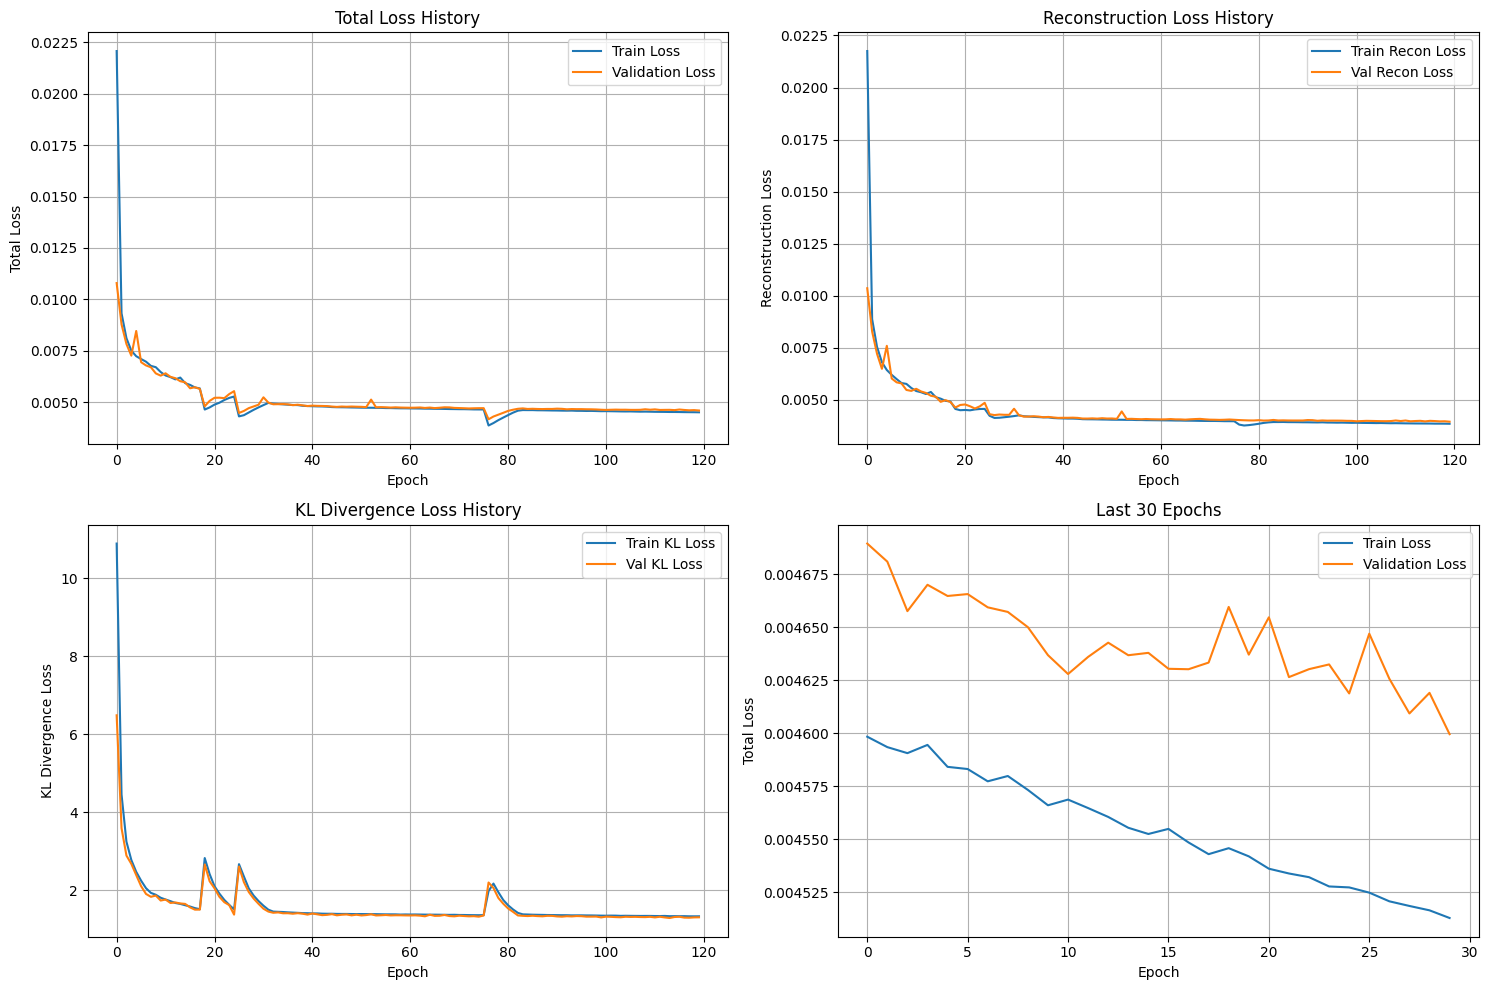


Training completed in 69.36 minutes
Best validation loss: 0.004173


In [41]:
# Example usage to train the VAE
if __name__ == "__main__":
    # Create the VAE model
    model = VAE(latent_dim=256)
    
    # Create VAE configuration
    config = VAEConfig(
        latent_dim=256,
        batch_size=8,
        accumulation_steps=8,        # Effective batch size = 64
        learning_rate=2e-5,
        epochs=200,
        beta=0.0005,                 # Reduced from 0.005 to 0.0005 (10x smaller)
        beta_warmup_steps=10000,      # Increased from 2000 to 10000
        early_stopping_patience=20,
        use_mixed_precision=True,
        num_workers=4,
        model_name="vae_model_v2"    # New model name to avoid overwriting
    )
    
    # Train the VAE
    results = train_vae(model, train_loader, val_loader, config)

### Evaluation and Result Visualization

In [42]:
# Cell 18: VAE Evaluation and Comparison with Autoencoder
import torch
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import json
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import seaborn as sns
from tqdm import tqdm

def load_trained_vae(checkpoint_dir, model_name='vae_model', latent_dim=256):
    """Load trained VAE model for evaluation"""
    model_path = Path(checkpoint_dir) / f"{model_name}_best.pth"
    metadata_path = Path(checkpoint_dir) / f"{model_name}_metadata.json"
    
    # Load model
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = VAE(latent_dim=latent_dim)
    
    if model_path.exists():
        # Load best model if available
        model.load_state_dict(torch.load(model_path, map_location=device))
        print(f"Loaded best VAE model from {model_path}")
    else:
        # Try loading checkpoint if best model doesn't exist
        checkpoint_path = Path(checkpoint_dir) / f"{model_name}_checkpoint.pth"
        if not checkpoint_path.exists():
            raise FileNotFoundError(f"No VAE model found at {model_path} or {checkpoint_path}")
        
        checkpoint = torch.load(checkpoint_path, map_location=device)
        model.load_state_dict(checkpoint['model_state_dict'])
        print(f"Loaded VAE checkpoint from epoch {checkpoint['epoch']}")
    
    # Load training history
    if metadata_path.exists():
        with open(metadata_path, 'r') as f:
            metadata = json.load(f)
        print(f"Loaded training history with {len(metadata['train_losses'])} epochs")
    else:
        metadata = {"train_losses": [], "val_losses": []}
        print("No metadata found, using empty history")
    
    model.eval()
    model.to(device)
    
    return model, metadata

def visualize_vae_reconstructions(model, dataloader, num_samples=3):
    """Visualize original vs reconstructed volumes from VAE"""
    device = next(model.parameters()).device
    
    # Get samples from dataloader
    samples = []
    labels = []
    
    for batch in dataloader:
        volumes = batch['volume']
        batch_labels = batch['label']
        
        for i in range(min(len(volumes), num_samples - len(samples))):
            samples.append(volumes[i:i+1])
            labels.append(batch_labels[i])
            
        if len(samples) >= num_samples:
            break
    
    # Visualize each sample with multiple reconstructions
    with torch.no_grad():
        for idx, (sample, label) in enumerate(zip(samples, labels)):
            # Get original volume
            orig_vol = sample.to(device)
            
            # Generate multiple reconstructions to visualize variability
            reconstructions = []
            for _ in range(3):  # Generate 3 different reconstructions
                recon, _, _ = model(orig_vol)
                reconstructions.append(recon.cpu().squeeze().numpy())
            
            # Move original to CPU for visualization
            orig_vol = orig_vol.cpu().squeeze().numpy()
            
            # Create figure for this sample
            fig = plt.figure(figsize=(15, 12))
            plt.suptitle(f"VAE Sample {idx+1} - Group: {label}", fontsize=16)
            
            # Define slice indices (midpoint by default)
            z_slice = orig_vol.shape[0] // 2
            y_slice = orig_vol.shape[1] // 2
            x_slice = orig_vol.shape[2] // 2
            
            # Plot original slices in first row
            plt.subplot(4, 3, 1)
            plt.imshow(orig_vol[z_slice], cmap='gray', vmin=0, vmax=3)
            plt.title("Original - Axial")
            plt.axis('off')
            
            plt.subplot(4, 3, 2)
            plt.imshow(orig_vol[:, y_slice, :], cmap='gray', vmin=0, vmax=3)
            plt.title("Original - Coronal")
            plt.axis('off')
            
            plt.subplot(4, 3, 3)
            plt.imshow(orig_vol[:, :, x_slice], cmap='gray', vmin=0, vmax=3)
            plt.title("Original - Sagittal")
            plt.axis('off')
            
            # Plot multiple reconstructions to show variability
            for i, recon in enumerate(reconstructions):
                row = i + 1
                
                plt.subplot(4, 3, row*3 + 1)
                plt.imshow(recon[z_slice], cmap='gray', vmin=0, vmax=3)
                plt.title(f"Recon {row} - Axial")
                plt.axis('off')
                
                plt.subplot(4, 3, row*3 + 2)
                plt.imshow(recon[:, y_slice, :], cmap='gray', vmin=0, vmax=3)
                plt.title(f"Recon {row} - Coronal")
                plt.axis('off')
                
                plt.subplot(4, 3, row*3 + 3)
                plt.imshow(recon[:, :, x_slice], cmap='gray', vmin=0, vmax=3)
                plt.title(f"Recon {row} - Sagittal")
                plt.axis('off')
            
            plt.tight_layout()
            plt.show()

def extract_vae_latent_vectors(model, dataloader, max_samples=None):
    """Extract latent vectors from VAE encoder"""
    device = next(model.parameters()).device
    
    latent_vectors = []
    labels = []
    paths = []
    
    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Extracting VAE latent vectors"):
            volumes = batch['volume'].to(device)
            batch_labels = batch['label']
            batch_paths = batch['path']
            
            # Extract latent vectors (mean only, ignore log_var)
            mu, _ = model.encode(volumes)
            
            # Store results
            latent_vectors.append(mu.cpu().numpy())
            labels.extend(batch_labels)
            paths.extend(batch_paths)
            
            # Check if we have enough samples
            if max_samples and len(labels) >= max_samples:
                latent_vectors = np.vstack(latent_vectors)
                latent_vectors = latent_vectors[:max_samples]
                labels = labels[:max_samples]
                paths = paths[:max_samples]
                break
    
    # Stack all latent vectors if we didn't break early
    if isinstance(latent_vectors[0], np.ndarray):
        latent_vectors = np.vstack(latent_vectors)
    
    return latent_vectors, labels, paths

def compare_latent_spaces(ae_vectors, vae_vectors, labels, method='tsne'):
    """Compare autoencoder and VAE latent spaces side by side"""
    plt.figure(figsize=(20, 8))
    
    # Create label-to-color mapping for consistent colors
    unique_labels = list(set(labels))
    colors = plt.cm.tab10(np.linspace(0, 1, len(unique_labels)))
    label_to_color = {label: colors[i] for i, label in enumerate(unique_labels)}
    
    # Apply dimensionality reduction to both latent spaces
    if method.lower() == 'tsne':
        print("Computing t-SNE projections...")
        reducer = TSNE(n_components=2, random_state=42, 
                     perplexity=min(30, len(ae_vectors) - 1))
        title = 't-SNE Visualization of Latent Spaces'
    else:
        print("Computing PCA projections...")
        reducer = PCA(n_components=2, random_state=42)
        title = 'PCA Visualization of Latent Spaces'
    
    # Apply reduction to AE vectors
    ae_reduced = reducer.fit_transform(ae_vectors)
    
    # Reset the random state for consistency before applying to VAE vectors
    if method.lower() == 'tsne':
        reducer = TSNE(n_components=2, random_state=42, 
                     perplexity=min(30, len(vae_vectors) - 1))
    else:
        reducer = PCA(n_components=2, random_state=42)
    
    # Apply reduction to VAE vectors
    vae_reduced = reducer.fit_transform(vae_vectors)
    
    # Plot AE latent space
    plt.subplot(1, 2, 1)
    for label in unique_labels:
        indices = [i for i, l in enumerate(labels) if l == label]
        plt.scatter(
            ae_reduced[indices, 0], 
            ae_reduced[indices, 1],
            label=label, 
            color=label_to_color[label], 
            alpha=0.7,
            edgecolor='w',
            s=100
        )
    plt.title(f"Standard Autoencoder\n{method.upper()} Latent Space", fontsize=14)
    plt.xlabel("Dimension 1", fontsize=12)
    plt.ylabel("Dimension 2", fontsize=12)
    plt.legend(title="Group", fontsize=10)
    plt.grid(True, alpha=0.3)
    
    # Plot VAE latent space
    plt.subplot(1, 2, 2)
    for label in unique_labels:
        indices = [i for i, l in enumerate(labels) if l == label]
        plt.scatter(
            vae_reduced[indices, 0], 
            vae_reduced[indices, 1],
            label=label, 
            color=label_to_color[label], 
            alpha=0.7,
            edgecolor='w',
            s=100
        )
    plt.title(f"Variational Autoencoder\n{method.upper()} Latent Space", fontsize=14)
    plt.xlabel("Dimension 1", fontsize=12)
    plt.ylabel("Dimension 2", fontsize=12)
    plt.legend(title="Group", fontsize=10)
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return ae_reduced, vae_reduced

def generate_vae_samples(model, num_samples=5):
    """Generate synthetic brain scans from random latent vectors"""
    device = next(model.parameters()).device
    
    # Generate random latent vectors
    z = torch.randn(num_samples, model.latent_dim, device=device)
    
    # Generate samples
    with torch.no_grad():
        samples = model.decoder(z)
    
    # Visualize generated samples
    plt.figure(figsize=(15, 5 * num_samples))
    
    for i in range(num_samples):
        sample = samples[i, 0].cpu().numpy()
        
        # Get middle slices
        z_slice = sample.shape[0] // 2
        y_slice = sample.shape[1] // 2
        x_slice = sample.shape[2] // 2
        
        # Plot slices
        plt.subplot(num_samples, 3, i*3 + 1)
        plt.imshow(sample[z_slice], cmap='gray')
        plt.title(f"Sample {i+1} - Axial" if i == 0 else "")
        plt.axis('off')
        
        plt.subplot(num_samples, 3, i*3 + 2)
        plt.imshow(sample[:, y_slice, :], cmap='gray')
        plt.title(f"Sample {i+1} - Coronal" if i == 0 else "")
        plt.axis('off')
        
        plt.subplot(num_samples, 3, i*3 + 3)
        plt.imshow(sample[:, :, x_slice], cmap='gray')
        plt.title(f"Sample {i+1} - Sagittal" if i == 0 else "")
        plt.axis('off')
    
    plt.suptitle("Generated Brain Scans from VAE Random Sampling", fontsize=16)
    plt.tight_layout()
    plt.show()
    
    return samples

def interpolate_between_groups(ae_model, vae_model, dataloader, start_group='Control', end_group='PD', steps=5):
    """Compare interpolation between groups for both AE and VAE"""
    device = next(ae_model.parameters()).device
    
    # Get a sample from each group
    start_sample = None
    end_sample = None
    
    for batch in dataloader:
        volumes = batch['volume']
        labels = batch['label']
        
        for i, (volume, label) in enumerate(zip(volumes, labels)):
            if label == start_group and start_sample is None:
                start_sample = volume.unsqueeze(0)
            elif label == end_group and end_sample is None:
                end_sample = volume.unsqueeze(0)
                
        if start_sample is not None and end_sample is not None:
            break
    
    if start_sample is None or end_sample is None:
        print(f"Couldn't find samples for both {start_group} and {end_group}")
        return
    
    # Move to device
    start_sample = start_sample.to(device)
    end_sample = end_sample.to(device)
    
    # Get latent vectors for AE
    with torch.no_grad():
        start_z_ae = ae_model.encode(start_sample)
        end_z_ae = ae_model.encode(end_sample)
    
    # Get latent vectors for VAE (use mu only)
    with torch.no_grad():
        start_z_vae, _ = vae_model.encode(start_sample)
        end_z_vae, _ = vae_model.encode(end_sample)
    
    # Create interpolation steps
    alphas = np.linspace(0, 1, steps)
    
    # Interpolate in AE latent space
    ae_interpolated = []
    for alpha in alphas:
        z = (1 - alpha) * start_z_ae + alpha * end_z_ae
        with torch.no_grad():
            reconstructed = ae_model.decode(z)
            ae_interpolated.append(reconstructed.cpu().squeeze().numpy())
    
    # Interpolate in VAE latent space
    vae_interpolated = []
    for alpha in alphas:
        z = (1 - alpha) * start_z_vae + alpha * end_z_vae
        with torch.no_grad():
            reconstructed = vae_model.decoder(z)
            vae_interpolated.append(reconstructed.cpu().squeeze().numpy())
    
    # Visualize interpolation
    plt.figure(figsize=(15, 5 * steps))
    
    # Plot first row title
    plt.figtext(0.25, 0.98, "Standard Autoencoder", fontsize=14, ha='center')
    plt.figtext(0.75, 0.98, "Variational Autoencoder", fontsize=14, ha='center')
    
    for i, alpha in enumerate(alphas):
        # Get a slice index (middle)
        z_slice = ae_interpolated[i].shape[0] // 2
        
        # Plot AE interpolation
        plt.subplot(steps, 2, i*2 + 1)
        plt.imshow(ae_interpolated[i][z_slice], cmap='gray')
        plt.title(f"α = {alpha:.2f}" if i == 0 else "")
        plt.axis('off')
        
        # Plot VAE interpolation
        plt.subplot(steps, 2, i*2 + 2)
        plt.imshow(vae_interpolated[i][z_slice], cmap='gray')
        plt.title(f"α = {alpha:.2f}" if i == 0 else "")
        plt.axis('off')
    
    plt.suptitle(f"Interpolation from {start_group} to {end_group}", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.97])
    plt.subplots_adjust(top=0.9)
    plt.show()
    
    return ae_interpolated, vae_interpolated

Loading trained Autoencoder...

Loading trained VAE...
Loaded best VAE model from checkpoints/vae_model_v2_best.pth
Loaded training history with 120 epochs

Visualizing VAE reconstructions...


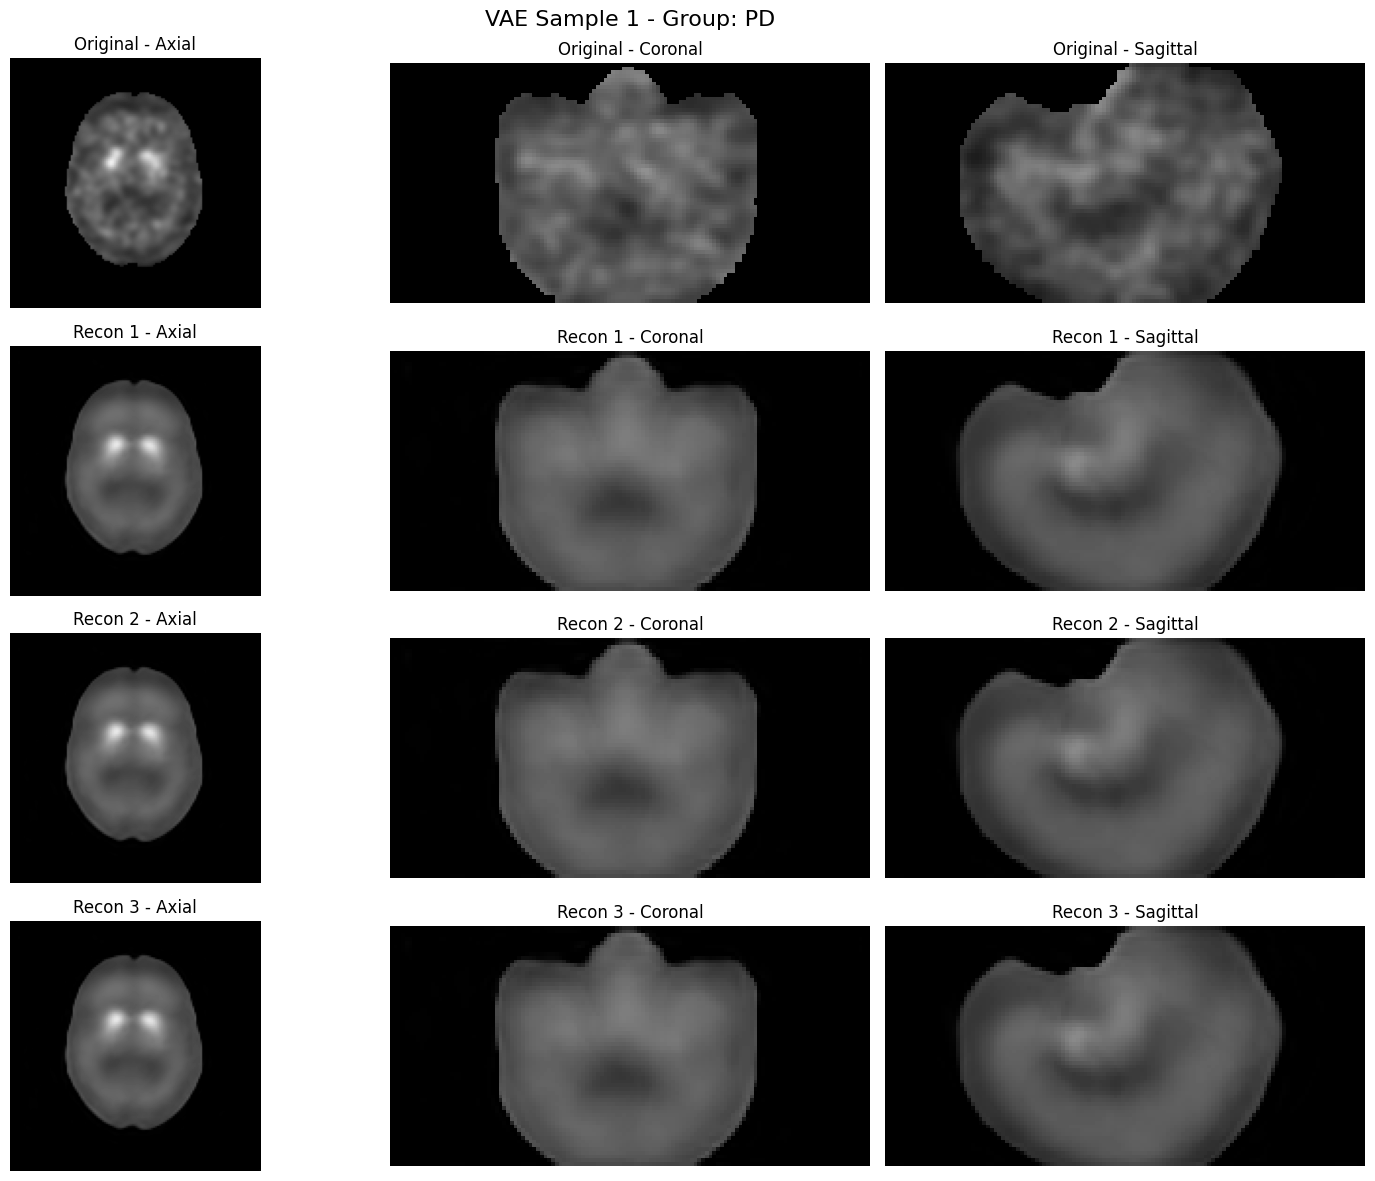

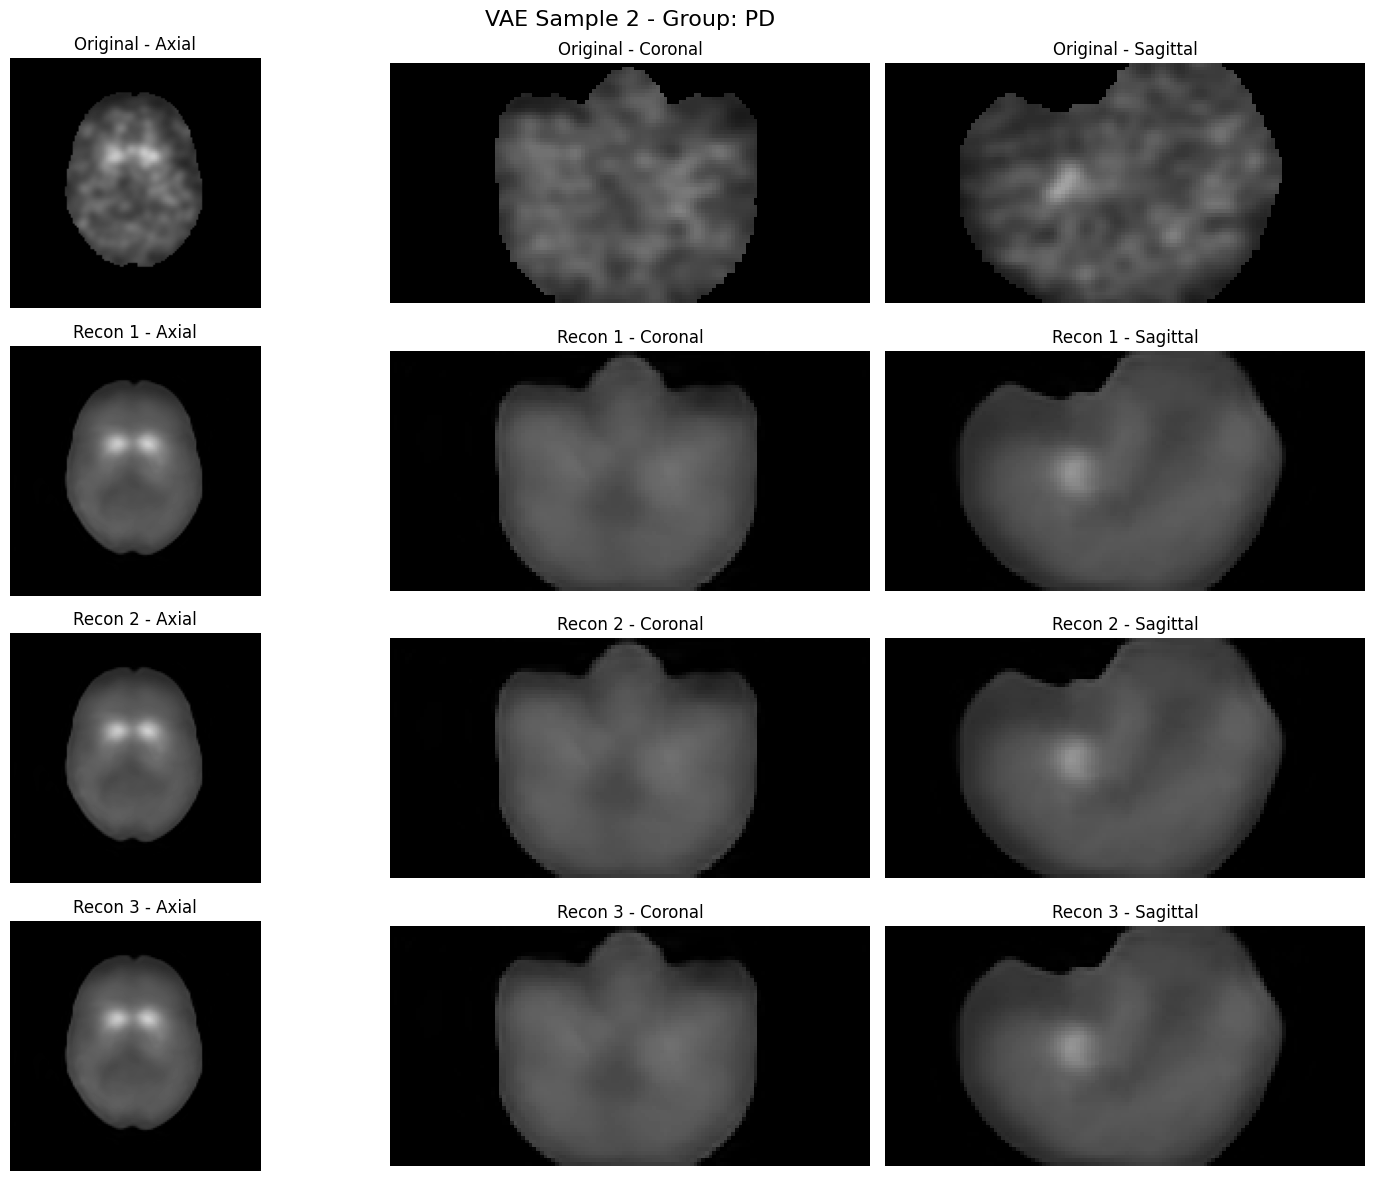

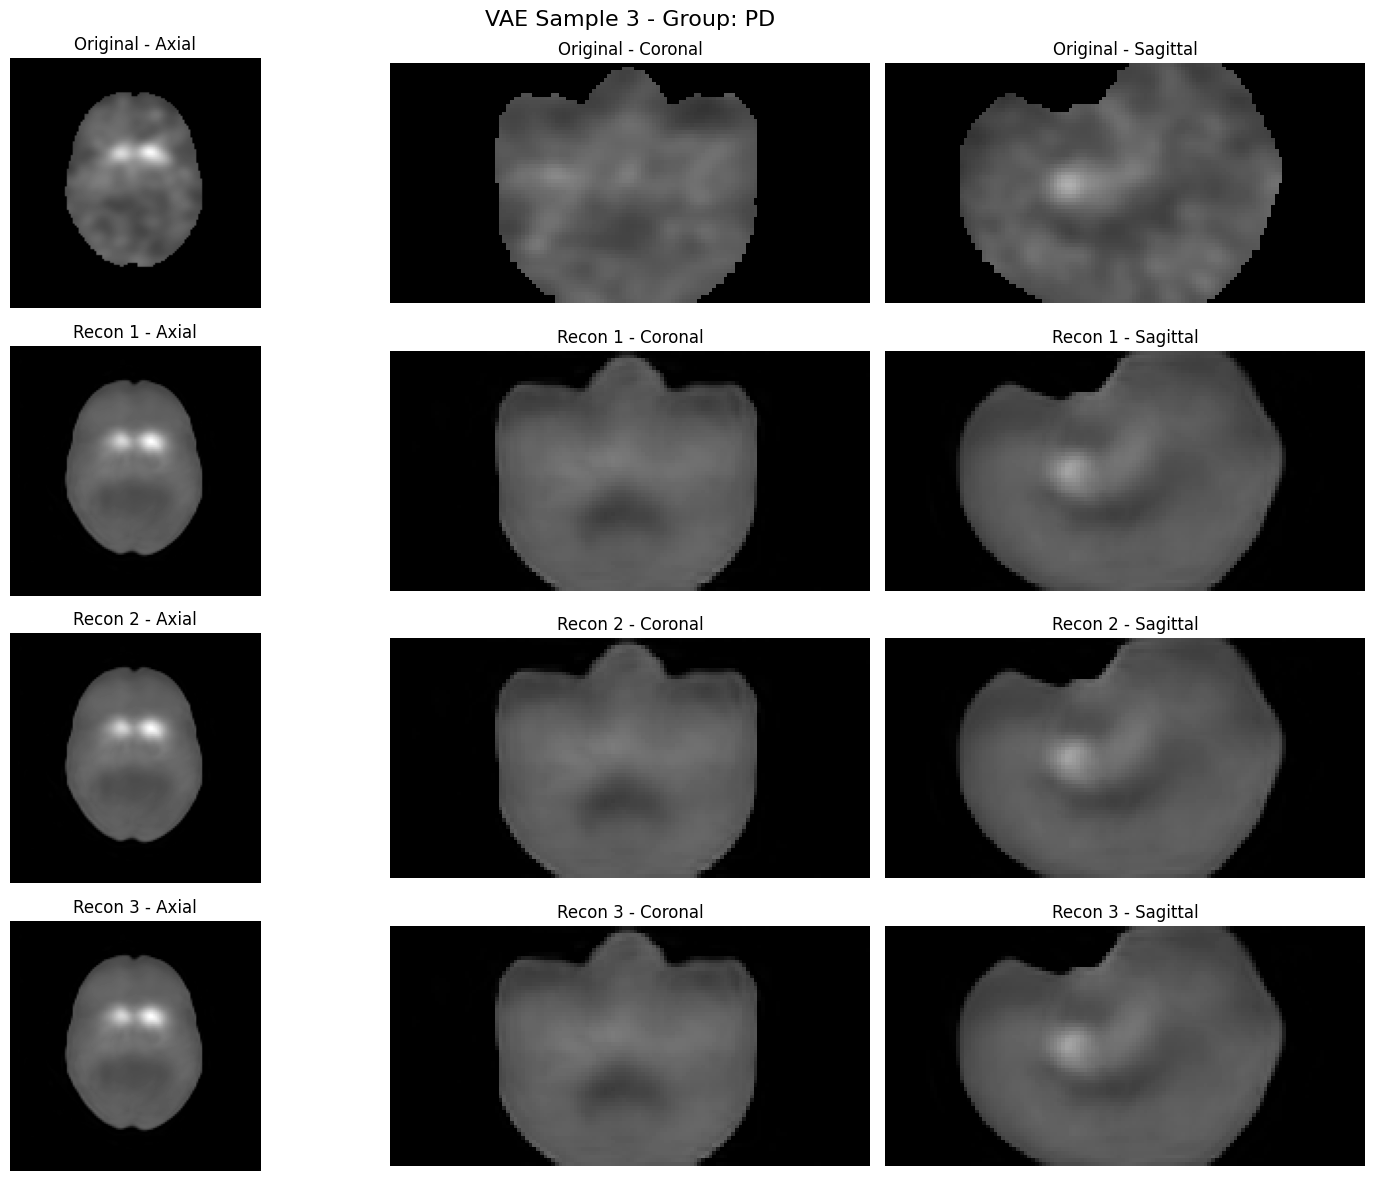


Extracting latent vectors from Autoencoder...


Extracting latent vectors:   5%|▍         | 14/299 [00:00<00:14, 20.34it/s]

Error processing file Images/PPMI_Images_PD/3863/Reconstructed_DaTSCAN/2013-03-13_13_29_21.0/I449248/PPMI_3863_NM_Reconstructed_DaTSCAN_Br_20141022165646607_1_S202944_I449248.dcm: operands could not be broadcast together with shapes (60,128,128) (91,109,91) 


Extracting latent vectors:  21%|██        | 63/299 [00:03<00:12, 18.22it/s]

Error processing file Images/PPMI_Images_PD/3179/Reconstructed_DaTSCAN/2016-08-18_13_51_47.0/I1317564/PPMI_3179_NM_Reconstructed_DaTSCAN_Br_20200616100643787_1_S550153_I1317564.dcm: operands could not be broadcast together with shapes (480,128,128) (91,109,91) 


Extracting latent vectors:  33%|███▎      | 99/299 [00:07<00:16, 12.40it/s]



Extracting latent vectors from VAE...


Extracting VAE latent vectors:   4%|▍         | 13/299 [00:00<00:15, 18.44it/s]

Error processing file Images/PPMI_Images_PD/3863/Reconstructed_DaTSCAN/2013-03-13_13_29_21.0/I449248/PPMI_3863_NM_Reconstructed_DaTSCAN_Br_20141022165646607_1_S202944_I449248.dcm: operands could not be broadcast together with shapes (60,128,128) (91,109,91) 


Extracting VAE latent vectors:  21%|██▏       | 64/299 [00:03<00:11, 21.07it/s]

Error processing file Images/PPMI_Images_PD/3179/Reconstructed_DaTSCAN/2016-08-18_13_51_47.0/I1317564/PPMI_3179_NM_Reconstructed_DaTSCAN_Br_20200616100643787_1_S550153_I1317564.dcm: operands could not be broadcast together with shapes (480,128,128) (91,109,91) 


Extracting VAE latent vectors:  33%|███▎      | 99/299 [00:05<00:10, 19.20it/s]



Comparing latent spaces with t-SNE...
Computing t-SNE projections...


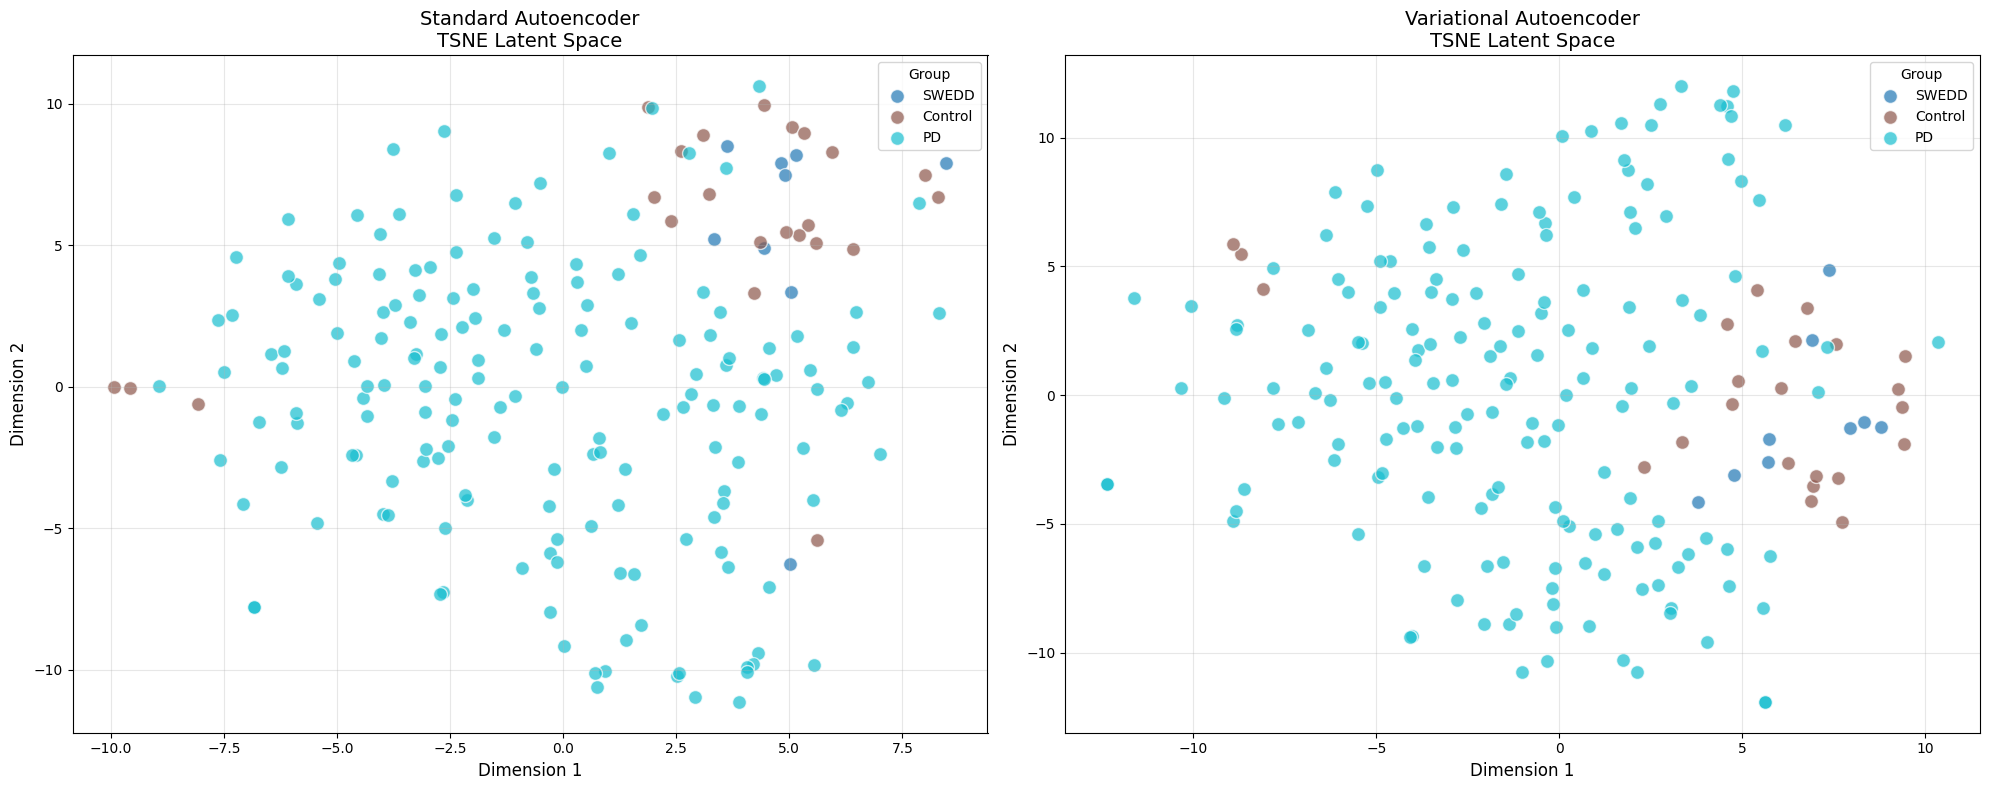


Comparing latent spaces with PCA...
Computing PCA projections...


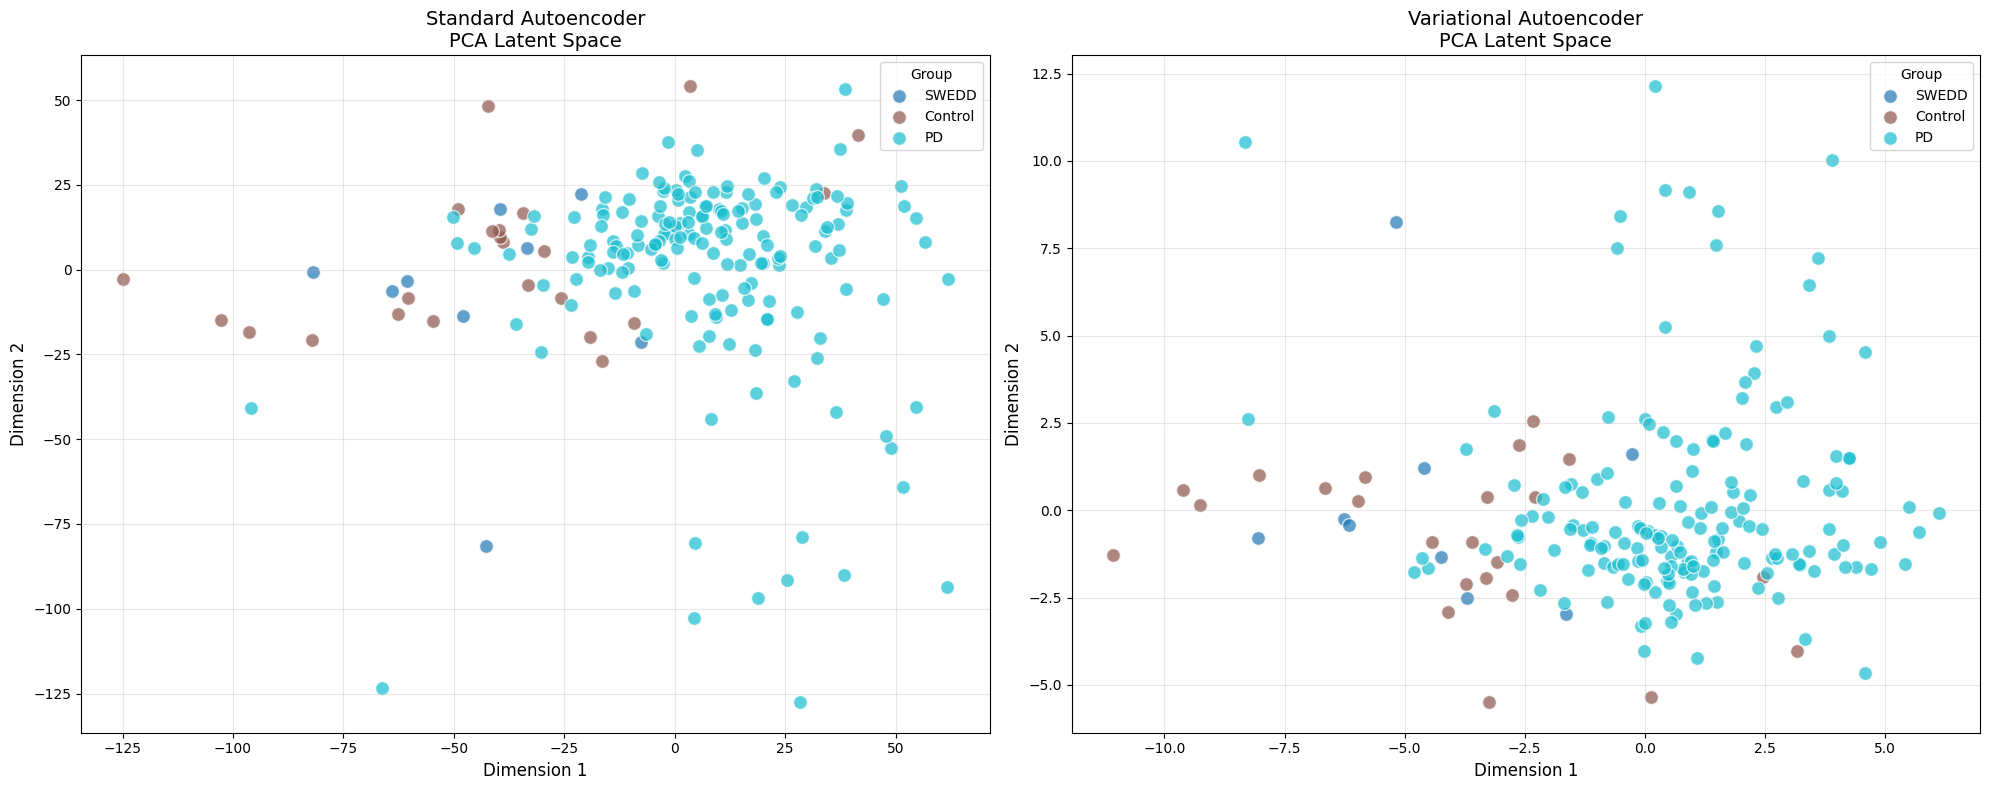


Generating synthetic brain scans from VAE...


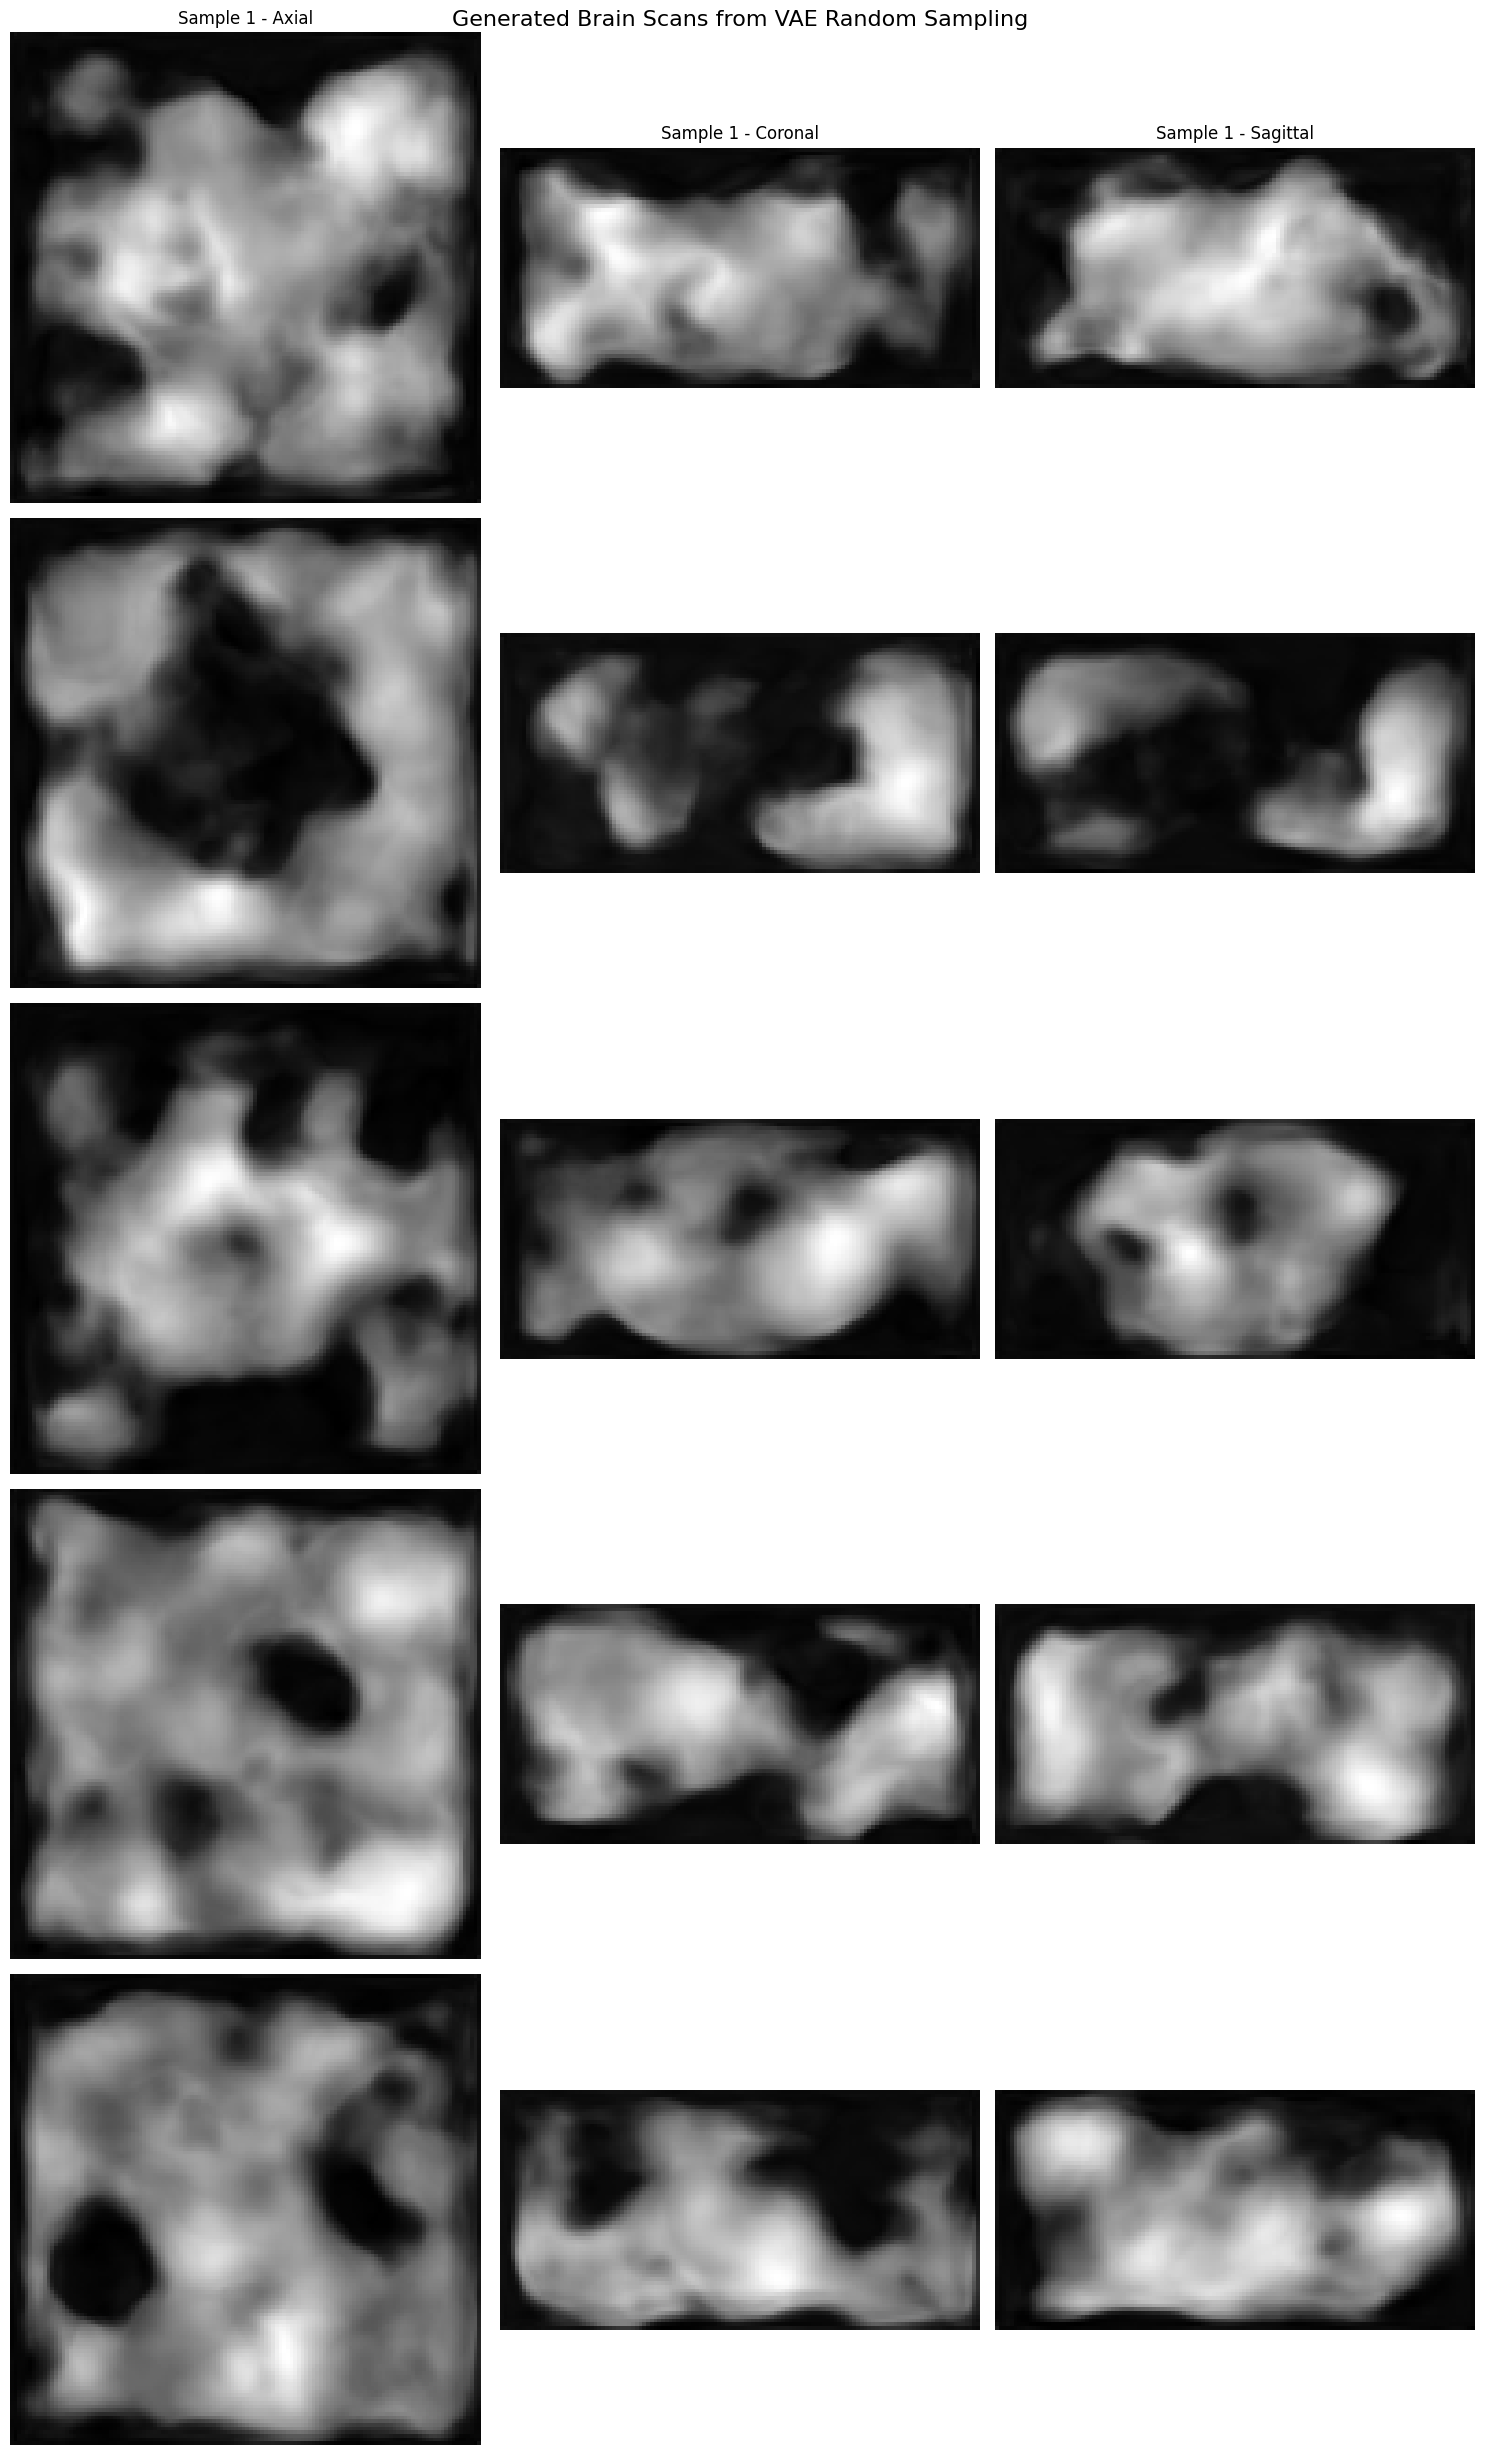


Comparing interpolation capabilities...


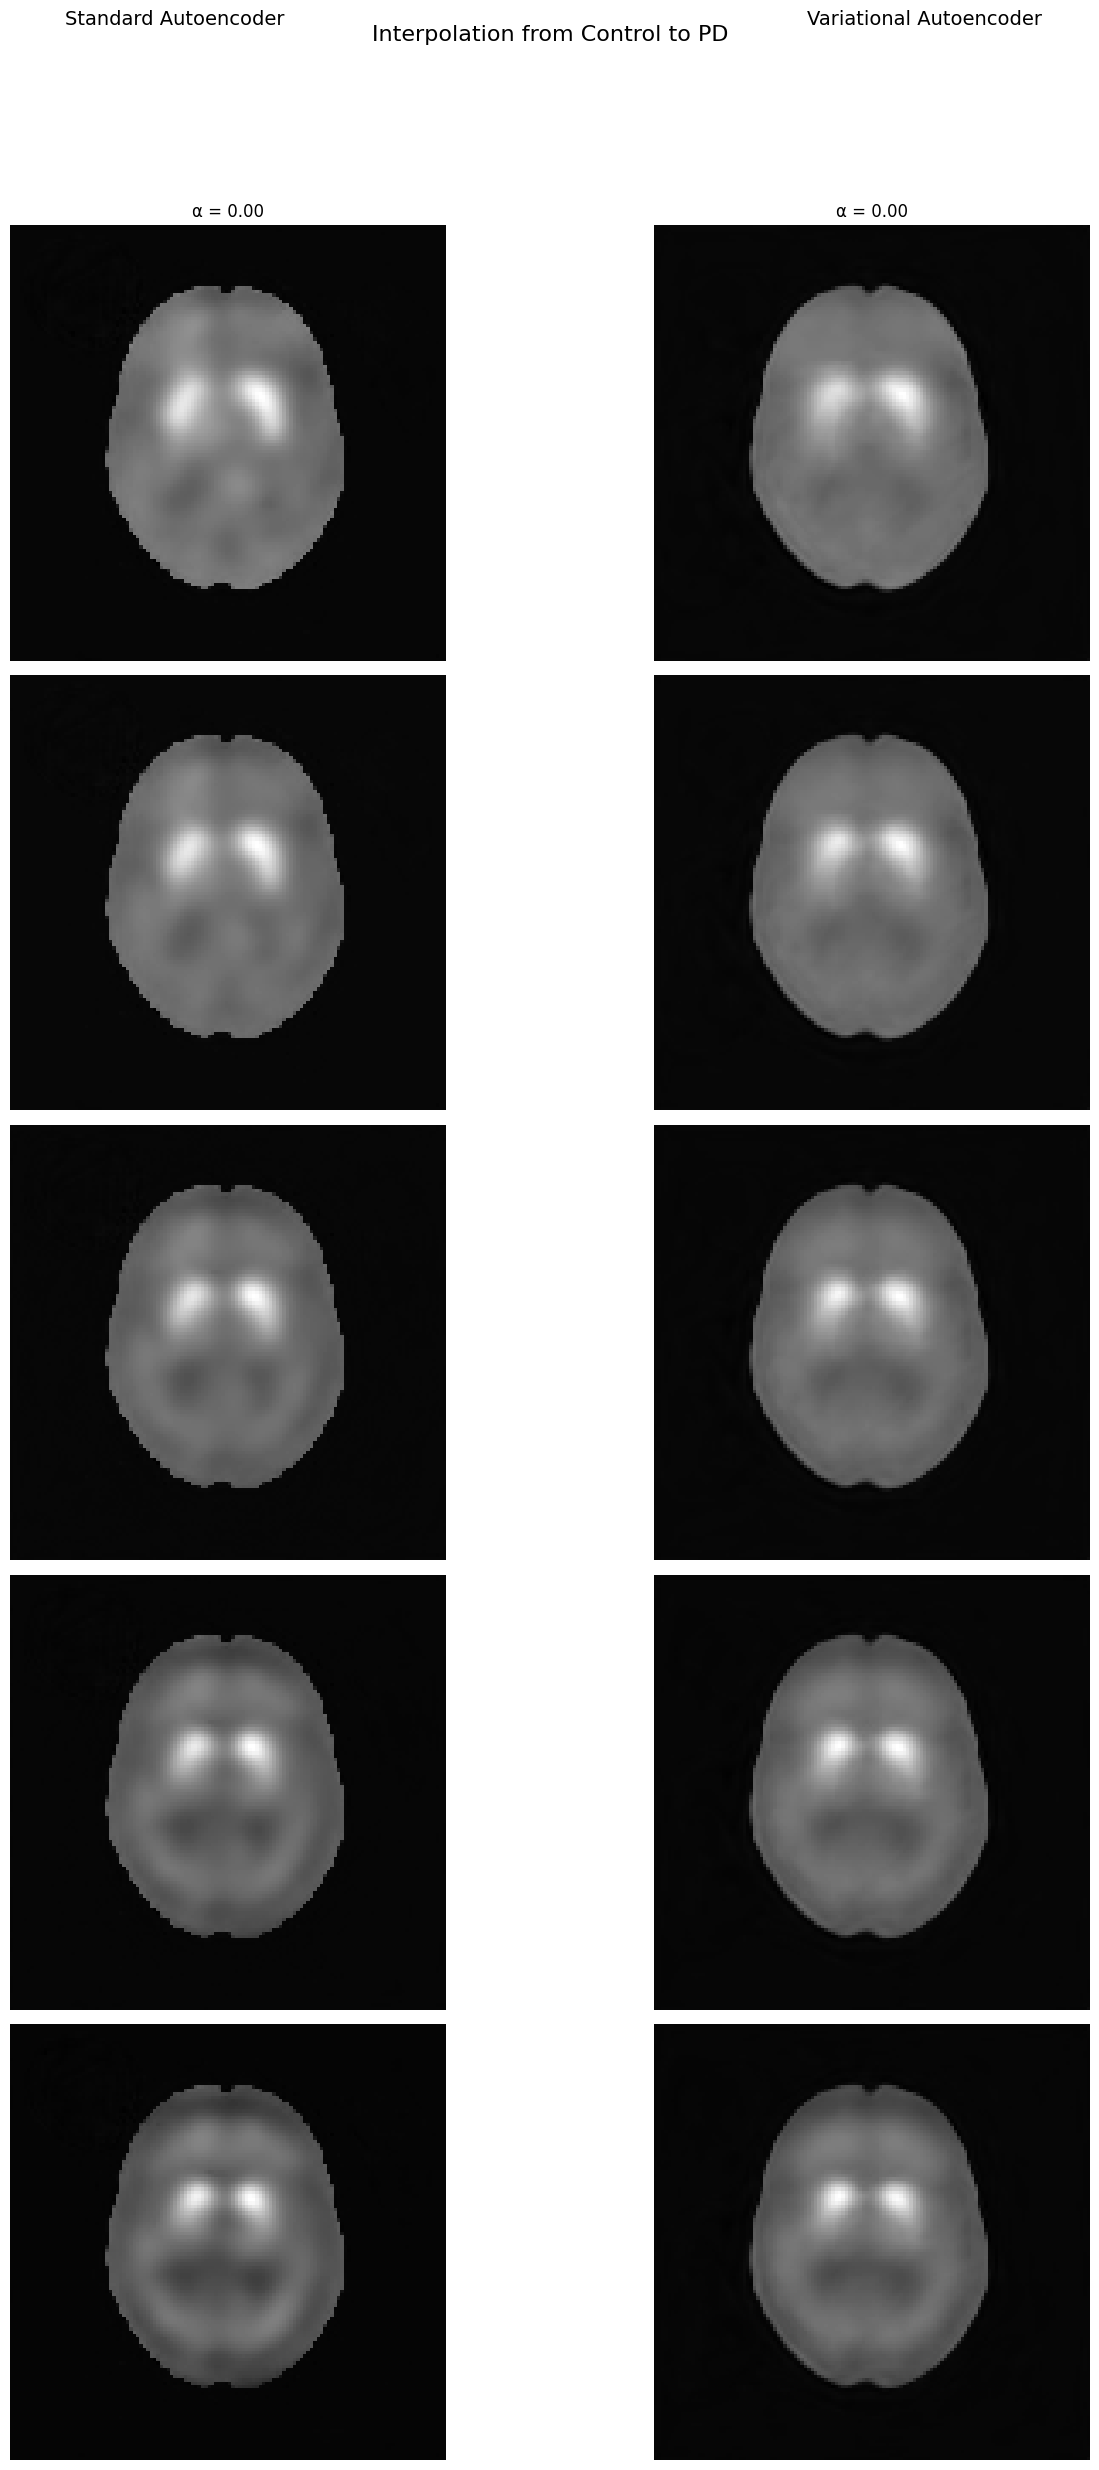

In [43]:
# Run VAE evaluation
if __name__ == "__main__":
    # Uncomment this code to run the VAE evaluation
    # First, load both models
    print("Loading trained Autoencoder...")
    ae_model, ae_metadata = load_trained_model('checkpoints', 'autoencoder_v1', latent_dim=256)
    
    print("\nLoading trained VAE...")
    vae_model, vae_metadata = load_trained_vae('checkpoints', 'vae_model_v2', latent_dim=256)
    
    # Compare reconstructions
    print("\nVisualizing VAE reconstructions...")
    visualize_vae_reconstructions(vae_model, val_loader, num_samples=3)
    
    # Extract latent vectors from both models
    print("\nExtracting latent vectors from Autoencoder...")
    ae_vectors, labels, paths = extract_latent_vectors(ae_model, val_loader, max_samples=200)
    
    print("\nExtracting latent vectors from VAE...")
    vae_vectors, vae_labels, vae_paths = extract_vae_latent_vectors(vae_model, val_loader, max_samples=200)
    
    # Compare latent spaces
    print("\nComparing latent spaces with t-SNE...")
    ae_tsne, vae_tsne = compare_latent_spaces(ae_vectors, vae_vectors, labels, method='tsne')
    
    print("\nComparing latent spaces with PCA...")
    ae_pca, vae_pca = compare_latent_spaces(ae_vectors, vae_vectors, labels, method='pca')
    
    # Generate synthetic samples from VAE
    print("\nGenerating synthetic brain scans from VAE...")
    synthetic_samples = generate_vae_samples(vae_model, num_samples=5)
    
    # Compare interpolation capabilities
    print("\nComparing interpolation capabilities...")
    ae_interp, vae_interp = interpolate_between_groups(ae_model, vae_model, val_loader, 
                                                     start_group='Control', end_group='PD', steps=5)